In [2]:
import os

import matplotlib.pyplot as plt
import random
from pennylane import numpy as np
from tqdm import tqdm
#from qbmqsp.qbm import QBM
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from gen_data import xxz_gibbs_state, basis_encoding, gen_boltzmann_dist, gen_discrete_gauss_dist
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import scipy.linalg as spl

import pennylane as qml
from pennylane import numpy as np
from pennylane.pauli.utils import string_to_pauli_word

from qbmqsp.hamiltonian import Hamiltonian
from qbmqsp.qsp_phase_engine import QSPPhaseEngine
from qbmqsp.qevt import QEVT
from qbmqsp.rel_ent import relative_entropy



import itertools

#DATASET_PATH3='C:/Users/ge84gac/datasets/o7_c5_d2_p200_1.npy'
DATASET_PATH2='C:/Users/ge84gac/Downloads/QBM-Anomaly-Detection-version-paper/QBM-Anomaly-Detection-main/src/datasets/l_o7_c5_d3_p200_v1.npy'
DATASET_PATH = 'C:/Users/ge84gac/QBM-anomaly-detection/src/datasets/l_o6_c10_d3_p1000_2.npy'   # Give dataset path
CLUSTER = 5

In [97]:
# Function returning the hamilatonian form for the restriceted boltzmann machine

In [3]:
def generate_pauli_strings_tfim(num_qubits,n_visible,restricted=True):
    """
    Generate Pauli strings for a transverse field Ising model as a 
    restricted boltzmann machine with no visible-visible connecions.
    
    Parameters:
    num_qubits (int): Number of qubits in the quantum Boltzmann machine.
    n_visible (int): Number if visible units.
    
    Returns:
    list: List of Pauli strings representing the Hamiltonian.
    """
    pauli_strings = []

    # Local transverse field terms (X_i)
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_strings.append(''.join(pauli_string))

    # Interaction terms (Z_i Z_j)
    for i, j in itertools.combinations(range(num_qubits), 2):
        if restricted:
            if i<n_visible and j>=n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))
        else:
            if i<n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))       
    return pauli_strings

generate_pauli_strings_tfim(7,3,False)   

['ZIIIIII',
 'IZIIIII',
 'IIZIIII',
 'IIIZIII',
 'IIIIZII',
 'IIIIIZI',
 'IIIIIIZ',
 'ZZIIIII',
 'ZIZIIII',
 'ZIIZIII',
 'ZIIIZII',
 'ZIIIIZI',
 'ZIIIIIZ',
 'IZZIIII',
 'IZIZIII',
 'IZIIZII',
 'IZIIIZI',
 'IZIIIIZ',
 'IIZZIII',
 'IIZIZII',
 'IIZIIZI',
 'IIZIIIZ']

In [110]:
import seaborn as sns
def evaluate_qbm(qbm,testing_dataset):


    #training_data=numpy.expand_dims(training_data[:,0],axis=1)
    outliers = qbm.get_binary_outliers(
    dataset=testing_dataset, outlier_index=CLUSTER)

    #outliers=numpy.expand_dims(outliers[:,0],axis=1)
    

    points = qbm.get_binary_cluster_points(
    dataset=testing_dataset, cluster_index=CLUSTER - 1)

    #points=numpy.expand_dims(points[:,0],axis=1)
    #print(points)
    predict_points_cluster = np.zeros(len(points), dtype=int)
    predict_points_outliers = np.zeros(len(outliers), dtype=int)
    qbm.calculate_outlier_threshold(.95)
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Calculate outlier Energy")

    testing_data, testing_labels = split_dataset_labels(testing_dataset)
#testing_data=numpy.expand_dims(testing_data[:,0],axis=1)

    outlier_energy = []
    for index, outlier in enumerate(tqdm(outliers), 0):
        outlier = np.reshape(outlier, (qbm.dim_input))
        predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
            outlier)
        outlier_energy.append(this_outlier_energy)
    outlier_energy = np.array(outlier_energy)

    o = outlier_energy.reshape((outlier_energy.shape[0]))

    print("Calculate cluster energy")
    cluster_point_energy = []

    for index, point in enumerate(tqdm(points), 0):
        point = np.reshape(point, (qbm.dim_input))
        predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point)
        cluster_point_energy.append(this_cluster_point_energy)
    cluster_point_energy = np.array(cluster_point_energy)

    c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

    title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
    print('Outlier classification: Results...')
    predict_points = np.concatenate(
        (predict_points_cluster, predict_points_outliers))

    print("Predicted points test: ", predict_points)

    true_points = np.concatenate(
        (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

    accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
        true_points, predict_points), recall_score(true_points, predict_points)
    f1 = f1_score(true_points, predict_points)
    tn, fp, fn, tp = confusion_matrix(
        true_points, predict_points, labels=[0, 1]).ravel()

    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

#print(f'Wallclock time: {(end-start):.2f} seconds')

    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Average clusterpoint energy: ", np.average(cluster_point_energy))
    print("Outlier energy: ", outlier_energy)
    plt.figure()
    plt.title('Test Dataset')
    sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
    sns.scatterplot(x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab], c='r',palette='coolwarm')
    plt.figure()
    plt.title('Predicted Points')
    sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1], hue=predict_points,palette='coolwarm')
    

class QBM():
    """Quantum Boltzmann machine (QBM) based on quantum signal processing.

    Parameters
    ----------
    β, enc:
        Same as attributes.
    h, θ:
        See qbmqsp.hamiltonian.Hamiltonian
    δ, polydeg:
        See qbmqsp.qsp_phase_engine.QSPPhaseEngine

    Attributes
    ----------
    β : float
        Inverse temperature.
    enc : str in {'general', 'lcu'}
        Unitary block encoding scheme.
    H : qbmqsp.hamiltonian.Hamiltonian
        Constructed from parameters (h, θ).
    qsp : qbmqsp.qsp_phase_engine.QSPPhaseEngine
        Constructed from parameters (δ, polydeg).
    qevt : qbmqsp.qevt.QEVT
        Quantum eigenvalue transform to realize matrix function f(A) = exp(- τ * |A|). Updated after each training epoch.
    observables : qml.operation.Observable
        Observables w.r.t which the QBM is measured to optimize via gradient descent.
    aux_wire, enc_wires, sys_wires, env_wires : list[int]
        Quantum register wires of quantum circuit that prepares and measures the QBM.
    """
    
    
    
    
    
    def __init__(self,data,h: list[str], θ: np.ndarray[float], enc: str, δ: float, polydeg: int, β: float, hnodes,epochs=1,restricted=True) -> None:
        if β < 0:
            raise ValueError("__init__: β must not be negative.")
        
        self.epochs=epochs
        self.β = β
        self.enc = enc
        self.H = Hamiltonian(h, θ)
        self.qsp = QSPPhaseEngine(δ, polydeg)
        self.qevt = self._construct_qevt()
        self.aux_wire, self.enc_wires, self.sys_wires, self.env_wires = self._construct_wires()
        self.observables = self._construct_obervables()
        
        self.encoded_data, bits_input_vector, num_features = self.binary_encode_data(data, use_folding=True)
        self.dim_input = bits_input_vector * num_features
        self.quantile=0.95
        self.dim_input=n_visible
        self.n_hidden_nodes=hnodes
        
        self.qubits=self.dim_input+self.n_hidden_nodes
        
        self.restricted=restricted
        # weights and biases in terms of the parameter θ
        
        #self.weights_visible_to_hidden=np.reshape(θ[self.n_hidden_nodes+self.dim_input:],(self.dim_input,self.n_hidden_nodes))
        
        #self.biases_visible=θ[0:self.dim_input]
        
        #self.biases_hidden=θ[self.dim_input:self.n_hidden_nodes+self.dim_input]

    def get_binary_cluster_points(self,dataset, cluster_index: int) -> np.ndarray:
        points = np.array([entry[:-1]
                           for entry in dataset if entry[-1] <= cluster_index])

        return self.binary_encode_data(points, use_folding=False)[0]
    
    def get_binary_outliers(self,dataset, outlier_index: int):
        outliers = np.array([entry[:-1]
                            for entry in dataset if entry[-1] >= outlier_index])

        return self.binary_encode_data(outliers, use_folding=False)[0]
  
    def binary_encode_data(self,data, use_folding=False):
        """ Encode a numpy array of form [[numpy.int64 numpy.int64] ...] into a
        list of form [[int, int, int, ...], ...].
        Example: encode [[107  73] [113  90] ...] to
        [[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0] .
        """

        # find out how many bits we need for each feature
        number_bits = len(np.binary_repr(np.amax(data)))
        number_features = data.shape[1]

        binary_encoded = ((data.reshape(-1, 1) & np.array(2 **
                          np.arange(number_bits-1, -1, -1))) != 0).astype(np.float32)
        if use_folding:
            return binary_encoded.reshape(len(data), number_features*number_bits), number_bits, number_features
        else:
            return binary_encoded.reshape(len(data), number_features, number_bits), number_bits, number_features
    
    
    def n_qubits(self, registers: str | set[str] = None) -> int:
        """Return number of qubits per registers.
        
        Parameters
        ----------
        registers : str | set[str]
            Quantum registers whose number of qubits should be returned.
            Must be an element from or a subset of {'aux', 'enc', 'sys', 'env'}.

        Returns
        -------
        n : int
            Number of qubits used per registers.
        """
        if registers is None:
            registers = {'aux', 'enc', 'sys', 'env'}
        elif type(registers) == str:
            registers = {registers}
        if not registers.issubset({'aux', 'enc', 'sys', 'env'}):
            raise ValueError("n_qubits: registers must be an element from or a subset of %r." % {'aux', 'enc', 'sys', 'env'})
        
        n = 0
        if 'env' in registers:
            n += self.qevt.n_qubits('sys')
        registers.discard('env')
        if len(registers) != 0:
            n += self.qevt.n_qubits(registers)
        return n

    def _generate_qsp_phases(self) -> np.ndarray[float]:
        τ = self.β / (1-self.qsp.δ) * self.H.θ_norm()
        φ = self.qsp.generate(τ)
        return φ

    def _construct_qevt(self) -> QEVT:
        φ = self._generate_qsp_phases()
        h_δ, θ_δ = self.H.preprocessing(self.qsp.δ)
        return QEVT(h_δ, θ_δ, self.enc, φ)
    
    def _construct_wires(self) -> tuple[list[int], list[int], list[int], list[int]]:
        wires = list(range(self.n_qubits()))
        aux_wire = wires[: self.n_qubits('aux')]
        enc_wires = wires[self.n_qubits('aux') : self.n_qubits({'aux', 'enc'})]
        sys_wires = wires[self.n_qubits({'aux', 'enc'}) : self.n_qubits({'aux', 'enc', 'sys'})]
        env_wires = wires[self.n_qubits({'aux', 'enc', 'sys'}) : self.n_qubits({'aux', 'enc', 'sys', 'env'})]
        return aux_wire, enc_wires, sys_wires, env_wires

    def _construct_obervables(self) -> list[qml.operation.Observable]:
        n_aux_enc = self.n_qubits({'aux', 'enc'})
        aux_enc_wires = self.aux_wire + self.enc_wires
        proj0 = qml.Projector( [0] * n_aux_enc, aux_enc_wires)

        new_sys_wires = list(range(self.n_qubits('sys')))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        observables = [proj0] + [proj0 @ string_to_pauli_word(self.H.h[i], wire_map) for i in range(self.H.n_params)]
        return observables
    
    def _bell_circuit(self) -> None:
        for i, j in zip(self.sys_wires, self.env_wires):
            qml.Hadamard(i)
            qml.CNOT([i, j])

    def probabilistic(self):
        
        bit_strings=[]
        for i in range(2**(self.n_hidden_nodes+self.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes+self.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
        sample = random.choices(bit_strings, k=1)

        for i,x in enumerate(sample[0]):
            if x==1:
                qml.PauliX(wires=[self.sys_wires[i]])
    
    def _prepare(self) -> None:
        self._bell_circuit()
        #self.probabilistic()
        self.qevt.circuit(self.aux_wire, self.enc_wires, self.sys_wires)
    
    def _measure(self) -> None:
        #return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        return [qml.expval(self.observables[i]) for i in range(len(self.observables))]
    
    
    def get_sample(self,shots=1):
        dev = qml.device(dev_name,shots=shots, wires=self.n_qubits({'aux','enc','sys'}))
        @qml.qnode(dev)
        
        def quantum_circuit():
            
            self._prepare()
            return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        sample=quantum_circuit()
        return sample
    
    def get_average_configuration_from_samples(self, samples: list, input_vector=None):
        ''' Takes samples from Annealer and averages for each neuron and connection
        '''

        # unclamped if input_vector == None
        unclamped = input_vector== None

        # biases (row = sample, column = neuron)
        np_samples = np.vstack(
            tuple([np.array(list(sample.values())) for sample in samples]))
        avgs_biases = np.average(np_samples, axis=0)
        avgs_biases_hidden = avgs_biases[self.dim_input:] if unclamped else avgs_biases
        avgs_biases_visible = avgs_biases[:
                                          self.dim_input] if unclamped else input_vector

        # weights
        avgs_weights_visible_to_hidden = np.zeros(
            self.weights_visible_to_hidden.shape)
        if not self.restricted:
            avgs_weights_visible_to_visible = np.zeros(
                self.weights_visible_to_visible.shape)
        for v in range(self.dim_input):
            # visible to hidden connections
            for h in range(self.n_hidden_nodes):
                x, y = (np_samples[:, v], self.dim_input +
                        h) if unclamped else (input_vector[v], h)
                avgs_weights_visible_to_hidden[v, h] = np.average(
                    x*np_samples[:, y])
            # visible to visible connections
            if not self.restricted:
                for v2 in range(v, self.dim_input):
                    x, y = (np_samples[:, v], np_samples[:, v2]) if unclamped else (
                        input_vector[v], input_vector[v2])
                    avgs_weights_visible_to_visible[v, v2] = np.average(x*y)

        if self.restricted:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, None
        else:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, avgs_weights_visible_to_visible

    def _compute_expvals(self) -> np.ndarray[float]:
        dev = qml.device(dev_name,wires=self.n_qubits({'aux','enc','sys','env'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
        @qml.qnode(dev)
        
        def quantum_circuit():
            self._prepare()
            return self._measure()
        num_repetitions=1
        avg_measurements=np.zeros(self.H.n_params)
        for repetitions in range(num_repetitions):
            
            measurements = quantum_circuit()
            
            success_probabilty = measurements[0]
            
            
            qbm_expvals = measurements[1:] / success_probabilty
            
            avg_measurements+=qbm_expvals
            
            print(success_probabilty, "prob")
        
        
        avg_measurements=avg_measurements/float(num_repetitions)
        
       
        return avg_measurements
    
    def _loss_func(self, ρ0: np.ndarray[float], ρ1: np.ndarray[float]) -> float:
        return relative_entropy(ρ0, ρ1, check_state=True).item()
    
    def assemble(self) -> np.ndarray[float]:
        """Assemble QBM."""
        expH = spl.expm(-self.β * self.H.assemble())
        return expH / np.trace(expH)
    
    
    def get_energy(self,input_vector):
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        
        
    # List to store all bit strings
        bit_strings=[]
        p=[]
    # There are 2^n bit strings of length n
        print(new_biases)
        for i in range(2**self.n_hidden_nodes):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes)
             
            bit_list = np.array([1-2*int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            p.append(np.exp(-self.β*np.dot(bit_list,new_biases)))

        p=np.array(p)
        probabilities=p/np.sum(p)
        sample = random.choices(bit_strings, weights=probabilities, k=1)

        return self.β*np.dot(sample,new_biases)
            

               

            
     
    
    def free_energy(self, input_vector):
        '''Function to compute the free energy'''

        # calculate hidden term
        
         
         
        hidden_term = self.get_energy(input_vector)

        # calculate visible_term
        # visible bias
        visible_term = self.β*np.dot(
            1-2*np.array(input_vector), self.H.θ[:self.dim_input]) #/beta
        
        

        return hidden_term + visible_term
    
    def calculate_outlier_threshold(self, quantile=0.95):
        self.quantile = quantile
        energies = np.apply_along_axis(
            self.free_energy, axis=1, arr=self.encoded_data)
        self.outlier_threshold = np.quantile(energies, self.quantile)
    
    
    
    
    
    def get_average_configurations(self,input_vector=None):
        '''
        Function for giving averge configurations of all qubits for the gibbs state of the system.
        Gives configuration over hidden units only, if input vector is clamped at a certain value.
       
    
        Parameters:
        input vector (np.ndarray)
        
    
        Returns:
        list: List of expectation values of hamilatonian terms.
        '''
        
        
        # unclamped values
        if input_vector is None:
            
            qbm_expvals=self._compute_expvals()
            
            return qbm_expvals
        
        # clamped values
        
        
        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ)
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        #np.matmul(input_vector, self.weights_visible_to_hidden).flatten()
        
        Q_new=new_biases

        exp_vals=-np.tanh(self.β*new_biases)
        return exp_vals
            
        '''
        
        β, δ, θ_norm = self.β, 0.3, np.linalg.norm(Q_new, ord=1)
        τ = β * θ_norm / (1-δ)
        
        φ = self.qsp.generate(τ)
        #del qsp_phase_engine
         
      
        # New energy configuration only for hidden units
        h=generate_pauli_strings_tfim(self.n_hidden_nodes,self.n_hidden_nodes)
        
        h_δ = h + [self.n_hidden_nodes * 'I']
        θ_δ = np.append(Q_new * (1-δ)/(2*θ_norm), (1+δ)/2)
        encoding='general' 
        qevt = QEVT(h_δ, θ_δ, encoding, φ)
        
        
        
        n_aux, n_enc, n_sys = qevt.n_qubits({'aux'}), qevt.n_qubits({'enc'}), qevt.n_qubits({'sys'})
        wires = list(range(n_aux + n_enc + 2*n_sys))
        aux_wire = wires[: n_aux]
        enc_wires = wires[n_aux : n_aux+n_enc]
        sys_wires = wires[n_aux+n_enc : n_aux+n_enc+n_sys]
        env_wires=wires[n_aux+n_enc+n_sys:]
        
        new_sys_wires = list(range(n_sys))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        proj0 = qml.Projector( [0] * (n_aux+n_enc), aux_wire+enc_wires)
        observables = [proj0] + [proj0 @ string_to_pauli_word(h[i], wire_map) for i in range(len(h))]
        
        
        dev = qml.device(dev_name, wires=n_aux+n_enc+2*n_sys)
        #dev = qml.device(, backend=backend,wires=n_aux+n_enc+2*n_sys,ibmqx_token=token)
        @qml.qnode(dev)
        
        
        def qevt_circuit():
            for i, j in zip(sys_wires, env_wires):
                qml.Hadamard(i)
                qml.CNOT([i, j])
            qevt.circuit(aux_wire, enc_wires, sys_wires)
            return [qml.expval(observables[i]) for i in range(len(observables))]
       
        measurements = qevt_circuit()
        success_probabilty = measurements[0]
        qbm_expvals = measurements[1:] / success_probabilty    
        
        return qbm_expvals
    
        '''
            
        
        
    def train_for_one_iteration(self, batch, learning_rate):

        errors = 0
        #errors_biases_visible = 0
        #errors_weights_visible_to_hidden = 0
        #if not self.restricted:
          #  errors_weights_visible_to_visible = 0

        for i,input_vector in enumerate(batch):
            
            
            if i==0:
                unclamped_config = self.get_average_configurations() 
                print(unclamped_config)
            
            clamped_config = self.get_average_configurations(input_vector) # has only expectations over hidden units
            
            # avgs_weights_visible_to_visible_clamped only has a value if not restricted
            print(clamped_config)
            
            # Getting averages for all qubits , avg_visible=input_vector
            
            full_clamped_config=np.zeros_like(unclamped_config)
            
            full_clamped_config[:self.dim_input]=1+(-2)*input_vector   
            full_clamped_config[self.dim_input:self.dim_input+self.n_hidden_nodes]=clamped_config
            
            pos_neg=1-2*input_vector
            if self.restricted:
                
                
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.kron(pos_neg,clamped_config)
            
            else:
                
                
                
                visible=list(pos_neg[j]*pos_neg[i] for j in range(len(pos_neg)) for i in range(j+1,len(pos_neg)))
                hidden=np.kron(pos_neg,clamped_config)
                for i in range(1,self.dim_input+1):
                    for j in range(self.n_hidden_nodes):
                        visible.insert((i-1)*self.n_hidden_nodes+(i)*(self.dim_input-1)-(i-1)+j,hidden[self.n_hidden_nodes*(i-1)+j])
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.array(visible)
            
            errors += full_clamped_config - unclamped_config
            
            
            
            
            
            
            

        errors /= batch.shape[0]
        
        self.H.θ = self.H.θ - learning_rate * errors
                
        self.qevt = self._construct_qevt()
                
       
        
        
        return np.average(errors[:self.dim_input]**2)
    
    
    
    
    def train_model(self, batch_size=8, learning_rate=0.005,save=False):
        
        data = self.encoded_data
        
        weights=[]
        batch_num = data.shape[0] // batch_size
        diff = data.shape[0] % batch_size
        if diff:
            
        
            data = data[:-diff]
            last_batch = data[data.shape[0] - diff:]
        
        
        
        batches = np.vsplit(data, batch_num)
        
        if diff:
            batches.append(last_batch)
              
        losses=[]
        
        for epoch in range(1, self.epochs+1):
            print(f'Epoch {epoch}')
            batch_errors = None
            batchnum = 1
            errors_epoch=[]
            for batch in tqdm(batches):
                    print(batch)
                    errors = self.train_for_one_iteration(batch, learning_rate)
                    print(errors)
                    if type(batch_errors) is np.ndarray:
                        batch_errors = np.hstack((batch_errors, errors))
                    else:
                        batch_errors = errors
                    #self.save_weights(
                        #f'e{epoch}_b{batchnum}_{self.paramstring}')
                    batchnum += 1
               
                    #self.save_weights(
                     #   f'e{epoch}_b{batchnum}_{self.paramstring}')
                    #raise e
                    errors_epoch.append(errors)
            
            losses.append(errors_epoch)
            weights.append(self.H.θ)
            if save==True:
                try:
                    np.savez(f'./epoch{epoch}_weights_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',self.H.θ)
                    np.savez(f'./epoch{epoch}_losses_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',errors_epoch)
                except:
                    print('error_saving')
        self.calculate_outlier_threshold(self.quantile)
        
        
        
        return losses, weights 
    
    #self.error_container.add_error(batch_errors)
        #self.error_container.plot("qbm_errors" + self.paramstring)
        #self.save_weights(title="final_weights_qbm" + self.paramstring)
        # make list of values of the error dicts
        
        #self.calculate_outlier_threshold(self.quantile)
       
    def predict_point_as_outlier(self, input):
        energy = self.free_energy(input)
        if energy >= self.outlier_threshold:
            return 1, energy
        return 0, energy
        
    
    def get_weights(self,Q):
        weights_vh_vv=list(Q[self.dim_input+self.n_hidden_nodes:])
            
        for i in range(1,self.dim_input+1):
            for j in range(i):
                weights_vh_vv.insert((self.dim_input+self.n_hidden_nodes)*(i-1)+j,0)
            
        weights_vh_vv=np.array(weights_vh_vv)
        weights_visible_to_visible=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,0:self.dim_input]
        weights_visible_to_hidden=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,self.dim_input:]
    
        return weights_visible_to_visible,weights_visible_to_hidden
    
         
        
     
    

    

In [122]:
PATH= '../../datasets/l_o8_c4_d2_p200_1.npy'

CLUSTER=3
np.random.seed(seed=1)
#dev_name='qiskit.ibmq'
data = import_dataset(PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)


import numpy
#training_data=numpy.expand_dims(training_data[:,0],axis=1)
#training_data=training_data[0::]
n_hidden_units=1
n_visible=8
n_qubits = n_visible+n_hidden_units

restricted=False
h = generate_pauli_strings_tfim(n_qubits,n_visible,restricted)
print(h)
nparams = len(h)

θ_init = np.random.rand(nparams)/nparams#np.loadtxt('./weights_7_3_un.txt')
enc = 'general'
δ = 0.3
polydeg = 10
β = 1.0
learning_rate = 0.005
epochs = 4


dev_name='default.qubit'
#dev_name='lightning.qubit'

qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs,restricted)

errors,weights=qbm.train_model(3,learning_rate)

['ZIIIIIIII', 'IZIIIIIII', 'IIZIIIIII', 'IIIZIIIII', 'IIIIZIIII', 'IIIIIZIII', 'IIIIIIZII', 'IIIIIIIZI', 'IIIIIIIIZ', 'ZZIIIIIII', 'ZIZIIIIII', 'ZIIZIIIII', 'ZIIIZIIII', 'ZIIIIZIII', 'ZIIIIIZII', 'ZIIIIIIZI', 'ZIIIIIIIZ', 'IZZIIIIII', 'IZIZIIIII', 'IZIIZIIII', 'IZIIIZIII', 'IZIIIIZII', 'IZIIIIIZI', 'IZIIIIIIZ', 'IIZZIIIII', 'IIZIZIIII', 'IIZIIZIII', 'IIZIIIZII', 'IIZIIIIZI', 'IIZIIIIIZ', 'IIIZZIIII', 'IIIZIZIII', 'IIIZIIZII', 'IIIZIIIZI', 'IIIZIIIIZ', 'IIIIZZIII', 'IIIIZIZII', 'IIIIZIIZI', 'IIIIZIIIZ', 'IIIIIZZII', 'IIIIIZIZI', 'IIIIIZIIZ', 'IIIIIIZZI', 'IIIIIIZIZ', 'IIIIIIIZZ']

Starting MATLAB engine.. Done.

Epoch 1


  0%|                                                                                          | 0/135 [00:00<?, ?it/s]

[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.4236394421601153 prob
[-0.0068827  -0.01912804 -0.00251043 -0.01575221 -0.00538859 -0.01722931
 -0.00743416 -0.01704549 -0.00719625 -0.00433484 -0.01711778 -0.00555596
 -0.01681234 -0.01646777 -0.00293666 -0.00343414 -0.00389897 -0.00204862
 -0.00698082  0.00086204 -0.00096835 -0.0147113  -0.0175087  -0.00071121
 -0.00339113 -0.00322635 -0.02063393 -0.01555562 -0.0116785  -0.00638256
 -0.01840022 -0.00861324 -0.01968285 -0.01450941 -0.01022944 -0.00121784
 -0.02204637 -0.00186935 -0.00391464 -0.00832075 -0.00761152 -0.00228516
 -0.01503944 -0.00290462 -0.01437661]
[-0.00547032]
[-0.02405177]
[-0.00547032]


  1%|▌                                                                                 | 1/135 [00:04<10:18,  4.61s/it]

0.44185635167477694
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.41156576769954606 prob
[-4.77162593e-03 -2.44918764e-02 -4.82691749e-03 -1.36263294e-02
 -2.89219649e-04 -1.88120871e-02 -2.19767679e-03 -1.85711391e-02
 -7.24365290e-03 -6.03750493e-03 -2.23502271e-02  4.93014293e-04
 -1.51861699e-02 -2.19277123e-02 -1.22282172e-03 -8.99568665e-03
 -3.81395556e-03  2.27500282e-05 -8.28141998e-03 -4.41303478e-03
  1.04286086e-03 -1.99879764e-02 -1.49606726e-02 -5.41713505e-04
 -8.92565927e-03 -4.86162374e-03 -1.46755000e-02 -1.74781570e-02
 -5.71241338e-03 -4.48901683e-03 -1.84718529e-02 -1.42894555e-02
 -1.74734767e-02 -1.96254035e-02 -1.17302406e-02  3.94815965e-03
 -2.35749822e-02 -1.62124488e-03 -5.73197169e-03 -3.36984609e-03
 -9.22085004e-03 -2.30760185e-03 -1.51088442e-02 -3.04761518e-03
 -1.40864791e-02]
[-0.0225518]
[-0.05917805]
[0.0030408]


  1%|█▏                                                                                | 2/135 [00:08<09:14,  4.17s/it]

0.3412192942174667
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.4464378836349068 prob
[-0.00712268 -0.02326035 -0.00336916 -0.01631658  0.00140402 -0.0173384
  0.00309674 -0.01354977 -0.00771151 -0.00392889 -0.02119381  0.00608443
 -0.01394589 -0.02074573 -0.00356587 -0.01135274 -0.00400709 -0.00209966
 -0.0062056  -0.00651793 -0.00117902 -0.01845884 -0.01348499 -0.00070748
 -0.00779794  0.00028546 -0.00973103 -0.01607995 -0.00419314 -0.00293126
 -0.01904928 -0.01318264 -0.019764   -0.02201376 -0.00634124  0.00537099
 -0.02191104 -0.00158369 -0.00419166 -0.00196799 -0.00405878 -0.00283818
 -0.01542909 -0.00351674 -0.01458668]
[-0.01990725]
[-0.00555025]
[-0.0321206]


  2%|█▊                                                                                | 3/135 [00:12<08:39,  3.93s/it]

0.5576867061356099
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.43373558915592014 prob
[-0.01231978 -0.02117111 -0.0088971  -0.01479677 -0.00050804 -0.0188347
  0.00857275 -0.00832073 -0.00808531 -0.00489604 -0.01498059  0.00442422
 -0.01145047 -0.01852358 -0.00881844 -0.01647422 -0.00358073 -0.0033225
 -0.00813657 -0.01178424 -0.00661839 -0.01620492 -0.01171493 -0.0007508
 -0.00911082  0.00241611 -0.00777846 -0.02115048 -0.00940163 -0.00096049
 -0.01856385 -0.01122086 -0.01777048 -0.02052021 -0.00094321  0.00354149
 -0.02341239 -0.00139313 -0.00611291 -0.00389129  0.00148538 -0.00314184
 -0.01519328 -0.00381892 -0.01488453]
[-0.04623059]
[-0.01517589]
[-0.00378044]


  3%|██▍                                                                               | 4/135 [00:16<08:52,  4.06s/it]

0.3362794704695727
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
0.4552320363789634 prob
[-0.01055542 -0.0198359  -0.01146227 -0.00958743  0.00065266 -0.02097277
  0.0134972  -0.00721075 -0.00842254 -0.00725423 -0.01341849  0.00581586
 -0.00602112 -0.01697889 -0.00739069 -0.01858591 -0.00368999 -0.00169628
 -0.00699325 -0.0138699  -0.00494888 -0.01478377 -0.00642105 -0.00096957
 -0.01142801  0.00427528 -0.0023811  -0.02348307 -0.00762761  0.00080214
 -0.01892353 -0.01357191 -0.01236696 -0.01923679  0.00075187  0.00502347
 -0.02550596 -0.00172303 -0.00800798 -0.00284897  0.00302313 -0.00331266
 -0.01571674 -0.00404932 -0.01508844]
[-0.01618133]
[-0.03242746]
[-0.02513733]


  4%|███                                                                               | 5/135 [00:20<08:41,  4.01s/it]

0.3352376503167833
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.45336973489615573 prob
[-0.0087998  -0.02201333 -0.0137922  -0.00432905  0.00579693 -0.01924683
  0.0147615  -0.00515144 -0.00869386 -0.00541941 -0.01143189  0.00733391
 -0.00438919 -0.01879501 -0.00930688 -0.02006361 -0.00375538  0.00400733
 -0.00906578 -0.01590146 -0.0031639  -0.01293209 -0.01196913 -0.0008856
 -0.01337647  0.00198516 -0.00050467 -0.02144408 -0.0132736   0.00634452
 -0.0188037  -0.0120323  -0.01039764 -0.01718217  0.00202442  0.00651878
 -0.02341928 -0.00197974 -0.00271027 -0.00483448  0.00125438 -0.00340177
 -0.01528627 -0.00461701 -0.01527419]
[-0.03099894]
[-0.02201644]
[0.00527278]


  4%|███▋                                                                              | 6/135 [00:24<08:29,  3.95s/it]

0.32654751367565854
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.42571419859542403 prob
[-0.0144576  -0.02361235 -0.01552521 -0.00260832  0.00726536 -0.01677118
  0.02007682 -0.00329866 -0.00865776 -0.00272672 -0.00878194  0.00530735
 -0.00601545 -0.02010561 -0.01455168 -0.02127338 -0.0033375   0.00224083
 -0.00707716 -0.02112107 -0.00866594 -0.01449461 -0.01019763 -0.00105179
 -0.01865077  0.00410877  0.00151716 -0.02281042 -0.01837875  0.00436063
 -0.01860388 -0.01373659 -0.00831181 -0.01158343  0.00703716  0.00864026
 -0.02456851 -0.00229583 -0.00106233 -0.00658608  0.0029655  -0.00349226
 -0.01475373 -0.00479123 -0.01521103]
[-0.00779977]
[0.00455221]
[0.00455221]


  5%|████▎                                                                             | 7/135 [00:28<08:23,  3.93s/it]

0.8713035572552503
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.38254253293059215 prob
[-0.00749417 -0.02920375 -0.02137032 -0.00024498  0.01213069 -0.02164039
  0.02472787 -0.00880358 -0.00858268 -0.00896069 -0.01458865  0.0070751
 -0.00073129 -0.02496279 -0.00875183 -0.02603886 -0.0034314   0.00824073
 -0.00905429 -0.02580436 -0.00293701 -0.01988312 -0.0041187  -0.00071954
 -0.02025978 -0.00146365  0.00711847 -0.02805056 -0.01217179  0.00605697
 -0.01798019 -0.01562332 -0.00606338 -0.01327018  0.00169539  0.01275455
 -0.02843457 -0.00255309 -0.00625461 -0.00222453 -0.00222154 -0.00322914
 -0.01511681 -0.00454335 -0.01463356]
[-0.00712852]
[-0.00794471]
[-0.01879696]


  6%|████▊                                                                             | 8/135 [00:31<08:13,  3.89s/it]

0.32527579989138034
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.35990377967431253 prob
[-0.00539571 -0.02739965 -0.02347616  0.00521553  0.01290122 -0.02364635
  0.02934642 -0.0106105  -0.00865159 -0.01121455 -0.01287877  0.00845163
  0.00455823 -0.02285208 -0.00705644 -0.03103886 -0.00340432  0.0095432
 -0.00780952 -0.02732303 -0.0012001  -0.01793127 -0.00230324 -0.00074057
 -0.02227167  0.00039548  0.01240993 -0.03001626 -0.01369998  0.00764038
 -0.01802026 -0.01755751 -0.00039901 -0.01512971  0.00330827  0.01417051
 -0.03357938 -0.00292548 -0.0079554  -0.00480338 -0.00386048 -0.00317984
 -0.01508307 -0.00455437 -0.01449283]
[3.22471247e-05]
[-0.01719539]
[-0.01442354]


  7%|█████▍                                                                            | 9/135 [00:35<08:11,  3.90s/it]

0.2070833102638074
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.3388048402674283 prob
[-0.00688881 -0.02907056 -0.0250261   0.00312099  0.01416861 -0.02516888
  0.03432723 -0.01230945 -0.00849404 -0.01292187 -0.0143393   0.00639205
  0.0064524  -0.024177   -0.00875517 -0.03228006 -0.00329871  0.00744103
 -0.00232137 -0.03235019 -0.0030415  -0.01926406  0.00297242 -0.00076948
 -0.02389413  0.00251392  0.01787465 -0.03157885 -0.01524875  0.00228977
 -0.01812983 -0.01921136 -0.00234046 -0.00961449  0.00509807  0.01593558
 -0.03817271 -0.00353616 -0.00962064 -0.0069041  -0.00573028 -0.00327584
 -0.01502268 -0.00424141 -0.01420951]
[-0.00889623]
[-0.03978273]
[-0.03671316]


  7%|██████                                                                           | 10/135 [00:39<08:04,  3.87s/it]

0.33288107057742383
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.33755505039474104 prob
[-0.0092471  -0.02715779 -0.0233365   0.00442206  0.01527934 -0.02332657
  0.03882294 -0.00747111 -0.00860739 -0.01106629 -0.01255639  0.00780789
  0.00794316 -0.022589   -0.01087689 -0.03411363 -0.0030613   0.00474315
  0.00288552 -0.03423004 -0.00528939 -0.01750732  0.00433237 -0.00085866
 -0.02600635  0.00775938  0.02275922 -0.03001    -0.01362321  0.00020175
 -0.01878971 -0.02135885 -0.00085055 -0.00822199  0.01017943  0.01771243
 -0.03630013 -0.0037469  -0.00801107 -0.00550454 -0.00095027 -0.00369363
 -0.01491086 -0.00449657 -0.0143374 ]
[-0.00419684]
[-0.01358317]
[0.00448628]


  8%|██████▌                                                                          | 11/135 [00:43<07:59,  3.87s/it]

0.20379576014817946
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.29684310960611254 prob
[-0.01072101 -0.02854019 -0.02481787  0.00639391  0.01644903 -0.02492947
  0.04343288 -0.00919544 -0.008444   -0.01279059 -0.01418581  0.00942061
  0.00960943 -0.02397064 -0.01250502 -0.03534439 -0.00301671  0.00265972
  0.00450463 -0.03888611 -0.00705832 -0.01873375  0.00950777 -0.00083254
 -0.03130813  0.00968603  0.02806728 -0.03156116 -0.01517562 -0.00168751
 -0.01894462 -0.02658171  0.00107149 -0.00635268  0.01175662  0.01950827
 -0.04090032 -0.00420519 -0.00962774 -0.00744128 -0.00278903 -0.00383679
 -0.01496309 -0.00429266 -0.01409399]
[-0.00835063]
[-0.0468953]
[-0.0211841]


  9%|███████▏                                                                         | 12/135 [00:47<07:50,  3.82s/it]

0.43529234824399354
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.2913632756640877 prob
[-0.0130007  -0.03060693 -0.02292972  0.00759804  0.02137013 -0.01915057
  0.04796475 -0.00727424 -0.00847766 -0.0069904  -0.01234976  0.01109038
  0.00718481 -0.02569378 -0.0143255  -0.04018912 -0.00263089  0.00404649
  0.00609243 -0.04055472 -0.00935039 -0.0206903   0.00401701 -0.00082779
 -0.03283576  0.0111933   0.02922767 -0.02981108 -0.01681903 -0.00018656
 -0.01913407 -0.02508257  0.00263326 -0.00829892  0.01658487  0.02455138
 -0.0384457  -0.00395246 -0.00462962 -0.00560235 -0.00099738 -0.0040082
 -0.01462973 -0.00482113 -0.01424483]
[-0.00114091]
[0.00326176]
[-0.00114091]


 10%|███████▊                                                                         | 13/135 [00:50<07:45,  3.82s/it]

0.4366107103019863
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.2676485990412979 prob
[-0.01492796 -0.02443806 -0.02480368  0.01300742  0.01834588 -0.02166274
  0.05249403 -0.0053289  -0.00823785 -0.00913519 -0.00631419  0.008389
  0.01278523 -0.01990304 -0.01633793 -0.04503804 -0.00261027  0.00124999
  0.01099728 -0.0419676  -0.01107556 -0.01464101  0.00549382 -0.00071076
 -0.03475922  0.01654636  0.0341451  -0.03207814 -0.0220378  -0.00212398
 -0.01959559 -0.02681254  0.00825143 -0.00645198  0.02148857  0.02323023
 -0.04411876 -0.00435927 -0.00636386 -0.01127157  0.00018851 -0.00426024
 -0.01408499 -0.00446541 -0.01407717]
[-0.02331758]
[-0.00834738]
[0.00493478]


 10%|████████▍                                                                        | 14/135 [00:55<07:52,  3.91s/it]

0.5464502488473623
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.2700379426386032 prob
[-0.01352838 -0.02305843 -0.02323291  0.01782461  0.02290513 -0.01626966
  0.05687432 -0.00380895 -0.00810271 -0.00413281 -0.00120173  0.00940022
  0.01391328 -0.01814    -0.01484184 -0.04675868 -0.00246455  0.00606278
  0.01212618 -0.04017915 -0.0096945  -0.01333021  0.00321424 -0.00087436
 -0.0327944   0.01791753  0.03501448 -0.03067326 -0.02412461  0.00289305
 -0.01944858 -0.02179144  0.01336539 -0.00509685  0.02600438  0.02795511
 -0.04200958 -0.00456264 -0.00134488 -0.0097258   0.0015134  -0.00402403
 -0.01401577 -0.00482086 -0.01425998]
[0.00201893]
[-0.02734241]
[-0.0204199]


 11%|█████████                                                                        | 15/135 [00:58<07:41,  3.85s/it]

0.20162341359364944
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.2458982981553626 prob
[-0.01501006 -0.0245765  -0.02463156  0.0158018   0.02399476 -0.0179302
  0.06131103 -0.00536046 -0.00804588 -0.00605401 -0.0027382   0.00737697
  0.01561268 -0.01938276 -0.01655459 -0.04782053 -0.00257734  0.00381735
  0.01733459 -0.04494588 -0.0115015  -0.01456824  0.0085557  -0.00062578
 -0.0345501   0.01977339  0.04007948 -0.03224895 -0.02559622 -0.00231625
 -0.01978002 -0.0234581   0.01139725  0.00041273  0.02762418  0.02967081
 -0.04646686 -0.00502364 -0.00312666 -0.01163125 -0.00044945 -0.0043695
 -0.01387866 -0.00464105 -0.01368314]
[0.01074396]
[0.01044878]
[-0.01349173]


 12%|█████████▌                                                                       | 16/135 [01:02<07:27,  3.76s/it]

0.32416259140062054
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.23773946001279506 prob
[-0.01339761 -0.0222868  -0.02658152  0.02101421  0.02528145 -0.02018764
  0.06241365 -0.00028601 -0.0078643  -0.00825567 -0.00104017  0.00838246
  0.02082054 -0.01747327 -0.01830804 -0.04596849 -0.00258292  0.00500711
  0.01876723 -0.04658259 -0.00962129 -0.00931824  0.010035   -0.00074101
 -0.03646573  0.02100443  0.0449318  -0.03072357 -0.02753887 -0.00070153
 -0.01963022 -0.02533528  0.01328153  0.00555143  0.02886121  0.02776188
 -0.04485247 -0.00535227 -0.00143689 -0.01340756  0.00063237 -0.00432628
 -0.01337999 -0.00472085 -0.01353855]
[0.01926642]
[0.00874088]
[0.03035962]


 13%|██████████▏                                                                      | 17/135 [01:06<07:20,  3.74s/it]

0.31026784446365885
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.21727265223018843 prob
[-0.01122172 -0.02019053 -0.02846892  0.02643368  0.02590916 -0.02229919
  0.0668453  -0.00198047 -0.00758659 -0.01038475  0.00079331  0.00972145
  0.02583554 -0.01532039 -0.01660139 -0.05066997 -0.00253016  0.0063742
  0.02001818 -0.04778434 -0.00791091 -0.00717086  0.01165779 -0.00066322
 -0.03812975  0.02274078  0.04976573 -0.03280641 -0.02899711  0.00084964
 -0.01979591 -0.02716162  0.0188607   0.00373656  0.0301829   0.02930204
 -0.0496683  -0.00569572 -0.00306224 -0.01572784 -0.00118116 -0.00422618
 -0.01334079 -0.00435457 -0.01356736]
[0.01033839]
[0.00150817]
[-0.05037436]


 13%|██████████▊                                                                      | 18/135 [01:09<07:18,  3.75s/it]

0.5301576999417968
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.19439112962336283 prob
[-0.01717173 -0.01773663 -0.03394568  0.0283417   0.02337692 -0.02414934
  0.07169247  0.00367435 -0.0075644  -0.01213071  0.00691147  0.00717797
  0.02780394 -0.01306565 -0.02216336 -0.05545001 -0.00245367  0.00409934
  0.01849503 -0.05237721 -0.01279569 -0.00487603  0.01317485 -0.000662
 -0.03957413  0.02451001  0.05075981 -0.03813502 -0.03398207  0.00234742
 -0.01968549 -0.02528543  0.02069662  0.00564613  0.03477653  0.02780624
 -0.05138078 -0.00571381 -0.00467095 -0.01750898  0.00326975 -0.0041631
 -0.01207191 -0.0042279  -0.01353385]
[0.02611358]
[0.03031718]
[-0.06095123]


 14%|███████████▍                                                                     | 19/135 [01:13<07:21,  3.81s/it]

0.3134105498749849
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.18692367002397542 prob
[-0.01483508 -0.01978183 -0.03187409  0.02969808  0.02798384 -0.0221259
  0.07573681  0.00161743 -0.00745359 -0.01030257  0.00467033  0.01260744
  0.02879454 -0.0147892  -0.02004192 -0.05996275 -0.00195742  0.00576086
  0.01972102 -0.05362714 -0.01132514 -0.00668227  0.01130153 -0.00054568
 -0.04087421  0.02606635  0.05549966 -0.03632837 -0.03182957  0.00385978
 -0.01968009 -0.02715362  0.02229685  0.00014903  0.03615418  0.0325261
 -0.05213063 -0.00555806 -0.00300423 -0.01602297  0.00189271 -0.0041112
 -0.01251063 -0.00429853 -0.01387649]
[0.0321119]
[0.01281829]
[0.01281829]


 15%|████████████                                                                     | 20/135 [01:17<07:05,  3.70s/it]

0.5194963484585265
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.1612577616056352 prob
[-0.016617   -0.01705786 -0.03754956  0.03545129  0.02500645 -0.02787297
  0.08041913  0.00355743 -0.00708708 -0.01588995  0.00693855  0.01006475
  0.03409259 -0.01252262 -0.02200379 -0.06439061 -0.00223688  0.00333717
  0.02139777 -0.05813578 -0.01295916 -0.00408733  0.01650439 -0.00033557
 -0.04639769  0.02799671  0.06036146 -0.04183508 -0.03321714  0.00181287
 -0.02045463 -0.03243373  0.02798899  0.00223062  0.03746179  0.03098657
 -0.05713547 -0.00601478 -0.00794419 -0.0185679   0.00305324 -0.00448697
 -0.01193136 -0.00357516 -0.01356873]
[0.03049033]
[0.0212225]
[-0.00139955]


 16%|████████████▌                                                                    | 21/135 [01:20<06:51,  3.61s/it]

0.30072926190482957
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.14778523365202398 prob
[-0.01475531 -0.01510855 -0.03972136  0.04087395  0.0257029  -0.02980546
  0.08499968  0.00497109 -0.00683188 -0.01815242  0.00848818  0.0111641
  0.03895093 -0.010709   -0.02046627 -0.06581583 -0.00226478  0.00450708
  0.0228349  -0.05955109 -0.01134264 -0.00220175  0.02144123 -0.00025669
 -0.04839465  0.02972981  0.0650988  -0.04389464 -0.03145164  0.00320603
 -0.02084046 -0.03438401  0.03341654  0.00381437  0.038736    0.03245795
 -0.05849144 -0.0064427  -0.00953922 -0.01776656  0.00437892 -0.0045288
 -0.01183396 -0.00322808 -0.01348176]
[0.00042529]
[0.01026773]
[0.02286554]


 16%|█████████████▏                                                                   | 22/135 [01:24<06:42,  3.56s/it]

0.31090325078012704
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.13876738436313557 prob
[-0.0133287  -0.01288259 -0.04171308  0.04603395  0.02689114 -0.03200662
  0.0863068   0.01005495 -0.0065881  -0.02021733  0.01026491  0.01202216
  0.04397026 -0.00887922 -0.02223634 -0.06394834 -0.00221594  0.00554545
  0.0244887  -0.06119727 -0.00965662  0.00293356  0.02302616 -0.00027136
 -0.05033171  0.0310042   0.06986501 -0.04257544 -0.03337841  0.00472823
 -0.02071731 -0.03634195  0.03537176  0.00903264  0.0399288   0.03076628
 -0.05691452 -0.0067993  -0.00782697 -0.01963078  0.00528585 -0.0044499
 -0.01105191 -0.00324214 -0.01326119]
[0.00553088]
[0.02125518]
[0.02125518]


 17%|█████████████▊                                                                   | 23/135 [01:27<06:35,  3.53s/it]

0.5198517019207436
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.12205918198564607 prob
[-0.0160305  -0.00647521 -0.04422124  0.0517594   0.02365555 -0.03438626
  0.09138638  0.01540784 -0.00599721 -0.02269386  0.01636787  0.00879751
  0.04935336 -0.00335756 -0.02485929 -0.06560988 -0.00245232  0.00221971
  0.03014515 -0.06302013 -0.0118133   0.00898947  0.02814982  0.0001503
 -0.05285071  0.03652642  0.074719   -0.04529769 -0.03537143  0.00259464
 -0.02186961 -0.03847143  0.04118653  0.01448279  0.0446333   0.02998917
 -0.05922362 -0.00752132 -0.00959332 -0.02222911  0.00907402 -0.00494129
 -0.00987347 -0.00255567 -0.01279792]
[0.03519631]
[0.03460644]
[0.02989469]


 18%|██████████████▍                                                                  | 24/135 [01:31<06:44,  3.64s/it]

0.2940924716170817
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.11152742444545272 prob
[-0.0141048  -0.00459345 -0.04648584  0.05726022  0.02395101 -0.0367535
  0.09620555  0.01374147 -0.00557054 -0.02480588  0.01831775  0.0100042
  0.05427888 -0.00130342 -0.02350931 -0.07030409 -0.00236485  0.00327579
  0.0316265  -0.06455152 -0.01042268  0.01119543  0.02983329  0.00038374
 -0.05491436  0.03853044  0.07977385 -0.04783056 -0.03691035  0.00397722
 -0.02245919 -0.04074117  0.04698183  0.01279942  0.04595742  0.03192582
 -0.06400179 -0.00809088 -0.01117067 -0.0249548   0.00709809 -0.00489638
 -0.00968169 -0.00200905 -0.01286887]
[-0.07516047]
[-0.0796298]
[0.03155229]


 19%|███████████████                                                                  | 25/135 [01:35<07:11,  3.93s/it]

0.20717925862413974
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.10553969332390925 prob
[-0.01633828 -0.00567729 -0.04810583  0.05567328  0.02538719 -0.03855254
  0.0973886   0.01864941 -0.0055126  -0.02665304  0.01713653  0.00795962
  0.05594238 -0.00275506 -0.02846875 -0.07162721 -0.00245303  0.00089536
  0.03665504 -0.06955529 -0.01235491  0.01340797  0.02815743  0.00093741
 -0.0568492   0.03980721  0.08444638 -0.04656268 -0.0383033  -0.00109258
 -0.02296093 -0.04275269  0.04845047  0.01157395  0.04765407  0.03045047
 -0.06236911 -0.00789708 -0.00978051 -0.02668075  0.00835485 -0.0056556
 -0.00890839 -0.00167108 -0.01290845]
[-0.08065618]
[-0.08065618]
[-0.05577839]


 19%|███████████████▌                                                                 | 26/135 [01:40<07:12,  3.97s/it]

0.543875994402856
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.10342036733173372 prob
[-0.01749024 -0.01135092 -0.04547507  0.04955918  0.03056237 -0.03561112
  0.1007514   0.01964199 -0.00589652 -0.02454802  0.01140931  0.0102872
  0.05339732 -0.00821554 -0.02931005 -0.07592105 -0.00198432 -0.00071828
  0.04110078 -0.07406454 -0.0142949   0.00802794  0.02625793  0.001581
 -0.05807472  0.04117192  0.08883855 -0.04399139 -0.03257549 -0.00620584
 -0.0232021  -0.04420813  0.04248592  0.00937254  0.04942441  0.03494589
 -0.05930791 -0.00716868 -0.00843512 -0.02142351  0.0106355  -0.00658924
 -0.00928025 -0.00219914 -0.01297772]
[0.04952728]
[-0.08699655]
[0.03261515]


 20%|████████████████▏                                                                | 27/135 [01:43<06:52,  3.82s/it]

0.30749279785072864
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.1010427965232346 prob
[-0.01489087 -0.01364906 -0.04335075  0.05077982  0.03508133 -0.03356251
  0.10465917  0.01734824 -0.00581739 -0.02259031  0.00902055  0.01586719
  0.05422653 -0.01009089 -0.02698271 -0.0803021  -0.00122787  0.00101046
  0.0420042  -0.07521326 -0.01289504  0.00614913  0.0242225   0.00169289
 -0.05937567  0.04271749  0.09348995 -0.04223975 -0.03028976 -0.00468477
 -0.02322359 -0.04608234  0.04401317  0.00372809  0.05076071  0.03961888
 -0.05982366 -0.00688839 -0.00676931 -0.02002402  0.00952399 -0.00657228
 -0.00994615 -0.00226685 -0.01352976]
[0.03810123]
[0.03869546]
[0.03869546]


 21%|████████████████▊                                                                | 28/135 [01:47<07:07,  3.99s/it]

0.4051340710126413
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.08860062895078802 prob
[-0.01754712 -0.00703504 -0.04601535  0.05668645  0.0311822  -0.03655097
  0.10970967  0.01954923 -0.0049559  -0.02511902  0.01579238  0.01253382
  0.05976311 -0.0040823  -0.02978405 -0.08502374 -0.00152938 -0.00251268
  0.04757446 -0.07702933 -0.01535573  0.01278982  0.02616177  0.00244367
 -0.06194353  0.04846431  0.09845118 -0.04563025 -0.03563479 -0.0068
 -0.02470463 -0.04851835  0.0502945   0.00607042  0.05549102  0.03936005
 -0.06569621 -0.00784116 -0.00863562 -0.02622346  0.00981744 -0.00717725
 -0.0088152  -0.00125464 -0.0131397 ]
[-0.09314882]
[0.05617683]
[-0.06538894]


 21%|█████████████████▍                                                               | 29/135 [01:51<06:57,  3.94s/it]

0.42178581254289926
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.08447390107193273 prob
[-0.01823888 -0.01287478 -0.04365335  0.05425576  0.03594578 -0.03423921
  0.11330828  0.01746789 -0.00509413 -0.02299442  0.00978947  0.01816153
  0.0570629  -0.00947782 -0.03057258 -0.08601481 -0.00064616 -0.00445785
  0.04870895 -0.08152569 -0.01756961  0.00756027  0.02745254  0.00269007
 -0.06702505  0.05014599  0.10343042 -0.04371061 -0.03323145 -0.00878564
 -0.02534695 -0.05398486  0.0481124   0.00391691  0.05702378  0.04425388
 -0.06587288 -0.0074236  -0.00717144 -0.02460659  0.00871374 -0.00785076
 -0.00947603 -0.00155258 -0.01330834]
[-0.09548285]
[-0.09548285]
[0.04838902]


 22%|██████████████████                                                               | 30/135 [01:55<06:52,  3.93s/it]

0.41675416640864416
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.07742816520518671 prob
[-2.40287474e-02 -1.42165087e-02 -4.14556218e-02  5.18902454e-02
  3.71479510e-02 -3.18564942e-02  1.17352158e-01  2.23900513e-02
 -5.05783495e-03 -2.08586266e-02  8.17615033e-03  1.96735517e-02
  5.47287171e-02 -1.15847671e-02 -3.54907771e-02 -9.04948348e-02
  2.02011014e-06 -1.09386882e-02  5.41198005e-02 -8.64605321e-02
 -2.36781210e-02  6.27527287e-03  2.53664066e-02  3.69487211e-03
 -7.26386846e-02  5.54629866e-02  1.08349590e-01 -4.19679462e-02
 -3.08299509e-02 -1.43709302e-02 -2.68482063e-02 -5.96357146e-02
  4.60369185e-02  1.91678686e-03  6.21025090e-02  4.68316990e-02
 -6.36902877e-02 -6.61439446e-03 -6.10558609e-03 -2.28028696e-02
  1.36850147e-02 -9.42327167e-03 -9.00136835e-03 -1.63398778e-03
 -1.35300402e-02]
[0.07226505]
[0.01462194]
[-0.05263402]


 23%|██████████████████▌                                                              | 31/135 [01:59<06:56,  4.01s/it]

0.4048064907917126
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.07539309109533265 prob
[-1.75940905e-02 -1.66447049e-02 -4.30908258e-02  5.35277526e-02
  4.16488955e-02 -3.29278210e-02  1.21162546e-01  1.98291187e-02
 -5.09852441e-03 -2.31703744e-02  5.45322884e-03  2.15220695e-02
  5.90613579e-02 -1.33254463e-02 -2.99137895e-02 -9.16331464e-02
 -8.36089115e-08 -5.18845140e-03  5.45259778e-02 -8.74160364e-02
 -1.82317870e-02  4.06597065e-03  3.03727347e-02  3.58841809e-03
 -7.05339359e-02  5.33645075e-02  1.12514767e-01 -4.31298792e-02
 -2.56238907e-02 -1.25387331e-02 -2.64311252e-02 -5.75540541e-02
  4.74981829e-02  3.24809308e-03  6.00115732e-02  5.03160230e-02
 -6.37444911e-02 -6.95496337e-03 -7.56254250e-03 -1.86524662e-02
  1.25299683e-02 -9.01048613e-03 -9.62676161e-03 -1.58759624e-03
 -1.34484606e-02]
[0.01308883]
[0.06700687]
[-0.05395969]


 24%|███████████████████▏                                                             | 32/135 [02:04<07:04,  4.12s/it]

0.400510074566897
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.07332000008070527 prob
[-1.10830974e-02 -1.91576965e-02 -4.48114739e-02  5.51652021e-02
  4.61821931e-02 -3.39670033e-02  1.25009504e-01  1.72235216e-02
 -5.17929713e-03 -2.55770052e-02  2.65135829e-03  2.33722411e-02
  6.34218313e-02 -1.50305589e-02 -2.43093771e-02 -9.28223412e-02
 -4.49353840e-05  6.55941983e-04  5.49554026e-02 -8.83753794e-02
 -1.27837832e-02  1.84819779e-03  3.54172903e-02  3.51837210e-03
 -6.84142949e-02  5.12352282e-02  1.16680101e-01 -4.43017281e-02
 -2.03702951e-02 -1.07131157e-02 -2.59608055e-02 -5.54498498e-02
  4.89853433e-02  4.57965930e-03  5.79376348e-02  5.37141732e-02
 -6.36585887e-02 -7.37387679e-03 -9.01985801e-03 -1.45752674e-02
  1.14865856e-02 -8.61563521e-03 -1.03117678e-02 -1.56365726e-03
 -1.33431071e-02]
[-0.05532105]
[0.05214896]
[-0.05532105]


 24%|███████████████████▊                                                             | 33/135 [02:07<06:48,  4.01s/it]

0.39810240572437094
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.06637804539604955 prob
[-0.00887449 -0.02104747 -0.05060651  0.05358107  0.04653015 -0.03911326
  0.12904145  0.01539104 -0.00532704 -0.03187917  0.0012021   0.01759313
  0.06858264 -0.01601456 -0.02303281 -0.09736847 -0.00104932  0.00237282
  0.05956806 -0.09312567 -0.01100505  0.00061812  0.04112815  0.00437635
 -0.06698064  0.04959536  0.1210768  -0.0494856  -0.01876929 -0.01558921
 -0.02679629 -0.0536464   0.04741312  0.01022998  0.05641445  0.05439364
 -0.06765186 -0.00853736 -0.01416632 -0.01446441  0.00979502 -0.00944139
 -0.0100624  -0.00123212 -0.01247068]
[-0.05215494]
[0.0270909]
[0.05897932]


 25%|████████████████████▍                                                            | 34/135 [02:11<06:33,  3.90s/it]

0.1812358429972197
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.06450971188680066 prob
[-0.00654174 -0.01946214 -0.05267851  0.05541772  0.04659066 -0.04126854
  0.13322097  0.01336003 -0.00536709 -0.0340538   0.00307748  0.0226144
  0.07339604 -0.01388975 -0.02147722 -0.10193672 -0.00063312  0.00393846
  0.05719743 -0.09433328 -0.00922583  0.0027281   0.04261298  0.00424413
 -0.06487939  0.05138317  0.12548421 -0.0518803  -0.02017986 -0.01061399
 -0.02628873 -0.05201378  0.04948393  0.00475066  0.0574804   0.05600164
 -0.07218298 -0.00929015 -0.0154286  -0.01723381  0.00811202 -0.00863005
 -0.01021198 -0.00108262 -0.01298996]
[-0.05770218]
[0.05051881]
[0.05413954]


 26%|█████████████████████                                                            | 35/135 [02:15<06:28,  3.88s/it]

0.27737354149354576
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.06049849761799381 prob
[-0.00789907 -0.02164124 -0.05862068  0.05744886  0.0467262  -0.04356877
  0.13777076  0.0113623  -0.00536357 -0.03638297  0.00439002  0.02440601
  0.07497369 -0.01478495 -0.02341106 -0.10335696 -0.00044339  0.00580605
  0.05145871 -0.09870646 -0.01037256  0.001295    0.04724271  0.00385955
 -0.06619449  0.04980518  0.12674449 -0.05789111 -0.01828918 -0.00579706
 -0.02597447 -0.05077016  0.05171271 -0.00046716  0.05853956  0.05721294
 -0.07647427 -0.0096933  -0.01665854 -0.02015293  0.00700116 -0.00775601
 -0.01028537 -0.00089406 -0.01356182]
[0.0097477]
[-0.10342477]
[0.01794534]


 27%|█████████████████████▌                                                           | 36/135 [02:19<06:31,  3.96s/it]

0.5189262630254129
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.05815929157039769 prob
[-0.01008228 -0.02367754 -0.05577002  0.05829339  0.05201112 -0.03672598
  0.14152936  0.01613107 -0.00519866 -0.03070654  0.00555158  0.02581483
  0.07206106 -0.01658304 -0.02460555 -0.10425566  0.00037736  0.00708846
  0.0527155  -0.09946889 -0.01212485 -0.00116762  0.04466589  0.0038879
 -0.06694576  0.05104582  0.12708005 -0.05521298 -0.01643001 -0.00431852
 -0.02562235 -0.04876394  0.0526638   0.00081667  0.06286492  0.06161896
 -0.06990184 -0.00855206 -0.01178112 -0.01423031  0.01192516 -0.00765382
 -0.0097114  -0.00131738 -0.01371189]
[0.0573851]
[-0.07389398]
[0.05312881]


 27%|██████████████████████▏                                                          | 37/135 [02:23<06:16,  3.84s/it]

0.1724102046891031
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.05233847562025956 prob
[-0.0112967  -0.02517385 -0.05807335  0.06040642  0.05195733 -0.03910234
  0.14566118  0.01453731 -0.00482969 -0.03290777  0.00405813  0.02685101
  0.07341392 -0.0178605  -0.0263441  -0.10538784  0.00047908  0.00440365
  0.05419232 -0.10413702 -0.01450443 -0.00196815  0.04965462  0.00431847
 -0.07295834  0.05326205  0.13217867 -0.05787348 -0.01801803 -0.006534
 -0.02711198 -0.05482885  0.05493621  0.00271033  0.06432926  0.0635927
 -0.07424612 -0.00935627 -0.0135744  -0.01728488  0.00992079 -0.00848853
 -0.00974    -0.00076603 -0.01332131]
[0.05884935]
[0.04771077]
[0.019751]


 28%|██████████████████████▊                                                          | 38/135 [02:26<06:03,  3.75s/it]

0.5094607180081665
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.05130537384035628 prob
[-0.00476045 -0.02392474 -0.05592677  0.06549366  0.05611216 -0.03696136
  0.14940795  0.01196744 -0.00440035 -0.03159295  0.00492162  0.03203324
  0.07756205 -0.01589989 -0.02061575 -0.10646988  0.00110547  0.00967019
  0.05466274 -0.10153735 -0.00939506 -0.0005877   0.05087819  0.00415362
 -0.07046596  0.05463177  0.13619277 -0.05609685 -0.01613689 -0.00150247
 -0.02618472 -0.05271581  0.0601863   0.0003916   0.06520415  0.06772897
 -0.0743779  -0.00965199 -0.01158009 -0.01608416  0.0086268  -0.0074462
 -0.01060526 -0.0005481  -0.01364039]
[0.05260122]
[0.02526554]
[0.05260122]


 29%|███████████████████████▍                                                         | 39/135 [02:30<05:53,  3.69s/it]

0.6027413458770488
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.044780622090360926 prob
[-0.01190976 -0.02051903 -0.06260195  0.07178358  0.05197977 -0.03989982
  0.1545634   0.01817059 -0.00336688 -0.03400841  0.01194946  0.02458386
  0.07972144 -0.01307151 -0.02715628 -0.11090364  0.00042283  0.00582744
  0.05705567 -0.10641317 -0.0147496   0.0026978   0.05258375  0.00486045
 -0.07665117  0.05701101  0.13748465 -0.06285955 -0.02184884 -0.00395229
 -0.02815848 -0.05540447  0.06660686  0.00661853  0.06978607  0.06693147
 -0.0769745  -0.0102711  -0.01350386 -0.01931     0.01171773 -0.00833289
 -0.00820143  0.00066794 -0.01287204]
[-0.08067003]
[-0.1078758]
[0.06203297]


 30%|████████████████████████                                                         | 40/135 [02:33<05:46,  3.64s/it]

0.3923943257049801
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.04198676623889418 prob
[-0.00854472 -0.02716141 -0.06413284  0.06946215  0.05689226 -0.04048271
  0.15791308  0.01529871 -0.00391245 -0.03599249  0.00517564  0.02719284
  0.08026256 -0.01854303 -0.02442052 -0.11518053  0.00061385  0.00847421
  0.05734689 -0.11065962 -0.01309189 -0.00310089  0.054165    0.00521869
 -0.07820903  0.05483605  0.14177352 -0.0636766  -0.01587581 -0.00565972
 -0.02822473 -0.05714792  0.06424138  0.00420121  0.06803574  0.07015197
 -0.07596694 -0.01027247 -0.01519219 -0.01525042  0.01154578 -0.00888374
 -0.0093932   0.00030218 -0.01305026]
[-0.07606461]
[0.04101325]
[-0.07881315]


 30%|████████████████████████▌                                                        | 41/135 [02:37<05:44,  3.66s/it]

0.2972155989654921
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.04041940903442968 prob
[-0.00646333 -0.0291368  -0.06959401  0.06722377  0.0580228  -0.04620654
  0.15843857  0.01679865 -0.00465227 -0.04184509  0.00340001  0.02852701
  0.08547372 -0.01993396 -0.02606125 -0.11637988  0.00052012  0.01067097
  0.05516281 -0.1153792  -0.01059809 -0.00164948  0.05616443  0.00512062
 -0.07593152  0.05207504  0.14596958 -0.0653751  -0.01758526 -0.00361288
 -0.02694833 -0.05536792  0.05889933  0.00596787  0.06591569  0.06723617
 -0.07712629 -0.01113359 -0.01645233 -0.01751141  0.00964238 -0.00825238
 -0.00840539 -0.0005431  -0.01280877]
[0.02227343]
[0.05991369]
[0.05401116]


 31%|█████████████████████████▏                                                       | 42/135 [02:41<05:44,  3.70s/it]

0.36272048235675713
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.03578248853147907 prob
[-0.00839268 -0.03082479 -0.07612354  0.07343309  0.05823088 -0.04838198
  0.16322966  0.01862163 -0.00408498 -0.04408422  0.0052614   0.02592515
  0.08692353 -0.02094734 -0.02794737 -0.12072186  0.00024086  0.01202307
  0.05292388 -0.11970274 -0.01197211 -0.00301905  0.0577361   0.00525645
 -0.08166336  0.05040643  0.14705263 -0.07135155 -0.01930007 -0.00247054
 -0.02760226 -0.05782416  0.06505529  0.00792098  0.06699486  0.06808175
 -0.07788092 -0.01165663 -0.01798649 -0.01757535  0.01083097 -0.008315
 -0.00755098  0.00019241 -0.01254837]
[0.06166306]
[0.05238747]
[-0.08167793]


 32%|█████████████████████████▊                                                       | 43/135 [02:44<05:40,  3.70s/it]

0.16396729785135838
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.03245627415124475 prob
[-0.00951492 -0.03219892 -0.07849208  0.07565064  0.05792814 -0.05089675
  0.16724529  0.01707219 -0.00366262 -0.04631935  0.00384513  0.02688738
  0.08824817 -0.02210425 -0.02964218 -0.12180007  0.00028637  0.00926
  0.05440801 -0.12422416 -0.01439231 -0.00365658  0.06266337  0.00576153
 -0.0877672   0.0527433   0.15215346 -0.07409976 -0.02090583 -0.00477343
 -0.02922488 -0.06404373  0.06743446  0.00979134  0.06845999  0.07005477
 -0.08212799 -0.01263654 -0.019756   -0.02086811  0.00875599 -0.0092742
 -0.00755383  0.00082168 -0.01209637]
[0.02342888]
[0.02249943]
[0.05380993]


 33%|██████████████████████████▍                                                      | 44/135 [02:48<05:32,  3.66s/it]

0.36952828863634835
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.03019524685145645 prob
[-7.11961862e-03 -3.50064463e-02 -8.02853229e-02  8.08978957e-02
  6.28045052e-02 -4.81183438e-02  1.71322789e-01  1.80481500e-02
 -3.41412728e-03 -4.48501865e-02  4.23902426e-03  2.84145941e-02
  8.88070230e-02 -2.36464511e-02 -2.72153460e-02 -1.22688874e-01
  6.58681598e-04  1.50275159e-02  5.13680212e-02 -1.24723747e-01
 -1.20564701e-02 -6.50798418e-03  6.36580960e-02  5.35369308e-03
 -8.87316412e-02  5.01792221e-02  1.52275431e-01 -7.53413115e-02
 -1.89701363e-02  7.41899668e-05 -2.80671227e-02 -6.19743940e-02
  7.25625799e-02  1.09327243e-02  6.90949347e-02  7.31403372e-02
 -7.81737400e-02 -1.24186224e-02 -1.77500275e-02 -1.63192006e-02
  1.07214935e-02 -8.24019545e-03 -7.57015249e-03  8.18261741e-04
 -1.20931182e-02]
[-0.09043076]
[0.05878379]
[0.06119485]


 33%|███████████████████████████                                                      | 45/135 [02:51<05:22,  3.59s/it]

0.16800595697728551
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
0.02879601292324639 prob
[-5.25327849e-03 -3.28223509e-02 -8.22150831e-02  8.25758302e-02
  6.22680309e-02 -5.03716315e-02  1.75117535e-01  1.65635821e-02
 -3.04463612e-03 -4.74614113e-02  6.68187289e-03  2.57374212e-02
  9.37833931e-02 -2.08145519e-02 -2.62051374e-02 -1.26991998e-01
  1.01718412e-04  1.56706956e-02  5.62175433e-02 -1.25900533e-01
 -1.07337026e-02 -3.75789205e-03  6.55771650e-02  6.25341591e-03
 -8.70441294e-02  5.23082955e-02  1.56544419e-01 -7.76923158e-02
 -2.08901341e-02 -1.67139739e-03 -2.89200548e-02 -6.03797048e-02
  7.46839871e-02  1.31356023e-02  7.05847757e-02  7.46798489e-02
 -8.26741066e-02 -1.36147414e-02 -1.95108612e-02 -1.93443765e-02
  8.55666756e-03 -8.63553331e-03 -7.15523425e-03  1.43859091e-03
 -1.15611294e-02]
[0.06666071]
[0.05310952]
[0.03535893]


 34%|███████████████████████████▌                                                     | 46/135 [02:55<05:17,  3.56s/it]

0.3736987194645076
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.026499605452794648 prob
[-2.83432511e-03 -3.43883783e-02 -8.89265868e-02  8.87001538e-02
  6.29564325e-02 -5.73254931e-02  1.76396559e-01  1.80711104e-02
 -2.76468960e-03 -5.33805640e-02  4.49330837e-03  2.69140773e-02
  9.89408504e-02 -2.24560943e-02 -2.74565209e-02 -1.28086082e-01
 -9.77041678e-05  1.74570963e-02  5.36619291e-02 -1.30660336e-01
 -8.53600856e-03 -1.91847411e-03  6.74970296e-02  6.18578804e-03
 -9.32980052e-02  4.96869799e-02  1.61653258e-01 -8.05319567e-02
 -2.26017194e-02 -3.05696311e-04 -2.88511154e-02 -6.67285760e-02
  7.75910408e-02  1.49439286e-02  6.83889822e-02  7.17856666e-02
 -8.39860339e-02 -1.45965011e-02 -2.08598798e-02 -2.28256692e-02
  6.56373365e-03 -8.57332676e-03 -6.42583843e-03  1.66513104e-03
 -1.13193852e-02]
[0.06490645]
[-0.10888815]
[0.05522227]


 35%|████████████████████████████▏                                                    | 47/135 [02:59<05:15,  3.58s/it]

0.18575357113093857
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.025238783489595726 prob
[-0.00533711 -0.03138558 -0.08649153  0.08996089  0.06262631 -0.05558945
  0.17998396  0.01996054 -0.00197652 -0.05142673  0.00736034  0.02764833
  0.09986686 -0.02012631 -0.02956719 -0.13212768  0.00047193  0.0135813
  0.0588312  -0.13173566 -0.01147105  0.00099335  0.06535903  0.00688633
 -0.09493731  0.05551331  0.16594109 -0.07938723 -0.0243288  -0.00257745
 -0.03023455 -0.06878911  0.07940359  0.0133549   0.07310673  0.0747359
 -0.0856534  -0.01444543 -0.01947074 -0.02470009  0.00750709 -0.00942392
 -0.00576927  0.0022227  -0.01149462]
[0.03430872]
[0.06971071]
[0.02540622]


 36%|████████████████████████████▊                                                    | 48/135 [03:02<05:19,  3.67s/it]

0.3733937922122864
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.02322096526725455 prob
[-0.00870621 -0.02855754 -0.08830691  0.09543675  0.06280725 -0.05348742
  0.18444235  0.02564823 -0.0009796  -0.04997904  0.0134156   0.0239196
  0.10106047 -0.01750205 -0.03206241 -0.13306686  0.00036654  0.01368975
  0.06074023 -0.13254401 -0.01315278  0.00310097  0.06645187  0.00717302
 -0.09641309  0.05728264  0.16613695 -0.08146325 -0.02672806 -0.00145386
 -0.03063156 -0.06693764  0.08500405  0.01907566  0.07724786  0.07642659
 -0.08373497 -0.01432985 -0.01784839 -0.02335308  0.01096929 -0.00927423
 -0.00371982  0.00293393 -0.01081004]
[0.06870592]
[0.06870592]
[0.06870592]


 36%|█████████████████████████████▍                                                   | 49/135 [03:06<05:11,  3.63s/it]

0.9729150021135322
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.02420737809300861 prob
[-2.35453528e-03 -2.33389806e-02 -8.10874275e-02  9.95439392e-02
  6.59319396e-02 -4.82044318e-02  1.87550773e-01  2.04788561e-02
  9.95231758e-05 -4.42777231e-02  1.92060754e-02  2.94066642e-02
  1.05096540e-01 -1.08703976e-02 -2.68201173e-02 -1.36891558e-01
  1.87084318e-03  1.76321112e-02  6.49015037e-02 -1.26295278e-01
 -8.84466561e-03  8.69370682e-03  6.06512701e-02  7.40474382e-03
 -8.91600639e-02  6.28695390e-02  1.69941504e-01 -7.66891447e-02
 -3.18096020e-02  3.86281891e-03 -2.93330601e-02 -6.10307294e-02
  9.01146235e-02  1.33781476e-02  8.13070142e-02  8.21814051e-02
 -8.77385294e-02 -1.47155500e-02 -1.25437123e-02 -2.73991668e-02
  5.56923160e-03 -7.49267881e-03 -4.60036375e-03  3.42636694e-03
 -1.17484551e-02]
[0.059195]
[-0.10901483]
[0.059195]


 37%|██████████████████████████████                                                   | 50/135 [03:10<05:14,  3.70s/it]

0.6317575101397389
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
0.023921566634746927 prob
[-0.00023193 -0.02113904 -0.07315646  0.09994297  0.07145925 -0.04025498
  0.19050963  0.0244138   0.000773   -0.03864955  0.02002042  0.03439432
  0.10520626 -0.00958881 -0.0239502  -0.13417503  0.00328974  0.01878096
  0.06951722 -0.12321629 -0.00739839  0.00978187  0.06120294  0.00778763
 -0.08534763  0.06749547  0.17309129 -0.06954985 -0.02635784  0.00555017
 -0.02791266 -0.05769068  0.09055642  0.01427557  0.08554439  0.08701813
 -0.08079899 -0.01313064 -0.00753429 -0.02052096  0.01083825 -0.00686581
 -0.00452127  0.0033568  -0.01168764]
[0.04310719]
[0.09723001]
[0.06914104]


 38%|██████████████████████████████▌                                                  | 51/135 [03:14<05:10,  3.69s/it]

0.47672405979515575
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.02314282101589947 prob
[-0.00223585 -0.02379725 -0.07438368  0.1047943   0.07556102 -0.03468093
  0.19464034  0.02310323  0.00200928 -0.03307214  0.02491093  0.03258172
  0.10257161 -0.00955027 -0.02578521 -0.13502214  0.00399334  0.02376126
  0.06676298 -0.12339006 -0.00850996  0.00752931  0.05821639  0.00736704
 -0.08532536  0.06570138  0.16998567 -0.07179459 -0.02839075  0.01041068
 -0.02665613 -0.05237906  0.09594549  0.01267014  0.08938001  0.09125361
 -0.08066927 -0.01243267 -0.0023228  -0.02136304  0.00934266 -0.00506661
 -0.00416578  0.00387874 -0.012135  ]
[0.11274162]
[0.04875246]
[0.11274162]


 39%|███████████████████████████████▏                                                 | 52/135 [03:17<05:07,  3.71s/it]

0.488572323422207
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 0.]]
0.02258422338284999 prob
[-2.17922381e-05 -2.21519119e-02 -7.10423946e-02  1.09552547e-01
  7.96637832e-02 -2.86277127e-02  1.98294809e-01  2.16142058e-02
  3.54380604e-03 -2.70751150e-02  3.07595203e-02  3.44552866e-02
  1.03381785e-01 -6.19160002e-03 -2.38055948e-02 -1.39009507e-01
  5.42154806e-03  2.84556149e-02  6.77373369e-02 -1.20071915e-01
 -6.55949755e-03  9.18975850e-03  5.20846436e-02  7.65078864e-03
 -8.12868571e-02  6.76362481e-02  1.70291015e-01 -6.98752892e-02
 -3.38275326e-02  1.56728895e-02 -2.47163026e-02 -4.62787241e-02
  1.01103347e-01  1.05722939e-02  9.34029010e-02  9.61508781e-02
 -8.05994798e-02 -1.22300515e-02  3.03505717e-03 -2.17296096e-02
  6.93689553e-03 -2.93298329e-03 -3.90266262e-03  4.63206094e-03
 -1.28614830e-02]
[0.12914365]
[-0.14209332]
[0.10107395]


 39%|███████████████████████████████▊                                                 | 53/135 [03:21<05:04,  3.72s/it]

0.10373866498031153
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0222537692366801 prob
[ 0.00096908 -0.01893533 -0.06919941  0.1102455   0.07625788 -0.03081915
  0.19847889  0.02312965  0.00421709 -0.02806139  0.03630725  0.03915276
  0.10533844 -0.00312092 -0.02584874 -0.14002696  0.00705966  0.02668044
  0.06637214 -0.11794335 -0.00526274  0.01465505  0.05020773  0.0073557
 -0.07519072  0.07067235  0.17151927 -0.07146837 -0.036324    0.01770236
 -0.02313274 -0.0439746   0.09926667  0.00820625  0.09778685  0.09805422
 -0.08668256 -0.01188753  0.00507493 -0.02731422  0.00475993 -0.00207674
 -0.00287474  0.00440086 -0.01351816]
[0.05816904]
[0.05816904]
[0.1106672]


 40%|████████████████████████████████▍                                                | 54/135 [03:25<05:01,  3.72s/it]

0.5730791761961573
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.020679614674142137 prob
[-1.93710096e-03 -2.14278240e-02 -7.02571756e-02  1.15272540e-01
  8.18566658e-02 -2.34148736e-02  2.02844331e-01  2.89369921e-02
  5.63729270e-03 -2.24163927e-02  4.10416061e-02  3.63410806e-02
  1.02333570e-01 -4.25673319e-03 -2.73379937e-02 -1.40626951e-01
  7.61930710e-03  3.18238236e-02  6.38579436e-02 -1.18002570e-01
 -5.99246639e-03  1.15529952e-02  4.73749096e-02  7.09315490e-03
 -7.51620713e-02  6.81558918e-02  1.67527833e-01 -7.20754133e-02
 -3.82708485e-02  2.24568884e-02 -2.09173937e-02 -3.76563039e-02
  1.04150203e-01  1.37367304e-02  1.01514729e-01  1.01509456e-01
 -7.92335533e-02 -1.01773180e-02  1.02788392e-02 -2.06434391e-02
  9.37469495e-03 -1.11517774e-04 -6.81479876e-04  5.04456880e-03
 -1.27368754e-02]
[0.04891699]
[0.04891699]
[0.12629874]


 41%|█████████████████████████████████                                                | 55/135 [03:28<04:54,  3.68s/it]

0.48149283978602864
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.018646141172133663 prob
[-0.00553902 -0.0133645  -0.07283042  0.12143773  0.07682548 -0.02651984
  0.20754011  0.0349883   0.00711138 -0.02540864  0.0478768   0.03180991
  0.10784527  0.00167343 -0.03079677 -0.14161558  0.0071742   0.02715958
  0.0701341  -0.1193348  -0.00823127  0.01896359  0.05277853  0.00831021
 -0.07801388  0.07410674  0.17202108 -0.07533625 -0.04057325  0.01991549
 -0.02295596 -0.04009531  0.11051813  0.02031632  0.10584696  0.10121812
 -0.08242656 -0.01101414  0.00829806 -0.02389485  0.01227872 -0.0008993
  0.00212174  0.00679461 -0.01146114]
[-0.14492439]
[0.15381953]
[0.09847136]


 41%|█████████████████████████████████▌                                               | 56/135 [03:32<04:48,  3.66s/it]

0.29051509549997273
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.018246569988629415 prob
[ 1.32705247e-03 -1.57669775e-02 -7.35584928e-02  1.23134991e-01
  8.16923183e-02 -2.83214385e-02  2.07890312e-01  3.18932421e-02
  7.35814748e-03 -2.69800238e-02  4.52548016e-02  3.49763041e-02
  1.12122202e-01  7.79468310e-04 -2.75852381e-02 -1.42498589e-01
  7.88562212e-03  3.30339922e-02  7.03161633e-02 -1.19979110e-01
 -2.61773426e-03  2.01228338e-02  5.05938013e-02  8.47962218e-03
 -7.53023913e-02  7.12733545e-02  1.76077617e-01 -7.34863613e-02
 -4.16862651e-02  2.20498001e-02 -2.13230547e-02 -3.83217711e-02
  1.14895623e-01  1.48297327e-02  1.03813408e-01  1.01057480e-01
 -8.22954242e-02 -1.12667356e-02  1.01149318e-02 -2.55391904e-02
  7.74704193e-03  1.65082543e-04  1.20581635e-03  7.47986059e-03
 -1.28004847e-02]
[-0.09168503]
[0.15673868]
[0.05305161]


 42%|██████████████████████████████████▏                                              | 57/135 [03:36<04:49,  3.71s/it]

0.16950427036549143
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.01732837534679315 prob
[-0.0008453  -0.0127175  -0.07102258  0.12445991  0.08145271 -0.02674961
  0.21132904  0.03353832  0.00855673 -0.02517635  0.04803999  0.03582389
  0.11320965  0.00308313 -0.02951532 -0.14658538  0.00868138  0.02949802
  0.07546058 -0.12091015 -0.00528417  0.02312327  0.04848116  0.00946453
 -0.07651341  0.07701419  0.18043025 -0.07236275 -0.04334926  0.02001966
 -0.02219454 -0.04031243  0.11664607  0.01315845  0.10830509  0.10393967
 -0.0837593  -0.01119735  0.01146649 -0.02726246  0.00852454 -0.00025372
  0.00189648  0.00843744 -0.01319562]
[0.05789098]
[0.05789098]
[0.05789098]


 43%|██████████████████████████████████▊                                              | 58/135 [03:39<04:40,  3.65s/it]

0.9157853398127518
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.014902603702973947 prob
[-0.01009811 -0.00363461 -0.07981156  0.13147529  0.07055635 -0.03597751
  0.21684518  0.04076709  0.00993711 -0.03276445  0.05641043  0.0258097
  0.11939581  0.00939423 -0.03850011 -0.15122213  0.0066857   0.01947388
  0.08246723 -0.12685351 -0.01216511  0.03211041  0.05477792  0.01095711
 -0.08559102  0.08358868  0.18548911 -0.08178966 -0.04958225  0.01317379
 -0.02765198 -0.04846921  0.12417931  0.0209975   0.11269923  0.10146333
 -0.09248464 -0.01343665  0.00546585 -0.03623572  0.01006316 -0.00307494
  0.00602895  0.01069662 -0.01163013]
[0.1098669]
[-0.12632264]
[0.1098669]


 44%|███████████████████████████████████▍                                             | 59/135 [03:43<04:35,  3.62s/it]

0.7987835095262543
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.014421541873894795 prob
[-0.00178661 -0.01159911 -0.08603302  0.13319278  0.07470116 -0.0408976
  0.22015962  0.03368822  0.00901339 -0.03887238  0.04811514  0.02911082
  0.12305036  0.00412196 -0.03188526 -0.15503662  0.00641258  0.02630828
  0.07794658 -0.13097079 -0.00646576  0.02549395  0.0598813   0.01053049
 -0.08798141  0.07750824  0.18959215 -0.08631406 -0.043428    0.01445977
 -0.02740073 -0.05062266  0.12584495  0.01798178  0.10732158  0.10269383
 -0.09368055 -0.01459181  0.00083817 -0.03415036  0.00725163 -0.00292784
  0.00343629  0.01047395 -0.01202952]
[0.07163126]
[0.12179122]
[0.09826979]


 44%|████████████████████████████████████                                             | 60/135 [03:46<04:30,  3.61s/it]

0.23676793009787678
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.013264230167867376 prob
[ 0.00025304 -0.00902221 -0.08822428  0.13905836  0.07429089 -0.04289656
  0.22443429  0.03487219  0.01008209 -0.0414903   0.04937337  0.02984987
  0.12756497  0.00613542 -0.03023607 -0.15573081  0.00657801  0.02691278
  0.07934783 -0.13182398 -0.00492788  0.02782991  0.0648853   0.01107008
 -0.09013899  0.07931042  0.19372359 -0.08842524 -0.04159603  0.01542993
 -0.02790906 -0.05259357  0.1317002   0.01984769  0.10826047  0.1038843
 -0.09444995 -0.01521936 -0.00065852 -0.03413186  0.00852251 -0.00276085
  0.00393039  0.01175987 -0.01155634]
[0.12448027]
[0.06694522]
[0.12448027]


 45%|████████████████████████████████████▌                                            | 61/135 [03:50<04:33,  3.70s/it]

0.578078197518984
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.012499738219146142 prob
[ 2.23161187e-03 -6.87898550e-03 -8.37311250e-02  1.43808990e-01
  8.02325475e-02 -3.43361629e-02  2.28172771e-01  3.98657135e-02
  1.18990101e-02 -3.56772861e-02  5.37409551e-02  3.13497557e-02
  1.27970844e-01  8.32586383e-03 -2.74154997e-02 -1.52609138e-01
  7.99463312e-03  3.21496493e-02  8.07457077e-02 -1.27743897e-01
 -1.92062282e-03  2.86121407e-02  6.54582419e-02  1.15057113e-02
 -8.53337571e-02  8.03429752e-02  1.93009646e-01 -8.41841728e-02
 -3.97933759e-02  2.07280140e-02 -2.44751828e-02 -4.47764209e-02
  1.36141292e-01  2.50135473e-02  1.12101690e-01  1.07825387e-01
 -8.66911234e-02 -1.33414939e-02  4.92673525e-03 -2.64981243e-02
  1.33918747e-02 -1.59571388e-04  5.61652753e-03  1.27175358e-02
 -1.04908289e-02]
[0.16572086]
[-0.16661502]
[0.14115219]


 46%|█████████████████████████████████████▏                                           | 62/135 [03:55<04:43,  3.88s/it]

0.2767971578478293
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.011996419787842138 prob
[ 4.47598919e-03 -3.12720303e-04 -7.93926123e-02  1.45030179e-01
  8.04521613e-02 -3.13904065e-02  2.31378419e-01  4.11913689e-02
  1.27766358e-02 -3.35708300e-02  6.00963668e-02  3.67243575e-02
  1.32814526e-01  1.47846928e-02 -2.56918484e-02 -1.53190662e-01
  1.03238643e-02  3.29897271e-02  8.32044225e-02 -1.24478031e-01
  1.69716616e-04  3.45099241e-02  6.64197708e-02  1.22727770e-02
 -7.71456373e-02  8.61492899e-02  1.96888308e-01 -8.13591847e-02
 -4.14235429e-02  2.64680332e-02 -2.18867212e-02 -3.79454090e-02
  1.37275475e-01  2.28902792e-02  1.16264907e-01  1.10662175e-01
 -8.76510345e-02 -1.33573166e-02  7.54873926e-03 -2.68557916e-02
  1.38941688e-02  2.54953339e-03  6.62015461e-03  1.31812587e-02
 -1.12520849e-02]
[0.10255407]
[0.15364603]
[-0.09949411]


 47%|█████████████████████████████████████▊                                           | 63/135 [03:58<04:39,  3.88s/it]

0.2599460452850992
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.011328855182574074 prob
[ 0.00830269 -0.00268213 -0.0758564   0.14598999  0.08598798 -0.0274433
  0.2342634   0.04107445  0.01350235 -0.03161599  0.05649368  0.04270851
  0.13280665  0.0126263  -0.02167036 -0.153273    0.01179715  0.03524411
  0.08328489 -0.1244294   0.00201166  0.03193879  0.06722861  0.01245826
 -0.07714835  0.08717884  0.20039614 -0.07780249 -0.03516547  0.02794877
 -0.02023238 -0.03843414  0.13818841  0.02006173  0.11722981  0.11433975
 -0.08274779 -0.01199844  0.00952632 -0.0213522   0.01694738  0.00328361
  0.00548304  0.01361798 -0.01149026]
[0.15910516]
[0.18408926]
[0.10423597]


 47%|██████████████████████████████████████▍                                          | 64/135 [04:02<04:28,  3.78s/it]

0.46065634427541235
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]]
0.010574845670538902 prob
[ 0.01646364 -0.00083761 -0.071652    0.15120887  0.0907583  -0.02385127
  0.23771411  0.03786534  0.01523306 -0.02910689  0.05741943  0.04948044
  0.13690356  0.01546709 -0.01454214 -0.15346178  0.0139912   0.04108705
  0.08413834 -0.12042203  0.00782301  0.03344053  0.06803046  0.01322203
 -0.07276751  0.08899337  0.20434509 -0.07429341 -0.03293822  0.03333828
 -0.01728378 -0.03488264  0.14332403  0.01720508  0.11826282  0.11847325
 -0.08102675 -0.01186606  0.01213947 -0.01884274  0.01581099  0.00579821
  0.00418192  0.01492917 -0.01210493]
[0.07393688]
[0.05814093]
[-0.17282013]


 48%|███████████████████████████████████████                                          | 65/135 [04:06<04:24,  3.79s/it]

0.2771723242334405
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.010003369212947252 prob
[ 0.01181956 -0.00218738 -0.07785395  0.15313992  0.09114817 -0.02666848
  0.23894312  0.04387647  0.01554414 -0.03154467  0.05949848  0.04239357
  0.13795646  0.01415256 -0.02080132 -0.1545772   0.01273966  0.04125955
  0.08537716 -0.12524576  0.00626883  0.03520567  0.06618855  0.01338735
 -0.07548806  0.08590197  0.20423382 -0.07745206 -0.03836102  0.03116324
 -0.01794002 -0.03436957  0.14787046  0.02090114  0.11919258  0.11555234
 -0.08000058 -0.01159426  0.01306636 -0.02083742  0.0161324   0.0052569
  0.00740122  0.0159292  -0.01167796]
[-0.17156257]
[0.19498043]
[0.10750194]


 49%|███████████████████████████████████████▌                                         | 66/135 [04:10<04:23,  3.82s/it]

0.28189366535510896
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0. 1. 1.]]
0.009553870593418933 prob
[ 0.01887483 -0.00476686 -0.07827056  0.15464482  0.09614438 -0.02830934
  0.23907871  0.04040332  0.01579544 -0.03281362  0.05672402  0.04595951
  0.14201371  0.01319953 -0.01727737 -0.15538201  0.0136311   0.04729239
  0.08539281 -0.12563493  0.01190729  0.03614202  0.06372153  0.01367811
 -0.07251088  0.0828661   0.2080425  -0.07529946 -0.03949551  0.03333726
 -0.01586916 -0.03245092  0.15191769  0.01524122  0.1172154   0.11505137
 -0.07938187 -0.01187836  0.01490711 -0.02215895  0.01161234  0.00645829
  0.00611387  0.01669211 -0.01326874]
[0.19800243]
[0.1037433]
[-0.14303843]


 50%|████████████████████████████████████████▏                                        | 67/135 [04:14<04:25,  3.90s/it]

0.4086905974175858
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.00947832095810842 prob
[ 0.02114494 -0.00675045 -0.07747437  0.15584339  0.10036369 -0.02364737
  0.2388731   0.03483935  0.01718721 -0.03141914  0.05811335  0.04471627
  0.14330084  0.01563642 -0.01878165 -0.15621962  0.0139412   0.05201081
  0.08646163 -0.12655779  0.01077197  0.03783113  0.06441127  0.014583
 -0.06933122  0.08038242  0.205422   -0.07395931 -0.03749008  0.03492054
 -0.01516506 -0.02993337  0.15596533  0.01293096  0.12167187  0.11659262
 -0.08284886 -0.01188342  0.01637668 -0.02535382  0.01050727  0.00723511
  0.00498915  0.01838944 -0.01361628]
[-0.08771564]
[0.08160431]
[0.11130297]


 50%|████████████████████████████████████████▊                                        | 68/135 [04:18<04:30,  4.04s/it]

0.35179494090324376
[[1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.008954021556462802 prob
[ 0.01981511 -0.01407302 -0.07959251  0.15678113  0.10546281 -0.02075857
  0.24216018  0.03556404  0.01757546 -0.03001042  0.05437212  0.04628147
  0.13957703  0.01005355 -0.01903623 -0.15993042  0.01444344  0.05385443
  0.08210859 -0.1305256   0.00900942  0.03092351  0.06181212  0.0137266
 -0.07421231  0.07750038  0.20508314 -0.07532968 -0.03506241  0.03562174
 -0.0144035  -0.03168525  0.15688649  0.01054961  0.12226871  0.11927863
 -0.07810342 -0.01058289  0.01799785 -0.02070941  0.01326451  0.0075394
  0.00454714  0.01853545 -0.01402006]
[0.11097394]
[-0.14466974]
[0.11296823]


 51%|█████████████████████████████████████████▍                                       | 69/135 [04:23<04:35,  4.17s/it]

0.5616600200395394
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
0.008588345037371624 prob
[ 0.02311859 -0.02230249 -0.08615837  0.15802215  0.10912695 -0.02272056
  0.24525631  0.02915154  0.01694073 -0.03323498  0.04944443  0.04551494
  0.13995556  0.00562574 -0.01699296 -0.16087757  0.01358647  0.06004789
  0.07746678 -0.13486756  0.01112299  0.0240214   0.06647768  0.01317933
 -0.07659818  0.07118329  0.2052789  -0.08094096 -0.02941342  0.03657538
 -0.01415706 -0.03083857  0.15824264  0.00815775  0.11984024  0.12074487
 -0.07962861 -0.0113574   0.01618404 -0.02095749  0.01060127  0.00795689
  0.00254534  0.01811564 -0.01413682]
[0.10745484]
[-0.08278986]
[0.10625792]


 52%|██████████████████████████████████████████                                       | 70/135 [04:27<04:26,  4.10s/it]

0.34953029474324027
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.008318578631159756 prob
[ 0.02244954 -0.02975346 -0.08848183  0.15908619  0.11344458 -0.0207983
  0.24841067  0.0258771   0.01742071 -0.03215576  0.04523219  0.04775946
  0.13648989  0.00056578 -0.01746737 -0.16174948  0.01410043  0.06209434
  0.07289536 -0.13905041  0.00901236  0.01735848  0.06713907  0.01219994
 -0.08164882  0.06865924  0.205459   -0.08329568 -0.02351054  0.03720148
 -0.0138602  -0.03327895  0.15943373  0.00214074  0.12053145  0.12387686
 -0.07828891 -0.01056847  0.01775314 -0.01999637  0.01107806  0.00825679
  0.00055966  0.01826002 -0.01510826]
[-0.05154373]
[0.1094627]
[0.0795763]


 53%|██████████████████████████████████████████▌                                      | 71/135 [04:30<04:17,  4.02s/it]

0.3454478127871152
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.007874713244487783 prob
[ 0.02136645 -0.03706812 -0.090958    0.16028394  0.11770436 -0.01880775
  0.25152809  0.02432458  0.01792418 -0.03101741  0.04221387  0.04878791
  0.13306195 -0.00418102 -0.01830076 -0.16250887  0.01438225  0.06363474
  0.0687704  -0.14325069  0.0067036   0.0107999   0.06789136  0.01125757
 -0.08682769  0.06619853  0.20539538 -0.08566178 -0.02466994  0.03785145
 -0.01353748 -0.03556528  0.16060612  0.00328304  0.12104535  0.12699969
 -0.0768074  -0.01046088  0.01931653 -0.0189249   0.00990085  0.00860982
  0.00032604  0.01839633 -0.01497896]
[0.04848648]
[0.08152916]
[0.11094155]


 53%|███████████████████████████████████████████▏                                     | 72/135 [04:34<04:10,  3.97s/it]

0.3182730318385455
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.007202586943340442 prob
[ 0.01850101 -0.03956788 -0.0985418   0.16613446  0.11695346 -0.02168799
  0.2561588   0.02636973  0.01851167 -0.03370886  0.04331162  0.04532152
  0.13374366 -0.00553099 -0.02079449 -0.16648099  0.01376552  0.06434689
  0.06559751 -0.14778698  0.00491472  0.00864741  0.06930215  0.01085272
 -0.09374198  0.06385473  0.20550406 -0.09252625 -0.02646293  0.03794795
 -0.01454384 -0.03862102  0.1665014   0.00564949  0.12147015  0.12702572
 -0.07729617 -0.01092354  0.01749019 -0.01968743  0.01105096  0.00836272
  0.00166127  0.01933114 -0.014635  ]
[0.05016845]
[-0.18334992]
[0.08068072]


 54%|███████████████████████████████████████████▊                                     | 73/135 [04:38<03:56,  3.81s/it]

0.30574535944603437
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.006946177868657141 prob
[ 0.01149701 -0.03818931 -0.10347222  0.16839682  0.11366118 -0.02129619
  0.25814733  0.03013867  0.01827429 -0.03529452  0.04883665  0.04061255
  0.13424888 -0.0064037  -0.02442004 -0.1673145   0.01316543  0.06132685
  0.06420289 -0.15183485  0.00214202  0.00779219  0.06770829  0.010513
 -0.09667647  0.06541114  0.20276361 -0.09601335 -0.02896136  0.03872263
 -0.01583621 -0.04035533  0.17099593  0.01120939  0.12203443  0.12849752
 -0.07660866 -0.01004266  0.01580517 -0.02137575  0.01524211  0.00826332
  0.00347121  0.02020675 -0.01346232]
[-0.20835008]
[0.10734978]
[0.10691436]


 55%|████████████████████████████████████████████▍                                    | 74/135 [04:41<03:46,  3.71s/it]

0.23313304781610406
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0066221100904683815 prob
[ 0.00998292 -0.0417311  -0.11006738  0.17017824  0.11270678 -0.02435132
  0.26169457  0.0273921   0.01753905 -0.03813246  0.049324    0.04214074
  0.13525494 -0.00714346 -0.02653658 -0.16848453  0.01385029  0.06301853
  0.05767338 -0.15620951  0.00072261  0.00511934  0.07209577  0.00939883
 -0.09877842  0.06338319  0.20323091 -0.10259912 -0.02686103  0.04281539
 -0.01545701 -0.03995375  0.17264832  0.00562588  0.12232662  0.1288697
 -0.0803225  -0.0108144   0.01460965 -0.02490423  0.0142123   0.00964077
  0.00267123  0.0196316  -0.01489076]
[0.07492843]
[0.19515837]
[0.19515837]


 56%|█████████████████████████████████████████████                                    | 75/135 [04:45<03:39,  3.65s/it]

0.557260388512501
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.006239952452440608 prob
[ 0.01168236 -0.03918205 -0.10485797  0.17497432  0.11885895 -0.01500333
  0.26551881  0.03285716  0.02026109 -0.03222161  0.05404194  0.04351851
  0.1355166  -0.00455494 -0.02382094 -0.16511077  0.01561904  0.06772076
  0.05928818 -0.15190471  0.00328063  0.00600673  0.07236215  0.01025404
 -0.09332252  0.06473452  0.20228642 -0.0978466  -0.02536423  0.04799466
 -0.01097421 -0.03128343  0.17703407  0.01127624  0.12645741  0.13325539
 -0.0720118  -0.00832031  0.02041908 -0.01637978  0.01906818  0.01295066
  0.00505785  0.02144514 -0.01324254]
[-0.04096651]
[0.10655687]
[0.08142484]


 56%|█████████████████████████████████████████████▌                                   | 76/135 [04:48<03:31,  3.59s/it]

0.3363489514624208
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.005808482221006796 prob
[ 0.01058551 -0.0466865  -0.10732821  0.17615874  0.12325722 -0.01287808
  0.26853364  0.03128675  0.02076862 -0.03085545  0.05105701  0.04445659
  0.13186324 -0.00932254 -0.02464502 -0.16581362  0.01579017  0.06950504
  0.05494986 -0.15605705  0.00084608 -0.0007489   0.07287274  0.00921326
 -0.09841176  0.0620514   0.20191899 -0.1002251  -0.0265229   0.04846439
 -0.01036501 -0.03336478  0.17817534  0.01229361  0.12681936  0.13633195
 -0.07015972 -0.00818984  0.02196315 -0.01515237  0.01785469  0.0132825
  0.00481965  0.02159144 -0.01314015]
[0.10804876]
[-0.16602785]
[0.04120294]


 57%|██████████████████████████████████████████████▏                                  | 77/135 [04:52<03:28,  3.59s/it]

0.33680398010667423
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0053589542476754 prob
[ 0.01314015 -0.04915895 -0.11457995  0.17796202  0.1218773  -0.0196345
  0.27182734  0.02868319  0.01964117 -0.03806914  0.04765992  0.04232797
  0.13642    -0.01059172 -0.02333277 -0.16979873  0.01426852  0.07093626
  0.0551204  -0.16055666  0.00263506 -0.0022345   0.07855755  0.00983867
 -0.10237127  0.05964692  0.20583005 -0.10642171 -0.02436488  0.04584093
 -0.01220529 -0.03678119  0.18011572  0.0138167   0.12445655  0.13521084
 -0.0735544  -0.0104154   0.01648592 -0.0174614   0.01658505  0.01183332
  0.00438293  0.02138477 -0.012491  ]
[-0.20133609]
[0.10198431]
[0.10198431]


 58%|██████████████████████████████████████████████▊                                  | 78/135 [04:55<03:21,  3.54s/it]

0.5691443624488338
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.00498484841000893 prob
[ 0.02159879 -0.05731681 -0.12126084  0.18008439  0.12710004 -0.02603053
  0.27228233  0.02381528  0.01827588 -0.04488103  0.03852863  0.04649076
  0.14057902 -0.01595465 -0.01856493 -0.17067207  0.01395425  0.0783078
  0.04964612 -0.16518609  0.00870229 -0.00631642  0.08040436  0.00945838
 -0.10547942  0.05155219  0.20951705 -0.10869624 -0.02090622  0.04706561
 -0.0105387  -0.03983761  0.18421088  0.00761416  0.11882193  0.1318144
 -0.0716892  -0.01161969  0.01465698 -0.01841511  0.0135838   0.01184571
  0.00170951  0.02122522 -0.01378721]
[-0.06485035]
[0.04109886]
[0.20124314]


 59%|███████████████████████████████████████████████▍                                 | 79/135 [04:59<03:21,  3.59s/it]

0.2703637023780706
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.004758386099673045 prob
[ 0.01862549 -0.05292177 -0.11741477  0.18095282  0.12700636 -0.02315541
  0.27523106  0.02915254  0.0201142  -0.04300634  0.04113881  0.04639051
  0.14107667 -0.01408499 -0.02056488 -0.17096465  0.01463198  0.07395314
  0.0554164  -0.16526534  0.00624387 -0.00286338  0.08128478  0.01020533
 -0.10565939  0.05747459  0.21317974 -0.10611995 -0.01945319  0.04483495
 -0.01110681 -0.04076166  0.18522743  0.01016775  0.12325684  0.13452811
 -0.06995033 -0.01035729  0.01628432 -0.0162569   0.01792904  0.01163698
  0.00387852  0.02276819 -0.01288086]
[0.04662148]
[-0.06945541]
[0.20673055]


 59%|████████████████████████████████████████████████                                 | 80/135 [05:03<03:22,  3.68s/it]

0.26711894533304137
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.004543429765650697 prob
[ 0.01570858 -0.04857053 -0.11356285  0.18185402  0.12697927 -0.02023437
  0.27821188  0.03450633  0.02195208 -0.04118107  0.04368847  0.04630615
  0.14157579 -0.0122461  -0.0225259  -0.17123379  0.01529426  0.06964976
  0.06116595 -0.16534993  0.00381236  0.00056108  0.08217498  0.01105118
 -0.10585979  0.06337761  0.21687889 -0.10351896 -0.0179252   0.04263895
 -0.01165775 -0.04166701  0.18626374  0.01271517  0.12767318  0.13727194
 -0.0681637  -0.00902781  0.01786966 -0.01407052  0.02229     0.01142245
  0.00608888  0.02432477 -0.01193534]
[0.23710292]
[0.05215136]
[0.10950818]


 60%|████████████████████████████████████████████████▌                                | 81/135 [05:07<03:29,  3.88s/it]

0.22016187827131561
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.00423393392176075 prob
[ 0.01840365 -0.04594776 -0.11575463  0.1874359   0.1249536  -0.02376311
  0.28175207  0.03215144  0.02314433 -0.04366425  0.04536855  0.04775413
  0.14624557 -0.00927119 -0.02077125 -0.17510036  0.01606654  0.06976039
  0.06229169 -0.16572366  0.00525749  0.00346562  0.08374566  0.01178615
 -0.10806806  0.06577196  0.22133803 -0.1063518  -0.01965656  0.04346699
 -0.01256292 -0.04443833  0.19195148  0.01075223  0.12853952  0.13829977
 -0.07247002 -0.01070349  0.01642169 -0.0182213   0.01984088  0.01172711
  0.00558099  0.02572347 -0.01278105]
[0.08305441]
[-0.0749391]
[0.21458734]


 61%|█████████████████████████████████████████████████▏                               | 82/135 [05:11<03:20,  3.79s/it]

0.46196043363241873
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.004038461549410366 prob
[ 0.01589181 -0.04773    -0.11110497  0.18790238  0.13138535 -0.01452372
  0.28484636  0.03749803  0.02518975 -0.03748046  0.04669609  0.0487607
  0.14220099 -0.01090765 -0.02149138 -0.1750197   0.01730303  0.07091095
  0.06286086 -0.16538658  0.00333781  0.00067925  0.0803576   0.01178392
 -0.1064952   0.06685249  0.22016369 -0.1022189  -0.01785281  0.04488076
 -0.00951784 -0.03995865  0.19227465  0.01272175  0.13261578  0.14293578
 -0.06407315 -0.00748597  0.0217194  -0.00997885  0.02526441  0.01345152
  0.00756109  0.02691912 -0.01188703]
[0.2512046]
[-0.0722472]
[-0.04613671]


 61%|█████████████████████████████████████████████████▊                               | 83/135 [05:14<03:13,  3.72s/it]

0.5178098487844733
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.003988940610676979 prob
[ 1.52685132e-02 -4.88031217e-02 -1.02289035e-01  1.83903832e-01
  1.35716085e-01 -7.80913681e-03  2.85886222e-01  3.59321682e-02
  2.70041967e-02 -3.13413093e-02  4.57360548e-02  5.39206521e-02
  1.38536057e-01 -1.18533793e-02 -2.17877640e-02 -1.75494908e-01
  1.93072712e-02  6.73105854e-02  6.73030208e-02 -1.65351488e-01
 -2.27669478e-04 -1.31918781e-04  7.70715111e-02  1.20632302e-02
 -1.04860329e-01  7.31777415e-02  2.24206490e-01 -9.58241098e-02
 -1.90077352e-02  4.34650772e-02 -9.21373320e-03 -4.08970413e-02
  1.88604064e-01  9.96541267e-03  1.37148160e-01  1.49179780e-01
 -6.33861140e-02 -6.37316583e-03  2.66028203e-02 -9.32822019e-03
  2.36632545e-02  1.39234274e-02  6.91860825e-03  2.77009865e-02
 -1.27731973e-02]
[0.23441078]
[0.05316403]
[0.25976927]


 62%|██████████████████████████████████████████████████▍                              | 84/135 [05:18<03:13,  3.79s/it]

0.35134621549372175
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0038008644349178306 prob
[ 0.01718387 -0.04005216 -0.09773242  0.1892205   0.13465677 -0.00559871
  0.28924316  0.03825423  0.02999354 -0.02942316  0.05263465  0.05481162
  0.14361004 -0.0046974  -0.02026125 -0.17557419  0.02110998  0.06655167
  0.07392252 -0.16112434  0.00174386  0.00758982  0.07823067  0.01412008
 -0.10059526  0.07992662  0.22849872 -0.09308853 -0.02130128  0.04543224
 -0.00824401 -0.03769505  0.19392274  0.01256105  0.14171129  0.15215091
 -0.06486693 -0.00631039  0.02883552 -0.01011728  0.02367     0.01580016
  0.00884027  0.03028165 -0.01233742]
[0.05569696]
[-0.07521565]
[0.13229116]


 63%|███████████████████████████████████████████████████                              | 85/135 [05:22<03:08,  3.76s/it]

0.1280352220350815
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0035433732864112743 prob
[ 0.01532079 -0.04180152 -0.10068954  0.19035967  0.13366893 -0.00853561
  0.29225262  0.03887364  0.03016524 -0.032146    0.04985952  0.05523339
  0.14376183 -0.00706245 -0.02178419 -0.17945341  0.02086476  0.06327338
  0.07409707 -0.1656983  -0.0010745   0.00625653  0.07954549  0.01388373
 -0.10717519  0.08129968  0.2323007  -0.09607232 -0.01903948  0.04218899
 -0.01060451 -0.04444597  0.19531896  0.01055194  0.14231476  0.15283423
 -0.06579507 -0.00657434  0.02661911 -0.01127334  0.0255535   0.01405153
  0.00862155  0.03083978 -0.01266426]
[0.24219105]
[0.24219105]
[0.06008452]


 64%|███████████████████████████████████████████████████▌                             | 86/135 [05:25<03:01,  3.70s/it]

0.4514732742426634
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0033376171065846913 prob
[ 0.01698349 -0.03264127 -0.09554574  0.19583374  0.13385997 -0.0047399
  0.29605672  0.04477672  0.03332394 -0.03050955  0.05605351  0.05560904
  0.14871097 -0.00057881 -0.0199813  -0.1758045   0.02229087  0.06293328
  0.08096006 -0.16116094  0.00143095  0.01367256  0.08419809  0.01611232
 -0.10248249  0.0875117   0.23607871 -0.0921292  -0.01754121  0.04417651
 -0.00871898 -0.04003417  0.20052577  0.01722687  0.14683055  0.15556797
 -0.06342341 -0.00524931  0.02898625 -0.00804814  0.02947978  0.01611182
  0.01195193  0.03364935 -0.01034247]
[0.27675691]
[0.25330054]
[0.06344967]


 64%|████████████████████████████████████████████████████▏                            | 87/135 [05:30<03:04,  3.84s/it]

0.3412412530678339
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0031045795089432076 prob
[ 0.01907466 -0.02370044 -0.0907643   0.20120842  0.13295208 -0.00230278
  0.29937329  0.04716936  0.03656078 -0.02836181  0.06305909  0.05664816
  0.15376268  0.00666839 -0.01829042 -0.17556655  0.02421864  0.06244877
  0.08769856 -0.15667741  0.00355916  0.0215056   0.08543145  0.01845387
 -0.09788447  0.09418886  0.24023564 -0.08915498 -0.01968467  0.0462871
 -0.00745782 -0.03652318  0.20582964  0.01994702  0.15136781  0.15859535
 -0.06456775 -0.00506584  0.03129963 -0.00855419  0.02948131  0.01815517
  0.01401327  0.03645768 -0.00975633]
[0.10132024]
[-0.21957893]
[0.06604421]


 65%|████████████████████████████████████████████████████▊                            | 88/135 [05:34<03:01,  3.87s/it]

0.4228192353998915
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.002971513713575991 prob
[ 0.01863834 -0.02443429 -0.09712067  0.20199601  0.13316776 -0.01102861
  0.29652925  0.05245193  0.03577172 -0.03417292  0.06120556  0.05302345
  0.15826079  0.00485377 -0.02342151 -0.17342256  0.02305699  0.06291056
  0.08876129 -0.16166272  0.00544936  0.0262395   0.08399435  0.01820626
 -0.10117668  0.08957182  0.24359709 -0.09001108 -0.02513661  0.04412433
 -0.007837   -0.04084035  0.20643707  0.0236611   0.14882637  0.15114434
 -0.06521298 -0.00537195  0.0319398  -0.01477772  0.02637108  0.01682699
  0.01715207  0.03601755 -0.00941101]
[0.06487161]
[0.06487161]
[0.1190613]


 66%|█████████████████████████████████████████████████████▍                           | 89/135 [05:37<02:54,  3.79s/it]

0.541480655370914
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0027346341153081256 prob
[ 0.00811237 -0.02028795 -0.10580509  0.20803714  0.12599727 -0.01592094
  0.30134909  0.06033313  0.03715922 -0.03740766  0.06849455  0.04221896
  0.15933441  0.00730519 -0.03287603 -0.17778676  0.02074473  0.05682941
  0.09151734 -0.16671655 -0.00056787  0.03013     0.08564866  0.01865502
 -0.10959922  0.09157472  0.24362081 -0.09907238 -0.03202251  0.04000113
 -0.01227741 -0.04519433  0.2128151   0.03188031  0.15227264  0.15018247
 -0.06986226 -0.00625392  0.02912165 -0.01971172  0.02794119  0.01487551
  0.0225211   0.03787849 -0.00761938]
[0.14716295]
[-0.17837924]
[0.07428606]


 67%|██████████████████████████████████████████████████████                           | 90/135 [05:41<02:45,  3.67s/it]

0.3341919988118262
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.002547327815689656 prob
[ 0.01010393 -0.02274014 -0.11340579  0.20962713  0.1239407  -0.02304569
  0.30418374  0.05759983  0.03596244 -0.0446837   0.06509959  0.0397263
  0.16354511  0.00583891 -0.0319927  -0.18170332  0.01891927  0.05782199
  0.09139479 -0.17144695  0.00087361  0.02860448  0.09119249  0.01908938
 -0.11404628  0.08893861  0.24713049 -0.10555934 -0.03027356  0.03702273
 -0.01480359 -0.04902008  0.21457969  0.03331396  0.14982592  0.14879662
 -0.0736735  -0.00875995  0.02341555 -0.02257758  0.0264117   0.01303309
  0.022033    0.03761496 -0.0070764 ]
[0.27399705]
[-0.06603429]
[0.27399705]


 67%|██████████████████████████████████████████████████████▌                          | 91/135 [05:44<02:41,  3.68s/it]

0.6128776599163932
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0025010951582389255 prob
[ 0.01477424 -0.01962734 -0.10358581  0.20981353  0.12747833 -0.01681981
  0.30535381  0.05267756  0.03883501 -0.0380106   0.0685387   0.04634527
  0.16434739  0.0103067  -0.02842558 -0.18191494  0.02245094  0.05820815
  0.09642045 -0.16687905  0.00166151  0.03178847  0.08799152  0.02061257
 -0.10752887  0.09592719  0.25147219 -0.09895526 -0.03505328  0.04003963
 -0.01261088 -0.04559693  0.21497915  0.03019894  0.1544419   0.15535859
 -0.07576381 -0.00893513  0.02906299 -0.02446676  0.02049181  0.0156738
  0.02061228  0.03928976 -0.00870504]
[0.28801185]
[0.2531888]
[0.26468779]


 68%|███████████████████████████████████████████████████████▏                         | 92/135 [05:48<02:37,  3.67s/it]

0.6622260347038209
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.0023792920719216694 prob
[ 0.0233895  -0.01111552 -0.09236499  0.21484054  0.13289596 -0.0109764
  0.30837371  0.05358959  0.04215175 -0.0308088   0.07342325  0.05408208
  0.1682471   0.0142821  -0.01996969 -0.17752692  0.02606881  0.06284444
  0.10290926 -0.15765092  0.00495529  0.03822124  0.0885142   0.02375593
 -0.09654594  0.10186423  0.25257136 -0.08960478 -0.03247476  0.04705821
 -0.0072907  -0.03960302  0.21952825  0.03135217  0.15625852  0.16086086
 -0.07052455 -0.00642671  0.03274305 -0.02197335  0.02256698  0.01963016
  0.02054183  0.04200949 -0.00793325]
[0.1480122]
[0.12507904]
[0.2997249]


 69%|███████████████████████████████████████████████████████▊                         | 93/135 [05:52<02:33,  3.66s/it]

0.2966131868795599
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.002213963788506492 prob
[ 0.02671073 -0.01461759 -0.09327071  0.21960115  0.13727901 -0.00811031
  0.31162603  0.05086991  0.04398443 -0.02863912  0.07383252  0.0569456
  0.16823458  0.01385568 -0.01666759 -0.1809864   0.02784087  0.06844379
  0.09868643 -0.15719037  0.00732439  0.0347616   0.0853891   0.02341253
 -0.09638059  0.09943844  0.25207861 -0.0904195  -0.03402379  0.05157577
 -0.00432113 -0.03671113  0.22407352  0.02842843  0.15685441  0.16344588
 -0.06789884 -0.00620167  0.0353435  -0.01976407  0.02116248  0.02238538
  0.01945802  0.04340016 -0.00922884]
[0.28594948]
[0.28594948]
[0.3090969]


 70%|████████████████████████████████████████████████████████▍                        | 94/135 [05:55<02:28,  3.63s/it]

0.7619027838147658
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0020587386644456127 prob
[ 0.03591766 -0.00533478 -0.07965772  0.22499779  0.14417492  0.00313522
  0.31483398  0.05230473  0.04928277 -0.02082278  0.08029585  0.06528966
  0.17323862  0.02199324 -0.00787491 -0.17622135  0.03278465  0.07438642
  0.10559742 -0.14643655  0.01482983  0.04170961  0.08609491  0.02701731
 -0.08291001  0.10647253  0.25598173 -0.07886423 -0.03133693  0.05923552
  0.00329696 -0.02491983  0.22865366  0.03003416  0.16235042  0.16975198
 -0.06094589 -0.00359584  0.04282272 -0.01179846  0.02319952  0.02840135
  0.02055985  0.04738308 -0.00812328]
[0.15208781]
[0.3049347]
[0.06374353]


 70%|█████████████████████████████████████████████████████████                        | 95/135 [05:59<02:24,  3.62s/it]

0.19569418243438566
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.0018989627035674293 prob
[ 0.03825873 -0.00216464 -0.0812367   0.23045819  0.14314056  0.001179
  0.31861847  0.05362008  0.05091133 -0.02327986  0.08126476  0.06621391
  0.17751285  0.02424216 -0.00581734 -0.17602771  0.03344781  0.07474455
  0.10705872 -0.14638683  0.01665242  0.04435624  0.09112716  0.02800486
 -0.08458277  0.10813752  0.25958416 -0.08047071 -0.02920584  0.05990748
  0.00324307 -0.02639877  0.23401651  0.0322362   0.16316112  0.17041765
 -0.06125551 -0.0038712   0.04154606 -0.01187641  0.02465378  0.02893012
  0.02159375  0.0492935  -0.00708027]
[0.30786117]
[0.06597437]
[-0.06734751]


 71%|█████████████████████████████████████████████████████████▌                       | 96/135 [06:03<02:23,  3.69s/it]

0.24243833668107206
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0017972223167985427 prob
[ 0.03576142  0.00232744 -0.07725478  0.23156178  0.14351393  0.00438779
  0.32155234  0.05921643  0.05321848 -0.02163799  0.08365592  0.06605977
  0.17799564  0.02603329 -0.00738175 -0.17560841  0.03410473  0.07101
  0.11265318 -0.14600233  0.01459892  0.04793605  0.09249289  0.02951381
 -0.08433708  0.11379879  0.26307401 -0.07762621 -0.02694061  0.05808534
  0.00330371 -0.0266587   0.23516617  0.03523602  0.16742862  0.17326354
 -0.05893963 -0.0019563   0.0431168  -0.00925301  0.02924039  0.02900764
  0.02434262  0.05137582 -0.00537616]
[-0.07174794]
[0.33331021]
[0.31313219]


 72%|██████████████████████████████████████████████████████████▏                      | 97/135 [06:06<02:17,  3.62s/it]

0.45364907636655716
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0016891667186044552 prob
[ 0.0407356   0.00652094 -0.06520024  0.232473    0.15043327  0.0145713
  0.32380182  0.06000278  0.05724479 -0.01420972  0.08636785  0.07351912
  0.17867858  0.02953408 -0.00209247 -0.17450056  0.03813134  0.07335117
  0.11784182 -0.13977666  0.01743431  0.05078573  0.08949046  0.03194588
 -0.07569723  0.12029576  0.26687817 -0.06752316 -0.02400962  0.06187739
  0.00875546 -0.01991651  0.23568146  0.03287876  0.17253044  0.1794943
 -0.05237588  0.00091227  0.04967291 -0.00235934  0.0316907   0.0328702
  0.02436925  0.0542612  -0.00545509]
[0.3463399]
[0.0702921]
[0.32613122]


 73%|██████████████████████████████████████████████████████████▊                      | 98/135 [06:10<02:13,  3.60s/it]

0.31094450227460063
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.0015678714794062692 prob
[ 4.36148544e-02  1.61705123e-02 -5.94498392e-02  2.38427324e-01
  1.50331820e-01  1.79439314e-02  3.27502936e-01  6.25238521e-02
  6.14517271e-02 -1.10739714e-02  9.39221584e-02  7.54884610e-02
  1.83997184e-01  3.72279436e-02  2.65804773e-04 -1.73724226e-01
  4.08919862e-02  7.39727112e-02  1.25210767e-01 -1.34337793e-01
  2.02859719e-02  5.90588492e-02  9.09766674e-02  3.53549042e-02
 -6.99726420e-02  1.27238737e-01  2.71238638e-01 -6.36949461e-02
 -2.56344148e-02  6.47051213e-02  1.12054438e-02 -1.54265076e-02
  2.41299203e-01  3.57551609e-02  1.77493089e-01  1.83025904e-01
 -5.23243946e-02  1.39830294e-03  5.25022956e-02 -1.75050382e-03
  3.18305445e-02  3.56990721e-02  2.67606703e-02  5.79127808e-02
 -4.58009655e-03]
[0.1701585]
[-0.04765444]
[-0.28914948]


 73%|███████████████████████████████████████████████████████████▍                     | 99/135 [06:13<02:07,  3.54s/it]

0.17900072189705102
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.001530038040355556 prob
[ 4.20808680e-02  1.22237863e-02 -6.28227733e-02  2.34972136e-01
  1.48137935e-01  1.36966845e-02  3.28336625e-01  5.99374532e-02
  5.94546656e-02 -1.47629731e-02  9.14995131e-02  7.86397496e-02
  1.84159993e-01  3.54175009e-02 -1.91949024e-03 -1.75194838e-01
  4.17416164e-02  7.02727463e-02  1.21607453e-01 -1.39934320e-01
  1.66762832e-02  5.62036817e-02  9.47467570e-02  3.34459086e-02
 -7.29233248e-02  1.28315861e-01  2.74520615e-01 -6.76384333e-02
 -2.69754354e-02  6.51780223e-02  9.25239131e-03 -1.95905845e-02
  2.37846510e-01  3.27154845e-02  1.77213247e-01  1.83525334e-01
 -5.73414036e-02 -2.42730896e-04  5.07102016e-02 -6.49578081e-03
  2.94279051e-02  3.54166007e-02  2.57777723e-02  5.60043218e-02
 -6.22642744e-03]
[0.14588751]
[0.07064596]
[-0.29282871]


 74%|███████████████████████████████████████████████████████████▎                    | 100/135 [06:17<02:05,  3.60s/it]

0.47051420654120957
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
0.0014637018420271873 prob
[ 0.03163644  0.01413245 -0.0712174   0.2362132   0.14110672  0.00891877
  0.33156855  0.06696818  0.05868133 -0.01878359  0.09762636  0.07173764
  0.1848328   0.0371796  -0.01150256 -0.17965702  0.04059982  0.0645489
  0.12057578 -0.14579833  0.01072986  0.05836118  0.09610995  0.03255031
 -0.07709835  0.12950126  0.2739475  -0.07607162 -0.03318371  0.06487529
  0.00620222 -0.02060923  0.23914115  0.03667272  0.17985727  0.18217685
 -0.06244605 -0.00097074  0.04849062 -0.0110166   0.03103577  0.03517092
  0.03068944  0.05563469 -0.00583752]
[0.14708515]
[0.16859821]
[0.17055928]


 75%|███████████████████████████████████████████████████████████▊                    | 101/135 [06:20<02:03,  3.62s/it]

0.50720741860724
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.001374372572305958 prob
[ 2.92021370e-02  4.63309888e-03 -7.86454469e-02  2.40162859e-01
  1.44435841e-01  9.80426057e-03  3.34582306e-01  6.45530420e-02
  5.95185305e-02 -1.84081929e-02  9.56298290e-02  6.92487577e-02
  1.80529012e-01  3.22907175e-02 -1.33743494e-02 -1.80788832e-01
  4.00486765e-02  6.94785311e-02  1.11175775e-01 -1.50156656e-01
  9.26884434e-03  4.95260993e-02  9.55675235e-02  2.98786324e-02
 -8.29890582e-02  1.22271029e-01  2.69260506e-01 -8.26400060e-02
 -3.18174535e-02  6.73918594e-02  7.06879709e-03 -2.01238274e-02
  2.43169203e-01  3.44769467e-02  1.79433894e-01  1.83068862e-01
 -6.06961295e-02 -7.98032345e-05  5.01413829e-02 -1.04192835e-02
  3.09696608e-02  3.67883414e-02  2.96920357e-02  5.61744632e-02
 -6.48156184e-03]
[0.11458245]
[-0.04418478]
[0.167377]


 76%|████████████████████████████████████████████████████████████▍                   | 102/135 [06:24<01:59,  3.63s/it]

0.2729223337375958
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
0.0013206155767190393 prob
[ 0.03279835 -0.00328168 -0.08162366  0.23913462  0.14837449  0.0054623
  0.33280667  0.06153     0.058536   -0.02107639  0.08783091  0.07366883
  0.18011457  0.0265977  -0.01247911 -0.17858055  0.04068366  0.07083132
  0.10580218 -0.15491128  0.0094959   0.04479697  0.09626428  0.02756216
 -0.0888857   0.11803879  0.2721699  -0.08307624 -0.03269802  0.06764327
  0.00725675 -0.0274316   0.23997024  0.03413339  0.17598878  0.18107006
 -0.06042918 -0.00076351  0.05145073 -0.01410597  0.02658582  0.03623734
  0.02800641  0.0543465  -0.00700553]
[-0.06321939]
[0.06102705]
[0.16926426]


 76%|█████████████████████████████████████████████████████████████                   | 103/135 [06:28<01:56,  3.63s/it]

0.23857135828520967
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0012751034149198288 prob
[ 2.46776970e-02 -5.18089418e-03 -8.51160050e-02  2.39388059e-01
  1.46382087e-01  4.95189990e-03  3.35256207e-01  6.36031196e-02
  5.93934149e-02 -2.08235175e-02  8.88026736e-02  6.85643674e-02
  1.76479464e-01  2.46304166e-02 -1.97088097e-02 -1.79865732e-01
  3.92459447e-02  6.63070926e-02  1.06024994e-01 -1.59930948e-01
  2.92950048e-03  4.33525044e-02  9.66272945e-02  2.67054863e-02
 -9.52332442e-02  1.19356079e-01  2.72019555e-01 -8.76436912e-02
 -3.14949706e-02  6.39603936e-02  4.08128856e-03 -3.14595064e-02
  2.40848715e-01  3.35558072e-02  1.79082550e-01  1.82758076e-01
 -6.28890648e-02  1.37711157e-05  5.16789473e-02 -1.71730288e-02
  2.81962640e-02  3.46918976e-02  2.92242130e-02  5.50700278e-02
 -6.85877050e-03]
[0.06584007]
[0.17284203]
[0.34552428]


 77%|█████████████████████████████████████████████████████████████▋                  | 104/135 [06:32<01:57,  3.80s/it]

0.1892536146543657
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.0011851408025646455 prob
[ 2.71605411e-02 -1.79647883e-03 -8.66727025e-02  2.44831648e-01
  1.45159609e-01  2.88294725e-03  3.38891354e-01  6.48532936e-02
  6.11937265e-02 -2.33782131e-02  8.97683447e-02  6.93781575e-02
  1.80805734e-01  2.69655529e-02 -1.75181990e-02 -1.79552350e-01
  3.99943391e-02  6.66749803e-02  1.07564933e-01 -1.59684367e-01
  4.88027054e-03  4.61149570e-02  1.01608837e-01  2.78125186e-02
 -9.67938007e-02  1.20980261e-01  2.75528238e-01 -8.91977421e-02
 -2.93936804e-02  6.45565517e-02  4.00449580e-03 -3.28630676e-02
  2.46215070e-01  3.58020845e-02  1.79846973e-01  1.83341957e-01
 -6.32322285e-02 -2.58443193e-04  5.04445445e-02 -1.73560104e-02
  2.95709134e-02  3.52573184e-02  3.02668506e-02  5.71672685e-02
 -5.70021374e-03]
[0.17105231]
[0.15202254]
[-0.06737064]


 78%|██████████████████████████████████████████████████████████████▏                 | 105/135 [06:36<01:54,  3.81s/it]

0.31801698048786964
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.0011142817792539161 prob
[ 0.02553645 -0.01054849 -0.08880781  0.2446734   0.15051164  0.006068
  0.34118661  0.06490593  0.06158413 -0.02225211  0.08495653  0.07047222
  0.17576451  0.02064295 -0.01765029 -0.18315418  0.03986036  0.0684829
  0.10142443 -0.16384756  0.00271764  0.03774236  0.09802433  0.02566539
 -0.10148073  0.11709554  0.27393217 -0.09038791 -0.02691892  0.06445234
  0.00530463 -0.03410558  0.24620558  0.03280771  0.17973906  0.18510451
 -0.05745126  0.00164803  0.05198949 -0.01252407  0.03271187  0.03566022
  0.02936611  0.05747697 -0.00618555]
[0.06551806]
[0.06551806]
[-0.31200194]


 79%|██████████████████████████████████████████████████████████████▊                 | 106/135 [06:39<01:48,  3.74s/it]

0.8194188606955617
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0010775679398260848 prob
[ 0.01412661 -0.0013413  -0.09878646  0.24689151  0.1362017  -0.00547369
  0.34482236  0.07233103  0.0602175  -0.03045455  0.09341265  0.06159144
  0.18134539  0.02645128 -0.02914371 -0.18806868  0.03799684  0.05708827
  0.1066553  -0.1702763  -0.00425165  0.04721133  0.10384357  0.02625082
 -0.10804456  0.12339362  0.27829112 -0.10129837 -0.03402617  0.06033331
 -0.00229908 -0.04096989  0.24884782  0.03789571  0.18244734  0.18261786
 -0.06985083 -0.00164839  0.04555416 -0.02373846  0.03236831  0.03264312
  0.0350879   0.05713483 -0.00581005]
[0.36900611]
[0.34717968]
[0.17278435]


 79%|███████████████████████████████████████████████████████████████▍                | 107/135 [06:43<01:43,  3.71s/it]

0.4115765470116768
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.0010014447850480235 prob
[ 2.43540052e-02  1.14135370e-03 -9.18826294e-02  2.51738076e-01
  1.41816582e-01 -3.33754543e-04  3.47327507e-01  6.85540444e-02
  6.38061802e-02 -2.72221920e-02  9.41973702e-02  7.03389960e-02
  1.85564727e-01  3.01387966e-02 -1.98154730e-02 -1.86827930e-01
  4.23587528e-02  6.35635478e-02  1.07403955e-01 -1.64263548e-01
  2.46590690e-03  4.87026220e-02  1.04491614e-01  2.81217978e-02
 -1.00831968e-01  1.25509640e-01  2.81788714e-01 -9.52066387e-02
 -3.09629005e-02  6.66749936e-02  3.30960082e-03 -3.51094160e-02
  2.53116616e-01  3.46256067e-02  1.84140002e-01  1.86309693e-01
 -6.56854516e-02 -7.52331149e-04  4.95223504e-02 -1.93833118e-02
  3.19012312e-02  3.72381135e-02  3.30625677e-02  6.00217979e-02
 -6.59383827e-03]
[0.11615894]
[0.35800051]
[0.15250573]


 80%|████████████████████████████████████████████████████████████████                | 108/135 [06:48<01:47,  3.98s/it]

0.3176419751338705
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.0009297020426804077 prob
[ 0.02631657 -0.00109632 -0.09058353  0.25518258  0.14925478  0.00408001
  0.34745541  0.07442845  0.0661356  -0.02442558  0.09441759  0.07179208
  0.18537693  0.0288994  -0.01897759 -0.18280874  0.04400073  0.06946969
  0.10423368 -0.16274131  0.0060078   0.04747672  0.1018072   0.02777114
 -0.09870477  0.12140001  0.2802052  -0.09111026 -0.03201459  0.07170315
  0.00939533 -0.03032414  0.25373729  0.04061717  0.18454054  0.1853249
 -0.05710355  0.00265176  0.05577377 -0.01400622  0.03393339  0.04105042
  0.03655357  0.06095261 -0.00415687]
[-0.32530117]
[-0.22164142]
[-0.05869173]


 81%|████████████████████████████████████████████████████████████████▌               | 109/135 [06:53<01:53,  4.38s/it]

0.3143398876010764
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
0.000936566585469371 prob
[ 0.02351563 -0.00428109 -0.09168188  0.24786552  0.14911773  0.00317271
  0.3479711   0.07506701  0.06290315 -0.02753616  0.09202545  0.07258294
  0.18517611  0.0266407  -0.02174521 -0.18680105  0.0434638   0.0669069
  0.10437245 -0.16756345  0.00362667  0.04517658  0.10278872  0.02718657
 -0.09686742  0.12223942  0.28295022 -0.09206673 -0.0297942   0.07020604
  0.0087978  -0.02927745  0.24645201  0.03817672  0.1848958   0.18586677
 -0.05826361  0.00265968  0.05355748 -0.0133265   0.03589301  0.04043601
  0.03700456  0.05810514 -0.00479815]
[0.06360347]
[0.38477818]
[0.11879974]


 81%|█████████████████████████████████████████████████████████████████▏              | 110/135 [06:57<01:48,  4.33s/it]

0.13101996072553984
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0008863514183666796 prob
[ 0.02462621 -0.00042936 -0.0932829   0.25177464  0.14764695 -0.00153201
  0.34778277  0.07707219  0.06432799 -0.0290357   0.09477116  0.07266771
  0.18976263  0.02964671 -0.02328925 -0.18720794  0.04488265  0.06651611
  0.10660278 -0.16772347  0.00493247  0.0509525   0.10120582  0.02799893
 -0.09809185  0.12334057  0.28666483 -0.09235873 -0.03558744  0.07142542
  0.00889827 -0.03228231  0.24817344  0.04047566  0.18533417  0.18372982
 -0.06108203  0.00156833  0.05524713 -0.01910274  0.03166838  0.04103217
  0.0389585   0.05865287 -0.00518808]
[0.06158165]
[0.06158165]
[0.36892268]


 82%|█████████████████████████████████████████████████████████████████▊              | 111/135 [07:01<01:43,  4.32s/it]

0.42063456633655705
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0008234977842745359 prob
[ 0.01929578  0.01025932 -0.09599558  0.25774353  0.14002472 -0.0055588
  0.35202592  0.08463182  0.06682286 -0.03223461  0.10215923  0.06606569
  0.19485113  0.03585757 -0.02837308 -0.18719254  0.04389824  0.06012133
  0.11486815 -0.16808884  0.00248826  0.06049405  0.10721074  0.0306623
 -0.10111335  0.12967731  0.29049751 -0.09622663 -0.03820329  0.06830972
  0.00515963 -0.03509862  0.25444002  0.04911299  0.18909445  0.18414443
 -0.06598564  0.00066442  0.0528477  -0.02321187  0.03324004  0.03981553
  0.04463873  0.06155497 -0.00213335]
[0.39112871]
[-0.07090497]
[0.17637933]


 83%|██████████████████████████████████████████████████████████████████▎             | 112/135 [07:06<01:38,  4.30s/it]

0.23196041064656422
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.0007863346911473383 prob
[ 0.02480679  0.00711405 -0.09133287  0.25766023  0.14518802 -0.00204674
  0.35335151  0.07965642  0.06844599 -0.0296257   0.09882505  0.07352928
  0.19435508  0.03438877 -0.02293634 -0.19014196  0.04678792  0.06254654
  0.11353505 -0.16731781  0.00394872  0.05750769  0.1037973   0.03069154
 -0.09948023  0.13098703  0.29367007 -0.09226709 -0.03517659  0.0702446
  0.00770821 -0.03506721  0.25442692  0.04128552  0.19012443  0.18753461
 -0.06285963  0.00139648  0.05536355 -0.02053724  0.03303337  0.04144253
  0.04093544  0.06276672 -0.00472479]
[0.37603028]
[0.06855738]
[0.39730387]


 84%|██████████████████████████████████████████████████████████████████▉             | 113/135 [07:09<01:31,  4.15s/it]

0.3053506958115223
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0007347458045657658 prob
[ 0.0275832   0.01698895 -0.08527103  0.26329212  0.14482698  0.00147703
  0.35670615  0.08227161  0.07305956 -0.02666877  0.10635865  0.07523351
  0.19956758  0.04219007 -0.02061555 -0.18905887  0.04976344  0.0627251
  0.12115322 -0.16165194  0.00655639  0.06586427  0.10544596  0.034458
 -0.09330477  0.13801517  0.29771318 -0.08823044 -0.03667152  0.07320624
  0.01010843 -0.03022671  0.25979428  0.04442833  0.19513877  0.19125855
 -0.06281924  0.00190235  0.05834927 -0.01966882  0.03298005  0.04456222
  0.04354102  0.06677053 -0.00361718]
[0.38642721]
[-0.3351634]
[0.18378473]


 84%|███████████████████████████████████████████████████████████████████▌            | 114/135 [07:14<01:28,  4.23s/it]

0.11056114745339657
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.000697893805316969 prob
[ 0.03116696  0.01865738 -0.08469091  0.26450407  0.14507112  0.00131666
  0.35902563  0.08238319  0.07315564 -0.02859661  0.10745619  0.08104373
  0.20383665  0.04473452 -0.0174551  -0.18845998  0.05281737  0.06441107
  0.11924494 -0.1610565   0.00925591  0.06703912  0.10974022  0.03445269
 -0.08904884  0.13958504  0.30088254 -0.08764273 -0.0338754   0.07847073
  0.01306802 -0.02672342  0.2603792   0.04226928  0.19572181  0.19203397
 -0.06221933  0.00214176  0.05871234 -0.01814341  0.03477272  0.04789297
  0.04374142  0.06685042 -0.00419782]
[0.41215997]
[0.39101228]
[0.06646285]


 85%|████████████████████████████████████████████████████████████████████▏           | 115/135 [07:19<01:28,  4.41s/it]

0.2986922771948394
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.0006503297597371797 prob
[ 0.03411088  0.02862645 -0.07836147  0.27024391  0.14496271  0.00513942
  0.36244518  0.08508047  0.07801023 -0.02529615  0.11513103  0.08296985
  0.20905138  0.05263174 -0.01497526 -0.18717218  0.05601224  0.06486541
  0.12703276 -0.15518786  0.01202855  0.07544353  0.11139025  0.03844813
 -0.08260671  0.14666275  0.30497061 -0.08334112 -0.0352456   0.08158216
  0.01574498 -0.02162539  0.2657912   0.04552047  0.20085707  0.19590088
 -0.06183858  0.00277089  0.0618745  -0.01696023  0.03477934  0.05121464
  0.04645489  0.07104967 -0.00299943]
[0.06944324]
[0.1891944]
[0.42207223]


 86%|████████████████████████████████████████████████████████████████████▋           | 116/135 [07:23<01:21,  4.28s/it]

0.1937696402112891
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0006165065661264549 prob
[ 0.03089869  0.03180162 -0.08044194  0.27478849  0.14168113  0.00406739
  0.36518618  0.0840789   0.08072517 -0.02415003  0.12105071  0.07954704
  0.21017475  0.05662007 -0.01877079 -0.18834421  0.05669894  0.06388551
  0.12907478 -0.15545076  0.00987577  0.07851689  0.11178488  0.03947888
 -0.08377993  0.14928621  0.30555057 -0.08734546 -0.03829859  0.08225803
  0.01429011 -0.02149744  0.27054682  0.04485647  0.20441213  0.19817764
 -0.06697354  0.00177147  0.06318733 -0.02240651  0.03156003  0.05227225
  0.04725086  0.07320773 -0.00401053]
[-0.04153472]
[-0.04153472]
[0.0711226]


 87%|█████████████████████████████████████████████████████████████████████▎          | 117/135 [07:27<01:16,  4.25s/it]

0.3074332465546006
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
0.0006018923797069752 prob
[ 2.37761478e-02  3.11944731e-02 -8.16135528e-02  2.70998071e-01
  1.37594050e-01  9.12692508e-04  3.65372863e-01  8.50521030e-02
  8.05421136e-02 -2.52398363e-02  1.20499801e-01  7.55218999e-02
  2.07164936e-01  5.51839708e-02 -2.62608883e-02 -1.87322218e-01
  5.47569469e-02  5.37877287e-02  1.33340448e-01 -1.61375610e-01
  7.33523927e-04  7.89495975e-02  1.15771755e-01  3.89898737e-02
 -9.12912827e-02  1.54610922e-01  3.09002675e-01 -9.09511825e-02
 -4.35992801e-02  7.54271524e-02  8.16744148e-03 -3.05216148e-02
  2.67522679e-01  5.01884053e-02  2.06920170e-01  2.01014485e-01
 -7.41418486e-02 -1.30728396e-05  6.20874523e-02 -3.02246038e-02
  2.73091024e-02  4.83165460e-02  4.92968691e-02  7.27143206e-02
 -2.71705111e-03]
[0.42869253]
[0.19829663]
[0.13626664]


 87%|█████████████████████████████████████████████████████████████████████▉          | 118/135 [07:30<01:09,  4.07s/it]

0.3390296906019229
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.0005703053117773641 prob
[ 0.03262441  0.02760607 -0.08154034  0.27400486  0.14270899 -0.00124438
  0.36434453  0.08040478  0.08146278 -0.0254946   0.11681572  0.08301884
  0.21043948  0.05407998 -0.02029957 -0.1873369   0.05828545  0.06017346
  0.12875339 -0.1605591   0.00620106  0.07744966  0.11289287  0.03813976
 -0.09063268  0.1508216   0.31182326 -0.08861082 -0.04462438  0.08036993
  0.01217045 -0.03169817  0.26807953  0.04584024  0.20435376  0.19904405
 -0.07183072 -0.00045866  0.06524901 -0.03157728  0.0228942   0.0509204
  0.04639386  0.07251989 -0.00524918]
[0.17426942]
[0.17426942]
[-0.04009791]


 88%|██████████████████████████████████████████████████████████████████████▌         | 119/135 [07:34<01:03,  4.00s/it]

0.5493344860758694
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0005335605348262148 prob
[ 0.0248687   0.01921123 -0.08373354  0.27323398  0.14735066  0.00459744
  0.36566688  0.08454809  0.08276716 -0.02149061  0.11680998  0.07771703
  0.2021132   0.04901904 -0.0260698  -0.18827053  0.05663867  0.06030741
  0.12347248 -0.16428394  0.00118352  0.06924741  0.108659    0.03560364
 -0.09473378  0.14704034  0.30611552 -0.09070013 -0.04964678  0.07996914
  0.01336323 -0.02960334  0.26749121  0.05145043  0.20653771  0.20130236
 -0.06705089  0.00209834  0.06934514 -0.02785898  0.02396467  0.05208133
  0.04963571  0.07311276 -0.00334062]
[0.0680703]
[-0.03678849]
[0.2009631]


 89%|███████████████████████████████████████████████████████████████████████         | 120/135 [07:39<01:01,  4.07s/it]

0.13053731520851614
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.0005107068712457107 prob
[ 0.02224845  0.01721855 -0.08924479  0.27353541  0.14320095 -0.00177625
  0.36724855  0.08292138  0.08206183 -0.02569072  0.11414479  0.0756519
  0.20209421  0.04704236 -0.02901304 -0.18972501  0.05516026  0.0550233
  0.12337927 -0.17007854 -0.00337352  0.06824187  0.11294516  0.03442773
 -0.10342343  0.1480544   0.30938124 -0.09673312 -0.05162127  0.0753991
  0.00811017 -0.03877524  0.26854948  0.05263061  0.2058733   0.20159622
 -0.07287345 -0.000427    0.06589287 -0.03445819  0.02082086  0.04879554
  0.04946647  0.07286922 -0.00350568]
[-0.06783061]
[-0.3005037]
[0.18478493]


 90%|███████████████████████████████████████████████████████████████████████▋        | 121/135 [07:43<00:58,  4.21s/it]

0.4097034187494144
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0005000953416201484 prob
[ 0.01848651  0.00962116 -0.08937508  0.26968675  0.15054743  0.00215864
  0.36624164  0.08715977  0.08176723 -0.02373285  0.11026225  0.07339211
  0.19675848  0.04056725 -0.03258516 -0.19061122  0.05347811  0.0571406
  0.1210005  -0.17366701 -0.00451419  0.06324951  0.10600053  0.03302739
 -0.10376822  0.14271754  0.30692672 -0.09403831 -0.05214543  0.07344646
  0.01090361 -0.03641934  0.26673392  0.05186045  0.20636822  0.20001202
 -0.06528688  0.00336578  0.06944786 -0.02960203  0.0236535   0.04863677
  0.05117272  0.07325377 -0.00336713]
[0.41745406]
[0.41745406]
[0.20859212]


 90%|████████████████████████████████████████████████████████████████████████▎       | 122/135 [07:47<00:53,  4.11s/it]

0.384211946491419
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.000457125547988389 prob
[ 0.02943083  0.01321196 -0.08016848  0.27483583  0.1583441   0.01037056
  0.36901069  0.08735938  0.0866786  -0.0200863   0.11032689  0.08242868
  0.20090524  0.0437173  -0.02180538 -0.18443182  0.0581516   0.06467639
  0.12223127 -0.16580147  0.00374397  0.06462299  0.11015605  0.03574607
 -0.09453593  0.14455157  0.30959393 -0.08501138 -0.04422274  0.08035275
  0.01895645 -0.02766245  0.27091143  0.05313422  0.20861461  0.20338029
 -0.05608841  0.00691691  0.07439104 -0.019918    0.0282855   0.05454361
  0.0510651   0.07749257 -0.00090703]
[0.06774936]
[0.06774936]
[0.06774936]


 91%|████████████████████████████████████████████████████████████████████████▉       | 123/135 [07:50<00:47,  3.92s/it]

0.8748877104660038
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0004364606870386396 prob
[ 0.01524035  0.02446811 -0.09421855  0.28100564  0.14079596 -0.00451539
  0.37394731  0.09630903  0.08642907 -0.02989076  0.11857635  0.0667911
  0.20610387  0.04920447 -0.03577083 -0.19000862  0.05292457  0.05060382
  0.13133464 -0.17363215 -0.00534431  0.07610715  0.11735198  0.03749826
 -0.10866124  0.15051107  0.31380232 -0.09993793 -0.05259926  0.07049408
  0.00645678 -0.04091262  0.27840203  0.06327386  0.21064215  0.2011007
 -0.07084536  0.0019797   0.06548438 -0.03429356  0.02611268  0.04766413
  0.05858975  0.07875226  0.00165901]
[0.20991468]
[0.19561988]
[0.20991468]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 124/135 [07:54<00:42,  3.88s/it]

0.4888747919650771
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.00040598009270427754 prob
[ 1.86791884e-02  1.37579983e-02 -1.01620219e-01  2.84512367e-01
  1.44506191e-01 -6.83481451e-03  3.76293261e-01  9.14852163e-02
  8.59691785e-02 -3.25339067e-02  1.11846202e-01  6.90291175e-02
  2.04351634e-01  4.30010611e-02 -3.17129072e-02 -1.93411396e-01
  5.29493677e-02  5.67430593e-02  1.20227849e-01 -1.77831439e-01
 -3.10771645e-03  6.59853018e-02  1.16591717e-01  3.38408724e-02
 -1.15197311e-01  1.42130523e-01  3.11879130e-01 -1.05085175e-01
 -5.03604359e-02  7.21166486e-02  7.75247873e-03 -4.35212010e-02
  2.81976830e-01  5.89312929e-02  2.06789664e-01  1.99596990e-01
 -6.73479639e-02  1.87603207e-03  6.44199779e-02 -3.25761750e-02
  2.63972522e-02  4.84493857e-02  5.52311696e-02  7.87870617e-02
 -1.68825830e-04]
[-0.06457804]
[0.20300337]
[0.20300337]


 93%|██████████████████████████████████████████████████████████████████████████      | 125/135 [07:58<00:37,  3.77s/it]

0.3238423501144883
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.00038636045842339043 prob
[ 0.02434956  0.00380848 -0.1042394   0.283872    0.14890194 -0.00876207
  0.37739285  0.08441687  0.08485045 -0.03517301  0.10151952  0.07595032
  0.20254873  0.03568514 -0.02570496 -0.1966434   0.05382097  0.05976049
  0.11226887 -0.18220381 -0.00208125  0.05691512  0.11620644  0.03089595
 -0.12088904  0.13765754  0.31403332 -0.10631424 -0.04342606  0.07151883
  0.00819328 -0.04937065  0.28161871  0.04974621  0.20344281  0.19936251
 -0.06406346  0.00188466  0.06292477 -0.03098094  0.02793314  0.047548
  0.04922005  0.07818709 -0.00302542]
[-0.06249222]
[0.44199921]
[0.18352551]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 126/135 [08:01<00:33,  3.67s/it]

0.3283857332206167
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.00036362093713405264 prob
[ 2.32721024e-02  1.06822898e-03 -9.81325677e-02  2.83146219e-01
  1.55413271e-01  3.17728618e-04  3.78590569e-01  8.55901780e-02
  8.79749661e-02 -2.85384032e-02  1.02919337e-01  7.79671933e-02
  1.97953039e-01  3.46941341e-02 -2.53553397e-02 -1.99345800e-01
  5.57576769e-02  6.15120325e-02  1.11544974e-01 -1.80652447e-01
 -3.25616442e-03  5.35975240e-02  1.08794029e-01  3.08888240e-02
 -1.17054724e-01  1.38808937e-01  3.12407663e-01 -1.01206070e-01
 -4.42380388e-02  7.38121059e-02  1.23921347e-02 -4.37159054e-02
  2.80906117e-01  4.74294099e-02  2.07313950e-01  2.03694749e-01
 -5.74697026e-02  5.14651078e-03  6.86447365e-02 -2.44631258e-02
  3.00611954e-02  5.07092024e-02  4.95962679e-02  8.04130227e-02
 -3.70607931e-03]
[0.20698716]
[0.07129664]
[0.07129664]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 127/135 [08:06<00:31,  3.99s/it]

0.4064808622428978
[[1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.00034431636187031513 prob
[ 0.01727763  0.00529815 -0.11016818  0.28861944  0.1442812  -0.01225522
  0.38247562  0.08782296  0.08731164 -0.03704598  0.10487659  0.07009428
  0.20226925  0.03639234 -0.0314585  -0.20396636  0.05272932  0.05450697
  0.11393367 -0.18709938 -0.0074291   0.05825548  0.11464772  0.03100604
 -0.12898466  0.14033113  0.31621376 -0.11303849 -0.04772176  0.06771794
  0.0039871  -0.05506252  0.2872397   0.05100433  0.20648518  0.20138423
 -0.0672874   0.00096698  0.06135159 -0.03484371  0.02794141  0.04590398
  0.05206886  0.0810316  -0.00328191]
[0.21607715]
[-0.03932376]
[0.44680572]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 128/135 [08:10<00:28,  4.03s/it]

0.4697378370761342
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0003295868204560249 prob
[ 0.01756249  0.00289221 -0.10546154  0.28780789  0.14745179 -0.00729537
  0.38241182  0.08301096  0.09002026 -0.03133494  0.10663532  0.07228105
  0.19917428  0.03726629 -0.03180426 -0.20173277  0.05488607  0.05530733
  0.11371233 -0.18602505 -0.00960034  0.05614024  0.11351584  0.0307604
 -0.12633038  0.14277491  0.31618508 -0.11100461 -0.04913633  0.06982716
  0.0055894  -0.05243577  0.28657983  0.04803832  0.21001977  0.20625683
 -0.06836141  0.00147906  0.06639497 -0.03647283  0.02367036  0.04840065
  0.0502139   0.08237378 -0.00496154]
[0.07702354]
[-0.24448842]
[0.07702354]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 129/135 [08:14<00:24,  4.15s/it]

0.3369105119174896
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.0003204996904416175 prob
[ 0.00977163  0.00824122 -0.11631986  0.2898707   0.13663389 -0.01827671
  0.38559718  0.08736349  0.08833769 -0.04001279  0.10977687  0.06085475
  0.20375532  0.03970457 -0.04004567 -0.20633937  0.04981308  0.04814309
  0.12032393 -0.19224448 -0.01357572  0.06210103  0.12004629  0.032709
 -0.13488005  0.14467717  0.31975355 -0.12169692 -0.0531501   0.06168355
 -0.00295003 -0.06008475  0.28955448  0.05604321  0.20995576  0.2043756
 -0.07848652 -0.00253872  0.05810793 -0.04535981  0.02153818  0.04288122
  0.05504528  0.08214944 -0.00238345]
[0.0901099]
[0.42371668]
[-0.36017535]


 96%|█████████████████████████████████████████████████████████████████████████████   | 130/135 [08:19<00:20,  4.17s/it]

0.3351020558751051
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.0003047904282673354 prob
[ 0.00513207  0.01792985 -0.11719177  0.29165641  0.12984068 -0.02076368
  0.38844311  0.09407879  0.08902253 -0.0432172   0.11755072  0.058543
  0.20914483  0.04651421 -0.04473075 -0.20629152  0.05079246  0.04252802
  0.1258116  -0.19232635 -0.01551892  0.07075888  0.12546738  0.03467951
 -0.132197    0.15119906  0.32316013 -0.12365202 -0.05534056  0.06330012
 -0.00429828 -0.05818287  0.29098542  0.06055173  0.21318622  0.20530592
 -0.08305275 -0.00330734  0.05702088 -0.04789916  0.02291525  0.04429669
  0.06031325  0.08289178 -0.00080929]
[0.21156067]
[0.09280746]
[0.19688408]


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 131/135 [08:23<00:16,  4.10s/it]

0.2611749102302542
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.000281654327491825 prob
[ 4.08590704e-04  1.51380264e-02 -1.26294861e-01  2.96069912e-01
  1.26722863e-01 -2.55154736e-02  3.91623615e-01  9.60328689e-02
  8.93147694e-02 -4.68024084e-02  1.17723034e-01  5.27990776e-02
  2.08513666e-01  4.46990276e-02 -4.84346009e-02 -2.10239348e-01
  4.84912515e-02  4.18391988e-02  1.21897941e-01 -1.97077031e-01
 -1.76381513e-02  6.79842038e-02  1.26067889e-01  3.30287895e-02
 -1.40589909e-01  1.47793767e-01  3.21719151e-01 -1.31641023e-01
 -5.80118203e-02  6.10063777e-02 -7.07618224e-03 -6.25275571e-02
  2.95799471e-01  6.30851675e-02  2.12184321e-01  2.03917020e-01
 -8.43994430e-02 -4.33922211e-03  5.43975634e-02 -5.04080648e-02
  2.29350104e-02  4.28988243e-02  6.21783672e-02  8.38127070e-02
 -2.40910142e-04]
[0.42812582]
[0.42812582]
[0.20963648]


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 132/135 [08:26<00:12,  4.02s/it]

0.3906282056591046
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
0.0002650349109594688 prob
[ 0.01192455  0.01772436 -0.11643811  0.30057492  0.1353912  -0.01661085
  0.39399158  0.09570932  0.09403725 -0.04296985  0.11673008  0.06265638
  0.21215071  0.04698743 -0.03712136 -0.20392962  0.05345089  0.04985684
  0.12250587 -0.18924178 -0.00916927  0.06851869  0.12987105  0.03551517
 -0.1306929   0.14882042  0.32395324 -0.12187928 -0.04976185  0.06822369
  0.00167668 -0.05311467  0.29927889  0.06371912  0.21448693  0.20681306
 -0.07466664 -0.00043719  0.05975624 -0.04021722  0.02804516  0.04916922
  0.06146238  0.08778566  0.00210045]
[0.46045184]
[-0.36881738]
[0.13549062]


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 133/135 [08:30<00:07,  3.84s/it]

0.05633351238489631
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0002577627754365866 prob
[ 0.01434872  0.01958002 -0.11555714  0.29984481  0.13569455 -0.01919058
  0.39233835  0.09634793  0.09310725 -0.04382791  0.1195165   0.06799041
  0.2166329   0.05032914 -0.0373658  -0.20416126  0.0577264   0.05084531
  0.12122647 -0.1889407  -0.00724612  0.07220052  0.12766077  0.03497234
 -0.12565362  0.14967755  0.32717121 -0.11994645 -0.05450724  0.07460957
  0.00513478 -0.05108853  0.29585111  0.06135745  0.214306    0.20487706
 -0.07620089 -0.00110158  0.06324636 -0.04376806  0.02408825  0.05281809
  0.06234525  0.08550793 -0.00064996]
[0.08037201]
[0.19267458]
[0.20587516]


 99%|███████████████████████████████████████████████████████████████████████████████▍| 134/135 [08:33<00:03,  3.77s/it]

0.26013107774274924
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.00023937961231800754 prob
[ 9.44937480e-03  1.65975518e-02 -1.24846135e-01  3.04086219e-01
  1.32449457e-01 -2.41400493e-02  3.95468335e-01  9.82496826e-02
  9.31276177e-02 -4.75727181e-02  1.19447449e-01  6.21032367e-02
  2.15888155e-01  4.83487041e-02 -4.12088635e-02 -2.08199597e-01
  5.53071934e-02  4.99982150e-02  1.17231615e-01 -1.93905559e-01
 -9.50905151e-03  6.92757237e-02  1.28235439e-01  3.32207103e-02
 -1.34340667e-01  1.46145560e-01  3.25683740e-01 -1.28133339e-01
 -5.72439225e-02  7.21107655e-02  2.19752780e-03 -5.57117167e-02
  3.00564686e-01  6.38584543e-02  2.13131852e-01  2.03386444e-01
 -7.76865771e-02 -2.25099247e-03  6.04842492e-02 -4.65060745e-02
  2.40328502e-02  5.12457517e-02  6.42094743e-02  8.62065466e-02
 -1.62454486e-04]
[0.19220186]
[0.20390654]


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [08:37<00:00,  3.84s/it]


0.4265110464685371
Epoch 2


  0%|                                                                                          | 0/135 [00:00<?, ?it/s]

[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0002221227740979029 prob
[ 0.01004979  0.00551877 -0.13154542  0.30744975  0.13738325 -0.02363051
  0.3977932   0.09630364  0.09309404 -0.04807902  0.11472755  0.06200556
  0.21209894  0.0422378  -0.03929944 -0.21142265  0.05470178  0.05667763
  0.10588974 -0.19748996 -0.00803913  0.05831313  0.12538326  0.02952468
 -0.14006238  0.13719372  0.32119973 -0.13277203 -0.05669908  0.07355617
  0.00507868 -0.05552561  0.30389619  0.06214758  0.21051767  0.2019602
 -0.07179124 -0.00102358  0.06107134 -0.04297442  0.02568828  0.0526364
  0.06276214  0.08644519 -0.0009007 ]
[0.19937832]
[-0.05878613]
[0.19937832]


  1%|▌                                                                                 | 1/135 [00:03<08:09,  3.65s/it]

0.3180291296168399
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.0002118611454390167 prob
[ 0.01675986 -0.00490143 -0.1339182   0.30681095  0.14228601 -0.02555304
  0.3986019   0.0883912   0.09187099 -0.05064766  0.10374633  0.06977244
  0.21022754  0.03461468 -0.03228507 -0.21437597  0.05571041  0.06057292
  0.09729036 -0.20157353 -0.00649934  0.04869322  0.12501051  0.02649859
 -0.14539676  0.13223626  0.32316408 -0.13374378 -0.04909255  0.07296112
  0.00631756 -0.06115098  0.30344472  0.05233425  0.20713985  0.2012362
 -0.06784218 -0.00095262  0.05975644 -0.04153482  0.02774137  0.05168991
  0.05589133  0.08573715 -0.0039167 ]
[-0.05674077]
[0.44550474]
[-0.38042165]


  1%|█▏                                                                                | 2/135 [00:07<07:48,  3.52s/it]

0.27788568519361645
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.0002054500729658116 prob
[ 0.01585867 -0.00150028 -0.12632458  0.30294465  0.14448742 -0.01921863
  0.3991562   0.092489    0.09273109 -0.04842639  0.10613448  0.07442706
  0.21029507  0.03659579 -0.03251038 -0.21327565  0.058748    0.05794978
  0.09997644 -0.20006957 -0.00774808  0.05119396  0.12532581  0.02717532
 -0.13758886  0.13777642  0.32539206 -0.12732432 -0.04576921  0.07656468
  0.00967177 -0.05503114  0.29913481  0.05102526  0.21095618  0.20450399
 -0.06456072  0.00200095  0.06312763 -0.03592816  0.03273665  0.05512928
  0.05787128  0.08601735 -0.00341513]
[0.07021864]
[-0.38860758]
[0.18657666]


  2%|█▊                                                                                | 3/135 [00:10<07:35,  3.45s/it]

0.4274856012054533
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.00019328528440072619 prob
[ 0.00366637  0.00198251 -0.13484788  0.30374106  0.13589937 -0.02432922
  0.40175269  0.10025055  0.09110867 -0.05234045  0.11363595  0.06536484
  0.21078113  0.0394649  -0.04362428 -0.21781235  0.05676869  0.05127109
  0.10025516 -0.20536774 -0.01384182  0.05447354  0.12631058  0.02598168
 -0.14192982  0.13950637  0.3241263  -0.13601257 -0.05317682  0.07544201
  0.00548038 -0.0562773   0.30011625  0.0561728   0.21217769  0.2037289
 -0.07057886  0.00041884  0.06052517 -0.04079586  0.03251347  0.05454223
  0.06434869  0.08476362 -0.00290978]
[0.45294337]
[0.07184893]
[0.19844135]


  3%|██▍                                                                               | 4/135 [00:13<07:25,  3.40s/it]

0.16116722528201338
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
0.00018057063837854904 prob
[ 6.17864056e-03  5.79397291e-03 -1.35798893e-01  3.08503358e-01
  1.34178885e-01 -2.63408502e-02  4.04545291e-01  1.01023551e-01
  9.32452343e-02 -5.48848373e-02  1.14124091e-01  6.59492136e-02
  2.14760009e-01  4.16346037e-02 -4.11440239e-02 -2.16834895e-01
  5.74648509e-02  5.13341462e-02  1.02028766e-01 -2.04536249e-01
 -1.18524082e-02  5.73254683e-02  1.31143064e-01  2.74573174e-02
 -1.43033987e-01  1.40998697e-01  3.26999453e-01 -1.36953301e-01
 -5.09693267e-02  7.56911974e-02  5.34306168e-03 -5.74264245e-02
  3.04870612e-01  5.83477460e-02  2.12747130e-01  2.04035038e-01
 -7.07991090e-02 -1.32251972e-04  5.94772967e-02 -4.11741661e-02
  3.36199579e-02  5.51068510e-02  6.52663986e-02  8.71647540e-02
 -1.35684342e-03]
[0.47840555]
[0.18637867]
[0.12054372]


  4%|███                                                                               | 5/135 [00:17<07:19,  3.38s/it]

0.20965946041368794
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.00017152000130007237 prob
[ 0.00880257  0.00202986 -0.13422758  0.31069908  0.14115056 -0.02305159
  0.40344793  0.10281102  0.09509005 -0.05118546  0.11477247  0.06837611
  0.21402362  0.04106871 -0.03983849 -0.21623171  0.06001267  0.05743402
  0.09774792 -0.20294261 -0.00863238  0.0548729   0.12443061  0.02657039
 -0.14033108  0.13650785  0.32515633 -0.1335704  -0.05559101  0.08072179
  0.01166641 -0.05318088  0.30472118  0.05986262  0.2128476   0.20258139
 -0.06467155  0.00226391  0.06577126 -0.03868259  0.03150715  0.05911454
  0.06682335  0.08758802 -0.00178068]
[0.18850466]
[0.0653226]
[-0.02380771]


  4%|███▋                                                                              | 6/135 [00:20<07:29,  3.49s/it]

0.2179082318863817
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0001611072359518614 prob
[-9.00152178e-04  1.50552196e-03 -1.38650546e-01  3.10641155e-01
  1.37618967e-01 -2.43149688e-02  4.04835279e-01  1.07997441e-01
  9.57815921e-02 -5.10202118e-02  1.17742514e-01  5.99891400e-02
  2.10084198e-01  4.02218562e-02 -4.84322215e-02 -2.17783236e-01
  5.69143855e-02  5.14747598e-02  9.89555629e-02 -2.07420458e-01
 -1.55953708e-02  5.43239256e-02  1.24338735e-01  2.54517765e-02
 -1.47054966e-01  1.37724571e-01  3.23554596e-01 -1.38870342e-01
 -6.20206059e-02  7.59686588e-02  7.56420358e-03 -5.69639825e-02
  3.05351236e-01  6.69401097e-02  2.14623005e-01  2.04069274e-01
 -6.75138471e-02  1.91459094e-03  6.52137594e-02 -4.18414257e-02
  2.99008335e-02  5.68256623e-02  7.16486916e-02  8.82245149e-02
  3.64980913e-04]
[-0.28370097]
[0.2040647]
[0.2040647]


  5%|████▎                                                                             | 7/135 [00:24<07:45,  3.64s/it]

0.7530992429651101
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0001569947363690108 prob
[ 0.00927204 -0.00967943 -0.14558726  0.31118773  0.14147623 -0.03046179
  0.405924    0.09745389  0.09245765 -0.05771069  0.10586875  0.06614691
  0.21250178  0.03344237 -0.03941854 -0.22073892  0.05646743  0.05987394
  0.08997747 -0.21170192 -0.00953741  0.044443    0.12822723  0.02369502
 -0.15177928  0.12877639  0.3257301  -0.14330348 -0.0550357   0.07548566
  0.00887146 -0.06114983  0.3058517   0.05993619  0.20865448  0.20067101
 -0.06603501 -0.00051179  0.06036355 -0.04261954  0.0290693   0.05554363
  0.06459047  0.08601539 -0.00200403]
[0.1919128]
[0.48123701]
[0.06789021]


  6%|████▊                                                                             | 8/135 [00:28<07:51,  3.71s/it]

0.17492858042448525
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.00014822659043750103 prob
[ 0.01171975 -0.00649238 -0.14780478  0.31558471  0.13771809 -0.0350795
  0.40823156  0.09435301  0.09397654 -0.06010632  0.10746969  0.06714
  0.21669738  0.0366308  -0.03752101 -0.22383888  0.05795383  0.05912445
  0.09141847 -0.21174646 -0.00866938  0.04748817  0.12987274  0.02481539
 -0.15371664  0.13116875  0.32951881 -0.1461745  -0.05680023  0.07572173
  0.00705689 -0.06445319  0.31048948  0.05758595  0.20904661  0.20137907
 -0.07019057 -0.00333033  0.05890372 -0.04745788  0.02565398  0.0555439
  0.06338289  0.08769702 -0.00400121]
[-0.02536682]
[0.06878707]
[-0.28580322]


  7%|█████▍                                                                            | 9/135 [00:32<07:53,  3.76s/it]

0.16771603403197588
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.00014483728701092627 prob
[ 0.00757314 -0.00628735 -0.15171045  0.31238518  0.13341182 -0.04002703
  0.40848029  0.09486618  0.09229768 -0.063953    0.1063791   0.06162346
  0.21696563  0.035705   -0.04230021 -0.22515103  0.05437321  0.05391422
  0.09599156 -0.21641547 -0.01257315  0.04859374  0.13451168  0.02571569
 -0.15833612  0.13291593  0.33237488 -0.15065165 -0.05924538  0.06935102
  0.0015508  -0.06978034  0.30802993  0.06278832  0.20906431  0.20189591
 -0.07635135 -0.00601894  0.05448051 -0.0527588   0.02234555  0.05137983
  0.06551846  0.08655737 -0.00210019]
[0.07789458]
[0.45364735]
[-0.06562675]


  7%|██████                                                                           | 10/135 [00:36<07:50,  3.76s/it]

0.22697438784559604
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.00013690846663568835 prob
[ 0.004974   -0.00051566 -0.14640193  0.3122976   0.13328813 -0.03584057
  0.40990424  0.10017956  0.09543104 -0.06211374  0.10875407  0.06067215
  0.21663253  0.03747936 -0.0437863  -0.22392155  0.05460348  0.0495085
  0.10229383 -0.21494643 -0.01481857  0.05301748  0.13544426  0.02786847
 -0.15626221  0.13847897  0.33438994 -0.14654104 -0.056896    0.06774092
  0.0013828  -0.0684184   0.30825247  0.06612432  0.2131077   0.20496638
 -0.07434204 -0.00370036  0.05597791 -0.04917949  0.02650759  0.05158547
  0.06868318  0.08950804  0.00076403]
[0.08401677]
[-0.04203256]
[0.19889986]


  8%|██████▌                                                                          | 11/135 [00:39<07:38,  3.69s/it]

0.11565897143748209
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.00013018819894041454 prob
[ 0.00282705 -0.00141467 -0.15168001  0.31260427  0.12844599 -0.04272842
  0.41095323  0.09832568  0.09484149 -0.06598672  0.10651962  0.05863482
  0.21682409  0.03609571 -0.04614597 -0.22528153  0.05308077  0.04438411
  0.10269467 -0.21989813 -0.01899642  0.05276421  0.13945462  0.02698406
 -0.16447609  0.14004697  0.33769822 -0.15235767 -0.05880394  0.06299706
 -0.00411065 -0.07766662  0.30926731  0.06687306  0.21227682  0.20526639
 -0.08008629 -0.00677619  0.0524639  -0.05628496  0.02301047  0.04783457
  0.06825812  0.08932837  0.00048358]
[0.47751577]
[-0.07444604]
[0.19198237]


  9%|███████▏                                                                         | 12/135 [00:43<07:23,  3.61s/it]

0.33849188661738183
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.00012401398869100872 prob
[ 2.28503112e-03 -4.73627192e-03 -1.44527609e-01  3.11134459e-01
  1.35761592e-01 -3.26296244e-02  4.11340114e-01  9.93678722e-02
  9.79345122e-02 -5.87464758e-02  1.07672383e-01  6.10835426e-02
  2.11534849e-01  3.48864386e-02 -4.52217492e-02 -2.27257163e-01
  5.52261595e-02  4.66513986e-02  1.01343122e-01 -2.17863397e-01
 -1.99230919e-02  4.87553594e-02  1.31623478e-01  2.66067115e-02
 -1.59436669e-01  1.40533911e-01  3.35127691e-01 -1.46203437e-01
 -5.90358573e-02  6.54584896e-02  9.33675934e-04 -7.07701762e-02
  3.07857262e-01  6.45103508e-02  2.16023893e-01  2.09236115e-01
 -7.26152014e-02 -2.53255698e-03  5.84237661e-02 -4.85392749e-02
  2.56915460e-02  5.12715718e-02  6.83861890e-02  9.15675341e-02
 -2.07719565e-04]
[0.08588394]
[0.48767594]
[0.08588394]


 10%|███████▊                                                                         | 13/135 [00:46<07:16,  3.58s/it]

0.2930063831791017
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.00011538535401732324 prob
[-0.00488696  0.00770398 -0.14903731  0.31620913  0.12364718 -0.04022283
  0.41430554  0.10392603  0.10037705 -0.06234189  0.11720853  0.05247817
  0.21691202  0.04314775 -0.05245999 -0.23102435  0.05386102  0.03753063
  0.11109606 -0.21877337 -0.02437456  0.06049642  0.13472714  0.03002491
 -0.16357535  0.14863242  0.33933479 -0.15253091 -0.06675517  0.06158979
 -0.00661519 -0.07620088  0.31374221  0.06994535  0.21906269  0.21083815
 -0.08316254 -0.00678315  0.05479556 -0.05794513  0.02080681  0.04869689
  0.0735367   0.09435807  0.00050752]
[0.46671931]
[0.20300659]
[0.49013374]


 10%|████████▍                                                                        | 14/135 [00:50<07:15,  3.60s/it]

0.39580029290024743
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.00010818358645228806 prob
[-3.13719475e-04  9.84492909e-03 -1.38486548e-01  3.19438398e-01
  1.32158249e-01 -2.75347859e-02  4.15746505e-01  1.06216665e-01
  1.06260431e-01 -5.43535605e-02  1.22083594e-01  5.68652744e-02
  2.16494022e-01  4.69429386e-02 -4.72256132e-02 -2.28349134e-01
  5.82059786e-02  4.40532954e-02  1.11849700e-01 -2.10809858e-01
 -1.96066821e-02  6.06232554e-02  1.30907374e-01  3.21988799e-02
 -1.52021642e-01  1.49867863e-01  3.36999756e-01 -1.43067589e-01
 -6.66540623e-02  6.90469096e-02  2.65691781e-03 -6.25354573e-02
  3.16229707e-01  7.20293939e-02  2.23987547e-01  2.15009718e-01
 -7.36321947e-02 -2.11763017e-03  6.30895304e-02 -4.74044435e-02
  2.34802650e-02  5.63631553e-02  7.54862630e-02  9.89597867e-02
  2.11026846e-03]
[0.09099243]
[-0.29263028]
[-0.04201509]


 11%|█████████                                                                        | 15/135 [00:53<07:09,  3.58s/it]

0.17016126229792433
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0001052845126190693 prob
[-0.00460088  0.00997139 -0.14272958  0.31610108  0.12752201 -0.03283924
  0.41574378  0.10664946  0.10432429 -0.05844152  0.12086281  0.05119644
  0.21667187  0.04598785 -0.0520736  -0.22968896  0.05432827  0.03858713
  0.11621255 -0.21564095 -0.02373699  0.06164118  0.13559769  0.03319541
 -0.15715518  0.15146007  0.33964148 -0.14787683 -0.06916871  0.06238882
 -0.00322166 -0.06833261  0.31371739  0.07707865  0.223771    0.21536513
 -0.0799748  -0.00497595  0.05823787 -0.05300749  0.01998128  0.05173859
  0.0775228   0.09766051  0.00412582]
[0.13835916]
[0.10004366]
[0.47533453]


 12%|█████████▌                                                                       | 16/135 [00:57<07:14,  3.65s/it]

0.20754146063765994
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.00010008390264437001 prob
[-0.00387891  0.01503309 -0.1428157   0.31952769  0.1274572  -0.03512748
  0.41564781  0.11269068  0.10614581 -0.06004555  0.12241376  0.05052535
  0.22066307  0.04825039 -0.05286689 -0.22565051  0.05502188  0.03841917
  0.11913767 -0.2143518  -0.02154731  0.06712874  0.13771671  0.03468664
 -0.15707128  0.15157189  0.3420593  -0.14636491 -0.07065658  0.06358163
 -0.00163597 -0.06916632  0.31512778  0.08403999  0.22398445  0.212726
 -0.07877454 -0.00408007  0.06025613 -0.05421246  0.01963571  0.05276984
  0.08204139  0.09869763  0.00740707]
[0.50057884]
[0.09932596]
[0.21737671]


 13%|██████████▏                                                                      | 17/135 [01:02<07:34,  3.86s/it]

0.17326041134389497
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
9.446649416624021e-05 prob
[-0.00151489  0.01823697 -0.14511176  0.32373786  0.12353246 -0.03982141
  0.41775     0.10950579  0.10779958 -0.06236808  0.12404121  0.05141317
  0.22473611  0.05147356 -0.05095267 -0.22855893  0.05652995  0.03763082
  0.12045914 -0.21444972 -0.02088701  0.07010668  0.13923046  0.03579722
 -0.15894696  0.15385537  0.34559122 -0.14927595 -0.07238834  0.06375137
 -0.00359821 -0.07246466  0.31962622  0.08155991  0.2243044   0.21344733
 -0.08280497 -0.00697192  0.05874426 -0.0590282   0.01612596  0.05261965
  0.08072405  0.10051751  0.0052939 ]
[0.1000575]
[0.21097064]
[-0.40075092]


 13%|██████████▊                                                                      | 18/135 [01:06<07:59,  4.10s/it]

0.40675685240635207
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
8.801620039009963e-05 prob
[-0.01442154  0.02232463 -0.15384075  0.32439222  0.11407948 -0.04534186
  0.41992729  0.11745219  0.10616796 -0.06675944  0.13181043  0.04140862
  0.22520129  0.05480734 -0.06260046 -0.23317921  0.05380452  0.03034591
  0.12105878 -0.21968873 -0.02721011  0.07375     0.14042245  0.03463186
 -0.1637181   0.15579597  0.34390922 -0.15813342 -0.07999823  0.06210657
 -0.00851651 -0.07408947  0.32053098  0.08700323  0.22488273  0.21279361
 -0.08916849 -0.00917501  0.05584392 -0.06414451  0.01511003  0.05176027
  0.08768124  0.09923603  0.00613794]
[0.50521759]
[0.21664993]
[-0.08284729]


 14%|███████████▍                                                                     | 19/135 [01:10<07:45,  4.01s/it]

0.24409832311438961
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
8.529497058712407e-05 prob
[-0.006636    0.01775668 -0.14737868  0.32313635  0.12075493 -0.0406655
  0.41980741  0.11069238  0.10783496 -0.06326362  0.1271038   0.05088253
  0.22375268  0.05243702 -0.05474034 -0.23466998  0.05798515  0.03421425
  0.11814746 -0.21803552 -0.02493321  0.06924293  0.13640615  0.03413879
 -0.15974813  0.15600712  0.34609132 -0.1522217  -0.07514168  0.06489006
 -0.00416317 -0.07226058  0.31923901  0.07775121  0.22599077  0.21516579
 -0.08411845 -0.00726053  0.05913162 -0.06010154  0.01651855  0.05401036
  0.08174162  0.1004766   0.0024864 ]
[0.21938215]
[0.09766439]
[0.09766439]


 15%|████████████                                                                     | 20/135 [01:14<07:32,  3.94s/it]

0.36301731941091553
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
7.944702436243363e-05 prob
[-0.01427182  0.02388217 -0.16029704  0.32853111  0.1072948  -0.054676
  0.42342397  0.11335388  0.10743025 -0.07237266  0.12987097  0.04109687
  0.22824864  0.05502424 -0.06204193 -0.2393622   0.05376937  0.02562454
  0.12180582 -0.2246171  -0.03004316  0.07531577  0.14264976  0.03477769
 -0.17274371  0.15863455  0.34982081 -0.16494627 -0.07952547  0.05756983
 -0.01459883 -0.08498876  0.32571261  0.0819891   0.22458136  0.21349798
 -0.09509692 -0.01302856  0.05105806 -0.07205955  0.01278983  0.04795796
  0.08506171  0.10133648  0.00330921]
[0.21730266]
[0.10595826]
[0.48227809]


 16%|████████████▌                                                                    | 21/135 [01:18<07:35,  4.00s/it]

0.1508719501770659
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
7.487111341180776e-05 prob
[-0.01181887  0.02766922 -0.16097436  0.33300322  0.10561482 -0.05644536
  0.42597427  0.11396922  0.10985426 -0.07478394  0.13007393  0.04174299
  0.23193048  0.05690435 -0.05945061 -0.2381793   0.05441172  0.02568609
  0.1235011  -0.22368441 -0.02815057  0.07801476  0.14728919  0.03636092
 -0.17348978  0.15998313  0.35233111 -0.16555302 -0.07717121  0.05777542
 -0.01466896 -0.08583992  0.33018544  0.08389368  0.22524646  0.21376527
 -0.09500948 -0.01355553  0.05014642 -0.07226166  0.01397342  0.04851776
  0.08579709  0.10396191  0.00496511]
[0.48546259]
[0.1300789]
[0.10823593]


 16%|█████████████▏                                                                   | 22/135 [01:21<07:15,  3.85s/it]

0.20116355918092163
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
7.106149333770862e-05 prob
[-0.01123973  0.0325573  -0.16076366  0.33607497  0.10580494 -0.05831485
  0.42571136  0.11996864  0.11161226 -0.07617072  0.13148821  0.04102857
  0.23560956  0.05900115 -0.06020764 -0.23403712  0.05502021  0.02552853
  0.12638578 -0.22229918 -0.02612661  0.0832093   0.14934337  0.03787541
 -0.17313288  0.15985621  0.35439866 -0.16381981 -0.07864232  0.05899588
 -0.01289754 -0.08637995  0.3313346   0.09083236  0.22536713  0.21110354
 -0.09346227 -0.01267339  0.05223525 -0.07309985  0.0134962   0.04960725
  0.09039407  0.10495254  0.00833265]
[0.49094102]
[0.10749725]
[0.10749725]


 17%|█████████████▊                                                                   | 23/135 [01:25<06:54,  3.70s/it]

0.3603758296210422
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
6.600210648947645e-05 prob
[-0.01937059  0.0461696  -0.16440641  0.34161955  0.09516348 -0.06326835
  0.42951428  0.12876369  0.11519721 -0.08048173  0.1400321   0.03127
  0.24072142  0.06634331 -0.067665   -0.23414353  0.05212045  0.01641984
  0.13716534 -0.22280837 -0.03032245  0.09516643  0.15616227  0.04229391
 -0.17687227  0.16738607  0.3575242  -0.16859723 -0.08270545  0.05472582
 -0.01952717 -0.08988575  0.33752228  0.10097997  0.2287366   0.21291319
 -0.10032511 -0.01531179  0.04869841 -0.0781544   0.012469    0.04732278
  0.09826588  0.10893404  0.01323992]
[0.21780186]
[0.51286716]
[0.11811858]


 18%|██████████████▍                                                                  | 24/135 [01:28<06:39,  3.60s/it]

0.16718897284349923
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
6.251803886494905e-05 prob
[-0.01720254  0.04903839 -0.16655862  0.34557133  0.09144912 -0.06774081
  0.43161285  0.1255073   0.11692999 -0.0825494   0.14146818  0.03215859
  0.24444434  0.06931956 -0.0658022  -0.23689779  0.05357681  0.01560468
  0.13838671 -0.2230874  -0.02997469  0.09778766  0.15749299  0.04337211
 -0.17865021  0.1696371   0.36094966 -0.17132092 -0.08422276  0.05483692
 -0.02149095 -0.09314788  0.34176203  0.09841683  0.22908685  0.2138755
 -0.10397076 -0.01808401  0.04726496 -0.08275504  0.00910127  0.04711593
  0.0968397   0.11078917  0.01112401]
[-0.09152987]
[-0.39173996]
[0.11870442]


 19%|███████████████                                                                  | 25/135 [01:32<06:32,  3.57s/it]

0.2047894827560523
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
6.166980096255008e-05 prob
[-0.02199698  0.0493061  -0.16882337  0.34263818  0.09103823 -0.07076035
  0.43057     0.12933074  0.11603245 -0.08503741  0.13991025  0.02773846
  0.2434937   0.06679075 -0.07119377 -0.23813954  0.05040559  0.01174273
  0.14189499 -0.22734955 -0.03296838  0.10017724  0.15556117  0.04419825
 -0.18188164  0.16873861  0.36256439 -0.17214557 -0.08544501  0.04917856
 -0.02373214 -0.09711028  0.34085141  0.09899168  0.22971445  0.21120943
 -0.10443583 -0.01723742  0.04569402 -0.08507768  0.00934096  0.04297834
  0.09906491  0.11125055  0.01154497]
[-0.0986009]
[-0.0986009]
[-0.30920454]


 19%|███████████████▌                                                                 | 26/135 [01:35<06:19,  3.48s/it]

0.5760228802307257
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
6.117264566629543e-05 prob
[-0.01969998  0.04041589 -0.16216869  0.33319422  0.09989713 -0.06352828
  0.4279472   0.12637726  0.11413433 -0.08209868  0.1307127   0.03267366
  0.236654    0.05827262 -0.06801028 -0.23968052  0.04971195  0.0133446
  0.14001318 -0.22925196 -0.03360695  0.09200322  0.15080249  0.04350169
 -0.17913329  0.16660629  0.3623267  -0.16523167 -0.07688957  0.04586095
 -0.02070372 -0.09502     0.33188512  0.09311012  0.23052092  0.21216149
 -0.09728523 -0.01259128  0.04625046 -0.0769691   0.0160666   0.04132142
  0.09483217  0.10967763  0.01123039]
[0.22738963]
[-0.1067782]
[0.50737802]


 20%|████████████████▏                                                                | 27/135 [01:38<06:12,  3.45s/it]

0.2520132295054562
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
5.92148341938476e-05 prob
[-0.01138045  0.03525287 -0.15530352  0.33146179  0.10709109 -0.05847871
  0.42742106  0.1191965   0.11549022 -0.07806557  0.12554352  0.04273062
  0.23474051  0.0554092  -0.05952599 -0.24078707  0.05433387  0.01778508
  0.13644807 -0.22721074 -0.03093262  0.08688322  0.1463629   0.04269491
 -0.17470889  0.16637961  0.36409975 -0.15885931 -0.07147497  0.04891863
 -0.01581936 -0.09271628  0.33010886  0.08344551  0.23142384  0.21416773
 -0.091672   -0.01016974  0.04980239 -0.07249606  0.01811339  0.04371016
  0.08835475  0.11062277  0.00724572]
[0.51347188]
[0.12361718]
[0.12361718]


 21%|████████████████▊                                                                | 28/135 [01:42<06:03,  3.40s/it]

0.26953107565992607
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
5.533791370934399e-05 prob
[-0.01977585  0.04829289 -0.16093155  0.33688852  0.09395511 -0.06657863
  0.43078977  0.12404981  0.11848344 -0.08241599  0.13558471  0.03286202
  0.24016537  0.06421945 -0.06776309 -0.24469621  0.05196648  0.00769188
  0.1467696  -0.22898672 -0.03677572  0.09909652  0.15009769  0.0468463
 -0.17978337  0.17482326  0.36808891 -0.16626609 -0.07960406  0.04444964
 -0.02454973 -0.09878717  0.33645987  0.08941597  0.23447819  0.21672612
 -0.10267308 -0.01526214  0.04545804 -0.0823492   0.01222434  0.04044256
  0.09399521  0.1139959   0.00853215]
[-0.11331085]
[0.23444046]
[-0.08096144]


 21%|█████████████████▍                                                               | 29/135 [01:45<06:06,  3.46s/it]

0.42559724256780723
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
5.33842437272169e-05 prob
[-0.01584493  0.03916163 -0.15723317  0.3307198   0.09972935 -0.06413654
  0.42846372  0.11810472  0.11719516 -0.08005646  0.12643152  0.03974114
  0.23417869  0.05685994 -0.06331941 -0.244336    0.05342576  0.00744734
  0.14209304 -0.23172055 -0.03914567  0.09073446  0.14772233  0.04399446
 -0.18189426  0.17366928  0.3691344  -0.16300527 -0.07442556  0.04217461
 -0.02370391 -0.10265684  0.33084888  0.08258931  0.23379702  0.21797947
 -0.09898187 -0.01305133  0.04647287 -0.08046061  0.0141084   0.03856046
  0.08828237  0.11265316  0.00625413]
[-0.11602312]
[-0.11602312]
[0.13154547]


 22%|██████████████████                                                               | 30/135 [01:48<05:57,  3.40s/it]

0.38823523497829937
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
5.0523930591974604e-05 prob
[-0.0224556   0.03899662 -0.15490689  0.32510032  0.09874347 -0.06225002
  0.42769765  0.12105832  0.11710757 -0.0788228   0.12406533  0.0373728
  0.22827589  0.05322394 -0.06791202 -0.24699978  0.05128562 -0.00059877
  0.14563273 -0.23555194 -0.04667003  0.09043373  0.14405904  0.0443521
 -0.18588705  0.17772277  0.36999331 -0.16164854 -0.07136687  0.03567229
 -0.02794327 -0.10748943  0.3264909   0.08058653  0.23609355  0.22044088
 -0.09848763 -0.01057653  0.044921   -0.07921241  0.01854196  0.03405328
  0.08870366  0.11306074  0.00665596]
[0.24732304]
[0.48883753]
[-0.30288767]


 23%|██████████████████▌                                                              | 31/135 [01:52<05:50,  3.37s/it]

0.3294625104803281
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
4.9877638881256394e-05 prob
[-0.0115457   0.03395181 -0.15103889  0.32546364  0.10693254 -0.05833999
  0.42844578  0.11604293  0.11758684 -0.07923938  0.11734367  0.04520836
  0.23059165  0.04998258 -0.05778234 -0.24476236  0.05354625  0.0089459
  0.1418869  -0.23263185 -0.03809896  0.0850264   0.14736564  0.04490038
 -0.18003697  0.17296875  0.37121687 -0.1565054  -0.06347386  0.03912428
 -0.0210221  -0.1014598   0.32610715  0.07859572  0.23516345  0.21926495
 -0.09147946 -0.00875132  0.04609368 -0.07232027  0.02217467  0.03740886
  0.08505042  0.11356136  0.00741123]
[0.48854865]
[0.24019431]
[-0.30459861]


 24%|███████████████████▏                                                             | 32/135 [01:55<05:47,  3.37s/it]

0.3241525446728727
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
4.872380718060433e-05 prob
[-0.00075784  0.02904484 -0.14729419  0.32566343  0.11484859 -0.0546193
  0.42896544  0.11099774  0.11795803 -0.07982684  0.11063231  0.0527996
  0.23290433  0.04686659 -0.04769916 -0.24244164  0.05560344  0.01839088
  0.13814699 -0.22962553 -0.02959807  0.07967636  0.15075736  0.04550844
 -0.17420818  0.16815267  0.37222976 -0.15145602 -0.05557294  0.04247539
 -0.0141925  -0.09546585  0.3256164   0.07669264  0.23403687  0.21795483
 -0.08448932 -0.00709992  0.04714124 -0.06556811  0.02571887  0.04066551
  0.08145623  0.11399869  0.00826771]
[-0.30634845]
[0.13553755]
[-0.30634845]


 24%|███████████████████▊                                                             | 33/135 [01:59<05:45,  3.39s/it]

0.35866369865357334
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
4.846170436377296e-05 prob
[-0.00239397  0.02776805 -0.15495759  0.32375236  0.11108564 -0.06154654
  0.42996605  0.11034952  0.11454567 -0.08755366  0.10785241  0.04612303
  0.23636553  0.04515326 -0.05043308 -0.24637934  0.04992999  0.01859528
  0.14101508 -0.23453917 -0.02844659  0.07942489  0.15661872  0.04799247
 -0.17794391  0.16503899  0.37424858 -0.1578039  -0.05547549  0.03631424
 -0.0186392  -0.09830849  0.32422757  0.08154693  0.232162    0.21535048
 -0.08960616 -0.01095407  0.03922176 -0.06930363  0.0239625   0.03615246
  0.08300457  0.1119637   0.01091973]
[-0.38145729]
[0.49676417]
[0.22551113]


 25%|████████████████████▍                                                            | 34/135 [02:02<05:42,  3.39s/it]

0.11038099421653853
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
4.648678056342831e-05 prob
[ 0.00203043  0.02797003 -0.15428742  0.32374971  0.10993824 -0.06329661
  0.4302815   0.10510907  0.11367416 -0.08874069  0.10907846  0.05291177
  0.23994949  0.0480774  -0.04661744 -0.24859398  0.05464531  0.02026868
  0.13785227 -0.23392245 -0.02644383  0.07961708  0.15694578  0.04687065
 -0.17326274  0.16649665  0.37666646 -0.15755661 -0.05571299  0.04214977
 -0.01619115 -0.09579801  0.32359667  0.07407204  0.23159909  0.21583011
 -0.09154145 -0.01301391  0.04044833 -0.07123159  0.02172673  0.03990524
  0.07959868  0.11065741  0.00607736]
[-0.38914196]
[0.23962699]
[0.22178442]


 26%|█████████████████████                                                            | 35/135 [02:06<05:44,  3.45s/it]

0.19974583788107925
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
4.497595626979309e-05 prob
[ 0.00078481  0.02258297 -0.16098403  0.3235301   0.10735601 -0.0683354
  0.43090697  0.10038238  0.11087107 -0.09210759  0.10804691  0.05435764
  0.24014531  0.04696636 -0.04808958 -0.2501642   0.05581146  0.02191738
  0.12963858 -0.23812305 -0.02709759  0.07475157  0.15891618  0.04274173
 -0.17579307  0.1634408   0.3759174  -0.16394793 -0.05406096  0.04483204
 -0.01625942 -0.09709573  0.32302001  0.06731607  0.22941619  0.21440041
 -0.09482337 -0.01461973  0.03992363 -0.07604494  0.0210945   0.04139479
  0.07650948  0.10769151  0.00219669]
[0.47947691]
[-0.12672559]
[0.2036448]


 27%|█████████████████████▌                                                           | 36/135 [02:09<05:37,  3.40s/it]

0.44426120627453175
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
4.28106892169568e-05 prob
[ 0.00124883  0.01959988 -0.15067294  0.32147027  0.11767523 -0.05445811
  0.43080687  0.10489693  0.11423289 -0.0844477   0.10743367  0.05735677
  0.23413139  0.04455134 -0.04554217 -0.2472454   0.05769459  0.0258524
  0.12810105 -0.23374998 -0.02565944  0.06994876  0.15376614  0.04267899
 -0.16818703  0.16263245  0.37178017 -0.15403698 -0.04966392  0.048228
 -0.00844234 -0.08668699  0.32080602  0.06896656  0.23296716  0.21721067
 -0.08245836 -0.00722256  0.04683073 -0.06263719  0.02859248  0.04613977
  0.07841362  0.11031261  0.00496032]
[0.22317957]
[-0.09026911]
[0.1283903]


 27%|██████████████████████▏                                                          | 37/135 [02:12<05:33,  3.40s/it]

0.11378987711237082
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.079526698730924e-05 prob
[-0.00107316  0.01900358 -0.15665633  0.32157091  0.11195088 -0.06213227
  0.43134358  0.10289337  0.11351026 -0.08842501  0.10529522  0.0547501
  0.23409008  0.04324871 -0.04786104 -0.24875358  0.05589066  0.0202744
  0.12835723 -0.23883756 -0.03036463  0.06982736  0.15737057  0.04186388
 -0.17697901  0.16409572  0.37448953 -0.16052573 -0.05179719  0.04283725
 -0.01474974 -0.09649948  0.32176044  0.06944876  0.2318646   0.21739915
 -0.088493   -0.01062258  0.04275966 -0.07046251  0.02488686  0.04141644
  0.07775364  0.11005514  0.0046381 ]
[0.2238954]
[0.51142203]
[0.48662857]


 28%|██████████████████████▊                                                          | 38/135 [02:16<05:41,  3.52s/it]

0.40749933827634444
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.859371589220317e-05 prob
[ 0.01133868  0.01976486 -0.1463105   0.32466999  0.11991191 -0.05412257
  0.43181265  0.09769894  0.11811355 -0.08384321  0.10448663  0.0659075
  0.23692456  0.04581472 -0.03571369 -0.24514574  0.06244866  0.02841448
  0.12695395 -0.23061728 -0.02241219  0.0689744   0.15734195  0.04341778
 -0.16590368  0.16475611  0.37591438 -0.15074087 -0.04663451  0.05086037
 -0.00550679 -0.08692003  0.3239993   0.06499398  0.23391373  0.21955792
 -0.08054514 -0.00809888  0.04909531 -0.06284308  0.02658978  0.04844959
  0.07378778  0.11369869  0.00348489]
[0.12670744]
[0.21096244]
[0.12670744]


 29%|███████████████████████▍                                                         | 39/135 [02:20<05:58,  3.74s/it]

0.4657951829362162
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.566457250748156e-05 prob
[-0.00458184  0.02780508 -0.15815495  0.32925813  0.10629991 -0.06318131
  0.43485488  0.10776386  0.11929698 -0.08906152  0.11301741  0.04878487
  0.23739535  0.0499452  -0.04989283 -0.24949279  0.05559639  0.01807897
  0.13236011 -0.23643075 -0.03064569  0.07596045  0.15948707  0.04466975
 -0.17722826  0.1675866   0.37433578 -0.16297954 -0.05631749  0.04314705
 -0.0157252  -0.09459282  0.32989603  0.07611781  0.23483934  0.21944015
 -0.08965321 -0.01178878  0.04322558 -0.07155711  0.02316433  0.04324341
  0.08312181  0.11572026  0.00753703]
[-0.32533698]
[-0.12577644]
[0.22603988]


 30%|████████████████████████                                                         | 40/135 [02:24<05:49,  3.68s/it]

0.3782403198105619
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
3.515740152863696e-05 prob
[ 0.00209115  0.01698671 -0.15803464  0.32459627  0.1132498  -0.06256154
  0.43398067  0.10052008  0.11635998 -0.09058426  0.10176665  0.05507785
  0.23463465  0.04136829 -0.04322572 -0.25194647  0.05555166  0.0236478
  0.1260995  -0.2393217  -0.02751165  0.06607096  0.15863279  0.04292388
 -0.17827862  0.16156527  0.37504779 -0.16141229 -0.04808135  0.04132539
 -0.0130877  -0.09588413  0.32538565  0.0689187   0.23236922  0.21736483
 -0.08448208 -0.01050143  0.04149108 -0.06804468  0.02722643  0.04168313
  0.07675855  0.11342662  0.00561127]
[-0.4007874]
[0.13449814]
[-0.32426118]


 30%|████████████████████████▌                                                        | 41/135 [02:27<05:39,  3.61s/it]

0.2957227579431943
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.4679836319371657e-05 prob
[ 0.00289251  0.01289432 -0.16293169  0.3200888   0.11375458 -0.0687396
  0.43112779  0.10078289  0.11038739 -0.09615532  0.09844506  0.05648153
  0.23787495  0.03908644 -0.04487103 -0.25222559  0.05535376  0.0263567
  0.12196769 -0.24309932 -0.02464953  0.06427294  0.16005219  0.04112263
 -0.17753224  0.15575909  0.37618896 -0.16341837 -0.04954395  0.0436145
 -0.0111411  -0.09646395  0.31865419  0.06927964  0.22787282  0.21088672
 -0.08576657 -0.01245799  0.04030162 -0.0712798   0.02485925  0.04232051
  0.07785778  0.1071244   0.00483769]
[0.20284775]
[0.12991452]
[0.21292482]


 31%|█████████████████████████▏                                                       | 42/135 [02:31<05:28,  3.54s/it]

0.23647549626001996
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
3.212552372728111e-05 prob
[-0.00185804  0.01091455 -0.17148416  0.32369021  0.10966584 -0.07431163
  0.43284032  0.1021751   0.11059493 -0.09951227  0.09837516  0.05039628
  0.23688381  0.03760201 -0.04821331 -0.25543671  0.0524089   0.02568915
  0.11782913 -0.24705066 -0.02633375  0.0614848   0.16025781  0.03935639
 -0.18557339  0.15204258  0.37364287 -0.17117807 -0.05242623  0.04046476
 -0.01390332 -0.10109768  0.32282818  0.07168626  0.22606316  0.2086734
 -0.08686767 -0.01427221  0.03757765 -0.07486368  0.02405291  0.0402729
  0.07965393  0.1078512   0.00553519]
[0.13127438]
[0.21073482]
[-0.09659037]


 32%|█████████████████████████▊                                                       | 43/135 [02:35<05:37,  3.67s/it]

0.11039096244288939
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.0467693270787916e-05 prob
[-0.00394598  0.01078745 -0.17702623  0.32378939  0.10389114 -0.08182526
  0.43315001  0.10016445  0.11005794 -0.10325344  0.09644585  0.04789461
  0.23686749  0.03657663 -0.05020404 -0.25674183  0.05068382  0.02022105
  0.11822814 -0.25161855 -0.03081969  0.06161187  0.16377755  0.03871489
 -0.19389721  0.15372572  0.37621642 -0.17727292 -0.05445281  0.03518151
 -0.02000585 -0.11061101  0.32377     0.07213109  0.22498109  0.20892752
 -0.09261278 -0.01773802  0.03366992 -0.08252568  0.02034757  0.03560453
  0.07902911  0.10772606  0.0053028 ]
[0.48161113]
[0.20258432]
[0.21140866]


 33%|██████████████████████████▍                                                      | 44/135 [02:38<05:33,  3.67s/it]

0.25811544088255645
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.8635328288473347e-05 prob
[ 0.00153474  0.00553625 -0.17294116  0.3261162   0.11241014 -0.0745157
  0.4337594   0.09954725  0.11262661 -0.10011301  0.09343342  0.05254691
  0.23496042  0.034037   -0.04353024 -0.25406251  0.05289065  0.02871042
  0.11131603 -0.24787065 -0.02513256  0.05459541  0.16229627  0.03723954
 -0.18920293  0.14816007  0.37219551 -0.17242128 -0.05024653  0.04001808
 -0.01147825 -0.10258646  0.32558009  0.07208059  0.22498286  0.2080805
 -0.08196653 -0.013769    0.03860601 -0.07354593  0.02503461  0.0408488
  0.07815291  0.10981323  0.00669384]
[-0.33385623]
[0.51310331]
[0.13022724]


 33%|███████████████████████████                                                      | 45/135 [02:42<05:25,  3.61s/it]

0.10839082485964519
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
2.7690648883309427e-05 prob
[ 0.00117137  0.01033181 -0.17372362  0.32680909  0.10842056 -0.07709362
  0.43458748  0.09915782  0.11335344 -0.10230837  0.09659616  0.04938346
  0.23873761  0.03795663 -0.04447778 -0.25639959  0.05175843  0.02727917
  0.11681564 -0.24740637 -0.02466043  0.0592363   0.16465232  0.04072181
 -0.18757326  0.15087765  0.37462621 -0.17379921 -0.05283662  0.03872258
 -0.01389753 -0.10198585  0.32671525  0.07449509  0.22625079  0.20914517
 -0.08637982 -0.01659957  0.03596837 -0.07640506  0.02146555  0.04011967
  0.07965005  0.11089426  0.00737595]
[0.1359443]
[0.20831313]
[0.12400392]


 34%|███████████████████████████▌                                                     | 46/135 [02:46<05:29,  3.70s/it]

0.2914735588173626
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.5899247855619957e-05 prob
[ 0.0021901   0.00815674 -0.18299327  0.32940631  0.10510497 -0.0886754
  0.4332085   0.09827304  0.1113125  -0.10856117  0.09187839  0.04840143
  0.24156379  0.03496456 -0.04469745 -0.25657739  0.05044031  0.02779606
  0.11203932 -0.25166966 -0.02326166  0.05827991  0.16615478  0.03861721
 -0.19649631  0.14507833  0.37624177 -0.18033931 -0.05471808  0.03639778
 -0.01573688 -0.11190636  0.32794541  0.07509437  0.22118087  0.20201734
 -0.0886542  -0.0199109   0.03340309 -0.08481874  0.01792732  0.03705389
  0.07960738  0.10883134  0.00688724]
[0.1329248]
[-0.1263844]
[0.50900805]


 35%|████████████████████████████▏                                                    | 47/135 [02:50<05:30,  3.75s/it]

0.13645123419402333
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.494779277967332e-05 prob
[-0.00096965  0.01393595 -0.17878779  0.32872569  0.10231431 -0.08652665
  0.43374806  0.10003141  0.11404819 -0.1060713   0.09609134  0.04710552
  0.24072344  0.0384245  -0.04699814 -0.25855078  0.05141214  0.02193325
  0.11833221 -0.25085727 -0.02751525  0.06337657  0.16386589  0.04078925
 -0.19491751  0.15198782  0.37838176 -0.17800312 -0.0562988   0.03485822
 -0.01837695 -0.11204098  0.32801123  0.07445376  0.22491428  0.20643356
 -0.09081731 -0.01940564  0.03409226 -0.08501324  0.01722836  0.03628478
  0.08085133  0.11138311  0.00625963]
[0.48989279]
[0.13710742]
[0.20236355]


 36%|████████████████████████████▊                                                    | 48/135 [02:53<05:21,  3.69s/it]

0.2559013434279919
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.3285398727243136e-05 prob
[-0.0069135   0.01968075 -0.1770342   0.33186284  0.10098864 -0.08211604
  0.43534547  0.10832891  0.11802021 -0.10416883  0.10244641  0.04049123
  0.2401504   0.04225551 -0.05117831 -0.25669927  0.04980255  0.02040457
  0.12154538 -0.24823519 -0.02845119  0.06671951  0.16419256  0.04259679
 -0.1928092   0.15363827  0.37504517 -0.1769497  -0.05929525  0.03526571
 -0.01739085 -0.10652254  0.33149675  0.08339706  0.22771804  0.20813819
 -0.08810931 -0.01742785  0.03607672 -0.08075257  0.01874784  0.03852519
  0.08788476  0.11511306  0.01117158]
[0.5202774]
[0.5202774]
[0.5202774]


 36%|█████████████████████████████▍                                                   | 49/135 [02:57<05:14,  3.65s/it]

0.9166427078218712
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
2.2657226189921312e-05 prob
[ 0.00478956  0.02616686 -0.15996088  0.33435439  0.10798604 -0.06967917
  0.43540673  0.10219473  0.1250455  -0.09387862  0.1102483   0.05274753
  0.24380318  0.05227869 -0.04034604 -0.25555717  0.06028909  0.02587666
  0.12665401 -0.2361102  -0.02254429  0.0719347   0.15868483  0.04673615
 -0.17406215  0.16168442  0.37827614 -0.16289971 -0.06101702  0.04692841
 -0.00786153 -0.09175171  0.33322534  0.07643908  0.234211    0.21558623
 -0.08340521 -0.01533289  0.04628587 -0.07370523  0.01453406  0.04859273
  0.08401085  0.12038053  0.00629672]
[0.51465904]
[-0.12516535]
[0.51465904]


 37%|██████████████████████████████                                                   | 50/135 [03:01<05:16,  3.73s/it]

0.576565605091051
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
2.1401040214248653e-05 prob
[ 0.01304906  0.03018128 -0.13970051  0.33246431  0.12066833 -0.05074962
  0.43441712  0.10543009  0.1315584  -0.08423039  0.1102866   0.06252138
  0.24184058  0.05383089 -0.03075145 -0.24646124  0.06593173  0.03119749
  0.1305246  -0.22447122 -0.0167356   0.07292104  0.15756798  0.05039865
 -0.1567508   0.16578831  0.3773718  -0.14393073 -0.05099651  0.05445535
  0.00415866 -0.07525418  0.33072312  0.07780789  0.24000276  0.22048651
 -0.06858519 -0.00628251  0.0559676  -0.05569853  0.02418357  0.0568874
  0.08484555  0.12572961  0.0107664 ]
[0.2199404]
[0.55042201]
[0.25023569]


 38%|██████████████████████████████▌                                                  | 51/135 [03:05<05:42,  4.07s/it]

0.39061468940051036
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.0305013573266435e-05 prob
[ 0.01205773  0.0261198  -0.13640695  0.33387241  0.1257938  -0.04322694
  0.43416449  0.10447264  0.13481045 -0.07762571  0.11404654  0.06229239
  0.2375001   0.05521881 -0.03068708 -0.2457455   0.06799758  0.03679329
  0.12522888 -0.22108809 -0.01549142  0.06742357  0.15186547  0.04857279
 -0.15178261  0.1631965   0.37159011 -0.14160341 -0.0525692   0.05919473
  0.01021408 -0.06626459  0.33196051  0.0763982   0.2423001   0.2226969
 -0.06279    -0.00277113  0.06263712 -0.05078523  0.02386152  0.06253178
  0.08482702  0.12801467  0.00971046]
[0.562494]
[0.22622807]
[0.562494]


 39%|███████████████████████████████▏                                                 | 52/135 [03:09<05:35,  4.04s/it]

0.4032978641887292
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 0.]]
1.9059324404382065e-05 prob
[ 1.73382752e-02  2.84007983e-02 -1.24690038e-01  3.35947990e-01
  1.32867784e-01 -3.14659498e-02  4.33846854e-01  1.02711481e-01
  1.40878663e-01 -6.82499592e-02  1.20743849e-01  6.80587245e-02
  2.36911330e-01  6.14007484e-02 -2.47053267e-02 -2.45210024e-01
  7.44582645e-02  4.27765037e-02  1.25661131e-01 -2.12045202e-01
 -1.10779354e-02  6.75927529e-02  1.44808327e-01  5.06041533e-02
 -1.38442172e-01  1.65804864e-01  3.69418405e-01 -1.31598170e-01
 -5.58635018e-02  6.79643919e-02  1.95065158e-02 -5.24416785e-02
  3.33437355e-01  7.40764413e-02  2.46984383e-01  2.27331237e-01
 -5.49028442e-02  1.30338460e-04  7.17463558e-02 -4.20413846e-02
  2.17055805e-02  7.13286062e-02  8.43425264e-02  1.32698163e-01
  7.52789582e-03]
[0.57752574]
[-0.44482461]
[0.31805136]


 39%|███████████████████████████████▊                                                 | 53/135 [03:13<05:21,  3.92s/it]

0.096798222368356
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.8943916296687334e-05 prob
[ 0.01818917  0.03224936 -0.12141405  0.33472025  0.12972089 -0.03224605
  0.43168341  0.10291429  0.1411775  -0.06679097  0.12689535  0.07280225
  0.23886484  0.06645492 -0.0259645  -0.24435099  0.07957418  0.04135209
  0.12675746 -0.20865175 -0.01050714  0.07218305  0.14301606  0.05063796
 -0.13087515  0.17041666  0.37094198 -0.13075548 -0.0583631   0.07224985
  0.02137756 -0.04893283  0.32970886  0.07133895  0.24990412  0.22981255
 -0.06017161  0.00047759  0.0748902  -0.04533727  0.01854241  0.07399218
  0.08454166  0.13091558  0.00477169]
[0.23197722]
[0.23197722]
[0.55661478]


 40%|████████████████████████████████▍                                                | 54/135 [03:17<05:14,  3.88s/it]

0.46192373315456503
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.7419556895539673e-05 prob
[ 0.01588877  0.02933869 -0.11467469  0.33617353  0.13905654 -0.01878691
  0.43168886  0.11065115  0.14604168 -0.0595594   0.12956899  0.07050952
  0.23281768  0.06576792 -0.02554024 -0.24035756  0.07948787  0.04813948
  0.12179126 -0.20299102 -0.00742086  0.0661937   0.13779175  0.0498188
 -0.12352504  0.16568604  0.36194604 -0.12372553 -0.05824825  0.07704915
  0.03147533 -0.03471297  0.33100206  0.07920532  0.25248669  0.23098868
 -0.04604662  0.00804947  0.08282072 -0.03116735  0.0246775   0.08140123
  0.09074082  0.13520089  0.01056771]
[0.11510184]
[0.11510184]
[0.56872548]


 41%|█████████████████████████████████                                                | 55/135 [03:21<05:10,  3.88s/it]

0.37357840055475605
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.6171987988247605e-05 prob
[ 0.0071811   0.043839   -0.11810645  0.34055108  0.12695634 -0.02436458
  0.43391329  0.1196256   0.14938852 -0.06342538  0.13752722  0.05979142
  0.23714298  0.07278971 -0.03333748 -0.23904561  0.07572036  0.03893942
  0.13259388 -0.20235662 -0.01130297  0.07876438  0.14481444  0.05476337
 -0.12721122  0.17297873  0.36404102 -0.12828018 -0.06200134  0.07257924
  0.02396465 -0.03857879  0.33634039  0.09020123  0.25469177  0.23243884
 -0.05363733  0.00527249  0.07881591 -0.03673236  0.02321149  0.07866227
  0.09939361  0.13899738  0.01651026]
[-0.44158967]
[0.59340298]
[0.24838176]


 41%|█████████████████████████████████▌                                               | 56/135 [03:24<04:56,  3.75s/it]

0.2809097617861932
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.5796453520923062e-05 prob
[ 0.01691961  0.03984929 -0.11517429  0.3404649   0.13360629 -0.02412977
  0.43210965  0.11266748  0.1496672  -0.06227283  0.13326091  0.06799457
  0.23941044  0.07144585 -0.02498953 -0.23825728  0.07990218  0.0467744
  0.12924077 -0.19994713 -0.00442186  0.07604552  0.14167752  0.05496118
 -0.12217079  0.16807968  0.36574012 -0.12364886 -0.06093199  0.07609465
  0.03033363 -0.03572944  0.33694344  0.08259854  0.25378671  0.22878069
 -0.04849686  0.00551349  0.08181088 -0.03551311  0.02059866  0.08087509
  0.09414697  0.13985231  0.0117313 ]
[-0.1023008]
[0.59651746]
[0.12029438]


 42%|██████████████████████████████████▏                                              | 57/135 [03:28<04:47,  3.68s/it]

0.11861044738266527
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.5137195913311938e-05 prob
[ 0.01444926  0.0453336  -0.11164486  0.33992883  0.13081101 -0.02291601
  0.43241369  0.11354989  0.15223206 -0.06014402  0.13681857  0.06692623
  0.23876459  0.07449562 -0.02671809 -0.24029783  0.08073421  0.0417852
  0.13498217 -0.1988853  -0.00783164  0.08080322  0.13966495  0.05742661
 -0.12068331  0.17433836  0.36789895 -0.12166639 -0.06229384  0.07498819
  0.02806881 -0.0361941   0.337022    0.08155818  0.25691124  0.23239696
 -0.05030283  0.00528746  0.08230724 -0.03616451  0.01959188  0.08031367
  0.09493929  0.14231182  0.01092775]
[0.12463367]
[0.12463367]
[0.12463367]


 43%|██████████████████████████████████▊                                              | 58/135 [03:32<04:49,  3.75s/it]

0.8133423392433763
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.4097977345030807e-05 prob
[-0.00693281  0.06154979 -0.13114166  0.34484498  0.10415647 -0.04390578
  0.43585973  0.12461248  0.15150321 -0.07265406  0.14668155  0.0432428
  0.24344106  0.08138401 -0.04699836 -0.246536    0.06972998  0.0217634
  0.14756531 -0.20890318 -0.02132346  0.09658299  0.14866831  0.06090334
 -0.14051503  0.18224278  0.37085314 -0.14205734 -0.07420511  0.06047741
  0.00652159 -0.05566622  0.34423101  0.09487357  0.25591711  0.23182481
 -0.07193085 -0.00464365  0.06860894 -0.0567899   0.01150406  0.06803749
  0.10642984  0.14320451  0.01570555]
[0.25779024]
[-0.35298724]
[0.25779024]


 44%|███████████████████████████████████▍                                             | 59/135 [03:35<04:45,  3.76s/it]

0.7744385303080898
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.3744666947462462e-05 prob
[ 0.00355212  0.04857688 -0.137449    0.34392236  0.10814642 -0.05056387
  0.43527617  0.11247842  0.14739177 -0.07817623  0.13320194  0.05070533
  0.24414148  0.07257675 -0.03676341 -0.24890074  0.07034942  0.03035168
  0.13582254 -0.2131179  -0.0150989   0.08440497  0.15061954  0.05670953
 -0.14554253  0.17173732  0.37142386 -0.14594118 -0.06698836  0.0589528
  0.00861771 -0.06068243  0.34345412  0.08568516  0.24995156  0.22578174
 -0.06932067 -0.00676656  0.0646361  -0.05870364  0.01247401  0.0658735
  0.09697303  0.13997419  0.01141157]
[0.13762727]
[0.56028536]
[0.24561225]


 44%|████████████████████████████████████                                             | 60/135 [03:39<04:32,  3.64s/it]

0.1446260051465577
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.2822574761663295e-05 prob
[ 0.00560382  0.0529953  -0.1371669   0.34705125  0.10557566 -0.05218172
  0.43618423  0.11272245  0.15016436 -0.08005302  0.13299653  0.05084846
  0.24693014  0.07431309 -0.03384571 -0.24640104  0.07073733  0.03007017
  0.13715203 -0.21109309 -0.01335375  0.08704155  0.15507237  0.05837135
 -0.14558933  0.17279024  0.37237695 -0.14567577 -0.06444316  0.05876772
  0.00857135 -0.06107842  0.34686915  0.08781317  0.25006687  0.22548462
 -0.06870305 -0.00756923  0.06398271 -0.05881409  0.01350852  0.06624623
  0.0977776   0.14282197  0.01362984]
[0.56317427]
[0.23537436]
[0.56317427]


 45%|████████████████████████████████████▌                                            | 61/135 [03:42<04:21,  3.54s/it]

0.4807424397596003
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.1756060825640801e-05 prob
[ 0.01245767  0.05732309 -0.11885221  0.34859496  0.11855117 -0.03230982
  0.43533798  0.11904318  0.15845976 -0.06984563  0.13628881  0.05709024
  0.24538529  0.07787558 -0.02507061 -0.23558103  0.07562799  0.03934574
  0.13820157 -0.1969314  -0.00446885  0.08707692  0.15425594  0.06208809
 -0.12721746  0.17329762  0.36716779 -0.12809315 -0.05797039  0.0688176
  0.02397484 -0.03981557  0.34758279  0.09513645  0.25533593  0.22879949
 -0.05098414  0.00186865  0.07562795 -0.03888108  0.02215925  0.07809691
  0.10272836  0.14984794  0.02118379]
[0.60062015]
[-0.45400493]
[0.57845915]


 46%|█████████████████████████████████████▏                                           | 62/135 [03:46<04:16,  3.52s/it]

0.2176119244539234
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
1.1116959854900526e-05 prob
[ 1.84956279e-02  6.63402429e-02 -1.04714297e-01  3.48649467e-01
  1.21919793e-01 -2.19460130e-02  4.34797560e-01  1.19790029e-01
  1.62868966e-01 -6.37999996e-02  1.44358048e-01  6.55882934e-02
  2.49819634e-01  8.73743330e-02 -1.90704735e-02 -2.30402453e-01
  8.38803240e-02  4.19034347e-02  1.43616621e-01 -1.86830459e-01
  2.95339427e-04  9.37964910e-02  1.55242964e-01  6.63664332e-02
 -1.09769067e-01  1.81141411e-01  3.69311970e-01 -1.15813285e-01
 -5.65687996e-02  8.01305526e-02  3.23907541e-02 -2.52505877e-02
  3.46333095e-01  9.43902709e-02  2.60016283e-01  2.33770496e-01
 -4.60818029e-02  3.89934697e-03  8.34063192e-02 -3.04798948e-02
  2.27287620e-02  8.81363145e-02  1.04026538e-01  1.52626466e-01
  2.09651123e-02]
[0.24694175]
[0.58849495]
[-0.10876201]


 47%|█████████████████████████████████████▊                                           | 63/135 [03:49<04:10,  3.48s/it]

0.2141606077411613
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.0538811252518216e-05 prob
[ 0.02772566  0.06306235 -0.09462233  0.34698004  0.13123474 -0.01335885
  0.4335424   0.11624497  0.16588373 -0.05948925  0.1385252   0.07522176
  0.24748706  0.08429333 -0.00861666 -0.22582409  0.08814705  0.04744856
  0.14006642 -0.18163513  0.00492726  0.08892068  0.15388769  0.06615716
 -0.10230843  0.18019996  0.36887639 -0.10566034 -0.04686995  0.08379861
  0.04063265 -0.0186601   0.34462986  0.08982922  0.26122457  0.23480698
 -0.03518513  0.009139    0.08850967 -0.02071181  0.02962219  0.09205278
  0.09991258  0.15535238  0.02141903]
[0.59263258]
[0.61499763]
[0.24776504]


 47%|██████████████████████████████████████▍                                          | 64/135 [03:52<04:04,  3.44s/it]

0.37823604034879016
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]]
9.748641823501202e-06 prob
[ 0.04201425  0.06618387 -0.08007444  0.34940165  0.14024763 -0.00263644
  0.4327552   0.11053343  0.17255036 -0.05222548  0.13920239  0.08823511
  0.2505767   0.08901214  0.00632007 -0.21940181  0.09701829  0.0564153
  0.14002566 -0.16988194  0.01436211  0.08915548  0.15362271  0.06950633
 -0.0874809   0.1823581   0.36988718 -0.09188842 -0.04074359  0.09329527
  0.05235158 -0.00604422  0.346268    0.08554622  0.26438135  0.23756459
 -0.02392618  0.01216319  0.09689607 -0.01004352  0.03151533  0.10097265
  0.09575093  0.16088386  0.02071437]
[0.24208202]
[0.12400341]
[-0.46528306]


 48%|███████████████████████████████████████                                          | 65/135 [03:56<03:59,  3.42s/it]

0.26183738095295
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
9.435045533892051e-06 prob
[ 0.03142515  0.06529608 -0.08945288  0.34852454  0.135612   -0.00925058
  0.43161341  0.11737088  0.17007189 -0.05618413  0.13924581  0.07658105
  0.24803073  0.08604358 -0.00385215 -0.22158309  0.09014766  0.05356759
  0.13944349 -0.17518043  0.01123009  0.08930616  0.15163274  0.06849411
 -0.09540261  0.176558    0.36607648 -0.09941163 -0.04741913  0.08705828
  0.04815477 -0.01082102  0.34740016  0.09192033  0.2621322   0.23209098
 -0.0264715   0.01159328  0.09336877 -0.01509152  0.02909123  0.0963316
  0.10231954  0.16007427  0.02288535]
[-0.46522501]
[0.62220796]
[0.2496605]


 49%|███████████████████████████████████████▌                                         | 66/135 [03:59<03:52,  3.38s/it]

0.2777175778662647
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0. 1. 1.]]
9.07353009820464e-06 prob
[ 0.04065794  0.06150302 -0.08631534  0.34750189  0.14147745 -0.00914799
  0.42884639  0.10980385  0.17005841 -0.05457128  0.13498783  0.08446206
  0.24960301  0.08461274  0.00469368 -0.22053953  0.09424464  0.06092411
  0.13570093 -0.17224184  0.0177812   0.08613251  0.14806895  0.06854662
 -0.0904562   0.17147775  0.3667312  -0.09465116 -0.04665109  0.090153
  0.05440196 -0.00815883  0.34710454  0.08412546  0.2608106   0.2278458
 -0.02100544  0.01131964  0.09615325 -0.0137801   0.02603257  0.09816739
  0.09664786  0.16068214  0.01783283]
[0.62497589]
[0.27923086]
[-0.33239887]


 50%|████████████████████████████████████████▏                                        | 67/135 [04:02<03:47,  3.35s/it]

0.4123751518989471
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
8.988260317036176e-06 prob
[ 0.04361778  0.05985331 -0.08276332  0.34727772  0.14515428 -0.00455952
  0.42679045  0.10444485  0.17271719 -0.05247085  0.13591797  0.08589567
  0.24972649  0.08627098  0.00574268 -0.22084126  0.09550625  0.06550829
  0.13543884 -0.17091757  0.01908837  0.0858357   0.14717423  0.07002168
 -0.08563574  0.16977307  0.36486856 -0.09120019 -0.04442598  0.09217906
  0.05705173 -0.00384524  0.34762949  0.08040243  0.26465324  0.22811674
 -0.0202876   0.01215088  0.09776349 -0.01230706  0.02618139  0.10017697
  0.09334706  0.16344726  0.01640859]
[-0.09862538]
[0.24436547]
[0.25334792]


 50%|████████████████████████████████████████▊                                        | 68/135 [04:06<03:44,  3.34s/it]

0.31928160734946187
[[1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
8.541347659270054e-06 prob
[ 0.04319627  0.04899466 -0.08454922  0.3439065   0.14967887 -0.00338171
  0.42489298  0.10171232  0.1713074  -0.05230806  0.12832403  0.08656265
  0.24229757  0.07833931  0.00752396 -0.2230284   0.09416397  0.06756135
  0.12487682 -0.17446801  0.01754876  0.07430614  0.14162069  0.06431807
 -0.08965642  0.16273846  0.35944096 -0.09203806 -0.04135063  0.08973382
  0.05961875 -0.00477077  0.34502808  0.07600033  0.26207254  0.22578135
 -0.01368728  0.01484552  0.09869199 -0.00904392  0.02992953  0.09912019
  0.09022077  0.16250076  0.01489904]
[0.28649516]
[-0.36298025]
[0.25407691]


 51%|█████████████████████████████████████████▍                                       | 69/135 [04:09<03:40,  3.34s/it]

0.5498954290722915
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
8.414641130825727e-06 prob
[ 0.04593672  0.03704395 -0.09302698  0.34263531  0.15116577 -0.00932297
  0.42418971  0.09342455  0.1672353  -0.05704776  0.11935915  0.08746011
  0.24075617  0.07118991  0.01004248 -0.22543633  0.0920142   0.07337011
  0.11426098 -0.18004151  0.01967269  0.06288736  0.14299719  0.05980355
 -0.09636213  0.15310422  0.35721608 -0.09904386 -0.03691133  0.08674794
  0.05974427 -0.00892247  0.34394176  0.06986418  0.25779587  0.22128359
 -0.01368861  0.01330535  0.09548012 -0.01283277  0.03004986  0.09669315
  0.08425645  0.15902073  0.01211245]
[0.24716577]
[-0.09363084]
[0.28142583]


 52%|██████████████████████████████████████████                                       | 70/135 [04:12<03:39,  3.37s/it]

0.3285940330113849
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
8.179108741164911e-06 prob
[ 0.04712576  0.02608698 -0.09651869  0.34025069  0.15413956 -0.01078044
  0.42298004  0.08662941  0.1656353  -0.0577607   0.11166425  0.08982439
  0.23516063  0.06398247  0.01219557 -0.22732633  0.09169693  0.07552434
  0.1040202  -0.18460254  0.01778082  0.05187985  0.14030705  0.05407836
 -0.10178362  0.14741528  0.35430003 -0.10207761 -0.03137057  0.0841647
  0.060649   -0.01247606  0.34193573  0.06138978  0.25570759  0.21984477
 -0.01078208  0.01460985  0.09585805 -0.0137975   0.03273075  0.0948662
  0.07790186  0.15757993  0.00856158]
[-0.04439752]
[0.24873458]
[0.24023122]


 53%|██████████████████████████████████████████▌                                      | 71/135 [04:17<03:52,  3.63s/it]

0.32461844478868696
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
7.769109098601789e-06 prob
[ 0.0461332   0.01658977 -0.10019361  0.33736167  0.1560483  -0.01233625
  0.42071273  0.0838733   0.16396626 -0.05834945  0.10606648  0.08912116
  0.22937877  0.05823844  0.01257672 -0.22825409  0.09014659  0.0760197
  0.0946317  -0.18857708  0.01500259  0.04167658  0.13765714  0.04856778
 -0.10731938  0.14149613  0.3494723  -0.10550741 -0.03213323  0.08111422
  0.06131748 -0.015436    0.33967201  0.05972762  0.25270032  0.21788138
 -0.00758802  0.0149909   0.09612487 -0.01448979  0.03200561  0.09307668
  0.07611574  0.15603589  0.00755021]
[0.11087218]
[0.24198382]
[0.24925318]


 53%|███████████████████████████████████████████▏                                     | 72/135 [04:20<03:50,  3.66s/it]

0.25593191124009046
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
7.3271416235177815e-06 prob
[ 0.03944843  0.01342679 -0.11081578  0.33892366  0.14974919 -0.0205373
  0.42119076  0.08513779  0.16240164 -0.06292186  0.10429631  0.08130515
  0.22707731  0.05526611  0.00762292 -0.23182007  0.08560893  0.07373288
  0.08908338 -0.19436027  0.01164061  0.03759674  0.13762891  0.04524516
 -0.11809577  0.13638238  0.34572951 -0.11552853 -0.03548198  0.07528038
  0.05670851 -0.02268264  0.34228799  0.06219466  0.24925773  0.21442389
 -0.01016767  0.01253992  0.09187426 -0.02050491  0.03066174  0.08890969
  0.0781247   0.15518299  0.00802711]
[0.112264]
[-0.4171723]
[0.24123566]


 54%|███████████████████████████████████████████▊                                     | 73/135 [04:24<03:52,  3.74s/it]

0.3001732723923916
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
7.236681635279064e-06 prob
[ 2.94303886e-02  1.40738330e-02 -1.17427938e-01  3.39491049e-01
  1.43826130e-01 -2.32927875e-02  4.22153225e-01  9.09661219e-02
  1.60370222e-01 -6.51929594e-02  1.08318163e-01  7.20358365e-02
  2.25300093e-01  5.44571123e-02 -2.58055733e-04 -2.32671209e-01
  8.09632511e-02  6.88981089e-02  8.82967859e-02 -1.99228159e-01
  6.95291187e-03  3.70633714e-02  1.35579539e-01  4.36287748e-02
 -1.24064665e-01  1.36771457e-01  3.42087301e-01 -1.21535843e-01
 -3.90158904e-02  7.28374573e-02  5.18040349e-02 -2.61201576e-02
  3.44607845e-01  6.88432694e-02  2.47057199e-01  2.14962039e-01
 -1.34174373e-02  1.37993062e-02  8.85119377e-02 -2.37836176e-02
  3.22291086e-02  8.71249124e-02  8.30766778e-02  1.54150784e-01
  1.11419987e-02]
[-0.48059308]
[0.28226663]
[0.24272443]


 55%|████████████████████████████████████████████▍                                    | 74/135 [04:28<03:43,  3.66s/it]

0.20965445772190144
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
7.101132881451476e-06 prob
[ 0.02778512  0.00754652 -0.12575145  0.33915281  0.14005329 -0.03035296
  0.42235374  0.08560511  0.15623731 -0.06962589  0.10664105  0.07232902
  0.22548571  0.05291274 -0.00202959 -0.23554316  0.08160647  0.0692734
  0.08004665 -0.20515566  0.00499514  0.03093314  0.13744112  0.03867339
 -0.12960244  0.13327054  0.34142527 -0.12954296 -0.03848373  0.07319091
  0.04984795 -0.0303907   0.34385596  0.06223604  0.24382185  0.21289301
 -0.0173694   0.01076441  0.08668289 -0.03041296  0.03065656  0.08674027
  0.0792063   0.14969171  0.00635602]
[0.23472376]
[0.59929889]
[0.59929889]


 56%|█████████████████████████████████████████████                                    | 75/135 [04:31<03:32,  3.54s/it]

0.4772379208451955
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
6.370948727545557e-06 prob
[ 3.29623643e-02  1.43278377e-02 -1.05857728e-01  3.38844645e-01
  1.50554102e-01 -1.04862418e-02  4.19281979e-01  9.28119073e-02
  1.65084149e-01 -5.94979933e-02  1.10900047e-01  7.65188258e-02
  2.23162586e-01  5.78598163e-02  5.87676077e-03 -2.23362707e-01
  8.56784134e-02  7.56561384e-02  8.19110793e-02 -1.89927332e-01
  1.18032233e-02  3.21763325e-02  1.36083506e-01  4.25553597e-02
 -1.10326427e-01  1.34999449e-01  3.34478785e-01 -1.10833184e-01
 -3.31149882e-02  8.23446559e-02  6.46525149e-02 -8.43204388e-03
  3.43138858e-01  7.12339915e-02  2.48595284e-01  2.16701933e-01
  7.22291330e-05  1.98201851e-02  9.82288937e-02 -1.00313593e-02
  3.80163501e-02  9.84234823e-02  8.57506171e-02  1.57369015e-01
  1.51772942e-02]
[-0.03034886]
[0.24028742]
[0.24289196]


 56%|█████████████████████████████████████████████▌                                   | 76/135 [04:34<03:24,  3.47s/it]

0.321676555856783
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
6.050388606348198e-06 prob
[ 0.03207218  0.0049857  -0.10932829  0.33599759  0.15261784 -0.01184878
  0.41689236  0.09003364  0.16351924 -0.05963878  0.10552654  0.07581239
  0.21723426  0.05223316  0.00640318 -0.22431173  0.08406756  0.07648358
  0.07236994 -0.19367397  0.00898855  0.02189164  0.13298292  0.03702154
 -0.11557347  0.12885134  0.32925227 -0.11415993 -0.03397173  0.07912267
  0.06581279 -0.01093319  0.34092737  0.06945596  0.24556845  0.21473224
  0.00378433  0.02025135  0.09857668 -0.01045511  0.03729285  0.09663215
  0.08400646  0.15591863  0.01408789]
[0.2408387]
[-0.38072966]
[0.09996507]


 57%|██████████████████████████████████████████████▏                                  | 77/135 [04:38<03:21,  3.47s/it]

0.3158595355953018
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.921165781141795e-06 prob
[ 0.03102741  0.00225376 -0.12103406  0.33658965  0.1459008  -0.02422984
  0.41790756  0.08625533  0.15924095 -0.06816977  0.09968584  0.07204468
  0.21986916  0.04841681  0.00519231 -0.2287969   0.07984693  0.07592355
  0.07003651 -0.20010326  0.00929129  0.01973603  0.13804989  0.03661588
 -0.12614907  0.12420994  0.33107119 -0.12480743 -0.03342565  0.07269
  0.05937905 -0.02147026  0.34238045  0.06843711  0.2411872   0.20990465
 -0.00275065  0.01459837  0.09037872 -0.0199443   0.03514035  0.09030517
  0.08215785  0.15272141  0.01319276]
[-0.4897088]
[0.23278094]
[0.23278094]


 58%|██████████████████████████████████████████████▊                                  | 78/135 [04:41<03:16,  3.45s/it]

0.5726040639934007
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
5.78628680710842e-06 prob
[ 0.04105798 -0.01002828 -0.12941509  0.3367626   0.15043998 -0.03384138
  0.41670169  0.07557365  0.15487057 -0.07512148  0.08616662  0.07973278
  0.22194711  0.03946998  0.01441059 -0.23045336  0.08050667  0.08459529
  0.05785963 -0.2054293   0.01582872  0.00909667  0.13865247  0.03280023
 -0.13330662  0.1113737   0.33194611 -0.12997962 -0.02877704  0.07041495
  0.06313059 -0.02908538  0.34340401  0.05833431  0.23527143  0.19985967
  0.00138227  0.01153946  0.08778027 -0.02538326  0.0343486   0.08686043
  0.07339462  0.14977957  0.0077497 ]
[-0.07230435]
[0.09888502]
[0.60038486]


 59%|███████████████████████████████████████████████▍                                 | 79/135 [04:45<03:13,  3.46s/it]

0.22941026992455946
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
5.4693759584976945e-06 prob
[ 0.0375085  -0.00118501 -0.1215932   0.3348766   0.14815014 -0.0287333
  0.41538192  0.08153261  0.15879631 -0.07204603  0.08952543  0.07670958
  0.22001765  0.04224731  0.01246796 -0.22685243  0.07992044  0.07907431
  0.06519947 -0.20084297  0.01345431  0.01563453  0.13926767  0.03580922
 -0.12816727  0.11803197  0.33167578 -0.12364321 -0.02665891  0.06995765
  0.06239983 -0.02529114  0.34229273  0.06355589  0.23826072  0.20344552
  0.00259073  0.01437629  0.08946588 -0.02080661  0.03771818  0.08770491
  0.07834949  0.15353605  0.01239308]
[0.1052921]
[-0.07671624]
[0.60456516]


 59%|████████████████████████████████████████████████                                 | 80/135 [04:48<03:08,  3.44s/it]

0.22589155246155015
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.1545691430387434e-06 prob
[ 0.03411059  0.00756725 -0.11373844  0.33285888  0.14586346 -0.0236919
  0.41384048  0.08736957  0.16265968 -0.06902189  0.09265363  0.07372697
  0.21798576  0.04494524  0.01071972 -0.22306357  0.07925318  0.07369172
  0.0723053  -0.19610029  0.0112174   0.02200638  0.13987883  0.03887924
 -0.12299212  0.12450806  0.33121357 -0.11725351 -0.0243655   0.06951147
  0.06178254 -0.02146818  0.34106547  0.0687201   0.24105558  0.20683824
  0.00399122  0.01723629  0.09108972 -0.01624154  0.04108841  0.0885318
  0.08326634  0.15724638  0.0170909 ]
[0.6342933]
[0.11166981]
[0.23633571]


 60%|████████████████████████████████████████████████▌                                | 81/135 [04:51<03:05,  3.43s/it]

0.16756920827799188
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.842732862495154e-06 prob
[ 3.56532769e-02  1.19305200e-02 -1.15631775e-01  3.34479659e-01
  1.39035837e-01 -2.99051455e-02  4.13077931e-01  8.27481274e-02
  1.63813878e-01 -7.10684299e-02  9.37125178e-02  7.38281309e-02
  2.20894789e-01  4.82607100e-02  1.32010091e-02 -2.24503335e-01
  8.08550869e-02  7.11669442e-02  7.34363747e-02 -1.95094192e-01
  1.13850684e-02  2.48364571e-02  1.41695119e-01  3.99186419e-02
 -1.24838331e-01  1.26746426e-01  3.32850028e-01 -1.19779110e-01
 -2.62692998e-02  6.83848070e-02  5.85193115e-02 -2.56800612e-02
  3.43149295e-01  6.58091969e-02  2.39996278e-01  2.06043358e-01
 -2.58107399e-05  1.23720265e-02  8.91746142e-02 -2.20798965e-02
  3.62380687e-02  8.70991261e-02  8.07976711e-02  1.58249512e-01
  1.41864063e-02]
[0.23693334]
[-0.08280886]
[0.61014444]


 61%|█████████████████████████████████████████████████▏                               | 82/135 [04:55<03:00,  3.41s/it]

0.4305902051796025
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
4.491423132548681e-06 prob
[ 0.03548704  0.01209166 -0.10226555  0.33035699  0.14747035 -0.01514627
  0.4094842   0.08814904  0.16847229 -0.06292893  0.0940746   0.07484544
  0.21334167  0.0474541   0.01583937 -0.21858233  0.0816803   0.07345143
  0.07167867 -0.18766794  0.01193105  0.02136296  0.13605459  0.03968787
 -0.11382687  0.12648583  0.32535827 -0.10737851 -0.02207933  0.07194532
  0.06799014 -0.01186509  0.33943473  0.06990448  0.24262187  0.20893563
  0.01342333  0.02065842  0.09692388 -0.00699229  0.04321818  0.09315137
  0.08497328  0.1624707   0.01934354]
[0.64387467]
[-0.07869483]
[-0.03680184]


 61%|█████████████████████████████████████████████████▊                               | 83/135 [04:58<02:56,  3.40s/it]

0.5243132648938953
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
4.295212316011081e-06 prob
[ 0.03784712  0.01320594 -0.09054787  0.32394357  0.15101125 -0.00738468
  0.40507716  0.08562861  0.17091177 -0.05605945  0.09457764  0.07947161
  0.20803184  0.04845244  0.01926657 -0.21670332  0.08521952  0.06984975
  0.07410496 -0.18313985  0.00876817  0.02104021  0.13114346  0.03975872
 -0.10543193  0.13267945  0.32497505 -0.09745665 -0.02096313  0.07394735
  0.07019625 -0.00711428  0.33346817  0.0656486   0.24520651  0.21365472
  0.01719728  0.02338908  0.10173612 -0.0016851   0.04233416  0.09497359
  0.08273045  0.16437029  0.01730901]
[0.62319193]
[0.11161092]
[0.64966895]


 62%|██████████████████████████████████████████████████▍                              | 84/135 [05:02<02:55,  3.43s/it]

0.28280289021137595
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.9421620749001965e-06 prob
[ 0.03997245  0.02824916 -0.07807507  0.3248871   0.14784816 -0.00084952
  0.40266106  0.08869971  0.17782043 -0.05090476  0.10304189  0.07990583
  0.21136007  0.05869872  0.0229155  -0.20982027  0.08907054  0.067635
  0.08406122 -0.17107486  0.0118727   0.03209785  0.13342733  0.04657608
 -0.09282721  0.1418095   0.32537409 -0.08687963 -0.0213438   0.07918781
  0.07304744  0.00246213  0.33451697  0.07103615  0.24905991  0.21758954
  0.01939089  0.02392492  0.10632671  0.00384333  0.04063476  0.10059575
  0.08707752  0.17039172  0.02101221]
[0.11501828]
[-0.08308907]
[0.25574976]


 63%|███████████████████████████████████████████████████                              | 85/135 [05:05<02:50,  3.42s/it]

0.11211711191299119
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.7999699692192564e-06 prob
[ 0.03632059  0.02615918 -0.08528178  0.32313392  0.14142484 -0.00948884
  0.40204833  0.08632787  0.17552023 -0.05535348  0.09818049  0.07634453
  0.2087343   0.05425094  0.0204454  -0.21386768  0.08591597  0.06230483
  0.08167062 -0.17716482  0.00707828  0.02991864  0.13360835  0.04397509
 -0.10242327  0.14058509  0.32548737 -0.0941143  -0.02041015  0.07216087
  0.06628127 -0.00779196  0.33404962  0.06782274  0.24618108  0.21536288
  0.01470811  0.02110036  0.10098394 -0.00356347  0.04057529  0.09396133
  0.08495025  0.16878008  0.01907227]
[0.62829871]
[0.62829871]
[0.11854188]


 64%|███████████████████████████████████████████████████▌                             | 86/135 [05:09<02:49,  3.47s/it]

0.3770834612645189
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.4631462133224343e-06 prob
[ 0.03893179  0.04258088 -0.06931703  0.32422698  0.14132685  0.00135622
  0.39975441  0.09433295  0.1840123  -0.04979981  0.10539431  0.07654488
  0.21180957  0.06358896  0.02493359 -0.20173382  0.08858388  0.06196743
  0.09202239 -0.16234915  0.01232772  0.04141146  0.13882032  0.05190521
 -0.08696778  0.1489642   0.32446024 -0.07987057 -0.01604275  0.07840391
  0.07258521  0.00604276  0.33528148  0.07884064  0.25059893  0.21932222
  0.02165295  0.02541459  0.10721927  0.00732567  0.04449661  0.10153055
  0.09327638  0.17637802  0.02869672]
[0.66170079]
[0.63804056]
[0.12399863]


 64%|████████████████████████████████████████████████████▏                            | 87/135 [05:13<02:58,  3.71s/it]

0.273326420694344
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.1823302329351117e-06 prob
[ 0.04165373  0.05760438 -0.05655029  0.32531128  0.13885494  0.0083855
  0.39741073  0.09748962  0.19125139 -0.04412727  0.11381573  0.07751574
  0.21519527  0.07392691  0.02924271 -0.19423797  0.09271637  0.06068176
  0.10192231 -0.14974732  0.01605732  0.05239692  0.14135182  0.05924308
 -0.07394061  0.15789866  0.32478005 -0.06888866 -0.01583208  0.08405364
  0.07617089  0.01611757  0.33644015  0.08442358  0.25452389  0.22332143
  0.02489078  0.02624572  0.11217191  0.01345675  0.04315132  0.1075184
  0.09784335  0.18269127  0.03281944]
[0.12404624]
[-0.50684271]
[0.12739823]


 65%|████████████████████████████████████████████████████▊                            | 88/135 [05:17<02:54,  3.72s/it]

0.4414057523549845
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
3.1580550768188687e-06 prob
[ 0.03561397  0.05667225 -0.06817301  0.32375513  0.13326234 -0.00459104
  0.39466585  0.10135515  0.18560528 -0.05005313  0.11056386  0.0703308
  0.21619642  0.06990936  0.02174761 -0.19492986  0.08752928  0.05879142
  0.10126442 -0.15574264  0.01528992  0.05362701  0.14090964  0.05816567
 -0.08436893  0.15061228  0.3251176  -0.0781693  -0.02214744  0.07779931
  0.07088019  0.00465978  0.33541432  0.08853651  0.24935836  0.21332707
  0.01938509  0.0232142   0.10727664  0.00171947  0.03757391  0.10018934
  0.10212309  0.17821223  0.03308483]
[0.12667309]
[0.12667309]
[0.26394667]


 66%|█████████████████████████████████████████████████████▍                           | 89/135 [05:20<02:50,  3.72s/it]

0.4968026652627384
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.988363433872454e-06 prob
[ 0.01651809  0.06376576 -0.082924    0.32490619  0.1153856  -0.01772578
  0.39485216  0.11085202  0.18404446 -0.05663289  0.11626323  0.04986914
  0.21395898  0.07168205  0.00438346 -0.20016902  0.07689943  0.04631623
  0.10537981 -0.16337795  0.00511605  0.05949985  0.14274676  0.05804185
 -0.09952678  0.15151755  0.32147183 -0.0936729  -0.03294556  0.06659771
  0.05650952 -0.00723822  0.33834988  0.0995966   0.24655042  0.21164446
  0.00689799  0.01764572  0.09824057 -0.01088015  0.03188581  0.09163247
  0.11235658  0.17742727  0.03732486]
[0.26377207]
[-0.39239675]
[0.13658666]


 67%|██████████████████████████████████████████████████████                           | 90/135 [05:24<02:46,  3.70s/it]

0.33437842367453274
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.9179145751742458e-06 prob
[ 0.01402913  0.06111075 -0.09512829  0.32495875  0.10729105 -0.03099229
  0.3951392   0.10693574  0.17980526 -0.06517906  0.11064574  0.04520872
  0.21594536  0.06773363  0.0021742  -0.20502846  0.07234462  0.0442662
  0.10248859 -0.17073287  0.0039687   0.05704866  0.14696027  0.05681121
 -0.11108713  0.14669372  0.32244819 -0.1051347  -0.03377466  0.05901285
  0.0490045  -0.01891968  0.33941201  0.09808889  0.24206077  0.20656216
 -0.00059657  0.0111218   0.08962302 -0.02152945  0.02877074  0.08423775
  0.11039397  0.17404719  0.03574201]
[0.65595137]
[-0.06119297]
[0.65595137]


 67%|██████████████████████████████████████████████████████▌                          | 91/135 [05:28<02:45,  3.77s/it]

0.6033092609315858
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
2.7144365759683103e-06 prob
[ 0.02277641  0.06773369 -0.07820106  0.32063114  0.11083029 -0.02085364
  0.38896175  0.10086406  0.18487782 -0.05534996  0.11584783  0.05417925
  0.21525856  0.07585091  0.01226351 -0.19934169  0.08103125  0.04473323
  0.1066081  -0.15811664  0.00646506  0.06020229  0.1431847   0.0602373
 -0.09448299  0.15464949  0.32168896 -0.0902841  -0.03426167  0.0670417
  0.0557117  -0.00749119  0.33483638  0.09317662  0.24516328  0.21133013
  0.00558794  0.01198694  0.09780722 -0.01395734  0.02363214  0.09103246
  0.10676595  0.1778683   0.03240473]
[0.66718065]
[0.5537735]
[0.64161812]


 68%|███████████████████████████████████████████████████████▏                         | 92/135 [05:32<02:45,  3.85s/it]

0.5989533588353358
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.495290025496232e-06 prob
[ 0.03740021  0.08156804 -0.05239372  0.32056422  0.12049483 -0.0025765
  0.38519675  0.10106577  0.19464755 -0.04142348  0.12116437  0.06770499
  0.21733296  0.08442194  0.02948828 -0.18391848  0.0916352   0.05241662
  0.11481368 -0.13575227  0.01669835  0.068426    0.14403603  0.06959498
 -0.06877367  0.16286008  0.32015342 -0.06610444 -0.02508852  0.08145517
  0.07115565  0.01344225  0.33428039  0.09563195  0.24987548  0.21690409
  0.02166655  0.020045    0.10978245  0.00370258  0.02910413  0.10396965
  0.10736258  0.18595881  0.03777067]
[0.26308693]
[0.26510299]
[0.67710892]


 69%|███████████████████████████████████████████████████████▊                         | 93/135 [05:36<02:47,  3.98s/it]

0.2816662479600537
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.3019596963322093e-06 prob
[ 0.04203442  0.07769501 -0.04765243  0.31780575  0.12322937  0.00052434
  0.38014599  0.09469641  0.19604527 -0.03794497  0.11899833  0.07168829
  0.21386417  0.08414304  0.03695398 -0.18230151  0.09494671  0.05670277
  0.10650357 -0.13096418  0.01990803  0.06095139  0.13887116  0.0666356
 -0.06396272  0.15811045  0.31345846 -0.06159477 -0.02500331  0.08381055
  0.07782952  0.01928838  0.33186344  0.09077629  0.24774173  0.21421351
  0.03012755  0.01998728  0.1140151   0.00857829  0.02740772  0.10736402
  0.10327947  0.18687869  0.03464441]
[0.65809829]
[0.65809829]
[0.68334808]


 70%|████████████████████████████████████████████████████████▍                        | 94/135 [05:41<02:47,  4.08s/it]

0.6925192579108377
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.065707452892684e-06 prob
[ 0.05925308  0.09495929 -0.01359228  0.31816973  0.13675067  0.02716067
  0.37571181  0.09679963  0.21043987 -0.0212715   0.12800267  0.08723433
  0.21782726  0.09808203  0.05686386 -0.16325247  0.10830803  0.06727614
  0.11636541 -0.10239959  0.03516075  0.07100399  0.14070931  0.07821118
 -0.02992965  0.16906872  0.31211635 -0.02973096 -0.01420353  0.10201751
  0.09922126  0.04968224  0.33127403  0.09586039  0.25639503  0.22180836
  0.05233435  0.02928438  0.13165837  0.03471923  0.03401411  0.12594149
  0.10684046  0.19923895  0.04270208]
[0.26698325]
[0.67316524]
[0.12627603]


 70%|█████████████████████████████████████████████████████████                        | 95/135 [05:44<02:34,  3.85s/it]

0.1641692030036733
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
1.9250729300104976e-06 prob
[ 0.06011091  0.10053734 -0.01240522  0.31782491  0.13155803  0.02445332
  0.37330202  0.09680584  0.21243031 -0.02231786  0.12733997  0.08611646
  0.21909479  0.10003852  0.05980589 -0.15876702  0.10835151  0.06566806
  0.11728361 -0.09865645  0.03651705  0.07361288  0.14478362  0.07985811
 -0.0295185   0.16966438  0.3104755  -0.02915696 -0.01172569  0.10059413
  0.09848428  0.04902719  0.33187027  0.09842847  0.25487616  0.2200699
  0.05296227  0.02779516  0.13080334  0.03358308  0.03422849  0.12522274
  0.10845344  0.20098904  0.04552916]
[0.67503912]
[0.12892032]
[-0.0787625]


 71%|█████████████████████████████████████████████████████████▌                       | 96/135 [05:47<02:25,  3.73s/it]

0.2091747730320666
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.8164280075436837e-06 prob
[ 0.05782192  0.10877308 -0.00555318  0.31561093  0.12917926  0.02846033
  0.3707455   0.10218372  0.21602498 -0.01975064  0.12926513  0.08298863
  0.21677914  0.10244958  0.05924172 -0.15341689  0.10707817  0.06203843
  0.12269922 -0.09283747  0.03561434  0.07923608  0.14636834  0.08339109
 -0.02445525  0.17466651  0.30884899 -0.02344213 -0.00805445  0.10050053
  0.09875714  0.05305497  0.33066849  0.10408597  0.25636409  0.22230782
  0.05538973  0.03079991  0.13216112  0.03758074  0.03786437  0.1260293
  0.11369508  0.20456158  0.05130042]
[-0.08369987]
[0.69954639]
[0.67808895]


 72%|██████████████████████████████████████████████████████████▏                      | 97/135 [05:51<02:17,  3.62s/it]

0.4111743227907758
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.6859325527895888e-06 prob
[ 0.0695175   0.11778298  0.01832882  0.31351717  0.13985237  0.04719898
  0.36676037  0.10171444  0.22512561 -0.00715881  0.1337848   0.09420192
  0.21608149  0.10978233  0.07311069 -0.14232468  0.11621111  0.06837595
  0.12770466 -0.07451923  0.04409384  0.08365624  0.14410241  0.08990101
 -0.00156909  0.18253065  0.30765462 -0.00105526  0.0004248   0.11219174
  0.11337653  0.07293875  0.32838817  0.1040123   0.26212647  0.22814575
  0.071695    0.038135    0.14446593  0.05577199  0.043234    0.13762963
  0.11382647  0.21266402  0.05464257]
[0.7082782]
[0.13404859]
[0.68687378]


 73%|██████████████████████████████████████████████████████████▊                      | 98/135 [05:54<02:10,  3.52s/it]

0.24904245826678031
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.5545620894882797e-06 prob
[ 0.07382357  0.13315455  0.03215553  0.31452686  0.13886382  0.05560432
  0.36427432  0.10465959  0.2330249   0.00047912  0.14223958  0.09671494
  0.21950754  0.12056112  0.07938706 -0.13316091  0.12139263  0.06952954
  0.13767237 -0.05981577  0.04974835  0.09464684  0.14718044  0.09873572
  0.0125101   0.19141248  0.3077581   0.0111737   0.00243243  0.11893645
  0.11866018  0.08409615  0.32953548  0.10967223  0.26607488  0.23235632
  0.0778074   0.03946971  0.15044299  0.06368818  0.0428262   0.14450768
  0.11872843  0.21956702  0.05961816]
[0.28113337]
[-0.04184481]
[-0.52292415]


 73%|███████████████████████████████████████████████████████████▍                     | 99/135 [05:57<02:05,  3.49s/it]

0.21522105722894147
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.5154911195620265e-06 prob
[ 0.06960038  0.12620035  0.02233394  0.30837863  0.12985113  0.04340335
  0.35936145  0.09827534  0.22548879 -0.00642131  0.13796401  0.09343647
  0.21690789  0.11711082  0.0756668  -0.13758765  0.11947791  0.06154085
  0.13027041 -0.06920043  0.04164216  0.08781564  0.14666648  0.09119322
  0.00299541  0.18838993  0.3054964   0.00111906 -0.00172511  0.11331003
  0.11007563  0.07299186  0.32395709  0.10316011  0.25922422  0.22775711
  0.06896718  0.03281711  0.14434634  0.05206555  0.03675784  0.13765596
  0.11388706  0.21163318  0.05319342]
[0.2782235]
[0.13151264]
[-0.52790552]


 74%|███████████████████████████████████████████████████████████▎                    | 100/135 [06:01<02:00,  3.45s/it]

0.4765917454407716
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
1.452272386430296e-06 prob
[ 0.05251718  0.12689766  0.00883408  0.30434243  0.11351235  0.03051897
  0.35569649  0.10338439  0.21925028 -0.01446593  0.13983907  0.07708315
  0.21308333  0.11674822  0.05989924 -0.14264933  0.11061094  0.04960529
  0.12884536 -0.07866126  0.03079664  0.08803244  0.14700867  0.08690177
 -0.00962794  0.18659285  0.3001482  -0.01287882 -0.01104537  0.10506711
  0.09699177  0.06245365  0.32100523  0.10859313  0.25297181  0.22401189
  0.05673492  0.0265235   0.13596545  0.03997331  0.03061588  0.13055824
  0.12024659  0.20534989  0.05362579]
[0.277845]
[0.27750735]
[0.31967611]


 75%|███████████████████████████████████████████████████████████▊                    | 101/135 [06:04<01:59,  3.50s/it]

0.5504838615845533
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.3685092021534824e-06 prob
[ 0.04833186  0.11517835  0.00169301  0.29848344  0.11036728  0.02437706
  0.34863962  0.09753584  0.21483947 -0.01750294  0.13240175  0.07220711
  0.2048419   0.10923195  0.05851594 -0.14437513  0.10637879  0.04945035
  0.11315764 -0.08332374  0.02785843  0.0732786   0.14143785  0.07716324
 -0.01765922  0.17493455  0.28906726 -0.01969443 -0.01219052  0.09880616
  0.09681373  0.05865668  0.31612987  0.10411898  0.24601808  0.21656338
  0.05924293  0.02547247  0.13430471  0.0364812   0.02931504  0.12686596
  0.11638157  0.20122331  0.05055928]
[0.11777476]
[-0.03791845]
[0.27613059]


 76%|████████████████████████████████████████████████████████████▍                   | 102/135 [06:08<01:58,  3.60s/it]

0.31794892322827817
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
1.3188586774707603e-06 prob
[ 0.04986369  0.10536231 -0.00576314  0.29150311  0.10767052  0.01359083
  0.34114226  0.09025221  0.20788661 -0.02171418  0.12272094  0.07297726
  0.20076344  0.1018296   0.06104797 -0.1444416   0.10529953  0.04769328
  0.10133762 -0.08829007  0.02530543  0.06245046  0.13837453  0.06892382
 -0.02605607  0.16570447  0.28413973 -0.02658885 -0.01342016  0.09289667
  0.09442013  0.04872212  0.30977988  0.09789915  0.23770418  0.20680654
  0.05850846  0.0219778   0.13139483  0.02711466  0.02469279  0.11990015
  0.11087413  0.19436705  0.04575998]
[-0.08122403]
[0.11745926]
[0.31890045]


 76%|█████████████████████████████████████████████████████████████                   | 103/135 [06:12<01:58,  3.70s/it]

0.25625757086824813
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.2774616855385305e-06 prob
[ 0.0391375   0.10400367 -0.01465138  0.28754473  0.09772826  0.00502829
  0.3377674   0.09115137  0.20456263 -0.02570619  0.12100496  0.06190049
  0.19444297  0.09815146  0.05139994 -0.14828127  0.09800855  0.03945582
  0.09878787 -0.09488493  0.01677891  0.06008754  0.1365559   0.0649969
 -0.03631646  0.16422589  0.28000248 -0.03581887 -0.01586612  0.08431341
  0.08530874  0.03983128  0.30709104  0.09819192  0.23412443  0.20493318
  0.05133037  0.01999812  0.12562459  0.01850033  0.02308315  0.11254314
  0.11210413  0.1917796   0.04544831]
[0.1217747]
[0.27977674]
[0.68935131]


 77%|█████████████████████████████████████████████████████████████▋                  | 104/135 [06:16<01:51,  3.60s/it]

0.17693705632360457
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
1.1862504465824374e-06 prob
[ 0.0400644   0.11010083 -0.01246114  0.28561011  0.09171704  0.00231494
  0.3334349   0.09040862  0.20636594 -0.02650454  0.11997222  0.06032843
  0.19495402  0.10024985  0.05493393 -0.14290687  0.09787189  0.03747458
  0.09932751 -0.08999391  0.01817602  0.0624713   0.14011052  0.06656842
 -0.03500808  0.16440251  0.27676228 -0.03449592 -0.01347998  0.08256694
  0.08466514  0.03975355  0.30639727  0.10054611  0.23172077  0.20238941
  0.05247785  0.01800475  0.12474434  0.01748321  0.02273604  0.11150516
  0.11345689  0.19315227  0.04825256]
[0.27743808]
[0.27964675]
[-0.08625065]


 78%|██████████████████████████████████████████████████████████████▏                 | 105/135 [06:19<01:46,  3.57s/it]

0.36435734586367485
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.1180449992786605e-06 prob
[ 0.03898574  0.10016266 -0.01344408  0.27799391  0.09228059  0.00071038
  0.32609316  0.08533136  0.20326295 -0.02711534  0.11112541  0.05871189
  0.18516935  0.09195862  0.05696948 -0.14352292  0.09475106  0.03734925
  0.08611965 -0.09214257  0.01580387  0.04967357  0.13303583  0.05858128
 -0.03804061  0.15509875  0.26665327 -0.03561943 -0.01141361  0.07761396
  0.08708654  0.03919693  0.30042412  0.09548305  0.22619965  0.19627663
  0.05853202  0.01914741  0.12422837  0.01860187  0.02471824  0.10842104
  0.10925675  0.19053739  0.04588732]
[0.12084251]
[0.12084251]
[-0.54421783]


 79%|██████████████████████████████████████████████████████████████▊                 | 106/135 [06:22<01:40,  3.46s/it]

0.7938526155267628
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.0799306174735272e-06 prob
[ 0.01834479  0.11094511 -0.03243588  0.27737664  0.06561596 -0.02047975
  0.32539297  0.09196624  0.19714733 -0.03860339  0.11776399  0.03755022
  0.18712017  0.09695958  0.03678187 -0.15060876  0.08463477  0.0187006
  0.0951046  -0.10376909  0.00165376  0.06098372  0.13940054  0.05914127
 -0.05617879  0.1607541   0.26792205 -0.05560206 -0.02400442  0.06611352
  0.06389827  0.01965098  0.30116087  0.10329706  0.22003543  0.19511627
  0.03534598  0.00670377  0.11019207 -0.00305087  0.01360814  0.09649779
  0.11770461  0.18416034  0.04621131]
[0.71336644]
[0.6875232]
[0.27717567]


 79%|███████████████████████████████████████████████████████████████▍                | 107/135 [06:25<01:34,  3.38s/it]

0.41291333860049867
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
9.881321974291456e-07 prob
[ 0.03321096  0.11616422 -0.01260122  0.27355583  0.07292817 -0.00804264
  0.31784032  0.08477292  0.20372893 -0.02963788  0.11749412  0.05026997
  0.18770985  0.10227381  0.05504537 -0.13859119  0.09446522  0.02620881
  0.09367548 -0.08638997  0.01210217  0.06035053  0.13880737  0.06264798
 -0.0366012   0.16218181  0.26331702 -0.03694046 -0.01588918  0.07558302
  0.07789985  0.03589181  0.29757217  0.09961875  0.22125747  0.19457226
  0.05099304  0.00970523  0.12007524  0.01078643  0.01588694  0.10586024
  0.11333222  0.1893524   0.04674358]
[0.1143549]
[0.69564459]
[0.27672138]


 80%|████████████████████████████████████████████████████████████████                | 108/135 [06:29<01:30,  3.36s/it]

0.34207401147502153
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
9.118997585287349e-07 prob
[ 0.03631464  0.11594025 -0.00100078  0.26618224  0.07836725  0.00043278
  0.30744406  0.08752733  0.20461315 -0.02364185  0.11471635  0.05180355
  0.18201576  0.10159188  0.06124138 -0.12678527  0.09512065  0.03169524
  0.08697694 -0.07445678  0.01828351  0.05481836  0.13483136  0.0612111
 -0.02591102  0.15546155  0.25195224 -0.02605466 -0.01225468  0.07919986
  0.08917453  0.04792459  0.29080038  0.10520671  0.21756515  0.18786347
  0.06574128  0.01557681  0.12721123  0.02103805  0.01889497  0.11106985
  0.11787388  0.18972838  0.05295165]
[-0.55499225]
[-0.42848706]
[-0.07963165]


 81%|████████████████████████████████████████████████████████████████▌               | 109/135 [06:32<01:26,  3.34s/it]

0.3460763273219074
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
9.065475330485714e-07 prob
[ 0.03200945  0.11204451 -0.00479606  0.26167991  0.07505986 -0.00384246
  0.30510831  0.08612653  0.19927752 -0.02743633  0.11135767  0.0489379
  0.17876991  0.09784755  0.05709077 -0.13039161  0.09235297  0.02824369
  0.08426005 -0.07989317  0.01438299  0.05134975  0.13394384  0.05828028
 -0.02934511  0.15367923  0.25090383 -0.02992545 -0.01227892  0.07697435
  0.08506032  0.04378267  0.28672218  0.10226578  0.21431772  0.18597921
  0.06126249  0.0136167   0.12308336  0.01748508  0.01881937  0.10790492
  0.11647197  0.18441325  0.05043387]
[0.11453035]
[0.72234495]
[0.11588465]


 81%|█████████████████████████████████████████████████████████████████▏              | 110/135 [06:35<01:23,  3.34s/it]

0.12874942539775777
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
8.543048231618868e-07 prob
[ 0.02946021  0.11752337 -0.0060333   0.2574742   0.0665057  -0.0100449
  0.29827008  0.08491765  0.19731854 -0.0275654   0.11256083  0.04492154
  0.17835951  0.10102149  0.05648672 -0.12761236  0.09190678  0.02410479
  0.0854434  -0.07639284  0.01333402  0.05403592  0.13346986  0.05883767
 -0.0302375   0.15328091  0.24733632 -0.03172466 -0.01687091  0.07483333
  0.08114324  0.04008799  0.28319892  0.10370559  0.20956837  0.18073391
  0.05904956  0.00870202  0.1215333   0.01128328  0.01124577  0.10486
  0.11807307  0.18206066  0.04957579]
[0.112122]
[0.112122]
[0.69999155]


 82%|█████████████████████████████████████████████████████████████████▊              | 111/135 [06:39<01:19,  3.33s/it]

0.3953801601806348
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
7.964124799156182e-07 prob
[ 0.01903898  0.13299372 -0.00830646  0.25618243  0.05042034 -0.01657463
  0.29468248  0.0927457   0.19923257 -0.03046066  0.118058    0.03157328
  0.17922359  0.10774222  0.04823954 -0.12374712  0.08573858  0.01371429
  0.09563046 -0.07338003  0.00828682  0.06627482  0.14001672  0.06442393
 -0.0334296   0.15948636  0.2450027  -0.03565425 -0.02051967  0.06942228
  0.07089804  0.03552068  0.28383533  0.11476538  0.20734909  0.18123978
  0.05109272  0.00382217  0.11609881  0.00480018  0.0069114   0.1003866
  0.12808882  0.18367649  0.05681328]
[0.72641757]
[-0.09707576]
[0.27621469]


 83%|██████████████████████████████████████████████████████████████████▎             | 112/135 [06:42<01:16,  3.35s/it]

0.267758141666484
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
7.461191785195161e-07 prob
[ 0.02758705  0.13041194  0.00077335  0.24876648  0.0529184  -0.01312841
  0.28598968  0.08192844  0.19977077 -0.02594242  0.11292828  0.03870399
  0.17406213  0.10601589  0.06002947 -0.11967432  0.09039789  0.01567812
  0.08875586 -0.06643427  0.01099375  0.05971366  0.13467623  0.06195147
 -0.02529453  0.15686346  0.2387028  -0.02728474 -0.01563991  0.07108584
  0.07698118  0.04094082  0.27758817  0.1053298   0.20473866  0.17772473
  0.05953174  0.00392936  0.11940779  0.0096997   0.00713683  0.10145106
  0.11935007  0.18385432  0.05174747]
[0.70454564]
[0.11880934]
[0.73076096]


 84%|██████████████████████████████████████████████████████████████████▉             | 113/135 [06:45<01:14,  3.38s/it]

0.28703694597880614
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
6.827591278592792e-07 prob
[ 0.03117834  0.14513846  0.0161201   0.24512617  0.05007881 -0.00440723
  0.2785964   0.08334532  0.20624716 -0.0185472   0.11918858  0.03957035
  0.174711    0.11589351  0.06686043 -0.1081686   0.09408688  0.01517888
  0.0967941  -0.05012701  0.01553369  0.06885349  0.1370925   0.06980335
 -0.01014871  0.16407842  0.23436535 -0.01374591 -0.01289645  0.07681738
  0.08151762  0.05282554  0.27499534  0.11062535  0.2057995   0.17976294
  0.06666508  0.00448672  0.12450825  0.01849295  0.00598555  0.10725545
  0.1237998   0.18927459  0.05715549]
[0.712131]
[-0.56356586]
[0.28386414]


 84%|███████████████████████████████████████████████████████████████████▌            | 114/135 [06:49<01:12,  3.45s/it]

0.1284944780651034
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
6.416608773156731e-07 prob
[ 0.03588897  0.14702179  0.02405446  0.24025877  0.0489876  -0.00186127
  0.27187225  0.07936122  0.20632206 -0.01675363  0.11831536  0.04330559
  0.17444297  0.11857354  0.07417537 -0.10086974  0.09819347  0.01581096
  0.09416996 -0.04334692  0.01841223  0.06726218  0.13848295  0.06910148
 -0.00252472  0.16376144  0.22978889 -0.00710911 -0.00906691  0.0804462
  0.08567861  0.05841993  0.27068954  0.10940359  0.20261976  0.17727725
  0.07203373  0.00357791  0.127584    0.02223101  0.00657674  0.11058311
  0.12215093  0.18765751  0.05730273]
[0.74084445]
[0.71484792]
[0.11496442]


 85%|████████████████████████████████████████████████████████████████████▏           | 115/135 [06:53<01:09,  3.50s/it]

0.28459811375472277
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
5.879024309220488e-07 prob
[ 0.03975407  0.16141226  0.03951264  0.23648844  0.0467156   0.00723567
  0.26442768  0.08085183  0.21277932 -0.008729    0.12445855  0.04444175
  0.17488234  0.12831813  0.08132873 -0.08898389  0.10200859  0.01594771
  0.10213193 -0.02678871  0.02331592  0.07617022  0.14076363  0.07716568
  0.01255386  0.17075406  0.22533152  0.00655954 -0.00594161  0.08624409
  0.09050495  0.07032203  0.2680548   0.11479742  0.20358943  0.17931825
  0.07987358  0.00445785  0.13285065  0.03139838  0.00576239  0.11641255
  0.12674901  0.19304766  0.06293447]
[0.11858255]
[0.32978979]
[0.74770505]


 86%|████████████████████████████████████████████████████████████████████▋           | 116/135 [06:56<01:05,  3.45s/it]

0.22397755976124514
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
5.530875115518577e-07 prob
[ 0.03423512  0.16638121  0.03768533  0.23153453  0.03579431  0.00189359
  0.2570906   0.07835759  0.21155454 -0.00928997  0.12675883  0.0372966
  0.1722663   0.13161716  0.07821502 -0.08843198  0.09946891  0.00966538
  0.10263544 -0.02468158  0.01960943  0.07730951  0.13974257  0.07708393
  0.01051431  0.1718656   0.2199628   0.00406536 -0.01017496  0.08236018
  0.08461324  0.06715504  0.26393213  0.11474761  0.19937261  0.17718452
  0.07668367 -0.00063079  0.13003835  0.02648872 -0.00092088  0.11301379
  0.12727752  0.19160414  0.06159605]
[-0.03986691]
[-0.03986691]
[0.11985667]


 87%|█████████████████████████████████████████████████████████████████████▎          | 117/135 [06:59<01:01,  3.42s/it]

0.33070323811590674
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
5.325223552114763e-07 prob
[ 0.0229016   0.16904228  0.02540019  0.22465699  0.01971051 -0.01300278
  0.24934532  0.07970798  0.20564081 -0.01669138  0.12565216  0.02319646
  0.1669591   0.13056421  0.06769774 -0.09218195  0.09056574 -0.00471213
  0.10186145 -0.03204134  0.00690301  0.0781009   0.13972781  0.07321927
 -0.00161972  0.17254129  0.21486225 -0.00870048 -0.01730347  0.07112217
  0.06943268  0.05348646  0.25906375  0.11567694  0.19195128  0.17371335
  0.06426929 -0.00786819  0.12005294  0.01196799 -0.00932517  0.10102382
  0.13037301  0.18636313  0.06084972]
[0.7511201]
[0.29694669]
[0.12366162]


 87%|█████████████████████████████████████████████████████████████████████▉          | 118/135 [07:03<00:57,  3.38s/it]

0.39727316588803774
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
4.972911931365902e-07 prob
[ 0.0303544   0.16497819  0.03080693  0.21540025  0.01977566 -0.01387969
  0.23760877  0.06842776  0.2023496  -0.01314219  0.11932324  0.02920401
  0.16266577  0.12829466  0.07926976 -0.08636612  0.09520832 -0.0018799
  0.09201518 -0.02445988  0.01120867  0.06905268  0.13471254  0.06870303
  0.00348983  0.16483573  0.20555941 -0.00395167 -0.01554408  0.07134886
  0.07484942  0.05590829  0.25094775  0.1077939   0.18502312  0.16378165
  0.07293357 -0.01036534  0.12270687  0.01267156 -0.01294955  0.10043858
  0.1228127   0.18236155  0.05541214]
[0.2847551]
[0.2847551]
[-0.03897559]


 88%|██████████████████████████████████████████████████████████████████████▌         | 119/135 [07:06<00:54,  3.40s/it]

0.650689731115886
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
4.6079117395209225e-07 prob
[ 0.0227496   0.1594077   0.0315205   0.20129238  0.01425926 -0.01604507
  0.22127361  0.06829595  0.19661021 -0.01356805  0.11320931  0.01905172
  0.14892486  0.12282957  0.07553057 -0.08262744  0.08657372 -0.00626074
  0.07902551 -0.02191099  0.00705361  0.05763605  0.12642249  0.06035323
  0.00243431  0.15490627  0.18745875 -0.00437164 -0.01771493  0.06436357
  0.07470357  0.05780042  0.23930417  0.10906823  0.17501843  0.15389622
  0.07833013 -0.00966511  0.12027188  0.01394621 -0.01502346  0.09604123
  0.12523976  0.17726721  0.05713637]
[0.11517184]
[-0.03528134]
[0.29948516]


 89%|███████████████████████████████████████████████████████████████████████         | 120/135 [07:10<00:50,  3.38s/it]

0.18629286133850848
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
4.3709292878367153e-07 prob
[ 0.01502795  0.15948235  0.02004166  0.19379065 -0.001395   -0.03210067
  0.21258945  0.06435341  0.19037482 -0.02084826  0.10836563  0.00844556
  0.14405647  0.11976789  0.07043445 -0.08549903  0.07988955 -0.01726434
  0.07411209 -0.02834291 -0.00195434  0.05476935  0.12603698  0.054966
 -0.00976456  0.15102834  0.18052138 -0.01664968 -0.02265482  0.05270695
  0.06218811  0.04401408  0.23426758  0.10643772  0.16590055  0.14693479
  0.06901338 -0.01834414  0.11063379 -0.00037975 -0.02262975  0.08413695
  0.12407008  0.17110275  0.05384989]
[-0.10232691]
[-0.58261911]
[0.29433971]


 90%|███████████████████████████████████████████████████████████████████████▋        | 121/135 [07:13<00:47,  3.36s/it]

0.4868545076910006
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
4.1743119969694486e-07 prob
[ 0.01241127  0.15392175  0.02292325  0.18294    -0.00169788 -0.03092724
  0.20085453  0.06216171  0.18606489 -0.01918256  0.10092205  0.0043499
  0.1320704   0.11223012  0.0706173  -0.08213684  0.07399433 -0.01634542
  0.0638122  -0.02478307 -0.0018895   0.04485617  0.1183669   0.04992554
 -0.00874426  0.1407451   0.16767814 -0.01420345 -0.02113867  0.04861528
  0.06631437  0.04679309  0.22500436  0.1054446   0.15981311  0.13726554
  0.0759698  -0.01526008  0.1096708   0.00274709 -0.0210491   0.080763
  0.12306436  0.16806513  0.05443707]
[0.72760905]
[0.72760905]
[0.30596038]


 90%|████████████████████████████████████████████████████████████████████████▎       | 122/135 [07:16<00:43,  3.33s/it]

0.45246417729044985
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.791755477528959e-07 prob
[ 0.02776496  0.16133541  0.04925348  0.17448802  0.00725413 -0.0132615
  0.18857103  0.05860403  0.19313822 -0.00760428  0.09884511  0.01616264
  0.12971684  0.11626632  0.09074948 -0.06202201  0.08216118 -0.00731467
  0.06193519 -0.00080387  0.01151553  0.04435609  0.11875048  0.05501259
  0.01578605  0.14037547  0.15740767  0.00973865 -0.00727827  0.05870364
  0.0841072   0.06879191  0.2183572   0.10652538  0.15993261  0.1344259
  0.09729063 -0.00750783  0.1206944   0.02227922 -0.01231186  0.09137136
  0.1224589   0.17359797  0.0615396 ]
[0.11550101]
[0.11550101]
[0.11550101]


 91%|████████████████████████████████████████████████████████████████████████▉       | 123/135 [07:19<00:39,  3.33s/it]

0.8843648889996936
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.576953107038306e-07 prob
[ 0.00200259  0.1742501   0.0251032   0.17059927 -0.02689413 -0.04042144
  0.18367556  0.06604811  0.1862273  -0.02177927  0.1016643  -0.01282431
  0.12796001  0.11963369  0.06679754 -0.06985157  0.06511359 -0.03015035
  0.07096093 -0.01409826 -0.00725531  0.05626589  0.12541898  0.05591223
 -0.00932868  0.14339538  0.15390247 -0.01591433 -0.02230353  0.03953339
  0.05400734  0.04248815  0.21758221  0.11640335  0.1492994   0.1313213
  0.07080796 -0.02438928  0.10110413 -0.00504817 -0.02808532  0.07228151
  0.13347693  0.16666964  0.06378696]
[0.30663027]
[0.30324174]
[0.30663027]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 124/135 [07:23<00:36,  3.33s/it]

0.6491981961133312
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.3182186863518997e-07 prob
[ 0.00330559  0.16412991  0.02428682  0.1574711  -0.03174745 -0.04816225
  0.16904906  0.05390575  0.17971505 -0.02327303  0.08940258 -0.01355785
  0.1183267   0.11082066  0.07349325 -0.06719775  0.0631892  -0.03068562
  0.05316872 -0.01358723 -0.00695337  0.04018762  0.11833484  0.04530248
 -0.01289013  0.12884738  0.13844711 -0.01865629 -0.02108769  0.03129577
  0.05606071  0.0393803   0.20707355  0.10761823  0.13846742  0.11759599
  0.0767359  -0.02802135  0.09831148 -0.00887379 -0.02998534  0.06585103
  0.12497151  0.15930565  0.05778403]
[-0.10102925]
[0.30079392]
[0.30079392]


 93%|██████████████████████████████████████████████████████████████████████████      | 125/135 [07:26<00:33,  3.33s/it]

0.45114942228760296
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
3.1281516025267436e-07 prob
[ 0.00896523  0.15510858  0.02402499  0.14634471 -0.0344956  -0.05517319
  0.15719599  0.03962594  0.17472624 -0.02467406  0.0768418  -0.01076966
  0.10992419  0.10150191  0.083335   -0.06536531  0.06353588 -0.03098176
  0.03782087 -0.01361213 -0.00667222  0.02643911  0.11250068  0.03637268
 -0.01489058  0.11714165  0.12719101 -0.02047524 -0.0167884   0.02456681
  0.05823907  0.03603713  0.19853206  0.09570479  0.13035861  0.10628284
  0.08121412 -0.03100531  0.09571998 -0.0131753  -0.02931819  0.05914809
  0.11299816  0.15367627  0.05031393]
[-0.10010356]
[0.75963039]
[0.29143321]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 126/135 [07:29<00:30,  3.34s/it]

0.43331680974002845
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.8772814671927703e-07 prob
[ 0.01174127  0.15553101  0.03804073  0.13148102 -0.03460158 -0.04703459
  0.13952665  0.03411493  0.17328911 -0.01760973  0.07341209 -0.01133233
  0.09835999  0.100704    0.09051921 -0.05516315  0.06244168 -0.03073248
  0.03024101 -0.00032379 -0.00454908  0.0202283   0.10446161  0.03401369
 -0.00181492  0.1121828   0.11083098 -0.0081959  -0.01295267  0.02599074
  0.06520697  0.04839932  0.18592787  0.09299945  0.12393351  0.09926363
  0.0928319  -0.02816064  0.09843706 -0.00283705 -0.02870998  0.06102969
  0.1102735   0.152111    0.05044624]
[0.30573737]
[0.1165874]
[0.1165874]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 127/135 [07:33<00:26,  3.34s/it]

0.4762342095553542
[[1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.695854518280455e-07 prob
[-0.00229056  0.16131328  0.02295696  0.12419286 -0.05846849 -0.06775939
  0.13101535  0.03296003  0.16670792 -0.02666462  0.0706845  -0.02846166
  0.0948626   0.10035432  0.07956235 -0.05855161  0.05237467 -0.0451994
  0.03073999 -0.00780972 -0.01561519  0.02314718  0.10699145  0.03175256
 -0.0184415   0.10977247  0.10407236 -0.02536848 -0.02129111  0.01116732
  0.04648671  0.02991249  0.18161331  0.09485784  0.11334991  0.0926756
  0.07757819 -0.04122682  0.08481332 -0.02279074 -0.03962041  0.04609113
  0.11303055  0.14462332  0.0487959 ]
[0.35707803]
[-0.03831607]
[0.76360222]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 128/135 [07:36<00:23,  3.35s/it]

0.5721180289130591
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.5121013414557695e-07 prob
[ 0.00045248  0.16318237  0.03120107  0.11122031 -0.06245709 -0.06532244
  0.11418109  0.02654527  0.16352632 -0.02282101  0.06920115 -0.02918195
  0.08720637  0.10122387  0.08587291 -0.05150296  0.05238246 -0.04767918
  0.02458665  0.00265436 -0.01490421  0.01813041  0.10115795  0.02914141
 -0.00983666  0.10740641  0.09127858 -0.01752556 -0.01934998  0.01103388
  0.04844818  0.03628512  0.16996721  0.09004416  0.10622185  0.08591609
  0.08483793 -0.04164447  0.08522141 -0.01815098 -0.04207611  0.04535072
  0.10976422  0.14160771  0.04684626]
[0.12151249]
[-0.45327008]
[0.12151249]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 129/135 [07:39<00:20,  3.35s/it]

0.38485803726773016
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
2.4043071394875545e-07 prob
[-0.01620396  0.17184977  0.01661922  0.10781619 -0.08423831 -0.08319363
  0.10959491  0.03135599  0.158863   -0.03172858  0.06932596 -0.04716079
  0.08560792  0.10249302  0.07116065 -0.05584558  0.04096956 -0.06115388
  0.02927789 -0.00492591 -0.02541657  0.02487258  0.10529422  0.03058037
 -0.0259813   0.1078922   0.08798652 -0.03366038 -0.02822374 -0.00153164
  0.02959403  0.0185911   0.16906614  0.0956266   0.09900962  0.08304339
  0.06852035 -0.05299599  0.071718   -0.03550235 -0.05198444  0.03234488
  0.11731486  0.13679421  0.04870866]
[0.13541991]
[0.7339382]
[-0.59064609]


 96%|█████████████████████████████████████████████████████████████████████████████   | 130/135 [07:43<00:16,  3.34s/it]

0.3519299072685212
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.244156587731051e-07 prob
[-0.02179842  0.18132154  0.02148604  0.10023065 -0.09524845 -0.08350718
  0.09930109  0.03371926  0.15729432 -0.03181633  0.07209614 -0.05562711
  0.08321068  0.10863221  0.06792848 -0.04867278  0.03749832 -0.06832548
  0.03460863  0.00142206 -0.02911157  0.03141401  0.10787019  0.03364376
 -0.02264579  0.11123622  0.08073648 -0.03108584 -0.03010391 -0.00177686
  0.02349213  0.01956515  0.1632687   0.10157016  0.09252155  0.08169554
  0.0661795  -0.05778261  0.06899113 -0.03615275 -0.05649664  0.03114802
  0.12312553  0.13324209  0.05286019]
[0.30957709]
[0.13663885]
[0.30201297]


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 131/135 [07:46<00:13,  3.34s/it]

0.4202581016117687
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.0740265910916765e-07 prob
[-0.02936646  0.18064117  0.01809776  0.08692949 -0.10865723 -0.09350144
  0.08411224  0.02967676  0.15055043 -0.03466946  0.06575938 -0.06593797
  0.07438455  0.10524289  0.06458165 -0.04594314  0.02982836 -0.07533921
  0.0267508   0.00189145 -0.03382499  0.02570986  0.10408061  0.02831587
 -0.02876492  0.10278364  0.06628984 -0.03731163 -0.03350916 -0.01204422
  0.01690348  0.01322865  0.15291291  0.10051591  0.08107721  0.07116633
  0.06420405 -0.0643535   0.06155366 -0.04408803 -0.06243862  0.0219447
  0.12301162  0.12538986  0.05140859]
[0.7380029]
[0.7380029]
[0.3082463]


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 132/135 [07:50<00:10,  3.36s/it]

0.5447934882102499
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
1.8962352386607467e-07 prob
[-0.01466965  0.18361086  0.04476084  0.073032   -0.09870597 -0.07541794
  0.06810809  0.02390183  0.15377335 -0.02205368  0.06037723 -0.05412108
  0.06808835  0.10537707  0.08376276 -0.0259105   0.03696519 -0.06629418
  0.02173746  0.02530792 -0.02089181  0.02179376  0.10106456  0.03150381
 -0.00455364  0.09829602  0.05236372 -0.01386849 -0.02016808 -0.00262119
  0.03451818  0.03500414  0.14183665  0.09842218  0.07881945  0.06480191
  0.0853598  -0.05586089  0.07118775 -0.0251271  -0.05340618  0.03113464
  0.12028813  0.12687263  0.05631943]
[0.77568194]
[-0.59977893]
[0.11331987]


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 133/135 [07:53<00:06,  3.34s/it]

0.0966881845256581
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.8006581659805266e-07 prob
[-0.01346449  0.1834872   0.05053832  0.06422332 -0.10201412 -0.07354363
  0.05701718  0.01836225  0.14881124 -0.01921094  0.05927355 -0.05414427
  0.06391893  0.10732792  0.08817668 -0.01993346  0.03910497 -0.06785252
  0.0191137   0.03255882 -0.02069155  0.01846211  0.09915091  0.02921696
  0.00070072  0.09614619  0.04412896 -0.00939503 -0.020134   -0.00076953
  0.0346631   0.0378956   0.13411151  0.09671735  0.0715268   0.0586073
  0.08973896 -0.05881742  0.07254886 -0.02360168 -0.05735191  0.03142749
  0.11814794  0.1206766   0.05398537]
[0.12250637]
[0.2992929]
[0.30621499]


 99%|███████████████████████████████████████████████████████████████████████████████▍| 134/135 [07:56<00:03,  3.34s/it]

0.4492712199027228
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.664925141927471e-07 prob
[-0.02131122  0.18222629  0.04721751  0.04966449 -0.11556755 -0.08361353
  0.04099998  0.01391445  0.14096578 -0.02197304  0.05218339 -0.06451986
  0.05439031  0.10326124  0.08431772 -0.01721179  0.0310835  -0.07526483
  0.01134789  0.03283126 -0.02580493  0.01263517  0.09491636  0.02380523
 -0.00565323  0.08721866  0.02922005 -0.01591023 -0.02359396 -0.01131816
  0.02744929  0.0311334   0.12264654  0.09497306  0.0594841   0.04755538
  0.087075   -0.06544571  0.06438539 -0.03204505 -0.06340808  0.02160258
  0.11756895  0.11159442  0.0519536 ]
[0.29983743]
[0.30501894]


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [08:00<00:00,  3.56s/it]


0.6961590124978978
Epoch 3


  0%|                                                                                          | 0/135 [00:00<?, ?it/s]

[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.5314307974289001e-07 prob
[-0.02108399  0.17428938  0.05233621  0.03104461 -0.11979849 -0.08688568
  0.0208379   0.00391594  0.13277803 -0.01986137  0.04049804 -0.06634196
  0.04167176  0.09501636  0.08965894 -0.0099301   0.02741566 -0.07570594
 -0.00440198  0.03886338 -0.02422292 -0.00152433  0.08614417  0.01520195
 -0.00436223  0.07225925  0.00959111 -0.01458633 -0.02145977 -0.01872139
  0.03105502  0.03270747  0.10700816  0.0879837   0.04746162  0.03209524
  0.09497518 -0.06674718  0.06142904 -0.03261641 -0.06422874  0.01580102
  0.11114794  0.10192381  0.04795916]
[0.30178923]
[-0.09944108]
[0.30178923]


  1%|▌                                                                                 | 1/135 [00:03<07:23,  3.31s/it]

0.5164834078604107
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.444649870750313e-07 prob
[-0.01502321  0.1672889   0.05465358  0.0187119  -0.12129051 -0.09154069
  0.00802988 -0.00901273  0.12780284 -0.01928759  0.02957649 -0.06385098
  0.03319374  0.08649119  0.09931531 -0.00614935  0.0280476  -0.07513178
 -0.01782111  0.04153871 -0.02230642 -0.01331571  0.08042925  0.00805821
 -0.0036048   0.06029588 -0.00263388 -0.01508813 -0.01737582 -0.02441992
  0.03480146  0.03225078  0.09759681  0.07753984  0.04034781  0.0204399
  0.1002033  -0.0687352   0.05936256 -0.0357935  -0.06248636  0.0098403
  0.10019473  0.09558629  0.04137668]
[-0.09802628]
[0.75356246]
[-0.61490767]


  1%|█▏                                                                                | 2/135 [00:06<07:24,  3.34s/it]

0.3399753127519195
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.351869559122013e-07 prob
[-0.01132039  0.17029236  0.06852997  0.00668581 -0.12195812 -0.0826809
 -0.00680514 -0.01219858  0.12589441 -0.01342514  0.02806719 -0.06478186
  0.02521752  0.08776524  0.10491858  0.00583131  0.02751807 -0.07539292
 -0.01907994  0.05411382 -0.0206091  -0.01339679  0.07708371  0.00904862
  0.00850795  0.05847302 -0.01456745 -0.00389218 -0.01327849 -0.0202292
  0.03805728  0.04237085  0.08789858  0.07791629  0.03401729  0.0159746
  0.10643602 -0.06640843  0.06062408 -0.02746262 -0.06035746  0.01208882
  0.09919579  0.09191328  0.0437159 ]
[0.10890804]
[-0.62298611]
[0.29597334]


  2%|█▊                                                                                | 3/135 [00:10<07:24,  3.37s/it]

0.5497791656861352
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.2603169739982135e-07 prob
[-0.0227342   0.17266732  0.06567408 -0.00530057 -0.13743345 -0.0901029
 -0.02139852 -0.01201813  0.11764287 -0.01599798  0.02637733 -0.07883547
  0.01733361  0.08871418  0.09541066  0.00869242  0.018354   -0.08497046
 -0.0191896   0.05434093 -0.02855514 -0.01241007  0.07487385  0.00676213
  0.00240479  0.0553567  -0.02630278 -0.00988015 -0.01985844 -0.02740698
  0.02616595  0.03533317  0.0778355   0.0811488   0.02150925  0.00939409
  0.09923454 -0.0740078   0.05200414 -0.03506862 -0.0688556   0.00422663
  0.10299291  0.08150587  0.04369543]
[0.75951191]
[0.10863418]
[0.3027692]


  3%|██▍                                                                               | 4/135 [00:13<07:13,  3.31s/it]

0.3457173499092151
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
1.1702698022808728e-07 prob
[-0.02244391  0.1753465   0.07199746 -0.01640317 -0.14184897 -0.08936347
 -0.03272891 -0.01482418  0.11484586 -0.01305235  0.02266    -0.08067743
  0.01215677  0.08818016  0.09804185  0.01605756  0.01687183 -0.08695738
 -0.02028115  0.0614423  -0.0278435  -0.01243655  0.07333768  0.00803778
  0.00626106  0.05194995 -0.0357229  -0.00687957 -0.0181216  -0.02903929
  0.02552453  0.03734534  0.06974016  0.0802478   0.01586008  0.00400429
  0.10156887 -0.07542019  0.04961704 -0.03507219 -0.06941722  0.00154667
  0.10304355  0.07705473  0.04454776]
[0.792946]
[0.29759221]
[0.09626835]


  4%|███                                                                               | 5/135 [00:16<07:04,  3.27s/it]

0.41505099657006217
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
1.0874674020298072e-07 prob
[-0.0202627   0.17216037  0.08187764 -0.03213359 -0.14217686 -0.08380838
 -0.04995684 -0.02076649  0.10800749 -0.00678481  0.01680286 -0.07939872
  0.00212575  0.08532088  0.10404648  0.02641186  0.0158045  -0.08552574
 -0.02787586  0.07356307 -0.02449062 -0.02001421  0.06726363  0.0052541
  0.0146655   0.0438318  -0.0510242   0.00059924 -0.01411386 -0.02908895
  0.03000772  0.04513195  0.05623928  0.07675068  0.0072636  -0.00721518
  0.11081503 -0.0729358   0.04963462 -0.02947992 -0.06914167  0.00089976
  0.09996124  0.07000151  0.04370337]
[0.30071113]
[0.10308388]
[-0.01801766]


  4%|███▋                                                                              | 6/135 [00:19<06:56,  3.23s/it]

0.3936610623245236
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.0100047719435315e-07 prob
[-0.02731888  0.17406115  0.07976597 -0.04604754 -0.15398668 -0.08989218
 -0.06660328 -0.02102088  0.09971652 -0.00808282  0.01338097 -0.09005901
 -0.00737041  0.08396322  0.0983366   0.0299253   0.00682633 -0.09211338
 -0.03166017  0.07634552 -0.02980226 -0.02089675  0.06221279  0.00303259
  0.01194866  0.0385236  -0.06458703 -0.00396391 -0.01699738 -0.03567527
  0.02133937  0.04164151  0.04487552  0.07546549 -0.00432559 -0.01612652
  0.10681019 -0.07699635  0.04053963 -0.03489532 -0.07422538 -0.0072045
  0.10207342  0.0609741   0.04316243]
[-0.49548656]
[0.31112108]
[0.31112108]


  5%|████▎                                                                             | 7/135 [00:23<07:02,  3.30s/it]

0.9999565274282936
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
9.698167152843095e-08 prob
[-0.02501849  0.16884301  0.080123   -0.05306073 -0.15407301 -0.09545155
 -0.07298202 -0.02947999  0.0959742  -0.00787493  0.00497063 -0.0869185
 -0.01119352  0.07672119  0.10415209  0.03038469  0.00878364 -0.09153341
 -0.04102215  0.07606344 -0.02696331 -0.02991622  0.0589032  -0.00136634
  0.00921477  0.02862347 -0.07148673 -0.00641855 -0.0153939  -0.04077868
  0.02403892  0.03765899  0.04023403  0.06702079 -0.00743788 -0.02459194
  0.11017199 -0.07976444  0.03884835 -0.03902379 -0.07327771 -0.01217581
  0.09496189  0.05602569  0.03766604]
[0.30040294]
[0.79825742]
[0.10602018]


  6%|████▊                                                                             | 8/135 [00:26<07:01,  3.32s/it]

0.3716407628320186
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
9.063979027178326e-08 prob
[-0.02622744  0.16966157  0.08180184 -0.06224974 -0.15881123 -0.09688209
 -0.08199903 -0.03327942  0.09160161 -0.00643885  0.0020611  -0.08904481
 -0.01532967  0.07597655  0.10484594  0.03391698  0.00771927 -0.09512057
 -0.04146744  0.07911775 -0.02830254 -0.0301972   0.05741026 -0.0010239
  0.00979775  0.02633305 -0.07841993 -0.0066582  -0.01548921 -0.04308958
  0.02051659  0.0362797   0.03309491  0.06425853 -0.01276581 -0.02908003
  0.10998278 -0.08293338  0.0352692  -0.0409795  -0.07591664 -0.01599477
  0.0935651   0.05040483  0.03538215]
[-0.01737138]
[0.10680579]
[-0.49798889]


  7%|█████▍                                                                            | 9/135 [00:29<07:00,  3.34s/it]

0.26900139300254533
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
8.68886473736813e-08 prob
[-0.03211467  0.17358802  0.07714343 -0.06742485 -0.16728426 -0.1036727
 -0.08932438 -0.03148212  0.08734481 -0.00908744  0.00107302 -0.09643877
 -0.0190511   0.07575912  0.09973591  0.03301958  0.00243313 -0.10025298
 -0.04220406  0.07810227 -0.03238503 -0.02856123  0.05569683 -0.00076197
  0.00503947  0.02444979 -0.08389901 -0.01254323 -0.0186005  -0.04723773
  0.01219987  0.02989737  0.0301927   0.06286568 -0.01818809 -0.03280024
  0.10452537 -0.0875645   0.02809328 -0.04693714 -0.07958807 -0.02240813
  0.09644431  0.0461621   0.0349355 ]
[0.1168415]
[0.76878002]
[-0.10806278]


  7%|██████                                                                           | 10/135 [00:33<07:06,  3.41s/it]

0.37933335882378316
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
8.110368379180167e-08 prob
[-0.03073948  0.17598795  0.0842871  -0.07775141 -0.16868207 -0.09822423
 -0.09992486 -0.03180873  0.08431939 -0.00464674 -0.0006101  -0.09857761
 -0.02585446  0.07554043  0.10065704  0.04111575 -0.00070265 -0.10012806
 -0.04222259  0.08618673 -0.0318906  -0.0266458   0.05253411  0.00201549
  0.01143965  0.02198124 -0.0925151  -0.00821092 -0.01654371 -0.04517171
  0.01188736  0.03539761  0.02264951  0.06255306 -0.02316922 -0.03628931
  0.10551717 -0.08519531  0.02523554 -0.04368292 -0.07786426 -0.02301988
  0.09707926  0.04219861  0.03671903]
[0.12416136]
[-0.0357174]
[0.30948814]


  8%|██████▌                                                                          | 11/135 [00:36<07:00,  3.39s/it]

0.2878020305105052
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
7.673578450536289e-08 prob
[-0.03382098  0.1766855   0.07987192 -0.08483684 -0.1752393  -0.10454604
 -0.10771791 -0.03309365  0.078872   -0.00663943 -0.00279425 -0.10420924
 -0.02995884  0.07401359  0.09773064  0.04007211 -0.00443918 -0.1043146
 -0.04435871  0.0846069  -0.03558181 -0.02704275  0.04973593  0.00074898
  0.00741937  0.01841548 -0.09857363 -0.01439484 -0.01899776 -0.04983765
  0.00524689  0.03055721  0.01767824  0.0592799  -0.02900429 -0.04124572
  0.10152037 -0.08960619  0.01861825 -0.0500706  -0.08082652 -0.02955639
  0.09707775  0.03575739  0.03404066]
[0.80273463]
[-0.11630655]
[0.30949434]


  9%|███████▏                                                                         | 12/135 [00:40<06:58,  3.40s/it]

0.5689316114812899
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
7.125807188654995e-08 prob
[-2.90223799e-02  1.73038578e-01  8.95241319e-02 -9.82878603e-02
 -1.72051762e-01 -9.64050383e-02 -1.22439811e-01 -3.80764202e-02
  7.31983712e-02 -2.38436011e-04 -7.75311650e-03 -1.01852232e-01
 -3.93932256e-02  7.01827862e-02  1.03336100e-01  5.07673618e-02
 -5.90010118e-03 -1.01091809e-01 -5.05878781e-02  9.53597022e-02
 -3.15920830e-02 -3.17891875e-02  4.30796211e-02 -5.23193733e-05
  1.67275834e-02  1.14705653e-02 -1.10867122e-01 -6.75049102e-03
 -1.35896235e-02 -4.70287738e-02  9.94791352e-03  3.93722122e-02
  5.85857349e-03  5.43466309e-02 -3.58450069e-02 -4.96340216e-02
  1.08450824e-01 -8.41999389e-02  1.75834847e-02 -4.24156257e-02
 -7.70911060e-02 -2.86281178e-02  9.24436154e-02  2.94782438e-02
  3.27007369e-02]
[0.12645518]
[0.80965047]
[0.12645518]


 10%|███████▊                                                                         | 13/135 [00:43<06:56,  3.41s/it]

0.45518476327878166
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
6.688468614096505e-08 prob
[-3.52710969e-02  1.75868765e-01  8.51504638e-02 -1.01821297e-01
 -1.78831720e-01 -9.88314616e-02 -1.25420764e-01 -3.46905713e-02
  6.92347347e-02 -1.60124410e-03 -6.67213864e-03 -1.08095407e-01
 -4.05063806e-02  7.26360122e-02  9.57271565e-02  5.03857279e-02
 -1.04594968e-02 -1.06261108e-01 -4.48201530e-02  9.31028263e-02
 -3.72078560e-02 -2.58285731e-02  4.41618914e-02  3.45134034e-03
  1.22893503e-02  1.41446582e-02 -1.11814232e-01 -1.21339354e-02
 -1.74778268e-02 -4.86186738e-02  1.71740969e-04  3.39125449e-02
  3.42299781e-03  5.64182971e-02 -3.97594922e-02 -4.86389657e-02
  1.01277871e-01 -8.83332313e-02  1.10928160e-02 -4.72125819e-02
 -8.19591295e-02 -3.26673449e-02  9.72493073e-02  2.47350900e-02
  3.30568868e-02]
[0.78332023]
[0.32262625]
[0.81303775]


 10%|████████▍                                                                        | 14/135 [00:46<06:49,  3.39s/it]

0.6794196898885099
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
6.167242840625892e-08 prob
[-0.02846625  0.17128702  0.09826224 -0.11251014 -0.16989894 -0.08568352
 -0.13566977 -0.03763173  0.06502928  0.0075147  -0.01106803 -0.10039072
 -0.04704957  0.06953366  0.10258445  0.06207904 -0.00862475 -0.09987555
 -0.0480685   0.10545699 -0.02981394 -0.02918257  0.03859168  0.00554919
  0.0239577   0.00968843 -0.12022424 -0.00097046 -0.0092833  -0.041695
  0.0081061   0.04524881 -0.00607572  0.05216067 -0.04343903 -0.05418462
  0.1114422  -0.07926165  0.01306099 -0.03585608 -0.07521088 -0.02771651
  0.09436014  0.01995449  0.03349946]
[0.13419619]
[-0.50753481]
[-0.03022244]


 11%|█████████                                                                        | 15/135 [00:50<06:44,  3.37s/it]

0.28429770924342557
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
5.937903654090543e-08 prob
[-0.0327252   0.17309321  0.09308651 -0.11464388 -0.17455116 -0.09069889
 -0.13928265 -0.0353164   0.0614844   0.00499424 -0.01148837 -0.10520184
 -0.04894815  0.06911329  0.09779029  0.05966893 -0.01241132 -0.10273444
 -0.04866951  0.10271854 -0.03299213 -0.02797079  0.03689809  0.0060777
  0.01920975  0.00816919 -0.12253176 -0.00693851 -0.01196954 -0.04401937
  0.00138813  0.039604   -0.00666239  0.05021086 -0.04660878 -0.05613935
  0.10661321 -0.08257005  0.00705193 -0.0405977  -0.07739593 -0.03231442
  0.09672978  0.01653362  0.03259932]
[0.1104102]
[0.14462854]
[0.79203245]


 12%|█████████▌                                                                       | 16/135 [00:53<06:45,  3.41s/it]

0.39950058445268966
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.629003949587026e-08 prob
[-0.03232439  0.17112261  0.09497489 -0.11867765 -0.17309034 -0.0868906
 -0.14160385 -0.03482625  0.05769249  0.0080684  -0.01294189 -0.10406419
 -0.05185708  0.06823876  0.09675186  0.06154231 -0.01302025 -0.10080279
 -0.04808386  0.10554803 -0.03251498 -0.02791974  0.03578206  0.00772193
  0.02043791  0.00631786 -0.12486879 -0.00683276 -0.0106032  -0.04205395
  0.00088554  0.04166573 -0.0092831   0.04946143 -0.04824516 -0.05776808
  0.10636606 -0.08002158  0.00546135 -0.04036804 -0.07520871 -0.03224242
  0.09750862  0.01258583  0.03293786]
[0.82330669]
[0.14589405]
[0.3362654]


 13%|██████████▏                                                                      | 17/135 [00:57<06:37,  3.37s/it]

0.41305878847366795
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
5.316686264370569e-08 prob
[-0.03259295  0.16825431  0.09397714 -0.12179842 -0.17159163 -0.08608925
 -0.14301858 -0.03573975  0.05419643  0.00938743 -0.01470797 -0.10334166
 -0.0532776   0.06635555  0.09552229  0.06158955 -0.01296228 -0.10104238
 -0.04759481  0.10426446 -0.03299319 -0.02814828  0.03432856  0.00852848
  0.01913527  0.00460466 -0.12610666 -0.0088208  -0.0107035  -0.04205428
 -0.00081688  0.04043759 -0.01164408  0.04728233 -0.04945493 -0.05894482
  0.10562142 -0.07987239  0.0032258  -0.04120378 -0.07489799 -0.03348854
  0.09702122  0.00833496  0.03094424]
[0.14714851]
[0.33824453]
[-0.64690367]


 13%|██████████▊                                                                      | 18/135 [01:00<06:33,  3.36s/it]

0.6041995878312074
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
5.0412073198243186e-08 prob
[-0.03700277  0.16489048  0.09019822 -0.12338608 -0.17503617 -0.08805632
 -0.14523616 -0.03459672  0.0495525   0.00764188 -0.01604749 -0.10707552
 -0.05519439  0.06593398  0.08887807  0.06043846 -0.01676406 -0.10299343
 -0.04554944  0.1006388  -0.03686774 -0.02634465  0.03350135  0.00862297
  0.01335172  0.00373073 -0.12651348 -0.01449584 -0.01424981 -0.04373876
 -0.00739702  0.03494647 -0.0137373   0.04780297 -0.05370124 -0.05987564
  0.09983773 -0.08263057 -0.00174254 -0.04553057 -0.07773577 -0.03675724
  0.09835331  0.00181727  0.02972018]
[0.82903283]
[0.34029341]
[-0.12080799]


 14%|███████████▍                                                                     | 19/135 [01:03<06:26,  3.33s/it]

0.45152147020878747
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
4.778962930607088e-08 prob
[-0.0312775   0.15970507  0.0939087  -0.12843538 -0.16813699 -0.08256698
 -0.14908132 -0.03869261  0.0463672   0.01192959 -0.01936822 -0.10246123
 -0.05917604  0.06115625  0.0938656   0.06444749 -0.01478796 -0.09861281
 -0.04986004  0.10431729 -0.03257518 -0.03048446  0.0293906   0.00806933
  0.01746627 -0.00164105 -0.13043693 -0.01184707 -0.0102601  -0.04102896
 -0.00272947  0.03944808 -0.01769787  0.04269683 -0.05490135 -0.06400392
  0.10430323 -0.077555   -0.00124362 -0.04135972 -0.07237864 -0.03540017
  0.09338815 -0.00192324  0.02703536]
[0.34610907]
[0.14378331]
[0.14378331]


 15%|████████████                                                                     | 20/135 [01:06<06:20,  3.31s/it]

0.6148939399427016
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.5578575279355054e-08 prob
[-0.03667294  0.15881171  0.08644275 -0.12737844 -0.17143493 -0.08751885
 -0.14557538 -0.03530046  0.04362238  0.00888406 -0.01888144 -0.10671583
 -0.05793681  0.06140671  0.08549321  0.05871012 -0.0177076  -0.10188116
 -0.04595763  0.09615973 -0.03801214 -0.02679577  0.03033985  0.00953039
  0.00943537 -0.00112777 -0.12715025 -0.02089434 -0.01593714 -0.04390919
 -0.01001254  0.03233116 -0.01618832  0.04372296 -0.05484972 -0.06163078
  0.09604497 -0.08187094 -0.00654858 -0.04888761 -0.07605203 -0.03937374
  0.09693496 -0.00576712  0.02569146]
[0.34660766]
[0.15304441]
[0.80519019]


 16%|████████████▌                                                                    | 21/135 [01:10<06:20,  3.34s/it]

0.4222507683440937
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
4.313548740075863e-08 prob
[-0.03513792  0.15518369  0.08751853 -0.12854857 -0.16629908 -0.08412689
 -0.14372414 -0.03456754  0.04148556  0.01180205 -0.02010166 -0.10378119
 -0.05873827  0.05940101  0.08436687  0.05862025 -0.01667566 -0.09914
 -0.04520993  0.09541053 -0.03649956 -0.02662279  0.02842404  0.01140859
  0.00934829 -0.00289578 -0.12614727 -0.02169134 -0.01538541 -0.04158015
 -0.0087355   0.03342501 -0.01651313  0.04209309 -0.05378672 -0.06111992
  0.09602792 -0.07877671 -0.00729088 -0.04840363 -0.07320687 -0.03830482
  0.09715889 -0.00873132  0.02479473]
[0.80931121]
[0.10327647]
[0.15704281]


 16%|█████████████▏                                                                   | 22/135 [01:13<06:16,  3.33s/it]

0.4034870938411799
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
4.114228210512963e-08 prob
[-0.03398231  0.15176612  0.08772818 -0.12878223 -0.16258426 -0.08028031
 -0.14199516 -0.03356352  0.03890124  0.01431944 -0.02078512 -0.10118022
 -0.05988943  0.05838602  0.08280721  0.05813778 -0.01626871 -0.09609474
 -0.04445338  0.09582281 -0.03585191 -0.02651838  0.02758289  0.01284101
  0.0093908  -0.00393228 -0.1252286  -0.02237536 -0.01428918 -0.03880669
 -0.00831817  0.03508927 -0.01634353  0.04118334 -0.05312224 -0.06082564
  0.09513079 -0.07531995 -0.00791067 -0.04805391 -0.07018946 -0.0370082
  0.09743385 -0.01120581  0.02460191]
[0.81422329]
[0.15866349]
[0.15866349]


 17%|█████████████▊                                                                   | 23/135 [01:16<06:14,  3.34s/it]

0.590768931723605
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.901161441079474e-08 prob
[-0.03559259  0.15008958  0.08376956 -0.12519826 -0.16075897 -0.07942055
 -0.13601081 -0.02872578  0.03799796  0.01368585 -0.0192229  -0.1012773
 -0.05769504  0.05973994  0.07666894  0.05481482 -0.01755917 -0.09526442
 -0.03993245  0.09087021 -0.03827053 -0.02218702  0.02850825  0.01626548
  0.00522759 -0.0013946  -0.11965931 -0.02742565 -0.01675483 -0.0369642
 -0.01193285  0.03204544 -0.01272041  0.04265925 -0.05132675 -0.05644462
  0.08985858 -0.07504242 -0.01076538 -0.05093459 -0.07048706 -0.03694007
  0.10131969 -0.01258026  0.02506638]
[0.35304884]
[0.84200979]
[0.1719506]


 18%|██████████████▍                                                                  | 24/135 [01:20<06:08,  3.32s/it]

0.4127044726539983
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.71115712119397e-08 prob
[-0.03517769  0.14622622  0.08168188 -0.12411147 -0.15640421 -0.07776531
 -0.13301761 -0.02815585  0.03609783  0.01471283 -0.01993933 -0.09913679
 -0.05726097  0.05779575  0.07494221  0.05307905 -0.01667303 -0.09382806
 -0.0390004   0.08783147 -0.03796343 -0.02215791  0.02750636  0.01716799
  0.00343934 -0.00231519 -0.11766244 -0.02973017 -0.01686468 -0.0357489
 -0.01196844  0.03138766 -0.01176218  0.04141305 -0.04981454 -0.05570382
  0.08908289 -0.07317929 -0.01147464 -0.05097507 -0.06890551 -0.03626597
  0.10143712 -0.01472686  0.02375895]
[-0.12309414]
[-0.69259669]
[0.17352332]


 19%|███████████████                                                                  | 25/135 [01:23<06:07,  3.34s/it]

0.2643288886906522
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
3.609884440834884e-08 prob
[-0.03486937  0.14467551  0.07899419 -0.1230934  -0.15705319 -0.07734977
 -0.13164236 -0.02777963  0.03444516  0.01378739 -0.01955522 -0.09982821
 -0.05822643  0.05712451  0.0725603   0.05099588 -0.01858027 -0.09227693
 -0.0390602   0.0856441  -0.03935541 -0.02245377  0.02750254  0.01804191
  0.00052016 -0.00329179 -0.11611395 -0.03289873 -0.01803271 -0.03515049
 -0.01330576  0.02916939 -0.01148569  0.04104077 -0.04945674 -0.05517491
  0.08539604 -0.07327234 -0.01394621 -0.05262085 -0.06816477 -0.03751576
  0.10068255 -0.01600789  0.02292672]
[-0.13098072]
[-0.13098072]
[-0.52368551]


 19%|███████████████▌                                                                 | 26/135 [01:26<06:03,  3.34s/it]

0.6439332536688381
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
3.5083177766247727e-08 prob
[-0.0307138   0.14192727  0.08064175 -0.12559047 -0.15248673 -0.07433799
 -0.13367957 -0.02933143  0.0325307   0.01577441 -0.02125069 -0.09787941
 -0.06132972  0.05358618  0.07544152  0.0531796  -0.018464   -0.08802027
 -0.04371706  0.08783751 -0.03605657 -0.0256283   0.02413474  0.01762154
  0.00216549 -0.00820905 -0.11756987 -0.03259902 -0.01643595 -0.03296082
 -0.01059673  0.03073489 -0.01256387  0.03665739 -0.05041788 -0.05765592
  0.08661021 -0.0697537  -0.01462752 -0.05059576 -0.06369115 -0.03712407
  0.09702629 -0.01799374  0.0208287 ]
[0.36789521]
[-0.140197]
[0.84423099]


 20%|████████████████▏                                                                | 27/135 [01:30<05:58,  3.32s/it]

0.43811689170206214
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.347750141053072e-08 prob
[-0.02595948  0.13662261  0.0822307  -0.12691322 -0.14457808 -0.06927261
 -0.13329259 -0.03125221  0.03032619  0.0192643  -0.02323133 -0.0933008
 -0.06330285  0.04913707  0.0785092   0.05483478 -0.01621389 -0.08322517
 -0.04660922  0.08913913 -0.03185184 -0.02880172  0.02088587  0.01734195
  0.00417624 -0.01218485 -0.11795115 -0.03146569 -0.01331851 -0.02994232
 -0.00636611  0.03382995 -0.01355631  0.03284415 -0.04983698 -0.05962652
  0.08977289 -0.06403202 -0.01337614 -0.04707418 -0.05812417 -0.03470166
  0.09364605 -0.02048477  0.01871672]
[0.84893516]
[0.18270058]
[0.18270058]


 21%|████████████████▊                                                                | 28/135 [01:33<05:53,  3.30s/it]

0.47564467323311965
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
3.190816138566648e-08 prob
[-0.02813164  0.13438548  0.07599226 -0.12126901 -0.1428181  -0.0695385
 -0.12624529 -0.02675279  0.03002364  0.0170045  -0.02145618 -0.09342918
 -0.05985648  0.05032225  0.07251664  0.05021442 -0.0171742  -0.08324999
 -0.04222254  0.08232069 -0.03496895 -0.02509736  0.02249714  0.01968161
 -0.0009459  -0.00897263 -0.11147597 -0.03728849 -0.01591109 -0.02913242
 -0.01044508  0.02966964 -0.00875387  0.03439943 -0.04722482 -0.05523712
  0.08468432 -0.06452667 -0.01565342 -0.04992989 -0.05915132 -0.03472755
  0.0972486  -0.02069238  0.01890004]
[-0.14571205]
[0.38092527]
[-0.05748266]


 21%|█████████████████▍                                                               | 29/135 [01:37<05:57,  3.37s/it]

0.5402416484992946
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.072536750469797e-08 prob
[-0.02457121  0.13125428  0.07542062 -0.12227271 -0.1375286  -0.06748538
 -0.12674442 -0.0272697   0.02801634  0.01813657 -0.02213894 -0.09179964
 -0.06170757  0.04681137  0.07397899  0.0494587  -0.01646513 -0.07963436
 -0.0457984   0.08213846 -0.03252112 -0.02763564  0.01886391  0.0189587
 -0.00054336 -0.01273486 -0.11162235 -0.03846062 -0.01449283 -0.02741361
 -0.00852796  0.03121551 -0.00922562  0.03027778 -0.04726467 -0.05736031
  0.08602721 -0.06127924 -0.01613244 -0.04859138 -0.05486157 -0.03376461
  0.09484279 -0.02331081  0.01668836]
[-0.14786898]
[-0.14786898]
[0.19327332]


 22%|██████████████████                                                               | 30/135 [01:40<05:53,  3.36s/it]

0.49819639212075784
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
2.959171707008753e-08 prob
[-0.02220257  0.12858971  0.0728812  -0.12097254 -0.13431914 -0.06569694
 -0.12403928 -0.02573647  0.02715499  0.01761546 -0.02155525 -0.09151953
 -0.0619075   0.0453287   0.07270499  0.04831376 -0.01720285 -0.07658298
 -0.04678316  0.0799648  -0.03267147 -0.02745574  0.01793036  0.01942655
 -0.00245245 -0.01408737 -0.10839149 -0.04203278 -0.01541824 -0.02592561
 -0.00896319  0.03003391 -0.007679    0.02860506 -0.04687574 -0.05653331
  0.08333299 -0.05968462 -0.01756559 -0.04949802 -0.05251436 -0.03359718
  0.09386627 -0.0249176   0.01520422]
[0.39746224]
[0.82704465]
[-0.5184374]


 23%|██████████████████▌                                                              | 31/135 [01:43<05:48,  3.35s/it]

0.5432580442731205
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
2.8516889943863386e-08 prob
[-0.01982314  0.12509996  0.07548153 -0.12080393 -0.12710493 -0.06219085
 -0.12131943 -0.02607252  0.02564368  0.02140327 -0.0229437  -0.08690463
 -0.06226708  0.04260097  0.0740015   0.04833321 -0.01453431 -0.07289929
 -0.04789389  0.0803747  -0.02835177 -0.02961017  0.01536625  0.02039522
 -0.0014463  -0.01679013 -0.1070762  -0.04048223 -0.01358617 -0.02289603
 -0.00498304  0.0320147  -0.0066962   0.0260373  -0.04470903 -0.05613743
  0.08598689 -0.05501637 -0.01621503 -0.04683598 -0.04820269 -0.0310539
  0.09277666 -0.02610502  0.01411984]
[0.82915702]
[0.39279232]
[-0.52038658]


 24%|███████████████████▏                                                             | 32/135 [01:47<05:50,  3.40s/it]

0.5399026024951898
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
2.7498686855291812e-08 prob
[-0.01766619  0.12186188  0.07759819 -0.12018708 -0.12018581 -0.05904884
 -0.11813369 -0.02614261  0.02426527  0.02483003 -0.02403018 -0.08261709
 -0.06226657  0.04021119  0.07495296  0.0480568  -0.01198363 -0.06943098
 -0.04860026  0.080403   -0.02428154 -0.03143424  0.01312763  0.02146895
 -0.00074727 -0.01914236 -0.10530915 -0.03925523 -0.01196155 -0.01998306
 -0.00135368  0.03368412 -0.00535284  0.02381897 -0.04242193 -0.05535655
  0.08826573 -0.05058729 -0.01493608 -0.04447825 -0.04414661 -0.02860338
  0.09193161 -0.02707971  0.01313998]
[-0.52233953]
[0.20390684]
[-0.52233953]


 24%|███████████████████▊                                                             | 33/135 [01:50<05:47,  3.41s/it]

0.4965887870994587
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.7015659573445606e-08 prob
[-0.02035357  0.12197716  0.0749806  -0.11770863 -0.11967881 -0.06119081
 -0.11485152 -0.02381423  0.02358783  0.02334799 -0.0236763  -0.0831266
 -0.06019368  0.04103651  0.07150074  0.04479226 -0.01255636 -0.07024554
 -0.04695791  0.07627448 -0.02521233 -0.03051384  0.01348556  0.02300825
 -0.00367077 -0.01899417 -0.10208249 -0.04191626 -0.01461094 -0.02010801
 -0.00356938  0.03037118 -0.00224327  0.02380097 -0.04038241 -0.05258925
  0.08553693 -0.05250492 -0.01683946 -0.04597073 -0.04530124 -0.02966676
  0.0941208  -0.02661955  0.01294772]
[-0.6445017]
[0.85091403]
[0.38096585]


 25%|████████████████████▍                                                            | 34/135 [01:53<05:39,  3.36s/it]

0.26973781625117743
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.596463059093237e-08 prob
[-0.01935464  0.11726438  0.07392905 -0.11457535 -0.11434207 -0.05842497
 -0.11112189 -0.02391308  0.02292801  0.0244207  -0.02400564 -0.08038292
 -0.05953003  0.03905388  0.07074667  0.04324629 -0.0107535  -0.06779628
 -0.04605871  0.07413965 -0.02327746 -0.03092145  0.01248847  0.02319479
 -0.00494215 -0.01968272 -0.09938603 -0.04286388 -0.01423792 -0.01852516
 -0.00222673  0.03018525 -0.00013499  0.02374331 -0.03855546 -0.05184518
  0.08630373 -0.04953976 -0.01550634 -0.0443349  -0.04250978 -0.02787578
  0.09392083 -0.02782419  0.01257392]
[-0.65231244]
[0.44533571]
[0.38153941]


 26%|█████████████████████                                                            | 35/135 [01:57<05:35,  3.35s/it]

0.40773591536445974
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.5122119886917002e-08 prob
[-0.01922884  0.11359378  0.07265676 -0.11267788 -0.11194385 -0.0572884
 -0.10903671 -0.02425159  0.02178598  0.02423664 -0.02425854 -0.07892266
 -0.05925154  0.03682588  0.06914155  0.04060155 -0.0097473  -0.06654506
 -0.04545535  0.07164747 -0.02209744 -0.03149931  0.01100109  0.02321869
 -0.00732685 -0.02092326 -0.09710787 -0.0443943  -0.01529727 -0.01822905
 -0.00180472  0.0293288   0.000708    0.02363072 -0.03724346 -0.05199129
  0.08661951 -0.04852917 -0.0154861  -0.04434212 -0.04125147 -0.02723825
  0.09324565 -0.02952892  0.01170841]
[0.83144437]
[-0.15631006]
[0.3700705]


 27%|█████████████████████▌                                                           | 36/135 [02:00<05:26,  3.30s/it]

0.6498269236676769
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.3853275203226527e-08 prob
[-0.01506219  0.10833365  0.07350253 -0.11127687 -0.10491134 -0.05253135
 -0.10539729 -0.02405105  0.02007829  0.02728214 -0.02517448 -0.07362913
 -0.05967417  0.03386529  0.07065832  0.04180125 -0.00773816 -0.06096233
 -0.04688083  0.07256504 -0.01828168 -0.03312838  0.00865905  0.02399135
 -0.0069726  -0.02245825 -0.09370878 -0.04468051 -0.01213974 -0.01404973
  0.00134706  0.03095729  0.00155158  0.02011284 -0.03650774 -0.05180471
  0.08786336 -0.04218916 -0.01480643 -0.04249044 -0.03581088 -0.02423895
  0.09037935 -0.03173362  0.00972617]
[0.38831583]
[-0.06132442]
[0.1996071]


 27%|██████████████████████▏                                                          | 37/135 [02:03<05:19,  3.26s/it]

0.28100334499379676
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
2.299618821331825e-08 prob
[-0.0152741   0.10671715  0.0697933  -0.1080634  -0.10194535 -0.05298742
 -0.10129937 -0.02157608  0.01979068  0.02591648 -0.02401803 -0.07358389
 -0.05799521  0.03339567  0.06764004  0.03745786 -0.00773967 -0.06005875
 -0.04599689  0.06794886 -0.01908886 -0.03215856  0.00808809  0.02472282
 -0.00979813 -0.02210681 -0.08969816 -0.0482764  -0.01348188 -0.01339624
  0.00013718  0.02959151  0.00448293  0.01951711 -0.0341727  -0.04996369
  0.08605145 -0.04208907 -0.01584589 -0.0435981  -0.03510985 -0.023558
  0.09190457 -0.03226094  0.00913362]
[0.39203047]
[0.86288856]
[0.83804335]


 28%|██████████████████████▊                                                          | 38/135 [02:06<05:11,  3.21s/it]

0.6316218003324988
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.185339804222234e-08 prob
[-0.01213852  0.10234461  0.0700341  -0.10463828 -0.09385505 -0.04877247
 -0.09557909 -0.02110455  0.01939436  0.02908443 -0.02429274 -0.06836477
 -0.05693207  0.03097704  0.06856489  0.03683416 -0.00485482 -0.05577136
 -0.04572918  0.06731132 -0.01496217 -0.03326774  0.00656279  0.02587747
 -0.00962703 -0.0226374  -0.08605654 -0.04787159 -0.01065413 -0.00982087
  0.00376421  0.0314038   0.00746757  0.01813541 -0.03114662 -0.04854036
  0.088143   -0.03564581 -0.01369867 -0.04126556 -0.03029393 -0.01977704
  0.09120569 -0.03233687  0.00871181]
[0.20125578]
[0.38724549]
[0.20125578]


 29%|███████████████████████▍                                                         | 39/135 [02:09<05:10,  3.23s/it]

0.7219621961291263
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.0862032886197764e-08 prob
[-0.01363855  0.09940416  0.06524527 -0.09963424 -0.09278159 -0.04961373
 -0.08922617 -0.01799073  0.01916124  0.02713627 -0.0235765  -0.06745394
 -0.05408818  0.03153251  0.06389514  0.0328232  -0.00513149 -0.05524205
 -0.04285234  0.06151996 -0.01752978 -0.03052193  0.00766164  0.02717179
 -0.01413471 -0.02055085 -0.07995485 -0.05305541 -0.01301912 -0.00905545
  0.00126408  0.02841943  0.01117677  0.01835104 -0.02879262 -0.0454338
  0.08372506 -0.03638219 -0.01554403 -0.04432039 -0.03131304 -0.01955385
  0.09296081 -0.03294824  0.00768696]
[-0.53561871]
[-0.14670636]
[0.40003784]


 30%|████████████████████████                                                         | 40/135 [02:13<05:11,  3.28s/it]

0.512885274171955
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
2.037264932443124e-08 prob
[-0.01260686  0.09764657  0.06514101 -0.09948262 -0.08882603 -0.04850426
 -0.08704353 -0.01778073  0.01801555  0.0278729  -0.02391874 -0.06639716
 -0.05399015  0.02972699  0.06386513  0.03167723 -0.00441321 -0.0534538
 -0.04358318  0.06019042 -0.01564731 -0.03179536  0.00645052  0.02767192
 -0.01461541 -0.02285424 -0.07808793 -0.05348762 -0.01322743 -0.00802911
  0.00255512  0.02849046  0.01193782  0.01671695 -0.02741713 -0.04459356
  0.08404727 -0.03477935 -0.01545772 -0.0431213  -0.02903381 -0.01872274
  0.09215872 -0.03383567  0.00654898]
[-0.66388084]
[0.11587103]
[-0.535032]


 30%|████████████████████████▌                                                        | 41/135 [02:16<05:08,  3.29s/it]

0.35977378546554895
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.0078297394066354e-08 prob
[-0.01341994  0.0956257   0.06374868 -0.0973632  -0.08782605 -0.04844553
 -0.08553202 -0.01797962  0.01721202  0.02727143 -0.02404046 -0.06581236
 -0.0534971   0.029628    0.06210902  0.02942738 -0.00406304 -0.05269185
 -0.04293133  0.05876916 -0.01548262 -0.03177369  0.00669859  0.0276491
 -0.01563231 -0.02359542 -0.07634996 -0.05401171 -0.01423027 -0.00757931
  0.00226417  0.02786299  0.01314981  0.01716317 -0.02622333 -0.04390942
  0.08272678 -0.03464026 -0.01528462 -0.04277633 -0.02799887 -0.01867042
  0.09206318 -0.0342983   0.00658563]
[0.38661968]
[0.20871025]
[0.39123463]


 31%|█████████████████████████▏                                                       | 42/135 [02:20<05:07,  3.31s/it]

0.522806813109592
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
1.9205824278242088e-08 prob
[-0.01361121  0.09242617  0.06130359 -0.09411532 -0.08479984 -0.0481069
 -0.08037306 -0.01661312  0.01665955  0.0272356  -0.02408852 -0.06383962
 -0.05175421  0.02862459  0.05977787  0.02675054 -0.00317989 -0.05136527
 -0.04130647  0.05503179 -0.01557259 -0.03058913  0.00673462  0.02867259
 -0.01816386 -0.02353759 -0.07203976 -0.05661499 -0.01515536 -0.00629596
  0.00232201  0.02719175  0.01537022  0.01643042 -0.02377009 -0.04204761
  0.081039   -0.03357445 -0.01573885 -0.04353454 -0.02730401 -0.01732563
  0.09229618 -0.03522834  0.00526264]
[0.2121086]
[0.39233067]
[-0.05980548]


 32%|█████████████████████████▊                                                       | 43/135 [02:23<05:05,  3.32s/it]

0.2682063960427429
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.8546124511270737e-08 prob
[-0.01349415  0.09119099  0.05827127 -0.0905297  -0.08162698 -0.04814544
 -0.07604069 -0.01414945  0.01707029  0.02596904 -0.02273581 -0.06353147
 -0.0497566   0.02851759  0.05729053  0.02285119 -0.00291819 -0.05031524
 -0.04025638  0.05093737 -0.01606913 -0.02946856  0.00665314  0.02953171
 -0.02040716 -0.02269961 -0.06774683 -0.05931232 -0.01615789 -0.00530609
  0.00170524  0.02635574  0.01861032  0.01636895 -0.02106291 -0.03986538
  0.07983151 -0.0333241  -0.01606868 -0.04395259 -0.02654239 -0.01604418
  0.09392724 -0.03491263  0.0051929 ]
[0.84501815]
[0.39370888]
[0.39608129]


 33%|██████████████████████████▍                                                      | 44/135 [02:26<05:02,  3.32s/it]

0.5296462811414946
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.7619436091158742e-08 prob
[-0.0114414   0.08698282  0.05803711 -0.08783604 -0.07608248 -0.04572391
 -0.07100229 -0.01418089  0.01614349  0.02853144 -0.02358762 -0.05926275
 -0.04923329  0.02609771  0.05760012  0.02223057 -0.00064113 -0.04692987
 -0.040194    0.05005623 -0.01311037 -0.03030182  0.005244    0.03039771
 -0.02131536 -0.02371867 -0.0643506  -0.05994539 -0.01427393 -0.00247982
  0.0042155   0.02738595  0.02043446  0.0142825  -0.01914384 -0.03889736
  0.08068411 -0.02861286 -0.01520697 -0.04308091 -0.02304231 -0.01331094
  0.09224473 -0.03613422  0.00361178]
[-0.54128311]
[0.87270798]
[0.21522994]


 33%|███████████████████████████                                                      | 45/135 [02:30<05:01,  3.35s/it]

0.25116966588515166
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
1.7060498227779367e-08 prob
[-0.01155127  0.08532229  0.05537134 -0.08376689 -0.07325829 -0.04552256
 -0.06645817 -0.01244512  0.01625242  0.02768331 -0.02306306 -0.05777754
 -0.04669543  0.0264466   0.05589189  0.01989134 -0.00011754 -0.04584287
 -0.03854883  0.04688264 -0.01273227 -0.02965564  0.00566943  0.03158846
 -0.02273337 -0.02260917 -0.06040883 -0.06175865 -0.01466431 -0.00127545
  0.00386777  0.02630157  0.02411408  0.01469302 -0.01663358 -0.03650029
  0.07951901 -0.02760306 -0.01524678 -0.04321036 -0.02253526 -0.01224284
  0.09377568 -0.03496268  0.00384834]
[0.22362902]
[0.39832444]
[0.10879448]


 34%|███████████████████████████▌                                                     | 46/135 [02:33<04:58,  3.35s/it]

0.49228964714757706
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.6507115302492724e-08 prob
[-0.01153807  0.08337661  0.05314299 -0.08072675 -0.07095667 -0.04534781
 -0.06258211 -0.01162412  0.01623327  0.02729957 -0.02281675 -0.05692164
 -0.04533043  0.02604856  0.05354389  0.01652913  0.00044803 -0.04503756
 -0.03732909  0.04390435 -0.01329628 -0.02849661  0.00632034  0.03202071
 -0.02448029 -0.02302618 -0.0573324  -0.06282062 -0.01591951 -0.00036889
  0.00427574  0.02665917  0.02620549  0.01520096 -0.01381003 -0.03505555
  0.0775894  -0.02682676 -0.0147671  -0.04350497 -0.02182326 -0.01072083
  0.09435124 -0.03472795  0.00366643]
[0.22242632]
[-0.13866409]
[0.8738576]


 35%|████████████████████████████▏                                                    | 47/135 [02:36<04:52,  3.33s/it]

0.24636364265758628
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.588529239922147e-08 prob
[-0.01031321  0.08118372  0.05078172 -0.07687223 -0.06741029 -0.04364517
 -0.05781716 -0.00953849  0.01692898  0.02675644 -0.02181593 -0.05518096
 -0.04348965  0.02549316  0.05260932  0.01462866  0.00104464 -0.04301705
 -0.03661858  0.04128036 -0.01316987 -0.027973    0.00651892  0.03266007
 -0.02625751 -0.02172411 -0.05287511 -0.0650023  -0.01578322  0.00105128
  0.0042721   0.02542766  0.02956253  0.01491031 -0.01169411 -0.033014
  0.0764133  -0.02465096 -0.0143022  -0.04361991 -0.02003197 -0.00924403
  0.09484667 -0.0339668   0.00356473]
[0.85473897]
[0.22870766]
[0.40537329]


 36%|████████████████████████████▊                                                    | 48/135 [02:40<04:48,  3.32s/it]

0.4894966203221643
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.508495292909357e-08 prob
[-0.00916304  0.07793319  0.04875968 -0.0722193  -0.06404563 -0.04248057
 -0.05176815 -0.00815795  0.0170692   0.02746365 -0.02159641 -0.05190913
 -0.04164978  0.02500402  0.05161792  0.01305922  0.00262261 -0.040579
 -0.03559876  0.03898687 -0.01246959 -0.02735717  0.0064585   0.03357252
 -0.02846661 -0.0204557  -0.048012   -0.06742896 -0.01514156  0.0032803
  0.00493453  0.02471804  0.03309355  0.01406677 -0.00962368 -0.03087117
  0.07536274 -0.02193975 -0.01413305 -0.04457302 -0.01826458 -0.00740496
  0.09448541 -0.03404824  0.00251827]
[0.88032136]
[0.88032136]
[0.88032136]


 36%|█████████████████████████████▍                                                   | 49/135 [02:43<04:44,  3.31s/it]

1.0290069228363834
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.4274044448831438e-08 prob
[-0.00690525  0.07453575  0.04602321 -0.06617823 -0.05863881 -0.04004802
 -0.04672758 -0.00785787  0.01819562  0.02854907 -0.02148833 -0.04737759
 -0.03959908  0.0231204   0.05276455  0.01234764  0.00475272 -0.03731713
 -0.03512718  0.03799677 -0.00929108 -0.02824013  0.0055528   0.03410082
 -0.0287963  -0.0193071  -0.0447396  -0.06846395 -0.01202927  0.00561185
  0.00666602  0.02475901  0.03763809  0.01323449 -0.00678235 -0.03031453
  0.07635775 -0.01611121 -0.01192284 -0.04369386 -0.01495363 -0.00425242
  0.09412423 -0.0319983   0.00287095]
[0.86806751]
[-0.13254239]
[0.86806751]


 37%|██████████████████████████████                                                   | 50/135 [02:46<04:41,  3.31s/it]

0.6957814754955944
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
1.3553189697469381e-08 prob
[-0.00349043  0.07191434  0.04585984 -0.06230644 -0.05301399 -0.03707578
 -0.0404559  -0.00666353  0.01874955  0.03081152 -0.02082909 -0.04351381
 -0.03864099  0.02188072  0.05391993  0.01178769  0.00716405 -0.03328545
 -0.03558833  0.03782932 -0.00622133 -0.02938193  0.00447721  0.03463382
 -0.0301505  -0.01857688 -0.03980057 -0.06969162 -0.00948745  0.00824784
  0.00896676  0.02429403  0.04133739  0.01177086 -0.00501596 -0.02797528
  0.07716209 -0.01064741 -0.0102376  -0.04373142 -0.01030418 -0.00188024
  0.09291569 -0.03172779  0.00213993]
[0.43151518]
[0.89407479]
[0.50045667]


 38%|██████████████████████████████▌                                                  | 51/135 [02:50<04:39,  3.33s/it]

0.6148663402606638
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.294046545905457e-08 prob
[-0.00292061  0.06929127  0.0434422  -0.05820054 -0.05121062 -0.0360368
 -0.03696378 -0.0066407   0.01916802  0.03116375 -0.0206722  -0.0405773
 -0.03743637  0.02003639  0.05402995  0.01071547  0.00871904 -0.03148517
 -0.0350406   0.03659547 -0.00484998 -0.02997627  0.00367063  0.0353662
 -0.03170508 -0.01790213 -0.03698148 -0.07135452 -0.00797691  0.00969096
  0.00931469  0.0239925   0.04380765  0.01030032 -0.00310043 -0.02768052
  0.07768529 -0.00778539 -0.00982732 -0.04419254 -0.00884767 -0.00011251
  0.09124468 -0.03114637  0.00104594]
[0.89907958]
[0.44206839]
[0.89907958]


 39%|███████████████████████████████▏                                                 | 52/135 [02:53<04:36,  3.33s/it]

0.5933810184054321
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 0.]]
1.2218709396928763e-08 prob
[-0.00192795  0.06639939  0.04030431 -0.05226614 -0.04780576 -0.03490337
 -0.03162233 -0.00616038  0.02046944  0.03182612 -0.0203092  -0.0368745
 -0.0353511   0.01873647  0.05456721  0.00961306  0.0107564  -0.02914713
 -0.03404969  0.03512733 -0.00301305 -0.03013091  0.00321257  0.03605696
 -0.03301305 -0.01654053 -0.03324    -0.073317   -0.00608693  0.01139957
  0.0100915   0.02333763  0.04793114  0.00917405 -0.00047029 -0.02655611
  0.07784548 -0.00380985 -0.00848234 -0.04442415 -0.00666091  0.00205861
  0.09032867 -0.02962566  0.00038039]
[0.90519147]
[-0.69372566]
[0.48094134]


 39%|███████████████████████████████▊                                                 | 53/135 [02:56<04:31,  3.32s/it]

0.1046552343744587
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.1938310038755412e-08 prob
[-0.00183495  0.06507074  0.03851014 -0.04908941 -0.04668287 -0.03450381
 -0.0298753  -0.0057933   0.0218934   0.03145659 -0.01960365 -0.03533673
 -0.03437308  0.01842569  0.05398675  0.00844688  0.01178785 -0.02818515
 -0.03380135  0.03435557 -0.00232915 -0.0295863   0.00330481  0.03558808
 -0.03358814 -0.01612541 -0.03087938 -0.07442702 -0.00591742  0.01201228
  0.01049691  0.02299359  0.04992948  0.00971533  0.00128716 -0.0261664
  0.07748005 -0.00310909 -0.00723683 -0.04504918 -0.00542849  0.00294302
  0.09072598 -0.02880337  0.00109387]
[0.45236129]
[0.45236129]
[0.88879545]


 40%|████████████████████████████████▍                                                | 54/135 [02:59<04:28,  3.31s/it]

0.7181849479532953
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.1290576121270263e-08 prob
[-1.37102758e-03  6.23105298e-02  3.63971223e-02 -4.45121230e-02
 -4.46115163e-02 -3.40214926e-02 -2.43746806e-02 -5.16579942e-03
  2.24148178e-02  3.27469993e-02 -1.95656995e-02 -3.19756419e-02
 -3.31567086e-02  1.73430074e-02  5.42097903e-02  7.70148415e-03
  1.40722341e-02 -2.61090192e-02 -3.29868812e-02  3.31995730e-02
 -1.23320827e-03 -2.96033425e-02  2.95647604e-03  3.63841055e-02
 -3.56326171e-02 -1.51898378e-02 -2.70126719e-02 -7.67329616e-02
 -4.49338334e-03  1.38252474e-02  1.10413532e-02  2.22603898e-02
  5.26695459e-02  7.92914466e-03  2.83154244e-03 -2.46460006e-02
  7.71139183e-02 -5.70723892e-05 -7.04869947e-03 -4.62983738e-02
 -3.37978701e-03  4.16453930e-03  8.86948077e-02 -2.90876733e-02
 -1.06354332e-03]
[0.2237893]
[0.2237893]
[0.89426248]


 41%|█████████████████████████████████                                                | 55/135 [03:03<04:24,  3.30s/it]

0.5562270420302714
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.0796085112889072e-08 prob
[-0.0004835   0.06094771  0.03455119 -0.04016504 -0.04257172 -0.03381068
 -0.01891176 -0.00335679  0.02365233  0.0324412  -0.01866971 -0.03049417
 -0.03088906  0.01835298  0.05244244  0.00555464  0.0153561  -0.02476869
 -0.03167752  0.03033777 -0.00168211 -0.02827901  0.00381626  0.03655664
 -0.03756684 -0.01342059 -0.02278782 -0.07934721 -0.00525208  0.01478246
  0.01136944  0.02135804  0.05684314  0.00883807  0.00535669 -0.02235643
  0.07534467  0.00051008 -0.00641903 -0.04808613 -0.00314492  0.00517966
  0.09001944 -0.02775995 -0.00111975]
[-0.75361923]
[0.9127619]
[0.4630127]


 41%|█████████████████████████████████▌                                               | 56/135 [03:06<04:21,  3.31s/it]

0.35511194762894877
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.0429521357435854e-08 prob
[ 0.00018584  0.05965176  0.03274607 -0.03681084 -0.04107208 -0.03358934
 -0.0160724  -0.00378394  0.02359613  0.03249699 -0.01831229 -0.02925491
 -0.02979544  0.01761282  0.05182906  0.00378993  0.0155539  -0.02323598
 -0.03060861  0.02874838 -0.00031003 -0.02845406  0.00351113  0.03771674
 -0.03843242 -0.01397145 -0.0207648  -0.07936243 -0.00516701  0.01584598
  0.01246853  0.02128098  0.05891838  0.00908305  0.00763102 -0.02154815
  0.07474609  0.00248886 -0.00593366 -0.04743544 -0.00230665  0.00672362
  0.08986076 -0.0264342  -0.00118085]
[-0.08991536]
[0.91499385]
[0.23486193]


 42%|██████████████████████████████████▏                                              | 57/135 [03:09<04:17,  3.30s/it]

0.22929486305187516
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.0034372519844682e-08 prob
[ 0.00095649  0.05828944  0.03104701 -0.03375915 -0.03854064 -0.03237909
 -0.01217484 -0.00209852  0.0248449   0.03198135 -0.01725669 -0.02815063
 -0.02830909  0.01737242  0.05116787  0.00203866  0.0164393  -0.02199777
 -0.02998865  0.02658659 -0.00048739 -0.02808332  0.00360097  0.03772551
 -0.03984069 -0.01262481 -0.01727859 -0.08128785 -0.00524177  0.01630627
  0.01231886  0.01996611  0.06184456  0.00870504  0.00966232 -0.01983903
  0.07383651  0.00386309 -0.00500256 -0.04796688 -0.00110931  0.00754003
  0.09020575 -0.02519916 -0.00139368]
[0.24146787]
[0.24146787]
[0.24146787]


 43%|██████████████████████████████████▊                                              | 58/135 [03:13<04:14,  3.31s/it]

0.9887302814930912
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
9.69358540451434e-09 prob
[ 0.00064142  0.05708219  0.0287941  -0.03051574 -0.03804268 -0.03290777
 -0.00826236 -0.0001091   0.02589095  0.0301376  -0.0164757  -0.02820578
 -0.02604896  0.01888502  0.04811254 -0.00058613  0.01661657 -0.02200571
 -0.02848155  0.02249302 -0.00298367 -0.02599262  0.00505055  0.03752193
 -0.04176064 -0.01096129 -0.01389462 -0.08427787 -0.00772354  0.01636803
  0.01148816  0.01889195  0.06515261  0.01005318  0.01206103 -0.01809897
  0.07088014  0.0018173  -0.00522706 -0.04998618 -0.00282551  0.00773153
  0.09222119 -0.02394745 -0.00132783]
[0.4797288]
[-0.54477515]
[0.4797288]


 44%|███████████████████████████████████▍                                             | 59/135 [03:16<04:12,  3.32s/it]

0.9170148185088838
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
9.426171440161526e-09 prob
[ 0.00043062  0.05611379  0.02796981 -0.02919667 -0.03554545 -0.03343747
 -0.00561832 -0.00025882  0.02482982  0.03017589 -0.01692524 -0.02802635
 -0.02500182  0.01797768  0.04713375 -0.00271643  0.0164415  -0.02138017
 -0.02796253  0.02045702 -0.00122785 -0.02606697  0.00478946  0.03897563
 -0.04269789 -0.01289068 -0.0121146  -0.08427276 -0.00884705  0.01732929
  0.01247176  0.01959383  0.06646162  0.0102866   0.01369799 -0.01679185
  0.07083295  0.00245211 -0.0054033  -0.04875232 -0.00266544  0.00958203
  0.09317433 -0.02432956 -0.0010169 ]
[0.25934127]
[0.89802728]
[0.47298168]


 44%|████████████████████████████████████                                             | 60/135 [03:19<04:08,  3.32s/it]

0.3407527091164154
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
8.992180247565658e-09 prob
[ 0.00133768  0.05507467  0.02677324 -0.02556534 -0.03317268 -0.03331599
 -0.00080754  0.00058676  0.02572122  0.03055987 -0.01639084 -0.02670465
 -0.02332945  0.01807088  0.04619943 -0.00450402  0.01753898 -0.02011134
 -0.02714343  0.01850363 -0.00033675 -0.02532197  0.0051431   0.03952139
 -0.04436151 -0.01243381 -0.00884731 -0.08575645 -0.00923633  0.01834114
  0.01352682  0.01939646  0.06982381  0.01091842  0.01597315 -0.01500546
  0.07006792  0.003814   -0.00458432 -0.04953015 -0.00200565  0.01128383
  0.09390952 -0.02341544 -0.00085499]
[0.90044565]
[0.47989301]
[0.90044565]


 45%|████████████████████████████████████▌                                            | 61/135 [03:23<04:07,  3.34s/it]

0.683630334394495
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
8.45036067209046e-09 prob
[ 0.00290783  0.05368248  0.02552384 -0.02056782 -0.0307143  -0.0327116
  0.00514434  0.00120798  0.02705869  0.03242509 -0.01581732 -0.02353479
 -0.021903    0.01778773  0.04708701 -0.00489387  0.02018351 -0.01774594
 -0.02658016  0.01830512  0.0017271  -0.02560775  0.00491563  0.03999404
 -0.04602228 -0.01108291 -0.00503234 -0.08748789 -0.00725541  0.01996357
  0.01495168  0.01881717  0.07368541  0.01030381  0.01771866 -0.01309223
  0.0704426   0.00754128 -0.0033277  -0.05085559  0.00055271  0.01276982
  0.09271051 -0.02252582 -0.00188136]
[0.92114915]
[-0.69776439]
[0.90670468]


 46%|█████████████████████████████████████▏                                           | 62/135 [03:26<04:04,  3.35s/it]

0.323906895019205
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
8.054698683667827e-09 prob
[ 0.00375583  0.05240909  0.02376488 -0.01570236 -0.02873516 -0.03217839
  0.00971303  0.00170591  0.02893622  0.03285213 -0.0145795  -0.02090805
 -0.01996767  0.01811303  0.04692493 -0.00593966  0.0222752  -0.0157481
 -0.02559174  0.0175483   0.00366261 -0.02510468  0.00518402  0.04012515
 -0.04671057 -0.00943731 -0.00158442 -0.08918952 -0.00658284  0.02081165
  0.01622203  0.01812429  0.07736964  0.01112259  0.02010961 -0.01169854
  0.07027458  0.01001339 -0.00149106 -0.05160506  0.00235934  0.01394733
  0.09305305 -0.02089578 -0.0012469 ]
[0.48206441]
[0.91088209]
[-0.08128773]


 47%|█████████████████████████████████████▊                                           | 63/135 [03:30<04:04,  3.39s/it]

0.34470212208558904
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
7.716755182486616e-09 prob
[ 0.00478761  0.0517997   0.02341726 -0.01344069 -0.02592511 -0.03113777
  0.01390101  0.00295354  0.02974018  0.03351561 -0.0137993  -0.01988956
 -0.01912492  0.01743031  0.0469764  -0.0073852   0.02327788 -0.01442636
 -0.02531577  0.01644322  0.00486491 -0.02512387  0.00502399  0.04069231
 -0.04837708 -0.00902901  0.00170086 -0.09000884 -0.00605279  0.02157463
  0.01690792  0.01730545  0.07959653  0.01066342  0.02164784 -0.00956395
  0.07032535  0.01234953 -0.00048777 -0.05158742  0.00445652  0.01528492
  0.0930226  -0.02047681 -0.00131962]
[0.91337402]
[0.92699233]
[0.48589623]


 47%|██████████████████████████████████████▍                                          | 64/135 [03:33<04:04,  3.44s/it]

0.5579575605414984
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]]
7.289907232442883e-09 prob
[ 0.00594738  0.05155548  0.02189563 -0.00868685 -0.02351249 -0.03106482
  0.01885668  0.00343211  0.03149395  0.03433965 -0.01282358 -0.01792617
 -0.01698843  0.0174231   0.04731903 -0.00865947  0.0248221  -0.01288706
 -0.02422017  0.01559121  0.00698654 -0.02461723  0.00531141  0.04163159
 -0.04953753 -0.00803694  0.00491515 -0.0909452  -0.0052887   0.02260844
  0.01818539  0.01703706  0.08354211  0.0112542   0.02423393 -0.00769211
  0.07035449  0.01501201  0.0011388  -0.05204414  0.0056606   0.01742521
  0.09342089 -0.0185555  -0.00064801]
[0.50084833]
[0.25772401]
[-0.77367624]


 48%|███████████████████████████████████████                                          | 65/135 [03:37<04:05,  3.51s/it]

0.34190595152552783
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
7.087406837667338e-09 prob
[ 0.00566631  0.04986283  0.02018369 -0.00667793 -0.02405031 -0.03134537
  0.02045493  0.00337808  0.03094109  0.03372971 -0.01296004 -0.01743609
 -0.01662537  0.01719511  0.0460493  -0.00976528  0.02484555 -0.0121386
 -0.02341916  0.01371116  0.00611637 -0.02453193  0.00522628  0.04201614
 -0.05059008 -0.00836765  0.00625078 -0.09181219 -0.00600081  0.02316532
  0.01810122  0.01657382  0.08441139  0.01098576  0.02520269 -0.00762884
  0.06895388  0.01496403  0.00032566 -0.05248636  0.00530772  0.01730514
  0.09263206 -0.01821783 -0.00216758]
[-0.77501294]
[0.93072507]
[0.49339573]


 49%|███████████████████████████████████████▌                                         | 66/135 [03:40<04:02,  3.52s/it]

0.3409079972099789
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0. 1. 1.]]
6.848172740684456e-09 prob
[ 0.00614494  0.04916933  0.01844125 -0.00369025 -0.02330882 -0.03171341
  0.02260506  0.00291567  0.03103558  0.03339985 -0.01259554 -0.01668289
 -0.01540037  0.01680782  0.04549471 -0.0112764   0.0247453  -0.0109894
 -0.02227713  0.01229935  0.00724981 -0.02437757  0.00514944  0.04323189
 -0.05125808 -0.00888776  0.00796446 -0.09164812 -0.00626097  0.02388574
  0.01887319  0.01635739  0.08627906  0.01141571  0.02710883 -0.00704675
  0.06817878  0.01625558  0.00060906 -0.05207548  0.00533495  0.0185519
  0.09260739 -0.0167602  -0.00210275]
[0.93251138]
[0.57471996]
[-0.50472118]


 50%|████████████████████████████████████████▏                                        | 67/135 [03:44<04:00,  3.53s/it]

0.46308452129321376
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
6.639507152100048e-09 prob
[ 0.00682242  0.04840712  0.01641312 -0.00092989 -0.02293269 -0.03176374
  0.02380108  0.00273823  0.03201393  0.03269551 -0.01213694 -0.01615267
 -0.01412396  0.01673967  0.04478074 -0.01246783  0.02520189 -0.01010813
 -0.02179598  0.0109692   0.00777345 -0.02405715  0.00471983  0.04430029
 -0.05198558 -0.00782882  0.00964151 -0.0922063  -0.00581754  0.02429883
  0.01844465  0.01598782  0.08844311  0.01131975  0.02948318 -0.00686233
  0.06817981  0.01717386  0.00090924 -0.05326257  0.00489569  0.01932818
  0.09232512 -0.0150163  -0.00192565]
[-0.05738736]
[0.5120267]
[0.50334477]


 50%|████████████████████████████████████████▊                                        | 68/135 [03:48<03:59,  3.57s/it]

0.4613578159250262
[[1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
6.399242371169398e-09 prob
[ 0.00616159  0.04701291  0.01533265  0.00033033 -0.02153024 -0.03117399
  0.02661398  0.00380994  0.03228733  0.03269032 -0.01200071 -0.01600431
 -0.01415307  0.01535672  0.04426674 -0.01412828  0.02548859 -0.00974425
 -0.0217073   0.00918512  0.0074681  -0.02422208  0.00422452  0.04476553
 -0.05402691 -0.00811402  0.01170997 -0.0934535  -0.0062096   0.0245939
  0.01787498  0.01495656  0.08923325  0.01001737  0.03023854 -0.00555944
  0.06785034  0.01825087  0.00075639 -0.05313192  0.00590994  0.01987088
  0.09167571 -0.01549553 -0.00297738]
[0.58828586]
[-0.54126909]
[0.50713496]


 51%|█████████████████████████████████████████▍                                       | 69/135 [03:51<04:01,  3.66s/it]

0.6793759758669481
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
6.2470167089382564e-09 prob
[ 0.00564634  0.04628353  0.0139032   0.00177537 -0.02106767 -0.03178926
  0.02815685  0.00339883  0.03166098  0.03197219 -0.01210892 -0.01622692
 -0.01323982  0.01465776  0.04325961 -0.01587535  0.02505798 -0.0093196
 -0.02138723  0.007557    0.00854479 -0.02488678  0.00405267  0.04599571
 -0.05509047 -0.00919832  0.01308113 -0.09398045 -0.0067929   0.02510467
  0.01779692  0.01519936  0.09037876  0.01002007  0.03141619 -0.00473391
  0.06786154  0.01834653  0.0001749  -0.05283605  0.00542836  0.02105282
  0.09181818 -0.01534947 -0.00279951]
[0.50475281]
[-0.04365288]
[0.58879331]


 52%|██████████████████████████████████████████                                       | 70/135 [03:55<04:00,  3.69s/it]

0.459235212079655
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
6.069144268706059e-09 prob
[ 0.00528249  0.04554749  0.01316077  0.00273397 -0.02015184 -0.03092216
  0.03008112  0.00405031  0.03215471  0.0316497  -0.01150283 -0.01654156
 -0.0132014   0.01335414  0.04243305 -0.01759348  0.0249415  -0.00899552
 -0.02143641  0.00602321  0.00860876 -0.02536184  0.00358212  0.04657774
 -0.0569455  -0.00935002  0.01487696 -0.09483323 -0.00700309  0.02523603
  0.01723273  0.01444077  0.09124018  0.00910689  0.03254133 -0.00359256
  0.06787081  0.01921694  0.00029035 -0.05273549  0.00606527  0.02204404
  0.09130456 -0.01514742 -0.00297237]
[0.07036601]
[0.51000739]
[0.52226963]


 53%|██████████████████████████████████████████▌                                      | 71/135 [03:59<03:51,  3.61s/it]

0.4581433171613988
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.845415805582894e-09 prob
[ 0.00485276  0.04464834  0.0114733   0.00493606 -0.01896211 -0.03117519
  0.03226701  0.00485584  0.03299739  0.03121586 -0.01116402 -0.01648886
 -0.01282839  0.0125351   0.04183886 -0.01943699  0.02511201 -0.00870145
 -0.0214623   0.00417445  0.00838593 -0.0254699   0.00322136  0.04700564
 -0.05857148 -0.00901896  0.01675429 -0.09617708 -0.00706284  0.02571073
  0.01641445  0.01383097  0.0926598   0.00816015  0.03362582 -0.00257889
  0.0678314   0.01972906  0.00017798 -0.0527667   0.00648888  0.02302791
  0.09105683 -0.0149535  -0.00344762]
[0.25807692]
[0.52892636]
[0.5139784]


 53%|███████████████████████████████████████████▏                                     | 72/135 [04:02<03:44,  3.56s/it]

0.4412858363733499
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
5.60773826755984e-09 prob
[ 0.00436579  0.04318042  0.01003145  0.00723851 -0.01819536 -0.0312551
  0.03511388  0.00517275  0.0334521   0.03122501 -0.01133782 -0.01608055
 -0.01220714  0.01194856  0.04092839 -0.02065132  0.02558055 -0.00822407
 -0.02107613  0.00239684  0.00810456 -0.02489789  0.00335902  0.04729927
 -0.06006113 -0.00933435  0.01818541 -0.09746968 -0.00793002  0.02635317
  0.01645306  0.01386759  0.09435829  0.00799614  0.03483446 -0.00200349
  0.06712257  0.01989119  0.00011902 -0.05296892  0.00621048  0.02408968
  0.09099889 -0.01472243 -0.00404892]
[0.26198478]
[-0.6362266]
[0.53346884]


 54%|███████████████████████████████████████████▊                                     | 73/135 [04:05<03:37,  3.51s/it]

0.3310377011100367
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.4894902412193516e-09 prob
[ 0.00393406  0.04236622  0.00938651  0.00789908 -0.01780091 -0.03102326
  0.03667717  0.00556867  0.03364815  0.0318336  -0.01116099 -0.01574264
 -0.01236341  0.01186292  0.04085912 -0.02071532  0.0261515  -0.00819458
 -0.02092994  0.00196553  0.00747252 -0.02464942  0.00337864  0.04724128
 -0.06059077 -0.00882048  0.01844602 -0.09822791 -0.00776597  0.02673345
  0.01591292  0.01414249  0.09521142  0.00762387  0.03509462 -0.0022134
  0.06655513  0.02015     0.00017124 -0.05385762  0.00526451  0.02407844
  0.09090331 -0.01510955 -0.00450278]
[-0.71683721]
[0.60645176]
[0.51415646]


 55%|████████████████████████████████████████████▍                                    | 74/135 [04:09<03:32,  3.48s/it]

0.32965001329906934
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
5.344856053186232e-09 prob
[ 0.00308601  0.04108247  0.00804084  0.00984993 -0.01783433 -0.03086423
  0.03834488  0.00522135  0.03419416  0.03141555 -0.01056236 -0.01529971
 -0.01187272  0.01119903  0.03931614 -0.02218057  0.02649449 -0.00746118
 -0.02080862  0.00068447  0.0082769  -0.02448142  0.00338     0.04763732
 -0.06156849 -0.00909657  0.01980271 -0.09928944 -0.00865374  0.02728597
  0.01625262  0.01438068  0.09621586  0.00794986  0.03665327 -0.00197612
  0.06622012  0.02043926  0.0005307  -0.05381481  0.0052858   0.02531463
  0.09092589 -0.01496095 -0.00397306]
[0.53724321]
[0.92540182]
[0.92540182]


 56%|█████████████████████████████████████████████                                    | 75/135 [04:12<03:28,  3.48s/it]

0.6617148910343658
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
5.015291025307313e-09 prob
[ 0.00343827  0.04105923  0.00658155  0.01426637 -0.01726018 -0.03129918
  0.04321766  0.00601816  0.03595278  0.03246619 -0.00965252 -0.01366469
 -0.01052128  0.01160917  0.03978093 -0.02267509  0.02831221 -0.00646754
 -0.02004815  0.00038325  0.00929483 -0.02454648  0.00379232  0.04802213
 -0.06338036 -0.00754921  0.02257799 -0.10110217 -0.00757315  0.02769442
  0.01674003  0.01331288  0.0994681   0.00813065  0.03788833 -0.00017926
  0.06614314  0.022557    0.00123271 -0.05556143  0.00657828  0.0257909
  0.09022443 -0.01383686 -0.00449995]
[0.10711415]
[0.51825246]
[0.54898847]


 56%|█████████████████████████████████████████████▌                                   | 76/135 [04:16<03:23,  3.46s/it]

0.4516165407678309
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
4.8295600053208e-09 prob
[ 0.00295551  0.04025855  0.00503874  0.01637139 -0.01618638 -0.03145209
  0.0452762   0.00677041  0.03688627  0.03207968 -0.00928122 -0.01370602
 -0.01020638  0.01086105  0.03927581 -0.02432996  0.0284107  -0.00621656
 -0.02008045 -0.00128821  0.00905695 -0.02465348  0.00356509  0.04842014
 -0.0648958  -0.0071316   0.02426507 -0.10226323 -0.00760286  0.02812787
  0.01587776  0.01272427  0.10080045  0.00727927  0.03884388  0.00085317
  0.06618803  0.02296952  0.00117184 -0.05548575  0.00690606  0.02676185
  0.0899721  -0.01353977 -0.00482385]
[0.52227541]
[-0.54363008]
[0.25675162]


 57%|██████████████████████████████████████████████▏                                  | 77/135 [04:19<03:20,  3.45s/it]

0.4308381649731172
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
4.7051525713995475e-09 prob
[ 0.00322161  0.03934398  0.00415164  0.01757062 -0.01475208 -0.03186551
  0.0472635   0.00677417  0.03618859  0.03134789 -0.00975589 -0.01376685
 -0.00895957  0.01097388  0.03837042 -0.02569043  0.02817817 -0.00553794
 -0.01962548 -0.00309479  0.00969878 -0.02445329  0.00399231  0.0491067
 -0.06530868 -0.00801191  0.02589319 -0.10256719 -0.0084593   0.02882102
  0.01628078  0.01322312  0.10226425  0.00791478  0.03994429  0.00183335
  0.06578237  0.02257916  0.00094918 -0.05477086  0.00647658  0.0278517
  0.0910849  -0.01327079 -0.00442832]
[-0.7960076]
[0.51855024]
[0.51855024]


 58%|██████████████████████████████████████████████▊                                  | 78/135 [04:22<03:14,  3.40s/it]

0.6682931117362039
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.581967014251945e-09 prob
[ 0.00341773  0.03869578  0.00300259  0.01913981 -0.0140971  -0.03258792
  0.04886376  0.00629777  0.03557523  0.03081207 -0.01004631 -0.01420926
 -0.00824305  0.01031982  0.03728069 -0.027345    0.02715954 -0.00466136
 -0.0187602  -0.00483481  0.01061271 -0.02394656  0.0041327   0.05060102
 -0.0662737  -0.00975899  0.02719144 -0.10165547 -0.0094591   0.02960314
  0.01688133  0.01336257  0.10312669  0.0085886   0.0411001   0.00248334
  0.06502033  0.02305601  0.00054637 -0.05351584  0.00599289  0.02916427
  0.09150561 -0.01258968 -0.00416   ]
[0.01973242]
[0.25826399]
[0.92937063]


 59%|███████████████████████████████████████████████▍                                 | 79/135 [04:26<03:10,  3.41s/it]

0.319344883418264
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.396585655784485e-09 prob
[ 0.00421593  0.03843787  0.00299991  0.02072321 -0.01259849 -0.03166747
  0.05186444  0.00768217  0.03666135  0.03086036 -0.00934378 -0.01353455
 -0.00758757  0.01050198  0.03721834 -0.02818102  0.02807789 -0.00410895
 -0.01857349 -0.00584997  0.01039527 -0.02383591  0.00431694  0.05021491
 -0.06762143 -0.00844346  0.02973145 -0.10285299 -0.0090946   0.02951956
  0.01696459  0.01214955  0.10510636  0.00835523  0.0420929   0.00407877
  0.06475687  0.02406705  0.00139785 -0.05430937  0.00736564  0.02937238
  0.09163795 -0.01180009 -0.00429848]
[0.26815377]
[0.01909237]
[0.93128503]


 59%|████████████████████████████████████████████████                                 | 80/135 [04:29<03:07,  3.41s/it]

0.318037279628231
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
4.218535576476526e-09 prob
[ 0.0049968   0.03823078  0.00305056  0.02223387 -0.01114227 -0.03073366
  0.05477971  0.00904819  0.03775747  0.03091987 -0.00864392 -0.01289388
 -0.00695015  0.01069782  0.03716499 -0.02897042  0.02899715 -0.00360651
 -0.01835869 -0.00681644  0.01014572 -0.02370223  0.00451259  0.0498062
 -0.06890912 -0.007115    0.03219849 -0.10397102 -0.00870667  0.02939212
  0.01702738  0.01096791  0.1070097   0.00812578  0.04308561  0.00565361
  0.06450603  0.02505108  0.00226821 -0.05506204  0.00872004  0.02953535
  0.09175611 -0.01098588 -0.00441789]
[0.94458526]
[0.27808045]
[0.52972144]


 60%|████████████████████████████████████████████████▌                                | 81/135 [04:33<03:03,  3.39s/it]

0.310620955531816
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.0285932512220355e-09 prob
[ 0.00542496  0.03781353  0.00183312  0.02506052 -0.01017429 -0.03097318
  0.05724705  0.00911888  0.03904557  0.03069073 -0.0083615  -0.01227444
 -0.00560704  0.01075935  0.03674375 -0.03013153  0.02949135 -0.00309146
 -0.01785109 -0.00808754  0.01061464 -0.02298574  0.00478722  0.05003968
 -0.06963887 -0.00686931  0.03367727 -0.10478292 -0.0093082   0.02978251
  0.01753856  0.01101807  0.10959692  0.00867581  0.0450156   0.00620746
  0.06380528  0.02560997  0.00317494 -0.05537824  0.00830503  0.03101973
  0.09247747 -0.00940064 -0.00388111]
[0.56581036]
[0.01969657]
[0.9343863]


 61%|█████████████████████████████████████████████████▏                               | 82/135 [04:36<02:59,  3.38s/it]

0.5514272538749261
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
3.842738825721492e-09 prob
[ 0.00506721  0.03741946  0.00118086  0.02692789 -0.00936959 -0.03025708
  0.06043231  0.0105155   0.04024075  0.03114137 -0.00761308 -0.01167238
 -0.0053965   0.01039078  0.03700504 -0.03087061  0.03045009 -0.00273471
 -0.01749944 -0.00880565  0.0103402  -0.02333491  0.00471715  0.0500953
 -0.07136126 -0.00561288  0.03584065 -0.10606872 -0.00860378  0.02957548
  0.01693877  0.00945472  0.11093354  0.00777852  0.0454843   0.00795965
  0.0639453   0.02700855  0.00351268 -0.05605046  0.00978554  0.03079087
  0.09164162 -0.00901447 -0.00468854]
[0.94776448]
[0.03050004]
[0.12541196]


 61%|█████████████████████████████████████████████████▊                               | 83/135 [04:39<02:55,  3.38s/it]

0.5575845576767504
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
3.709367927789595e-09 prob
[ 0.00542669  0.03753386  0.00060759  0.0283093  -0.00767079 -0.02937113
  0.06188554  0.01209268  0.04213487  0.03042625 -0.00635607 -0.01138142
 -0.00490864  0.01023352  0.0371278  -0.0324561   0.03089219 -0.00271939
 -0.01733049 -0.01008126  0.00976567 -0.02370394  0.00427976  0.04988369
 -0.07219765 -0.00353367  0.038253   -0.10706386 -0.00792027  0.02910764
  0.01579134  0.00777133  0.11234597  0.00662015  0.04686574  0.00969275
  0.06411323  0.02799373  0.00461445 -0.05634606  0.01097945  0.03104364
  0.09173307 -0.00766913 -0.00459276]
[0.93875297]
[0.28493886]
[0.94947636]


 62%|██████████████████████████████████████████████████▍                              | 84/135 [04:43<02:52,  3.38s/it]

0.4149807154880192
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]

Stopping MATLAB engine ... Done.


Stopping MATLAB engine ... Done.

3.504871962397859e-09 prob
[ 0.00632454  0.03796391 -0.00025307  0.03173755 -0.00713778 -0.02959534
  0.0648062   0.01249378  0.04414801  0.03064092 -0.00548386 -0.01019099
 -0.00329697  0.01113871  0.03734191 -0.03292868  0.03228919 -0.0021838
 -0.01657002 -0.01046571  0.01033267 -0.02315108  0.0047107   0.04970486
 -0.07266504 -0.00203065  0.04002245 -0.10822689 -0.00762845  0.02911492
  0.01647133  0.00745251  0.11547025  0.00736863  0.04883581  0.01052755
  0.06359347  0.02907196  0.00600006 -0.05774077  0.01117091  0.03176213
  0.09215477 -0.00555114 -0.00420818]
[0.29180634]
[0.0327276]
[0.55560024]


 63%|███████████████████████████████████████████████████                              | 85/135 [04:48<03:11,  3.82s/it]

0.20510430094398466
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.3973714570264632e-09 prob
[ 0.00653653  0.03717254 -0.00021801  0.03216211 -0.00558784 -0.02867451
  0.06670068  0.01333674  0.04453598  0.03034303 -0.00546724 -0.01030689
 -0.00314466  0.01053276  0.03675173 -0.03414933  0.032265   -0.00195845
 -0.01656708 -0.01201756  0.00987864 -0.02282957  0.00472297  0.04960046
 -0.07393658 -0.00196985  0.04173935 -0.10866218 -0.00805921  0.02916587
  0.01625305  0.00678147  0.11639037  0.00690264  0.04966082  0.0116377
  0.06323957  0.02935539  0.00642129 -0.05730607  0.01177716  0.03249534
  0.09248899 -0.00524874 -0.00411765]
[0.941539]
[0.941539]
[0.29729155]


 64%|███████████████████████████████████████████████████▌                             | 86/135 [04:51<03:07,  3.84s/it]

0.5215335982197874
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.2020781952422697e-09 prob
[ 0.0077641   0.03806515 -0.00037369  0.03525874 -0.00511131 -0.02891055
  0.07008085  0.01393316  0.0462811   0.03093526 -0.00469144 -0.00923406
 -0.00170592  0.01166322  0.03711749 -0.03416698  0.03377634 -0.0013859
 -0.01590506 -0.01200856  0.01059399 -0.02228467  0.00554799  0.04933049
 -0.07474047 -0.00042077  0.04371745 -0.10966652 -0.00730226  0.02912737
  0.01716428  0.00640267  0.11933751  0.00796493  0.05107567  0.0128431
  0.06296002  0.03049785  0.00763288 -0.05885591  0.01254757  0.03286549
  0.09277217 -0.0035861  -0.00365716]
[0.95358264]
[0.9445249]
[0.30705631]


 64%|████████████████████████████████████████████████████▏                            | 87/135 [04:55<02:58,  3.71s/it]

0.4107414449368999
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.024576206533256e-09 prob
[ 0.00865058  0.03869749 -0.00101583  0.03842734 -0.00471316 -0.02908372
  0.07272067  0.01426809  0.04831017  0.03120831 -0.00378017 -0.0081399
 -0.00012758  0.01265856  0.03742347 -0.03440913  0.03517304 -0.00092185
 -0.01504988 -0.01217424  0.01113932 -0.021636    0.00604693  0.04914994
 -0.07495273  0.00111241  0.04528599 -0.11059469 -0.00695048  0.02909294
  0.01780839  0.00621738  0.12222568  0.0087511   0.05299432  0.01362383
  0.06248533  0.03147006  0.0090576  -0.0601386   0.0126659   0.03352251
  0.09314451 -0.00143587 -0.00321337]
[0.12106214]
[-0.80947772]
[0.31401864]


 65%|████████████████████████████████████████████████████▊                            | 88/135 [04:58<02:49,  3.61s/it]

0.4402832310696402
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.9738997013803545e-09 prob
[ 0.00955542  0.03767662 -0.00220683  0.03976696 -0.00465851 -0.02983534
  0.07244834  0.01399563  0.04767196  0.03015067 -0.00431838 -0.00788387
  0.00041032  0.01259135  0.03630353 -0.03519121  0.0347044  -0.00013183
 -0.01483878 -0.01335514  0.01073728 -0.02091862  0.0060104   0.04935185
 -0.07509951 -0.00021974  0.04608663 -0.10955106 -0.00782509  0.02980399
  0.01876454  0.00635743  0.12241159  0.00951071  0.05382555  0.01263593
  0.06130201  0.03158403  0.00898767 -0.06000833  0.01229465  0.03397181
  0.09298356 -0.00069064 -0.00359322]
[0.31723609]
[0.31723609]
[0.60872905]


 66%|█████████████████████████████████████████████████████▍                           | 89/135 [05:02<02:43,  3.56s/it]

0.6321185785022836
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.858415268716604e-09 prob
[ 9.29856175e-03  3.63119828e-02 -2.89465789e-03  4.12523280e-02
 -4.48696175e-03 -2.93678300e-02  7.41314698e-02  1.43103866e-02
  4.82349787e-02  3.02214946e-02 -4.40192300e-03 -7.61500373e-03
  6.37269980e-04  1.26433745e-02  3.56249439e-02 -3.53768530e-02
  3.55416147e-02  1.17823787e-04 -1.47916570e-02 -1.44495734e-02
  9.65466903e-03 -2.04661207e-02  5.96328440e-03  4.85517294e-02
 -7.57337013e-02  4.93780718e-06  4.65557457e-02 -1.10811539e-01
 -8.54611435e-03  3.00801928e-02  1.88341763e-02  6.67734615e-03
  1.23895404e-01  9.43953675e-03  5.47176874e-02  1.23573026e-02
  6.08015491e-02  3.12249557e-02  9.17272873e-03 -6.05461662e-02
  1.19435668e-02  3.42731382e-02  9.27891867e-02 -1.01957072e-04
 -4.42567742e-03]
[0.57232445]
[-0.53832686]
[0.33200732]


 67%|██████████████████████████████████████████████████████                           | 90/135 [05:05<02:37,  3.51s/it]

0.4194380777844574
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.785748897392546e-09 prob
[ 9.61926284e-03  3.54699881e-02 -3.68430397e-03  4.22411762e-02
 -3.35049918e-03 -2.99339052e-02  7.56909611e-02  1.40625497e-02
  4.74656497e-02  2.93975563e-02 -5.03411505e-03 -7.68006245e-03
  1.80991221e-03  1.26585412e-02  3.50290575e-02 -3.65332619e-02
  3.51092637e-02  7.32924408e-04 -1.45755424e-02 -1.59850538e-02
  1.03759329e-02 -2.03837386e-02  6.45969206e-03  4.91895486e-02
 -7.61656133e-02 -9.23865005e-04  4.79633698e-02 -1.10972562e-01
 -9.25425164e-03  3.06449735e-02  1.92098177e-02  7.10603092e-03
  1.25168171e-01  1.00142403e-02  5.55103863e-02  1.30343456e-02
  6.04739414e-02  3.07745643e-02  8.83132981e-03 -5.98640712e-02
  1.14732593e-02  3.53177080e-02  9.36956956e-02  9.52496670e-05
 -3.92359508e-03]
[0.9545593]
[0.12205934]
[0.9545593]


 67%|██████████████████████████████████████████████████████▌                          | 91/135 [05:09<02:33,  3.48s/it]

0.6544720406819259
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
2.6471419318485073e-09 prob
[ 0.01007597  0.03631482 -0.00495942  0.0452461  -0.00271025 -0.03017045
  0.07694478  0.01456246  0.05020306  0.02895718 -0.00361657 -0.00689148
  0.00315223  0.01323175  0.03543239 -0.0376352   0.03605079  0.00074004
 -0.01385245 -0.01648243  0.01068205 -0.02031698  0.00621047  0.04920396
 -0.07602297  0.00124146  0.04950829 -0.1119568  -0.00873911  0.03030539
  0.01868471  0.00636176  0.12753333  0.00978576  0.05776859  0.01392465
  0.06030842  0.03174271  0.01040932 -0.06087514  0.01136564  0.03607783
  0.09403671  0.00261205 -0.00340428]
[0.95713496]
[0.87713615]
[0.9485822]


 68%|███████████████████████████████████████████████████████▏                         | 92/135 [05:12<02:28,  3.46s/it]

0.7401682267007647
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.49769488311761e-09 prob
[ 0.01081469  0.03793313 -0.00513941  0.0486417  -0.00266561 -0.03063893
  0.07967548  0.0150902   0.05272954  0.02986839 -0.00250882 -0.00555781
  0.00449619  0.01441569  0.0369278  -0.03745226  0.03741692  0.00128391
 -0.01270373 -0.01576493  0.01162351 -0.01978911  0.00673676  0.04949769
 -0.07625515  0.00265537  0.05121333 -0.11235732 -0.00791678  0.03048309
  0.01949905  0.00550021  0.13091991  0.01100723  0.05957459  0.01525684
  0.06067945  0.03329033  0.01209551 -0.06240898  0.0116861   0.03636785
  0.09424433  0.00456193 -0.00214374]
[0.57984453]
[0.62262816]
[0.95947736]


 69%|███████████████████████████████████████████████████████▊                         | 93/135 [05:15<02:24,  3.44s/it]

0.420107653475562
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.3689961995264362e-09 prob
[ 0.01004245  0.03753963 -0.00678398  0.05131527 -0.00269683 -0.03115338
  0.08184578  0.01504155  0.05409012  0.03005316 -0.00226744 -0.00519809
  0.00515572  0.01395663  0.03695015 -0.03841415  0.03784347  0.0015393
 -0.01226674 -0.01653916  0.01199651 -0.01967885  0.00665999  0.0501336
 -0.07730083  0.00262757  0.05191155 -0.11321017 -0.00840423  0.03063587
  0.0193329   0.00521746  0.13258105  0.01097042  0.06072087  0.01576083
  0.06050676  0.03399325  0.01240551 -0.0626275   0.01114726  0.03731691
  0.09404654  0.00562953 -0.00226287]
[0.95326635]
[0.95326635]
[0.96106354]


 70%|████████████████████████████████████████████████████████▍                        | 94/135 [05:19<02:21,  3.46s/it]

0.8541197079223408
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.2068199368017626e-09 prob
[ 0.01105612  0.03969724 -0.00697855  0.05487654 -0.00269129 -0.03160568
  0.08487219  0.01558366  0.05678347  0.03088071 -0.00076128 -0.00391819
  0.00707668  0.01546291  0.03806235 -0.03813395  0.03956439  0.00194066
 -0.01086806 -0.01562253  0.01332771 -0.01903294  0.00764294  0.05055154
 -0.07728516  0.00480911  0.05366365 -0.1135714  -0.00726557  0.03034367
  0.02013205  0.00479745  0.13539374  0.01228562  0.06251461  0.01729765
  0.06053809  0.03554951  0.01410856 -0.0639814   0.01162841  0.03770937
  0.094335    0.00809214 -0.00133848]
[0.5884515]
[0.95670048]
[0.33470442]


 70%|█████████████████████████████████████████████████████████                        | 95/135 [05:22<02:18,  3.46s/it]

0.2915283040552261
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
2.100522151240164e-09 prob
[ 0.01179796  0.04000281 -0.00716328  0.05682559 -0.00225127 -0.03195394
  0.08707836  0.01554328  0.05771797  0.03102027 -0.00072045 -0.00356927
  0.00805064  0.01574958  0.03806129 -0.03843999  0.04003011  0.00233391
 -0.01060357 -0.01607632  0.01392564 -0.01838827  0.00834776  0.05062271
 -0.07810778  0.00501569  0.05485921 -0.11395171 -0.00729437  0.03053477
  0.02075333  0.00479991  0.13731395  0.01305507  0.06355713  0.01789457
  0.06013971  0.03591664  0.01475388 -0.06442503  0.01164151  0.0386754
  0.09470349  0.00910242 -0.0006712 ]
[0.95777336]
[0.33999217]
[0.07910483]


 71%|█████████████████████████████████████████████████████████▌                       | 96/135 [05:26<02:14,  3.45s/it]

0.3057732073479629
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
2.013806940475302e-09 prob
[ 1.23828617e-02  4.03652489e-02 -6.39868897e-03  5.74168192e-02
 -1.27153398e-03 -3.08458628e-02  8.89511751e-02  1.67167699e-02
  5.88621458e-02  3.12445871e-02 -8.05037381e-05 -3.32104033e-03
  8.34572584e-03  1.60809419e-02  3.81777261e-02 -3.86266579e-02
  4.08612095e-02  2.34665017e-03 -1.01367428e-02 -1.64702581e-02
  1.34442074e-02 -1.80358988e-02  8.57798782e-03  5.01059148e-02
 -7.86917233e-02  6.38320879e-03  5.64372192e-02 -1.14304333e-01
 -6.71417530e-03  3.01195451e-02  2.06394769e-02  4.06988179e-03
  1.38368585e-01  1.28837751e-02  6.43626103e-02  1.91760611e-02
  6.00948107e-02  3.66357382e-02  1.57106102e-02 -6.47852076e-02
  1.27809798e-02  3.85144421e-02  9.47544917e-02  1.00197991e-02
 -5.76471300e-04]
[0.07924138]
[0.96512981]
[0.95895181]


 72%|██████████████████████████████████████████████████████████▏                      | 97/135 [05:29<02:11,  3.46s/it]

0.5341564543554946
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.9095186098387424e-09 prob
[ 1.28305994e-02  4.16606629e-02 -6.03194509e-03  5.89394995e-02
 -5.01662489e-04 -3.00331824e-02  9.10221165e-02  1.79143392e-02
  6.09861785e-02  3.16415769e-02  1.25553185e-03 -2.63991678e-03
  9.25565617e-03  1.67046746e-02  3.89289520e-02 -3.89412556e-02
  4.19939989e-02  2.35625301e-03 -8.98386658e-03 -1.63242817e-02
  1.36200302e-02 -1.76283350e-02  8.90346393e-03  5.03321648e-02
 -7.88240941e-02  8.42520760e-03  5.82129072e-02 -1.14361295e-01
 -5.80592703e-03  2.95638742e-02  2.04399391e-02  3.13376017e-03
  1.39714829e-01  1.28517296e-02  6.57258342e-02  2.10037548e-02
  6.02419674e-02  3.79537737e-02  1.71482577e-02 -6.51493307e-02
  1.37503885e-02  3.84908934e-02  9.48467414e-02  1.17741323e-02
 -1.13870439e-04]
[0.96687822]
[0.35150889]
[0.9610229]


 73%|██████████████████████████████████████████████████████████▊                      | 98/135 [05:33<02:06,  3.42s/it]

0.3988888636148966
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.8017932265760734e-09 prob
[ 0.01366802  0.04281704 -0.00604411  0.06135087 -0.00038673 -0.02997792
  0.09292036  0.01813417  0.06296393  0.03212116  0.00229805 -0.00178598
  0.01071212  0.01793617  0.03941099 -0.03858144  0.04337753  0.00265161
 -0.00787884 -0.01590775  0.01411883 -0.01673663  0.00956194  0.05024521
 -0.07835458  0.01000067  0.05924922 -0.11464527 -0.00537656  0.02949337
  0.02104801  0.00333936  0.14192181  0.01378755  0.06747045  0.02166636
  0.05993704  0.03862322  0.01860747 -0.06601911  0.01367302  0.03902015
  0.09518177  0.01389027  0.00048716]
[0.60706041]
[0.16791006]
[-0.73001043]


 73%|███████████████████████████████████████████████████████████▍                     | 99/135 [05:36<02:02,  3.40s/it]

0.20931366989388023
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.7569159933423985e-09 prob
[ 0.01341817  0.04192901 -0.00695495  0.06209294  0.0001555  -0.03032667
  0.09347687  0.01820563  0.06345406  0.0310889   0.00249152 -0.00151433
  0.01091278  0.01762742  0.03841847 -0.04017735  0.04342236  0.00271636
 -0.00832268 -0.01737714  0.01425215 -0.01662597  0.00948007  0.04993129
 -0.07896552  0.01031456  0.06075817 -0.11562137 -0.00597134  0.02966544
  0.02076688  0.0029551   0.14217969  0.01342106  0.06832743  0.02205481
  0.0594577   0.03843028  0.01899839 -0.06606211  0.01399612  0.03976387
  0.09564161  0.01360571  0.00101819]
[0.65486234]
[0.35159465]
[-0.73494098]


 74%|███████████████████████████████████████████████████████████▎                    | 100/135 [05:39<01:57,  3.35s/it]

0.520046865380837
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
1.700488208071505e-09 prob
[ 0.01214393  0.04019043 -0.00802934  0.06302396 -0.00026323 -0.03005405
  0.0945644   0.01833723  0.06364783  0.03102469  0.00275884 -0.00107835
  0.01072354  0.01761964  0.03710507 -0.04064497  0.04439083  0.00300191
 -0.00842459 -0.01836211  0.01367845 -0.01641354  0.00911818  0.04903365
 -0.07916509  0.01028266  0.06111318 -0.11717466 -0.00709168  0.02991938
  0.02098127  0.00335205  0.14250246  0.01342489  0.06897418  0.02155821
  0.05892019  0.0382463   0.01916393 -0.06648926  0.01404047  0.03975592
  0.09556373  0.01323175  0.00033614]
[0.6585742]
[0.6094132]
[0.70448392]


 75%|███████████████████████████████████████████████████████████▊                    | 101/135 [05:43<01:54,  3.37s/it]

0.6424179094424366
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.6332757188271767e-09 prob
[ 1.06641983e-02  3.91753250e-02 -9.62454202e-03  6.48240633e-02
 -1.15532711e-03 -3.02998227e-02  9.59523535e-02  1.79283210e-02
  6.44021969e-02  3.10658221e-02  2.71501026e-03 -1.60300397e-03
  1.03898368e-02  1.64405906e-02  3.63834530e-02 -4.16701153e-02
  4.41191973e-02  3.15543306e-03 -8.88546273e-03 -1.93468807e-02
  1.36871254e-02 -1.72194725e-02  8.69159301e-03  4.94413089e-02
 -8.10369206e-02  9.46027435e-03  6.10912426e-02 -1.18305104e-01
 -7.73454969e-03  2.99717819e-02  2.04042410e-02  3.20108877e-03
  1.43414251e-01  1.29359507e-02  6.95431948e-02  2.15936385e-02
  5.90762033e-02  3.85429402e-02  1.87779548e-02 -6.66814239e-02
  1.34161363e-02  4.06963062e-02  9.47129145e-02  1.35586069e-02
 -9.89709659e-05]
[0.11773735]
[0.19102215]
[0.6121045]


 76%|████████████████████████████████████████████████████████████▍                   | 102/135 [05:46<01:55,  3.50s/it]

0.3293451392040327
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
1.5892015850112854e-09 prob
[ 0.01134916  0.0387802  -0.01079207  0.06617538 -0.00022739 -0.03132149
  0.09600272  0.01809534  0.06509512  0.02988869  0.00215767 -0.001655
  0.01069322  0.01568518  0.03588247 -0.04324629  0.04344444  0.00315475
 -0.00972376 -0.02067369  0.01354568 -0.01699446  0.00868517  0.04954756
 -0.08226697  0.00892294  0.06236183 -0.11803174 -0.00815019  0.03033512
  0.0202536   0.00253944  0.14367757  0.01293691  0.07012532  0.02159572
  0.05869586  0.03865977  0.01915028 -0.06662683  0.01331439  0.04193474
  0.09484841  0.01388187  0.00057497]
[0.1135479]
[0.34291641]
[0.71310817]


 76%|█████████████████████████████████████████████████████████████                   | 103/135 [05:50<01:56,  3.66s/it]

0.3121904773962575
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.547359038838006e-09 prob
[ 1.08904561e-02  3.80779959e-02 -1.06522572e-02  6.61931264e-02
 -3.76289599e-05 -2.99250906e-02  9.67440477e-02  1.85676165e-02
  6.58676007e-02  2.97554644e-02  2.66936081e-03 -2.13485074e-03
  1.01768156e-02  1.51014463e-02  3.50842666e-02 -4.38624398e-02
  4.35756535e-02  2.98720866e-03 -9.86915947e-03 -2.15935945e-02
  1.25708775e-02 -1.74193833e-02  8.17244707e-03  4.89164101e-02
 -8.32670837e-02  9.53672356e-03  6.30680118e-02 -1.18841334e-01
 -8.10073304e-03  2.98960987e-02  1.94577669e-02  2.00707163e-03
  1.44144732e-01  1.18926935e-02  7.09275520e-02  2.21407816e-02
  5.86800548e-02  3.89320961e-02  1.96224128e-02 -6.68748319e-02
  1.37701812e-02  4.20808963e-02  9.42255296e-02  1.45127566e-02
  2.06059465e-04]
[0.35038249]
[0.62008461]
[0.96439415]


 77%|█████████████████████████████████████████████████████████████▋                  | 104/135 [05:54<01:55,  3.72s/it]

0.2856756261816574
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
1.4720771551913436e-09 prob
[ 0.01161012  0.0385005  -0.01071432  0.06788121  0.00020957 -0.03030084
  0.09861184  0.01842636  0.06674844  0.02987305  0.00263054 -0.00188009
  0.01104305  0.01538985  0.03518837 -0.04399924  0.04394836  0.00328494
 -0.00966983 -0.0218856   0.01313811 -0.016809    0.00887932  0.0489448
 -0.08396885  0.00968697  0.06400288 -0.11907917 -0.00807153  0.03000632
  0.02001419  0.00204824  0.14583959  0.0126225   0.07181527  0.02258214
  0.05832744  0.03921817  0.02020984 -0.06725665  0.013732    0.04294527
  0.09452996  0.01548351  0.00090959]
[0.6213142]
[0.67637954]
[0.12018827]


 78%|██████████████████████████████████████████████████████████████▏                 | 105/135 [05:58<01:53,  3.78s/it]

0.426936857986855
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.4175436509316709e-09 prob
[ 0.0105325   0.03754589 -0.01121792  0.06828631  0.00084759 -0.02962161
  0.10025551  0.01923436  0.06729183  0.02990558  0.00247297 -0.00225063
  0.01041578  0.01416315  0.03496131 -0.04522708  0.04371804  0.00318715
 -0.00984802 -0.02315618  0.01249114 -0.01720289  0.00846107  0.0491265
 -0.08572598  0.00947947  0.06485242 -0.11958822 -0.00837205  0.02973974
  0.01909967  0.00102633  0.14595035  0.01159725  0.07183132  0.02362775
  0.05859413  0.03975201  0.02003552 -0.06668096  0.01425037  0.04314104
  0.09409403  0.01540038  0.00047422]
[0.35438978]
[0.35438978]
[-0.74368063]


 79%|██████████████████████████████████████████████████████████████▊                 | 106/135 [06:02<01:53,  3.93s/it]

0.8387756606847006
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.3808229668974974e-09 prob
[ 0.01055851  0.03623199 -0.0114175   0.06878986  0.0009473  -0.02917555
  0.10098368  0.01911545  0.06729705  0.02957198  0.00276465 -0.00160109
  0.01080915  0.01479173  0.03366385 -0.04534387  0.0447604   0.00360497
 -0.00989578 -0.02396982  0.01214492 -0.01629488  0.00854861  0.04784408
 -0.08520845  0.00978599  0.06560387 -0.12069817 -0.00930413  0.03019431
  0.01989953  0.00182318  0.1467147   0.01199169  0.07296226  0.02293721
  0.05761924  0.03927119  0.02077163 -0.06718626  0.01434913  0.04353387
  0.09458157  0.0154441   0.00050134]
[0.97108772]
[0.9655911]
[0.62530073]


 79%|███████████████████████████████████████████████████████████████▍                | 107/135 [06:06<01:50,  3.94s/it]

0.5144048271156465
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.29860522444879e-09 prob
[ 0.01107223  0.03750354 -0.01190273  0.07120475  0.00083291 -0.02995584
  0.10283903  0.01887316  0.06905386  0.02978918  0.00327277 -0.00103002
  0.01212348  0.01529517  0.03434416 -0.0456276   0.04535925  0.00379257
 -0.009145   -0.02378267  0.01326591 -0.01578979  0.00924238  0.04852509
 -0.08552428  0.01045188  0.06654916 -0.12074543 -0.00904511  0.03007315
  0.02025209  0.00158834  0.14853354  0.01274976  0.07427684  0.0237782
  0.05734894  0.04002958  0.02171631 -0.06773174  0.01402435  0.04442449
  0.094821    0.01708622  0.00142192]
[0.11698851]
[0.96723086]
[0.68467264]


 80%|████████████████████████████████████████████████████████████████                | 108/135 [06:10<01:45,  3.89s/it]

0.4191752311556809
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
1.2368683971310791e-09 prob
[ 0.01091136  0.03759111 -0.01297207  0.07329327  0.00056225 -0.03066314
  0.10388565  0.01940117  0.0700992   0.02996067  0.00326283 -0.00068143
  0.0124599   0.0152617   0.03432044 -0.045755    0.04587082  0.00399172
 -0.00918927 -0.02378022  0.01317609 -0.01552421  0.00940436  0.04861442
 -0.08628242  0.01017157  0.06689618 -0.12059227 -0.00923762  0.03024428
  0.02073877  0.00142873  0.14891735  0.01362771  0.0745293   0.02364374
  0.05739708  0.04076051  0.02212278 -0.06817231  0.01407039  0.04466249
  0.09444963  0.01761716  0.00140627]
[-0.74866514]
[-0.53956304]
[0.14843088]


 81%|████████████████████████████████████████████████████████████████▌               | 109/135 [06:14<01:41,  3.90s/it]

0.3268249160626066
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
1.2233680341425923e-09 prob
[ 0.01029485  0.03638488 -0.01323478  0.07260263  0.0016278  -0.03004611
  0.10463003  0.02011524  0.06916405  0.02899196  0.00347499 -0.00017004
  0.01278161  0.01524941  0.03344591 -0.04709659  0.04601453  0.00436602
 -0.00898922 -0.02510355  0.01336648 -0.01583006  0.00936274  0.04864919
 -0.0861263   0.01039495  0.06885281 -0.12099775 -0.00951818  0.03034415
  0.02065172  0.00109346  0.14824816  0.01311211  0.07480284  0.02483319
  0.05729521  0.04076208  0.02206798 -0.06740909  0.01514637  0.04440325
  0.09505805  0.01667886  0.0014627 ]
[0.35673925]
[0.97308419]
[0.12033098]


 81%|█████████████████████████████████████████████████████████████████▏              | 110/135 [06:18<01:37,  3.89s/it]

0.18843545963046626
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.1756540795107609e-09 prob
[ 0.011004    0.03631942 -0.01418281  0.07441767  0.0017549  -0.03074485
  0.10480214  0.01995382  0.07019694  0.02855851  0.00348499  0.00041679
  0.01369001  0.01556051  0.03315041 -0.04736927  0.04653005  0.00455107
 -0.00890695 -0.02541059  0.01323683 -0.01496921  0.00943643  0.04843879
 -0.08595375  0.01027475  0.06934376 -0.12079051 -0.0101146   0.03068535
  0.02132813  0.00122541  0.14911586  0.01387787  0.07602211  0.02407756
  0.05646287  0.04098712  0.02305519 -0.06808543  0.01446589  0.04521356
  0.09512476  0.01792281  0.00179165]
[0.3577512]
[0.3577512]
[0.96888502]


 82%|█████████████████████████████████████████████████████████████████▊              | 111/135 [06:22<01:32,  3.85s/it]

0.49644022431545753
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.12116216793707e-09 prob
[ 0.01185836  0.03673138 -0.01367642  0.07552457  0.00180254 -0.03046082
  0.10608363  0.02004266  0.07107548  0.0288526   0.00380257  0.00063448
  0.01436619  0.01648878  0.03304258 -0.04669424  0.04746446  0.00461692
 -0.0085158  -0.02534485  0.01299668 -0.01416237  0.0099558   0.04759286
 -0.08578927  0.01107836  0.06981033 -0.12123858 -0.0100136   0.030609
  0.0219341   0.00167854  0.15072167  0.01466933  0.07701194  0.02399343
  0.05599986  0.04097439  0.02391352 -0.06888462  0.0144756   0.04539571
  0.095349    0.01909843  0.00208268]
[0.97409127]
[0.14106855]
[0.63302794]


 83%|██████████████████████████████████████████████████████████████████▎             | 112/135 [06:25<01:27,  3.82s/it]

0.30998507522897484
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.0740165910043626e-09 prob
[ 0.01181267  0.0369182  -0.01380346  0.07618525  0.00252412 -0.03010037
  0.10730254  0.02040605  0.07227053  0.02866095  0.00406747  0.00075864
  0.01467111  0.01600752  0.03331295 -0.04780392  0.04751187  0.00447445
 -0.00812514 -0.02609583  0.0130354  -0.01404463  0.00989279  0.04800485
 -0.08656046  0.01161507  0.07100481 -0.12125995 -0.00995166  0.03023536
  0.0213348   0.00069524  0.15134292  0.0139836   0.07790112  0.02515426
  0.05584232  0.04158693  0.02459168 -0.06867224  0.01467673  0.04592928
  0.09536355  0.02003386  0.00245909]
[0.97033298]
[0.37051875]
[0.97495446]


 84%|██████████████████████████████████████████████████████████████████▉             | 113/135 [06:29<01:24,  3.85s/it]

0.3926488465334127
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.0123628322420114e-09 prob
[ 0.0124689   0.03820098 -0.01363513  0.07794166  0.00225221 -0.03015235
  0.10854966  0.02041266  0.07400613  0.02909608  0.0049548   0.00129031
  0.01580817  0.01718689  0.03378365 -0.04724891  0.04870321  0.00446003
 -0.00711493 -0.02552626  0.01334354 -0.01328815  0.01043222  0.04786694
 -0.085921    0.01293529  0.07146279 -0.1214436  -0.0096313   0.0299726
  0.02175745  0.00095498  0.15300289  0.01483223  0.07933321  0.02549753
  0.05548595  0.04198695  0.02581909 -0.0695674   0.01436158  0.04615887
  0.0955598   0.02186194  0.00298089]
[0.9716996]
[-0.74981158]
[0.64266081]


 84%|███████████████████████████████████████████████████████████████████▌            | 114/135 [06:33<01:22,  3.92s/it]

0.18145317668563682
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
9.696831919314695e-10 prob
[ 0.01241622  0.03831015 -0.01407228  0.07923326  0.00207201 -0.03070179
  0.11000637  0.02020059  0.07453553  0.02896191  0.00530782  0.00214024
  0.01666783  0.01756526  0.0335003  -0.04765386  0.04936192  0.00492819
 -0.00690552 -0.02575278  0.01442071 -0.01265961  0.01119456  0.04803417
 -0.08608115  0.01315736  0.07268632 -0.12179911 -0.00984752  0.03031534
  0.02251056  0.00107925  0.15361998  0.0155523   0.08006815  0.02598442
  0.05506018  0.04229184  0.02641229 -0.06973337  0.01470287  0.04688411
  0.09596036  0.02187935  0.00384745]
[0.97670357]
[0.97238741]
[0.37034561]


 85%|████████████████████████████████████████████████████████████████████▏           | 115/135 [06:37<01:18,  3.92s/it]

0.39109170132841053
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
2.7052192700219783e-09 prob
[-0.00197814  0.0717547   0.01317723  0.03248492 -0.04190594 -0.06529737
  0.07532765 -0.0118673   0.07797273  0.04065871 -0.00795542 -0.0211411
  0.00107018  0.00213604  0.05348266 -0.03230197  0.03367304 -0.02295005
 -0.0238924   0.00209865  0.00585837 -0.04183801  0.02120859  0.01515119
 -0.06650686 -0.003369    0.01471608 -0.07511699 -0.02541288 -0.01575125
  0.02854409  0.02333926  0.10721062  0.03225735  0.06296986 -0.00477833
  0.04966152  0.03589751  0.04071062 -0.05165308 -0.02109224  0.0317659
  0.06995078  0.03380167  0.02636017]
[0.3774289]
[0.74655045]
[0.97772671]


 86%|████████████████████████████████████████████████████████████████████▋           | 116/135 [06:41<01:14,  3.92s/it]

0.3115556201189005
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.7851380111068266e-09 prob
[-0.00268272  0.0729274   0.01363206  0.0320713  -0.04345604 -0.06588412
  0.07484694 -0.01330562  0.07886     0.04098053 -0.00701052 -0.02184379
  0.00168793  0.00178856  0.05340376 -0.03216495  0.03348749 -0.02369056
 -0.02319111  0.00267338  0.00559139 -0.04241965  0.02198199  0.01388808
 -0.06539259 -0.002835    0.01353271 -0.07281323 -0.02611592 -0.01737941
  0.02845786  0.02426546  0.10561957  0.03301935  0.06389641 -0.00551421
  0.04857937  0.03605389  0.04182391 -0.05080367 -0.02289172  0.03166488
  0.06852729  0.03552915  0.02729699]
[0.24557598]
[0.24557598]
[0.38154763]


 87%|█████████████████████████████████████████████████████████████████████▎          | 117/135 [06:46<01:12,  4.02s/it]

0.3318862169070255
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
8.471400136240719e-10 prob
[ 0.01349904  0.03980312 -0.01410237  0.0825153   0.00202534 -0.02988672
  0.11148867  0.02057361  0.0790691   0.02862986  0.0076061   0.00199161
  0.01807712  0.01931174  0.03305674 -0.04795783  0.05109662  0.00409139
 -0.00576668 -0.02628159  0.01329858 -0.01198737  0.01109152  0.04647879
 -0.0855627   0.016896    0.07418286 -0.12339215 -0.00945036  0.02939775
  0.0215685   0.00125236  0.15718893  0.01551765  0.08402306  0.02674374
  0.05430756  0.04253814  0.02930513 -0.07180194  0.01389235  0.0478696
  0.09599974  0.02624889  0.00461451]
[0.97864828]
[0.65903562]
[0.1264643]


 87%|█████████████████████████████████████████████████████████████████████▉          | 118/135 [06:49<01:06,  3.94s/it]

0.4148249997682658
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
2.582843529284783e-09 prob
[-0.00097862  0.07288275  0.01226975  0.03499213 -0.0421301  -0.0661379
  0.07591377 -0.01251876  0.0806255   0.03959897 -0.00609135 -0.02137704
  0.00273018  0.00259393  0.05395358 -0.03355903  0.03432224 -0.02367322
 -0.02320832  0.00178068  0.00580223 -0.04126226  0.0219249   0.013915
 -0.06561758 -0.00084987  0.01605322 -0.07401622 -0.02554227 -0.01645797
  0.02789338  0.02369801  0.10813966  0.03211862  0.06598411 -0.00497039
  0.04908256  0.03615663  0.04309927 -0.05212816 -0.02277108  0.03279556
  0.06991785  0.0370988   0.02798435]
[0.71732709]
[0.71732709]
[0.2570794]


 88%|██████████████████████████████████████████████████████████████████████▌         | 119/135 [06:53<01:01,  3.87s/it]

0.6942255350494669
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.4626573019043094e-09 prob
[-0.00183135  0.07249899  0.01187516  0.03658949 -0.04144874 -0.06544789
  0.07681679 -0.01053246  0.08147407  0.03939643 -0.00493644 -0.02211896
  0.00237639  0.00280896  0.05308062 -0.03472029  0.03417408 -0.02347817
 -0.0237198   0.00090066  0.00537825 -0.04172994  0.02086343  0.01327861
 -0.06675387 -0.00024718  0.01623797 -0.07500788 -0.02604899 -0.01676392
  0.02796539  0.0243033   0.10918148  0.03247078  0.06654412 -0.00418923
  0.05097024  0.03698424  0.04333561 -0.05134159 -0.02205503  0.0329391
  0.07125993  0.03796281  0.02773961]
[0.38375857]
[0.26976063]
[0.66472468]


 89%|███████████████████████████████████████████████████████████████████████         | 120/135 [06:57<00:57,  3.81s/it]

0.20631388887808313
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.372304124183215e-09 prob
[-9.23829341e-04  7.22805113e-02  1.13701016e-02  3.81314026e-02
 -4.07068647e-02 -6.56208289e-02  7.79584947e-02 -1.01351931e-02
  8.22334014e-02  3.88729023e-02 -4.73530919e-03 -2.20963835e-02
  2.80252062e-03  3.13926788e-03  5.32608882e-02 -3.54193820e-02
  3.43707818e-02 -2.32251031e-02 -2.38431276e-02  1.05722051e-04
  5.62490266e-03 -4.08890748e-02  2.08080282e-02  1.32137455e-02
 -6.75248997e-02  7.08551535e-04  1.78231551e-02 -7.59879834e-02
 -2.57083871e-02 -1.64106839e-02  2.76403501e-02  2.37414779e-02
  1.11148834e-01  3.18818095e-02  6.74986809e-02 -3.45376648e-03
  5.10492148e-02  3.70899031e-02  4.38813318e-02 -5.18843545e-02
 -2.15394156e-02  3.36750330e-02  7.18865693e-02  3.86452340e-02
  2.81600847e-02]
[0.18263647]
[-0.85714203]
[0.73101096]


 90%|███████████████████████████████████████████████████████████████████████▋        | 121/135 [07:00<00:52,  3.78s/it]

0.480614087457484
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.3078698143442765e-09 prob
[-0.00158992  0.07176886  0.01147962  0.03869374 -0.04006836 -0.06442381
  0.07865562 -0.00878409  0.08200814  0.03877008 -0.00402995 -0.02240382
  0.00213766  0.00271306  0.05276606 -0.03647256  0.03381661 -0.02293894
 -0.02394212 -0.00072329  0.00493094 -0.04158194  0.02022876  0.01338339
 -0.06856847  0.00046166  0.01846558 -0.07572825 -0.0261495  -0.01650977
  0.02826225  0.02356206  0.11142707  0.03216472  0.06787846 -0.00293108
  0.05223215  0.03784176  0.04367991 -0.050696   -0.02101475  0.03322707
  0.07233532  0.03941874  0.0276164 ]
[0.97598258]
[0.97598258]
[0.67206013]


 90%|████████████████████████████████████████████████████████████████████████▎       | 122/135 [07:04<00:49,  3.79s/it]

0.5381463258629227
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.1489874336309275e-09 prob
[-0.00088009  0.07277909  0.01164966  0.04019777 -0.03968382 -0.06399077
  0.08028887 -0.00847059  0.08351549  0.03842613 -0.00438842 -0.02157765
  0.00327917  0.00301178  0.05328514 -0.03651505  0.03440417 -0.02304911
 -0.02329967 -0.00106328  0.00514546 -0.04111541  0.02093192  0.01416549
 -0.06881847  0.00042499  0.01900098 -0.07589496 -0.02589532 -0.01658567
  0.02880206  0.02360825  0.11242876  0.03264702  0.06870817 -0.00204859
  0.05208318  0.03797584  0.04405752 -0.05098296 -0.02071763  0.03353107
  0.07242484  0.04004942  0.0283135 ]
[0.39064917]
[0.39064917]
[0.39064917]


 91%|████████████████████████████████████████████████████████████████████████▉       | 123/135 [07:08<00:46,  3.85s/it]

0.9329795636955271
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.0704811982294543e-09 prob
[-0.0005456   0.0721833   0.01104117  0.04169315 -0.039525   -0.06325943
  0.08212887 -0.00839113  0.08406129  0.03890673 -0.00397754 -0.0220364
  0.00352171  0.00351893  0.05218162 -0.03608355  0.03499258 -0.02262401
 -0.02217764 -0.00149675  0.00473815 -0.03919628  0.02139144  0.0137948
 -0.06942473  0.00123492  0.02046134 -0.07758996 -0.02609041 -0.01602797
  0.02836216  0.02332902  0.11514558  0.03319389  0.0700539  -0.00229362
  0.05144581  0.03796361  0.04454032 -0.05213053 -0.02029747  0.03410743
  0.07311246  0.0410061   0.02848638]
[0.67518008]
[0.74317449]
[0.67518008]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 124/135 [07:12<00:40,  3.73s/it]

0.6629044246795196
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.967492474196349e-09 prob
[-0.00072807  0.07143314  0.01011089  0.04404942 -0.03893806 -0.06393988
  0.08422807 -0.00824455  0.08460253  0.03864945 -0.00455675 -0.02137038
  0.00424752  0.00292327  0.05238891 -0.03740434  0.0348246  -0.02153585
 -0.02317835 -0.00283539  0.00552538 -0.03959688  0.02117555  0.01451814
 -0.07140103  0.00049128  0.02167675 -0.07851789 -0.02633386 -0.0158804
  0.02907725  0.02269653  0.11703926  0.0333319   0.07072098 -0.00118869
  0.05214238  0.03847977  0.04437583 -0.05183144 -0.01998586  0.03519885
  0.0734949   0.04115077  0.02864562]
[0.20728137]
[0.67496106]
[0.67496106]


 93%|██████████████████████████████████████████████████████████████████████████      | 125/135 [07:15<00:36,  3.63s/it]

0.4446863989948312
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.890932772386591e-09 prob
[-6.52919061e-05  7.07819410e-02  9.91726647e-03  4.52048373e-02
 -3.77117081e-02 -6.41091016e-02  8.59615230e-02 -7.98146469e-03
  8.50686298e-02  3.80334003e-02 -5.21446865e-03 -2.07363808e-02
  4.61542996e-03  2.36906569e-03  5.32234739e-02 -3.87350602e-02
  3.45802689e-02 -2.09003020e-02 -2.39372175e-02 -4.26585278e-03
  5.98461671e-03 -3.95769937e-02  2.10153110e-02  1.50673646e-02
 -7.29548706e-02  4.27641941e-04  2.34185366e-02 -7.88639585e-02
 -2.57793865e-02 -1.57153086e-02  2.91729774e-02  2.15922672e-02
  1.18420332e-01  3.23898145e-02  7.11165587e-02  4.73017595e-04
  5.22021227e-02  3.89421125e-02  4.45501971e-02 -5.16393130e-02
 -1.90801761e-02  3.60130229e-02  7.32117380e-02  4.13398401e-02
  2.89644607e-02]
[0.21468546]
[0.98132894]
[0.74427761]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 126/135 [07:18<00:31,  3.52s/it]

0.452891077861963
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.7939072125203513e-09 prob
[-0.00065631  0.07043199  0.00990691  0.04589474 -0.03688266 -0.06266478
  0.08690647 -0.0067774   0.08619713  0.03793015 -0.00427668 -0.02089708
  0.00442062  0.00249547  0.05294883 -0.03952653  0.03497082 -0.02107057
 -0.02333478 -0.00507067  0.0052824  -0.03965509  0.02037356  0.01509362
 -0.07318495  0.00117459  0.02380497 -0.07920366 -0.02575142 -0.01586112
  0.02879772  0.02174768  0.11872982  0.03213458  0.07194359  0.00153544
  0.05293219  0.03959817  0.04500764 -0.0511577  -0.01860703  0.03597284
  0.0734679   0.04233982  0.02854727]
[0.68223137]
[0.40155702]
[0.40155702]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 127/135 [07:22<00:27,  3.45s/it]

0.5032394185481572
[[1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.7223353833540498e-09 prob
[-0.00016869  0.06983925  0.00915049  0.04768806 -0.03657876 -0.06270006
  0.08882278 -0.00699752  0.08667692  0.03803298 -0.00444235 -0.02077752
  0.00501415  0.00259094  0.05258222 -0.03968914  0.03530454 -0.0203917
 -0.02299704 -0.005821    0.00549541 -0.03840776  0.02076972  0.01526388
 -0.07427207  0.0014173   0.02540521 -0.08054286 -0.02579593 -0.01534638
  0.02872108  0.02110881  0.121275    0.03234636  0.07307134  0.00176348
  0.05245627  0.03965233  0.04526611 -0.0519613  -0.01827675  0.03686711
  0.07389428  0.0429433   0.02885832]
[0.79000121]
[0.30762888]
[0.98198952]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 128/135 [07:25<00:23,  3.40s/it]

0.5600449193849216
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.6460989391209415e-09 prob
[ 9.65940018e-05  7.01869310e-02  8.69714498e-03  4.90997111e-02
 -3.66680495e-02 -6.22810577e-02  8.88249341e-02 -6.70070091e-03
  8.81161447e-02  3.74265122e-02 -2.93263791e-03 -2.09939174e-02
  5.50541460e-03  3.25852799e-03  5.24530072e-02 -4.04510876e-02
  3.58338720e-02 -2.07770632e-02 -2.25604481e-02 -6.12901225e-03
  5.59040423e-03 -3.84497583e-02  2.02654836e-02  1.52803046e-02
 -7.42070431e-02  3.05547910e-03  2.62009051e-02 -8.09657245e-02
 -2.55136828e-02 -1.53316473e-02  2.80622003e-02  2.11327498e-02
  1.21844998e-01  3.15330088e-02  7.46017847e-02  2.42355564e-03
  5.28553143e-02  3.99441896e-02  4.61434226e-02 -5.24330455e-02
 -1.85042726e-02  3.73427725e-02  7.42745671e-02  4.42022956e-02
  2.88697048e-02]
[0.41072567]
[-0.52742417]
[0.41072567]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 129/135 [07:28<00:20,  3.39s/it]

0.39898380980705855
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.6029590673744208e-09 prob
[ 0.00023048  0.06987554  0.00821037  0.05036019 -0.03639509 -0.06214432
  0.09008619 -0.00651734  0.08779668  0.0373565  -0.00299593 -0.02105989
  0.00603393  0.00370929  0.05175724 -0.0404377   0.03604545 -0.02036564
 -0.02224258 -0.00642677  0.00584263 -0.03758687  0.0206319   0.01546822
 -0.07466547  0.00317709  0.02752165 -0.08186221 -0.02571418 -0.01470069
  0.02811772  0.02085798  0.12404577  0.03189471  0.07548537  0.00254675
  0.05249708  0.03977212  0.04610052 -0.05256861 -0.01831537  0.03791287
  0.07522421  0.04467125  0.02899957]
[0.42795271]
[0.97866107]
[-0.75350767]


 96%|█████████████████████████████████████████████████████████████████████████████   | 130/135 [07:32<00:16,  3.37s/it]

0.39698229031018295
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.5314268507841962e-09 prob
[ 0.00025498  0.06965198  0.00811659  0.05129515 -0.03634577 -0.06129988
  0.0910925  -0.00644812  0.0884432   0.03748083 -0.00232134 -0.02083993
  0.00651609  0.00463971  0.0508748  -0.04010089  0.03698497 -0.02020006
 -0.02100285 -0.0066729   0.00576152 -0.03632115  0.02114728  0.01538295
 -0.07433794  0.00395833  0.0285422  -0.08269746 -0.02598657 -0.01408661
  0.02810328  0.02120109  0.12484327  0.03257023  0.07632404  0.00272965
  0.05186374  0.03959256  0.0466508  -0.05323323 -0.01798409  0.03826558
  0.075528    0.04439854  0.02940236]
[0.68941665]
[0.4314354]
[0.76006765]


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 131/135 [07:35<00:13,  3.36s/it]

0.4177809232298714
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.4597260561813889e-09 prob
[-1.03792549e-04  6.88931286e-02  7.34775619e-03  5.31786782e-02
 -3.59715230e-02 -6.12084429e-02  9.29221827e-02 -6.05279616e-03
  8.89368807e-02  3.76159826e-02 -2.34555794e-03 -2.08098379e-02
  6.82409975e-03  4.40725934e-03  5.03761518e-02 -4.07328341e-02
  3.69955697e-02 -1.93973953e-02 -2.12734493e-02 -7.60207119e-03
  5.90570011e-03 -3.61035517e-02  2.10043505e-02  1.55083373e-02
 -7.57886216e-02  3.72053052e-03  2.94319144e-02 -8.38400182e-02
 -2.63387979e-02 -1.39250888e-02  2.83611136e-02  2.09499609e-02
  1.26748256e-01  3.30076796e-02  7.70719158e-02  3.20535044e-03
  5.23571853e-02  4.00295777e-02  4.66301860e-02 -5.31839806e-02
 -1.76115187e-02  3.90049611e-02  7.61085725e-02  4.48771094e-02
  2.94421541e-02]
[0.97940947]
[0.97940947]
[0.69036532]


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 132/135 [07:38<00:10,  3.39s/it]

0.5299683438521141
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
1.357457089456798e-09 prob
[ 0.00059702  0.06992224  0.00755026  0.05453306 -0.03571599 -0.06082608
  0.0943537  -0.00582965  0.09036236  0.03728487 -0.00273141 -0.02005268
  0.00785831  0.00468964  0.05090435 -0.04069389  0.03753419 -0.01954882
 -0.02067706 -0.00783794  0.006139   -0.03567169  0.02167837  0.01625922
 -0.07601348  0.00367133  0.02984173 -0.08393797 -0.02605389 -0.01402179
  0.02878952  0.02097082  0.12759287  0.03343496  0.07778554  0.00398716
  0.05217572  0.04012698  0.04694398 -0.05347771 -0.01734587  0.0392457
  0.07611746  0.04545777  0.03011174]
[0.9836763]
[-0.75614421]
[0.11120808]


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 133/135 [07:42<00:06,  3.34s/it]

0.09457880976916239
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.3067933180029413e-09 prob
[ 0.00060367  0.06918409  0.00656686  0.05576923 -0.03553562 -0.06083279
  0.09451251 -0.00625156  0.09071838  0.03695125 -0.00205986 -0.01908854
  0.00863328  0.00527665  0.05044734 -0.04101981  0.03857574 -0.01917766
 -0.02008292 -0.00805527  0.00633375 -0.03515196  0.02197736  0.01658851
 -0.0753227   0.00407928  0.03108588 -0.08426007 -0.026581   -0.01284475
  0.0290835   0.02109881  0.12760408  0.03396428  0.07876737  0.00359357
  0.05186018  0.03992566  0.04751714 -0.05427452 -0.01801443  0.039951
  0.07641134  0.04496571  0.0302337 ]
[0.42350378]
[0.7637191]
[0.69156365]


 99%|███████████████████████████████████████████████████████████████████████████████▍| 134/135 [07:45<00:03,  3.31s/it]

0.415478641796238
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.245189707157825e-09 prob
[ 0.00023747  0.06842282  0.00580058  0.05759688 -0.03518566 -0.06075118
  0.09628684 -0.00586438  0.09118363  0.03708031 -0.00209311 -0.01908621
  0.00890584  0.00503363  0.04994756 -0.04163546  0.03856188 -0.01839671
 -0.02037522 -0.00896382  0.00647553 -0.03495047  0.02182137  0.01669347
 -0.07676093  0.00382191  0.03192649 -0.08537512 -0.02693918 -0.01269607
  0.02931737  0.02084478  0.12944783  0.03438531  0.07946893  0.00403518
  0.0523303   0.04035651  0.0474705  -0.05421424 -0.01765745  0.04066403
  0.07696452  0.04543071  0.03026817]
[0.76713071]
[0.69250717]


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [07:48<00:00,  3.47s/it]


0.6166647166989765
Epoch 4


  0%|                                                                                          | 0/135 [00:00<?, ?it/s]

[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.1799118818934268e-09 prob
[-0.00046498  0.06750451  0.00491101  0.05967598 -0.03469443 -0.06092092
  0.09811722 -0.00532843  0.09165696  0.03704547 -0.0023411  -0.01885425
  0.00920227  0.00442331  0.04973035 -0.0427876   0.03827063 -0.01739727
 -0.02134239 -0.01012968  0.00689385 -0.03558928  0.0213734   0.01703106
 -0.07862085  0.00307333  0.0325328  -0.08624177 -0.02737076 -0.01270083
  0.02986342  0.0205933   0.13090975  0.03472532  0.07987237  0.00486596
  0.05335553  0.04099524  0.04718711 -0.05356069 -0.01733118  0.04148603
  0.07745077  0.04565612  0.03021673]
[0.69291764]
[0.26570682]
[0.69291764]


  1%|▌                                                                                 | 1/135 [00:03<08:06,  3.63s/it]

0.4382582010789814
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.133183071076678e-09 prob
[ 0.00019171  0.06678681  0.00472939  0.06065077 -0.03353149 -0.06105823
  0.0996631  -0.00517749  0.09205623  0.03644493 -0.00306817 -0.01825111
  0.00948247  0.00378552  0.05054791 -0.04404227  0.03795433 -0.01677522
 -0.022145   -0.01149156  0.00734205 -0.03563793  0.02123488  0.01748563
 -0.08014873  0.00295689  0.03413814 -0.08646728 -0.02678127 -0.01253937
  0.02984691  0.01947639  0.13208103  0.03369724  0.08010944  0.00638447
  0.05340419  0.04142165  0.04730819 -0.05328363 -0.01648436  0.04228244
  0.07709823  0.04582612  0.03052391]
[0.27349764]
[0.98163332]
[-0.76457192]


  1%|█▏                                                                                | 2/135 [00:07<08:47,  3.97s/it]

0.3195766051413971
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.0865825455053878e-09 prob
[ 0.00015051  0.06657453  0.00540675  0.06042488 -0.0328358  -0.05962762
  0.10017902 -0.00436878  0.0926604   0.03623279 -0.00235039 -0.01812342
  0.009336    0.00441179  0.05014033 -0.04423335  0.03853744 -0.0170109
 -0.02126306 -0.01199674  0.00690648 -0.03499113  0.0212771   0.0171634
 -0.07979985  0.00395867  0.03499641 -0.0865526  -0.02660573 -0.01230164
  0.02959688  0.01969307  0.13169727  0.03354268  0.08034597  0.00738171
  0.05317895  0.04154903  0.04799338 -0.0532422  -0.01552458  0.04221884
  0.07697384  0.04543807  0.03084619]
[0.41636118]
[-0.7694092]
[0.77375551]


  2%|█▊                                                                                | 3/135 [00:11<08:33,  3.89s/it]

0.5175538869911733
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.046715584414152e-09 prob
[-0.00085805  0.06542703  0.00478244  0.06154879 -0.03277943 -0.05889852
  0.10127369 -0.00387334  0.09277552  0.03658207 -0.00137521 -0.01835414
  0.00928355  0.00492264  0.04864892 -0.04445296  0.03902245 -0.01640424
 -0.0207858  -0.01263776  0.00672396 -0.03436452  0.02111516  0.01669178
 -0.08021301  0.00440545  0.03580558 -0.08778873 -0.02738926 -0.01176746
  0.02963322  0.02009675  0.13258441  0.03432448  0.08094633  0.00748409
  0.05330602  0.04170756  0.04819843 -0.05330666 -0.01515374  0.04270001
  0.07763096  0.04501228  0.03079575]
[0.98231546]
[0.41908426]
[0.69680143]


  3%|██▍                                                                               | 4/135 [00:15<08:21,  3.82s/it]

0.288655120433546
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
9.898905026818322e-10 prob
[-0.00027141  0.06568792  0.00458316  0.06289027 -0.03260004 -0.0587928
  0.10271359 -0.00395796  0.0936099   0.03647892 -0.00168911 -0.01795959
  0.01002335  0.0050647   0.0487748  -0.0444242   0.03938859 -0.01619443
 -0.02039682 -0.01301902  0.00695019 -0.03359118  0.02166269  0.01708884
 -0.080786    0.00444494  0.03662115 -0.08833789 -0.02724662 -0.01161839
  0.02977592  0.01982257  0.13404804  0.03461414  0.08171524  0.00785528
  0.05294862  0.04176106  0.04842766 -0.05377159 -0.01491652  0.0431918
  0.07775361  0.04557572  0.03129333]
[0.98566824]
[0.77797132]
[0.09363695]


  4%|███                                                                               | 5/135 [00:18<08:02,  3.71s/it]

0.33123111537383904
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
9.400835933821223e-10 prob
[-0.00071445  0.06526167  0.00364345  0.06438365 -0.0322928  -0.05862167
  0.10316691 -0.00352947  0.09427107  0.03633636 -0.00128491 -0.0175311
  0.01045171  0.00498772  0.04847215 -0.04495584  0.03978627 -0.01588502
 -0.02043122 -0.01326251  0.00678222 -0.03387989  0.02145907  0.01734049
 -0.08088566  0.00417216  0.03681606 -0.08853375 -0.02786543 -0.01123192
  0.03023257  0.02006847  0.1343171   0.03538543  0.082502    0.00745362
  0.05370292  0.04210161  0.04866785 -0.05387623 -0.01554862  0.04357431
  0.0783192   0.04613076  0.03116201]
[0.7812126]
[0.41847997]
[0.37727819]


  4%|███▋                                                                              | 6/135 [00:22<07:44,  3.60s/it]

0.3185542763365652
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
9.024253142970475e-10 prob
[-0.00097666  0.06493233  0.0033735   0.06537925 -0.03180939 -0.05791772
  0.10385589 -0.00231921  0.09498556  0.03625681 -0.00044505 -0.01828127
  0.01016252  0.00530871  0.04778368 -0.04536493  0.03976253 -0.01593384
 -0.02039976 -0.01378424  0.00623999 -0.03350511  0.02098226  0.01658683
 -0.08148657  0.00510715  0.03724563 -0.08945338 -0.0280224  -0.01136031
  0.02980716  0.02024797  0.13548404  0.03542754  0.08310047  0.00777649
  0.05447155  0.04245626  0.04909694 -0.05380731 -0.01503422  0.0437127
  0.07925109  0.04692864  0.03126234]
[-0.54442814]
[0.70397821]
[0.70397821]


  5%|████▎                                                                             | 7/135 [00:25<07:32,  3.54s/it]

0.8706479712004083
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
8.732769758707336e-10 prob
[-0.00042434  0.06440945  0.00250363  0.06715327 -0.03117731 -0.05924859
  0.10527662 -0.00288651  0.09453974  0.03542788 -0.00173925 -0.01721302
  0.01129601  0.00483802  0.0485144  -0.04649529  0.03940486 -0.01488483
 -0.02164778 -0.01477348  0.0077262  -0.03404372  0.02126812  0.01775627
 -0.08286123  0.00407795  0.03887279 -0.08960885 -0.02787361 -0.01075154
  0.03048104  0.0192648   0.13716939  0.03499378  0.08341355  0.00881438
  0.05441097  0.04241487  0.04858663 -0.05322983 -0.01505731  0.0449146
  0.07955904  0.04671989  0.03156437]
[0.70039006]
[0.98623363]
[0.42319714]


  6%|████▊                                                                             | 8/135 [00:29<07:28,  3.53s/it]

0.28555240329898735
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
8.282389728255866e-10 prob
[-1.01447247e-05  6.42909906e-02  1.78755903e-03  6.86663606e-02
 -3.11351367e-02 -5.93722055e-02  1.06417623e-01 -3.51068741e-03
  9.54102087e-02  3.53228831e-02 -1.69747741e-03 -1.66700986e-02
  1.21492376e-02  5.06282936e-03  4.86990401e-02 -4.67222175e-02
  4.01018041e-02 -1.46052353e-02 -2.10301373e-02 -1.52487654e-02
  8.04244279e-03 -3.32927192e-02  2.15423950e-02  1.84453448e-02
 -8.30547594e-02  4.39763131e-03  3.98819700e-02 -9.02266853e-02
 -2.78339353e-02 -1.03016246e-02  3.02830903e-02  1.88500476e-02
  1.38624661e-01  3.48491799e-02  8.46925412e-02  9.05781210e-03
  5.38379346e-02  4.23860399e-02  4.88781086e-02 -5.38384755e-02
 -1.54788186e-02  4.56403041e-02  7.96146202e-02  4.74806682e-02
  3.15782282e-02]
[0.39169532]
[0.42549689]
[-0.53991101]


  7%|█████▍                                                                            | 9/135 [00:33<07:38,  3.64s/it]

0.20728545315506738
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
8.095057033078823e-10 prob
[ 0.00045649  0.06431609  0.00158952  0.06935468 -0.03053548 -0.05941543
  0.10670743 -0.00287568  0.09528603  0.03462075 -0.00151128 -0.01690546
  0.01246342  0.00561964  0.04849881 -0.04711111  0.04001834 -0.01469452
 -0.02114236 -0.01558391  0.00823518 -0.03294137  0.02155787  0.01831064
 -0.08319285  0.00512082  0.04101351 -0.09063927 -0.02767925 -0.00998921
  0.03004349  0.01866136  0.13992945  0.03450152  0.08524743  0.00954988
  0.05396924  0.0422171   0.04909458 -0.05367267 -0.01520641  0.04593934
  0.08067019  0.04793837  0.03186507]
[0.43658733]
[0.98349185]
[0.299049]


  7%|██████                                                                           | 10/135 [00:36<07:29,  3.60s/it]

0.30673849300140615
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
7.716589632232048e-10 prob
[ 0.00075281  0.06465907  0.00236338  0.06923756 -0.02989539 -0.0579849
  0.10755345 -0.00190573  0.09617507  0.03458961 -0.00120044 -0.01719738
  0.01225557  0.00587013  0.04837823 -0.04701696  0.04024822 -0.01519379
 -0.02029381 -0.01588849  0.00745895 -0.03212432  0.02167925  0.01796621
 -0.08328188  0.00593653  0.0414752  -0.0907879  -0.02723991 -0.01026213
  0.02962468  0.01861382  0.14039727  0.03438184  0.0856585   0.0102525
  0.05387354  0.04250993  0.04968441 -0.0537812  -0.01425088  0.04566313
  0.08066322  0.04872616  0.03224516]
[0.4469479]
[0.38187534]
[0.70738796]


  8%|██████▌                                                                          | 11/135 [00:39<07:13,  3.50s/it]

0.19581341697622096
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
7.435550168924153e-10 prob
[ 0.00154082  0.06443652  0.00199259  0.07034282 -0.0293294  -0.05818404
  0.10832756 -0.00172515  0.09675645  0.03410717 -0.00114611 -0.01723194
  0.01257044  0.00603379  0.04854383 -0.04751313  0.04025851 -0.01506556
 -0.02046924 -0.01657586  0.00758515 -0.03144541  0.0217214   0.01776058
 -0.08401459  0.00674775  0.0427572  -0.09147601 -0.02691772 -0.01007096
  0.02919794  0.01803402  0.14191999  0.03380999  0.08634994  0.01076841
  0.0538403   0.04254196  0.05012573 -0.05416166 -0.01390322  0.04625129
  0.08109545  0.04931563  0.03266842]
[0.9867176]
[0.30172655]
[0.79468351]


  9%|███████▏                                                                         | 12/135 [00:43<06:58,  3.40s/it]

0.4419910800662332
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
7.057135666084553e-10 prob
[ 0.00079392  0.06413132  0.00219428  0.07058863 -0.02867725 -0.05672452
  0.10892895 -0.00065331  0.09779775  0.03416885 -0.00034799 -0.01748183
  0.01216456  0.00604149  0.04832663 -0.04816896  0.04051941 -0.01533232
 -0.01994266 -0.01717412  0.00682274 -0.03165704  0.02102052  0.0176453
 -0.08407438  0.00740307  0.04276201 -0.09156308 -0.02690937 -0.01034122
  0.02874227  0.01821448  0.14182915  0.03347611  0.0869345   0.01166875
  0.05452503  0.043123    0.05057211 -0.05357816 -0.0135713   0.04613925
  0.08120644  0.05018034  0.03232129]
[0.45296205]
[0.98723036]
[0.45296205]


 10%|███████▊                                                                         | 13/135 [00:46<06:50,  3.37s/it]

0.3798447453614714
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
6.718085185646635e-10 prob
[ 0.00096563  0.06420022  0.00172918  0.07163969 -0.02890777 -0.05623037
  0.10980442 -0.00095501  0.0986236   0.03444719  0.00029687 -0.01755453
  0.01268232  0.00669475  0.04782126 -0.04776945  0.04139789 -0.0154075
 -0.01858777 -0.01724626  0.00651863 -0.03025735  0.02133299  0.01783386
 -0.08373711  0.00823642  0.04344707 -0.09244683 -0.02703007 -0.00997212
  0.02823386  0.01820253  0.14334291  0.03373371  0.08837529  0.01136629
  0.05375611  0.04302226  0.05101476 -0.05453054 -0.01392226  0.04644766
  0.08151467  0.05122809  0.03228317]
[0.98488639]
[0.80341975]
[0.98747674]


 10%|████████▍                                                                        | 14/135 [00:49<06:42,  3.33s/it]

0.5291482204472225
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
6.248581998398331e-10 prob
[ 0.00038754  0.06480376  0.00176679  0.07255261 -0.02905195 -0.05525486
  0.11037058 -0.00045639  0.10000754  0.03465961  0.00092795 -0.01747982
  0.01302183  0.00710662  0.04763489 -0.04770325  0.04208916 -0.0157153
 -0.01767761 -0.01715644  0.00619901 -0.03029693  0.0212202   0.0182162
 -0.08326295  0.00847186  0.04281281 -0.09250155 -0.02731393 -0.01019226
  0.02827356  0.01890741  0.14334742  0.0343321   0.08921938  0.01160017
  0.05415307  0.04327465  0.05133708 -0.05436145 -0.01430798  0.04637187
  0.0817675   0.05207778  0.0321988 ]
[0.46618671]
[-0.54110329]
[0.40158757]


 11%|█████████                                                                        | 15/135 [00:52<06:36,  3.31s/it]

0.20722707015923258
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
6.108575522990674e-10 prob
[ 0.00081391  0.06483068  0.00161402  0.07316691 -0.02846811 -0.05529735
  0.11059766  0.00014717  0.0998572   0.03399841  0.00109927 -0.01770346
  0.01332233  0.00762682  0.04743947 -0.04806662  0.04196473 -0.01582931
 -0.01778917 -0.01748147  0.0063582  -0.02997347  0.02124072  0.01807324
 -0.08338538  0.00919454  0.0439022  -0.09286165 -0.02715896 -0.00991934
  0.02802197  0.0187135   0.14456632  0.03399533  0.08973457  0.01209221
  0.05426934  0.0430994   0.05151804 -0.05418085 -0.01406663  0.04663244
  0.08278074  0.05251283  0.03249947]
[0.0964931]
[0.47706331]
[0.98560869]


 12%|█████████▌                                                                       | 16/135 [00:55<06:28,  3.26s/it]

0.30142416356694157
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.828019343685877e-10 prob
[ 0.00138394  0.06511326  0.00136061  0.07404521 -0.02826018 -0.05521943
  0.11106511  0.00041097  0.10026363  0.03383626  0.00094959 -0.01738642
  0.01384001  0.00774347  0.04726486 -0.04773215  0.04224633 -0.01577174
 -0.01755206 -0.01733617  0.00616022 -0.02928204  0.02180904  0.01805607
 -0.08341947  0.00900377  0.04433132 -0.09293888 -0.02735388 -0.00960232
  0.02849273  0.01873983  0.14513913  0.03496063  0.09017588  0.01139362
  0.05418799  0.04314482  0.05185771 -0.05490316 -0.01414706  0.04677841
  0.08312361  0.05289559  0.03310766]
[0.98821124]
[0.48111235]
[0.72349265]


 13%|██████████▏                                                                      | 17/135 [00:59<06:24,  3.26s/it]

0.2826540508091475
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
5.528272320758541e-10 prob
[ 0.00177176  0.0650606   0.0007592   0.07534648 -0.02831404 -0.05540962
  0.11201559 -0.00030412  0.10103008  0.03377916  0.0009552  -0.01688057
  0.01462533  0.00792572  0.04747646 -0.04790005  0.04286712 -0.01549597
 -0.01698497 -0.01772007  0.00648857 -0.02858698  0.02208275  0.01871369
 -0.08354597  0.00925842  0.04516264 -0.09342891 -0.0273108  -0.00922617
  0.02827081  0.01835799  0.14640381  0.03478658  0.09132514  0.0115416
  0.0535931   0.04308127  0.0520939  -0.05547453 -0.01461662  0.04742504
  0.08307404  0.05359612  0.03311967]
[0.48360621]
[0.81262434]
[-0.76090537]


 13%|██████████▊                                                                      | 18/135 [01:02<06:17,  3.23s/it]

0.5128745155302195
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
5.333126348376382e-10 prob
[ 0.00069877  0.06401617  0.00023401  0.07616546 -0.02838055 -0.05477284
  0.11286904  0.0001505   0.10101746  0.03416081  0.00186194 -0.0171476
  0.01448869  0.00838553  0.04605166 -0.04801772  0.04322302 -0.01497683
 -0.01660773 -0.01825227  0.0062506  -0.0280433   0.02189016  0.01818512
 -0.08381256  0.00963804  0.04572592 -0.0944814  -0.02804999 -0.00879484
  0.02829477  0.01881664  0.14700096  0.03551579  0.09174652  0.01155409
  0.05363222  0.04324894  0.05222454 -0.05549006 -0.0143014   0.04781752
  0.08363636  0.05313234  0.03312838]
[0.98862007]
[0.72615882]
[0.32413608]


 14%|███████████▍                                                                     | 19/135 [01:05<06:15,  3.23s/it]

0.31900357741096463
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
5.080591555016307e-10 prob
[ 0.00102595  0.06386629  0.00036256  0.07646427 -0.02771323 -0.05426412
  0.1134858   0.00015366  0.10189047  0.03381315  0.00187847 -0.01672145
  0.01467571  0.00824851  0.04669925 -0.04875468  0.04351181 -0.01506612
 -0.01631862 -0.0189525   0.00620237 -0.0279509   0.02170867  0.01859745
 -0.08397847  0.01013337  0.04650379 -0.09430671 -0.02758925 -0.00876487
  0.02785174  0.01829004  0.14721604  0.03455745  0.09237605  0.01256243
  0.05351367  0.04347075  0.05268141 -0.05535705 -0.01416528  0.04813101
  0.08322185  0.05375789  0.03310019]
[0.73017442]
[0.48383003]
[0.48383003]


 15%|████████████                                                                     | 20/135 [01:08<06:12,  3.24s/it]

0.49034852862122824
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.883733162157374e-10 prob
[ 0.00145167  0.06342652 -0.00021828  0.07767975 -0.02767193 -0.05450974
  0.11484126 -0.00025209  0.10205738  0.03391036  0.00162583 -0.01667862
  0.01512712  0.00821788  0.04643251 -0.04872211  0.04362294 -0.01452409
 -0.01614312 -0.01949078  0.00636553 -0.02688884  0.02212296  0.01864704
 -0.08488894  0.01020523  0.04761918 -0.09525198 -0.0275744  -0.00846409
  0.02766713  0.01770721  0.14917839  0.03467436  0.09312526  0.01247151
  0.05290774  0.04349032  0.05271094 -0.05600087 -0.01396365  0.04876287
  0.08337727  0.05427305  0.03340774]
[0.73107667]
[0.49505025]
[0.98672998]


 16%|████████████▌                                                                    | 21/135 [01:12<06:08,  3.24s/it]

0.28093600514430067
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
4.620256518931948e-10 prob
[ 0.00198895  0.06379344 -0.00023349  0.07859677 -0.02769323 -0.05452353
  0.11586072 -0.00050127  0.10268124  0.03387271  0.0012432  -0.01637755
  0.01571685  0.00827645  0.04663157 -0.04854099  0.04385765 -0.01437581
 -0.01584752 -0.01967325  0.00658438 -0.02625328  0.02266127  0.01895444
 -0.08532082  0.01013576  0.04807432 -0.09551911 -0.0274115  -0.00845408
  0.02773664  0.01748296  0.15022178  0.0349262   0.09364232  0.01261397
  0.052509    0.04349283  0.05284622 -0.05636411 -0.01384145  0.04909705
  0.08331363  0.05471504  0.03391057]
[0.98707941]
[0.08433596]
[0.50005018]


 16%|█████████████▏                                                                   | 22/135 [01:15<06:03,  3.22s/it]

0.29984406068797453
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
4.409442570763319e-10 prob
[ 0.00253096  0.06411152 -0.00041437  0.07929712 -0.02754494 -0.05450708
  0.11616607 -0.00028453  0.10299096  0.03373508  0.00105688 -0.01609936
  0.0161743   0.00836087  0.04647551 -0.04813052  0.04408145 -0.01434314
 -0.01563722 -0.01947064  0.0063783  -0.02561015  0.02320931  0.01891705
 -0.08529702  0.00990217  0.04836509 -0.09547916 -0.02759774 -0.00819869
  0.02819141  0.01749923  0.15061508  0.03587793  0.09396691  0.01185384
  0.05241797  0.04352272  0.0531461  -0.05702284 -0.01396575  0.04915775
  0.08357544  0.05503543  0.03451509]
[0.98744921]
[0.50417115]
[0.50417115]


 17%|█████████████▊                                                                   | 23/135 [01:18<06:02,  3.24s/it]

0.48752538631212766
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
4.1878333427449244e-10 prob
[ 0.00282217  0.06463903 -0.00016707  0.0797323  -0.02778786 -0.0538996
  0.11693414 -0.00017438  0.10354521  0.03409145  0.00126203 -0.01638597
  0.01641029  0.00885792  0.04597582 -0.04730548  0.04448127 -0.01454257
 -0.01460547 -0.01927657  0.00593435 -0.0243521   0.02375412  0.01875183
 -0.08515799  0.01036041  0.04850488 -0.09598551 -0.02755437 -0.0082462
  0.02796062  0.01764763  0.15168028  0.03651556  0.09462788  0.01152171
  0.05183036  0.04348384  0.05342222 -0.05769408 -0.01375938  0.04905746
  0.08375547  0.05573532  0.03497162]
[0.73388591]
[0.98955866]
[0.51957346]


 18%|██████████████▍                                                                  | 24/135 [01:21<05:59,  3.24s/it]

0.2798273240612457
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.9741436126376433e-10 prob
[ 0.0031653   0.06465181 -0.00063641  0.08075561 -0.0279394  -0.05414064
  0.11765216 -0.00098153  0.10417336  0.034082    0.00122104 -0.01592216
  0.01710382  0.00897843  0.04623922 -0.04739355  0.04502486 -0.01430971
 -0.01408754 -0.01954655  0.00625329 -0.02374915  0.024034    0.01935535
 -0.08518339  0.01053602  0.04910448 -0.09629268 -0.02752752 -0.00796027
  0.02770979  0.0173087   0.15267512  0.036309    0.09560972  0.01154385
  0.05122076  0.04338193  0.05359466 -0.05817975 -0.01431621  0.04959901
  0.08358267  0.056352    0.03497957]
[0.33683963]
[-0.90007447]
[0.52217599]


 19%|███████████████                                                                  | 25/135 [01:25<06:00,  3.27s/it]

0.22634116885340086
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
3.8988244086351883e-10 prob
[ 0.00318118  0.06429375 -0.0003723   0.08053695 -0.02742224 -0.05328648
  0.11786735 -0.00034317  0.10373958  0.03395251  0.00147826 -0.01627162
  0.0166336   0.00869559  0.04584655 -0.04769905  0.0445198  -0.01422236
 -0.01362752 -0.02012046  0.0056155  -0.02349314  0.02387447  0.01945255
 -0.08559672  0.0105486   0.04991831 -0.09592733 -0.02755358 -0.0079643
  0.02788172  0.01673959  0.1529921   0.03624782  0.09594409  0.01152505
  0.05142658  0.04370215  0.05354959 -0.0577601  -0.01395142  0.04909613
  0.08375221  0.05706031  0.03484269]
[0.3336931]
[0.3336931]
[-0.5435661]


 19%|███████████████▌                                                                 | 26/135 [01:28<05:56,  3.27s/it]

0.577431514374398
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
3.835584726888562e-10 prob
[ 0.0031266   0.06386895  0.0006015   0.0794488  -0.02587844 -0.05197716
  0.11815946  0.00117077  0.10349224  0.03325785  0.0014096  -0.01657137
  0.01597687  0.00842272  0.04601583 -0.04873278  0.04386694 -0.01464449
 -0.01388577 -0.02100382  0.00508008 -0.02391612  0.02336591  0.01911052
 -0.08606989  0.01110079  0.05091497 -0.09535176 -0.02684432 -0.00825569
  0.02744655  0.01622256  0.15270515  0.03508561  0.09559034  0.01320623
  0.05191652  0.04411412  0.05381379 -0.05652859 -0.01257952  0.04879165
  0.08390001  0.05730715  0.03499872]
[0.74104251]
[0.33299082]
[0.98963749]


 20%|████████████████▏                                                                | 27/135 [01:31<05:57,  3.31s/it]

0.3165500567435246
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.655930177458307e-10 prob
[ 0.00340472  0.06378235  0.00080348  0.07958168 -0.02531363 -0.05151075
  0.11861294  0.00108831  0.10428757  0.03295002  0.00138463 -0.01618355
  0.01611343  0.00823646  0.0466827  -0.04940707  0.04410759 -0.01477716
 -0.01362597 -0.02161039  0.00503455 -0.02387379  0.02319568  0.01946978
 -0.08618377  0.01155296  0.05153261 -0.09506201 -0.02639704 -0.00829825
  0.02698865  0.01574145  0.15274201  0.0341267   0.09611257  0.01410947
  0.05179425  0.04430299  0.05424092 -0.05634098 -0.0125063   0.04904131
  0.08343813  0.0578681   0.0349873 ]
[0.99000094]
[0.53498967]
[0.53498967]


 21%|████████████████▊                                                                | 28/135 [01:35<05:56,  3.33s/it]

0.3762804130301758
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
3.4839515078756317e-10 prob
[ 0.00351216  0.06396575  0.00058569  0.08017885 -0.02569226 -0.05114884
  0.11909883  0.00064998  0.10486356  0.03332369  0.00194126 -0.01631966
  0.01648399  0.00882739  0.04623544 -0.04886223  0.04479914 -0.01488082
 -0.01238584 -0.02151073  0.00471019 -0.0226345   0.02348869  0.01962795
 -0.08564426  0.01225495  0.05182845 -0.09564009 -0.02649196 -0.00805004
  0.02646295  0.01580279  0.15381322  0.03432665  0.09725844  0.01366511
  0.05099303  0.04414233  0.05454584 -0.05717308 -0.01298745  0.04916759
  0.08351383  0.0587599   0.03497152]
[0.33421715]
[0.7479956]
[0.40838617]


 21%|█████████████████▍                                                               | 29/135 [01:38<05:48,  3.29s/it]

0.4518255254025261
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.3643089725612075e-10 prob
[ 0.00412113  0.06373229  0.00105711  0.08002821 -0.02459241 -0.05067129
  0.1192621   0.00138748  0.10546728  0.03259909  0.00190282 -0.01647965
  0.0161327   0.00857728  0.04689139 -0.04980713  0.04437732 -0.0152194
 -0.01286763 -0.02237973  0.00442009 -0.02266708  0.02310763  0.01909104
 -0.0863478   0.01322686  0.05281162 -0.09545697 -0.02576248 -0.00836518
  0.02579991  0.01511499  0.15398999  0.03301801  0.09728144  0.01489372
  0.05144251  0.04438935  0.05516498 -0.0567437  -0.01213013  0.04929896
  0.08351923  0.05919922  0.03539817]
[0.33973838]
[0.33973838]
[0.54741793]


 22%|██████████████████                                                               | 30/135 [01:41<05:44,  3.28s/it]

0.4369615262787755
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
3.248125552895532e-10 prob
[ 0.00409907  0.06334168  0.00217829  0.07883869 -0.02345341 -0.04882332
  0.11962207  0.00272536  0.10587332  0.03245459  0.0022026  -0.01723287
  0.01503314  0.00838601  0.04682009 -0.05020327  0.0439427  -0.0158799
 -0.01248413 -0.023126    0.00310961 -0.02221126  0.02261642  0.01815304
 -0.08675572  0.01437109  0.05347534 -0.09526712 -0.02498382 -0.00891531
  0.02487685  0.01461451  0.1538629   0.03204412  0.09720092  0.01606238
  0.05174341  0.0448287   0.05581777 -0.05622068 -0.01062498  0.04880033
  0.08335818  0.0598997   0.03569309]
[0.75682923]
[0.98850741]
[-0.53348617]


 23%|██████████████████▌                                                              | 31/135 [01:44<05:41,  3.28s/it]

0.4178636099735692
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
3.1341009061780005e-10 prob
[ 0.00451869  0.0637258   0.00214702  0.07953274 -0.02319336 -0.04942489
  0.12028922  0.00251265  0.10569193  0.03195555  0.00134706 -0.0164919
  0.01595364  0.00824282  0.04728943 -0.05054458  0.04386408 -0.01555498
 -0.01285892 -0.02331456  0.00406231 -0.02257132  0.02314581  0.01897791
 -0.08715432  0.01364791  0.05399881 -0.09490367 -0.02487887 -0.00879114
  0.02537758  0.01439335  0.1543778   0.03209038  0.09727006  0.01657446
  0.05154068  0.04476937  0.05550487 -0.05574117 -0.01071692  0.04919892
  0.0834796   0.05977612  0.03607283]
[0.98865907]
[0.75474703]
[-0.53388004]


 24%|███████████████████▏                                                             | 32/135 [01:48<05:38,  3.29s/it]

0.4174766288105107
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
3.007629258369326e-10 prob
[ 0.00493293  0.06416846  0.00214089  0.08017679 -0.02302169 -0.04999798
  0.1208342   0.00223757  0.10552512  0.03141843  0.00046245 -0.01581479
  0.01682578  0.00813504  0.0478237  -0.050803    0.04374512 -0.01526982
 -0.01325371 -0.02342406  0.00499383 -0.02295286  0.02366793  0.01976102
 -0.08745077  0.0129203   0.05441167 -0.09447013 -0.02474506 -0.00870993
  0.02588776  0.01424113  0.15481774  0.03217226  0.09731276  0.01704594
  0.05141423  0.04462713  0.05521507 -0.05522342 -0.01081712  0.04955072
  0.08362545  0.05968645  0.03649505]
[-0.53427656]
[0.55796968]
[-0.53427656]


 24%|███████████████████▊                                                             | 33/135 [01:51<05:34,  3.28s/it]

0.4195205702106404
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.950687122933412e-10 prob
[ 4.90132603e-03  6.40428266e-02  1.68795905e-03  8.07806192e-02
 -2.27427217e-02 -5.05953043e-02  1.21237543e-01  2.27183432e-03
  1.04315201e-01  3.06903181e-02 -1.38169383e-04 -1.56542065e-02
  1.76096113e-02  8.42074238e-03  4.75345537e-02 -5.10976790e-02
  4.33082603e-02 -1.48568822e-02 -1.36357631e-02 -2.35995221e-02
  5.87605316e-03 -2.32241687e-02  2.40419877e-02  2.03883069e-02
 -8.75748889e-02  1.23182022e-02  5.54151949e-02 -9.44721054e-02
 -2.48785349e-02 -8.29123989e-03  2.63268991e-02  1.41412513e-02
  1.55976418e-01  3.24540622e-02  9.75308648e-02  1.73613586e-02
  5.13377037e-02  4.41837239e-02  5.45976249e-02 -5.45151084e-02
 -1.08686201e-02  4.98652272e-02  8.46941250e-02  5.96556067e-02
  3.66893434e-02]
[-0.72796226]
[0.99007462]
[0.7482301]


 25%|████████████████████▍                                                            | 34/135 [01:54<05:31,  3.28s/it]

0.1809990419277314
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.8141499983749314e-10 prob
[ 0.00481901  0.06372795  0.0012403   0.08140194 -0.02314833 -0.05094324
  0.12134463  0.00117795  0.10459807  0.03053085  0.00019885 -0.0148337
  0.01828729  0.00889833  0.04755546 -0.05133579  0.04409479 -0.0145146
 -0.01323906 -0.02385903  0.00650131 -0.02282416  0.02426771  0.02086553
 -0.08696423  0.01262886  0.05610033 -0.09456858 -0.0251256  -0.00762534
  0.02634465  0.01425263  0.15581985  0.03221118  0.09815591  0.01748817
  0.05059014  0.04381159  0.05487255 -0.05485005 -0.01155408  0.05053783
  0.08437866  0.05911465  0.03667829]
[-0.73479585]
[0.86192227]
[0.74910236]


 26%|█████████████████████                                                            | 35/135 [01:58<05:28,  3.28s/it]

0.3035890790780512
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.720827043280729e-10 prob
[ 0.00440734  0.06299848  0.00067859  0.08226107 -0.02382145 -0.05135115
  0.12157916  0.00034205  0.10453879  0.03035706  0.00069983 -0.01460861
  0.01864068  0.00896699  0.04703523 -0.05191019  0.04409146 -0.01380315
 -0.01377188 -0.02434976  0.0072804  -0.02310332  0.02420698  0.0207157
 -0.0875156   0.01273769  0.05688963 -0.09493174 -0.02537485 -0.00732381
  0.02648643  0.01423983  0.15586925  0.03196094  0.09850901  0.01774725
  0.05032003  0.04385615  0.05505721 -0.05502213 -0.01168603  0.05144228
  0.08408093  0.05842634  0.03689201]
[0.98872935]
[0.34570348]
[0.83824346]


 27%|█████████████████████▌                                                           | 36/135 [02:01<05:27,  3.30s/it]

0.5461666149694628
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.597288113178698e-10 prob
[ 0.00371874  0.06320673  0.00174111  0.08141742 -0.02336442 -0.0499558
  0.12174219  0.0016238   0.10508278  0.03073709  0.00092746 -0.01517947
  0.01778711  0.00859033  0.04687943 -0.05203174  0.04378478 -0.01426732
 -0.01364492 -0.02447415  0.00639441 -0.02359789  0.02375148  0.02006683
 -0.08773499  0.01285649  0.05593686 -0.09442649 -0.02529773 -0.00820883
  0.02628933  0.01463432  0.15494506  0.0320446   0.09808462  0.01832594
  0.05106736  0.0445533   0.05534109 -0.05405191 -0.01096771  0.05086461
  0.08392821  0.0587019   0.03715271]
[0.75285393]
[0.43219274]
[0.55558318]


 27%|██████████████████████▏                                                          | 37/135 [02:04<05:22,  3.29s/it]

0.1922067250437479
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
2.4858906695558865e-10 prob
[ 0.00432085  0.06315267  0.00169631  0.08173685 -0.02319908 -0.05029293
  0.12175472  0.0014521   0.10530846  0.03041145  0.00077041 -0.01536108
  0.01784372  0.00857511  0.0471674  -0.05221042  0.04353986 -0.01431966
 -0.01396064 -0.02479608  0.00645288 -0.02317334  0.02381398  0.01966777
 -0.08820157  0.01341241  0.05650615 -0.09462876 -0.02500637 -0.00832351
  0.02580684  0.01417037  0.15567898  0.03148672  0.09828306  0.0184204
  0.05099243  0.04442088  0.05562899 -0.05426552 -0.01089974  0.05112597
  0.08406522  0.05900659  0.03760214]
[0.75579361]
[0.99098028]
[0.98924573]


 28%|██████████████████████▊                                                          | 38/135 [02:07<05:18,  3.28s/it]

0.5118833030126406
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.269760989543103e-10 prob
[ 0.00481968  0.06380212  0.0018615   0.08204224 -0.02350126 -0.05026378
  0.12163786  0.00067911  0.10599265  0.03041805  0.00045858 -0.01464974
  0.01840715  0.00871934  0.04787354 -0.05193582  0.04420094 -0.01437843
 -0.01349336 -0.02450505  0.00688746 -0.0230103   0.02403417  0.02057941
 -0.08772775  0.01326234  0.05615647 -0.0943584  -0.02475753 -0.00814361
  0.02570569  0.01419017  0.1554576   0.03116217  0.09864867  0.01837878
  0.05058128  0.04425763  0.05569489 -0.05462146 -0.0115133   0.05130444
  0.0835964   0.05907041  0.03756526]
[0.55699774]
[0.8473048]
[0.55699774]


 29%|███████████████████████▍                                                         | 39/135 [02:11<05:15,  3.28s/it]

0.6093711445881701
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.1311178911295228e-10 prob
[ 0.00411984  0.06321447  0.00147178  0.08273899 -0.02365247 -0.049617
  0.12243379  0.00121794  0.10607301  0.03102709  0.00087874 -0.01540203
  0.01802499  0.0088232   0.04679036 -0.05165626  0.04410142 -0.01407471
 -0.01323212 -0.02475088  0.00633363 -0.02237455  0.02373636  0.02011834
 -0.088433    0.01332101  0.05611158 -0.09552993 -0.02516104 -0.00818616
  0.02541734  0.01427405  0.15675486  0.03179033  0.09903272  0.01794694
  0.05084182  0.0445182   0.05555342 -0.0549014  -0.01119679  0.05142414
  0.08426304  0.05955081  0.03757413]
[-0.53910531]
[0.37267168]
[0.75964978]


 30%|████████████████████████                                                         | 40/135 [02:14<05:11,  3.27s/it]

0.44180293804302484
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
2.0527316335713727e-10 prob
[ 4.40043177e-03  6.26023415e-02  1.48030794e-03  8.28492166e-02
 -2.26171807e-02 -4.95204457e-02  1.23029761e-01  1.57552829e-03
  1.05644754e-01  3.02270142e-02  7.62422093e-05 -1.50300890e-02
  1.81612651e-02  8.39476286e-03  4.71934089e-02 -5.26168436e-02
  4.35563520e-02 -1.37327252e-02 -1.39445532e-02 -2.56219266e-02
  6.80131945e-03 -2.28649014e-02  2.35952805e-02  2.04878642e-02
 -8.93177522e-02  1.30182279e-02  5.73160756e-02 -9.53414103e-02
 -2.46772253e-02 -8.02002929e-03  2.53825227e-02  1.35234971e-02
  1.57192783e-01  3.09228116e-02  9.88528610e-02  1.91122008e-02
  5.11358346e-02  4.45928607e-02  5.53678098e-02 -5.40672879e-02
 -1.04715743e-02  5.18062485e-02  8.44819155e-02  5.94602966e-02
  3.77166215e-02]
[-0.73650894]
[0.07120877]
[-0.5371087]


 30%|████████████████████████▌                                                        | 41/135 [02:17<05:05,  3.25s/it]

0.32819195244600957
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.994647423920148e-10 prob
[ 4.36450024e-03  6.17254383e-02  5.27238395e-04  8.35400869e-02
 -2.22583620e-02 -5.02229529e-02  1.22877024e-01  1.51074158e-03
  1.04571316e-01  2.93543064e-02 -7.37432057e-05 -1.42648023e-02
  1.88552470e-02  8.73276627e-03  4.66078894e-02 -5.30530791e-02
  4.35973178e-02 -1.30092893e-02 -1.45479762e-02 -2.59527126e-02
  7.55000033e-03 -2.29202063e-02  2.38588431e-02  2.07345304e-02
 -8.91174418e-02  1.24767898e-02  5.86988826e-02 -9.54126459e-02
 -2.52211335e-02 -6.86870429e-03  2.62620236e-02  1.35326004e-02
  1.57122115e-01  3.15034300e-02  9.87999040e-02  1.87851337e-02
  5.11329462e-02  4.41685510e-02  5.52328493e-02 -5.40896690e-02
 -1.06795681e-02  5.24162187e-02  8.53219473e-02  5.83347932e-02
  3.79864958e-02]
[0.84890079]
[0.56678539]
[0.75478712]


 31%|█████████████████████████▏                                                       | 42/135 [02:20<05:01,  3.24s/it]

0.3996390845181602
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
1.8632483193017317e-10 prob
[ 0.00397443  0.06086473 -0.00020546  0.08478991 -0.02207834 -0.05008279
  0.12399744  0.00174547  0.10475749  0.02953076 -0.00025614 -0.01438658
  0.01882974  0.00841765  0.0461641  -0.05340916  0.04339751 -0.01228525
 -0.01495456 -0.02663297  0.00764331 -0.02284689  0.02352986  0.0207678
 -0.09039122  0.01204057  0.05909625 -0.09640578 -0.02545989 -0.00671696
  0.02621003  0.01321196  0.15845085  0.0316948   0.09906054  0.0188721
  0.05159529  0.04449439  0.05496604 -0.05405825 -0.01035471  0.05302171
  0.08578884  0.05857801  0.03796681]
[0.57136157]
[0.7556824]
[0.45031189]


 32%|█████████████████████████▊                                                       | 43/135 [02:24<04:57,  3.23s/it]

0.19101540815122764
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.7649391115597234e-10 prob
[ 0.00468468  0.06051762 -0.00054829  0.08565851 -0.02156867 -0.05014799
  0.12446596  0.00184946  0.10517879  0.02905817 -0.00031992 -0.01438441
  0.01905541  0.00854152  0.04626123 -0.05377492  0.04332149 -0.01216272
 -0.01514947 -0.02726693  0.00772763 -0.02222167  0.02350177  0.02063436
 -0.09112482  0.01271943  0.06026573 -0.09710414 -0.02510097 -0.00645604
  0.02569288  0.01256186  0.15972841  0.03103996  0.09953939  0.01925131
  0.05160673  0.04441883  0.05523126 -0.05447146 -0.01001428  0.05354114
  0.08620443  0.05898589  0.03825352]
[0.98975898]
[0.85353205]
[0.75863818]


 33%|██████████████████████████▍                                                      | 44/135 [02:27<04:55,  3.25s/it]

0.409624582214567
[[0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.6255200890961422e-10 prob
[ 0.00449194  0.06025854 -0.00085767  0.08685837 -0.0212566  -0.04966943
  0.12554176  0.002338    0.10585425  0.02911163 -0.00059565 -0.01413482
  0.01921432  0.00830847  0.04619281 -0.05407611  0.04339635 -0.01167488
 -0.01537615 -0.0277262   0.00792869 -0.02246375  0.02327357  0.02104441
 -0.09207474  0.01220733  0.06030901 -0.09767583 -0.02514867 -0.00635698
  0.02585382  0.01250449  0.16041822  0.03125443  0.0997016   0.01969872
  0.05222811  0.04483725  0.05507036 -0.05425321 -0.00962631  0.05400237
  0.08649206  0.05913605  0.03829368]
[-0.53815303]
[0.99168238]
[0.57474854]


 33%|███████████████████████████                                                      | 45/135 [02:30<04:50,  3.23s/it]

0.17969352179285644
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
1.5123280289240327e-10 prob
[ 0.00471505  0.05996579 -0.00156621  0.08792255 -0.02094197 -0.04941003
  0.12606578  0.00228226  0.10582407  0.02871072 -0.00043993 -0.01366559
  0.02000896  0.00902335  0.04582806 -0.05419992  0.04397406 -0.01134426
 -0.01470024 -0.02800944  0.00838724 -0.02189295  0.02327453  0.02213622
 -0.0918095   0.01239463  0.0614411  -0.0985051  -0.02510664 -0.0053977
  0.02566941  0.01235302  0.16170229  0.03103479  0.10069388  0.01995558
  0.05191481  0.04453046  0.05482205 -0.05472581 -0.00983056  0.05450226
  0.0872687   0.05949154  0.03786542]
[0.58249904]
[0.75957604]
[0.05655325]


 34%|███████████████████████████▌                                                     | 46/135 [02:33<04:47,  3.23s/it]

0.40913955309889716
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.3800469780586149e-10 prob
[ 0.00562395  0.05863897 -0.00306153  0.08983017 -0.01999052 -0.04969559
  0.12700492  0.00236067  0.10566328  0.02805557 -0.00110353 -0.01284267
  0.02069211  0.00883841  0.04553364 -0.05462792  0.04409018 -0.01021834
 -0.01523834 -0.02892156  0.00888294 -0.0210848   0.02324863  0.02287623
 -0.09314873  0.01175918  0.06339755 -0.09972407 -0.02508036 -0.00395346
  0.02591202  0.01124737  0.16343544  0.03099836  0.10109539  0.01960938
  0.05199265  0.04455468  0.05455204 -0.05576277 -0.00948154  0.05562165
  0.0879789   0.05938915  0.03780233]
[0.58286055]
[0.39823342]
[0.99175004]


 35%|████████████████████████████▏                                                    | 47/135 [02:36<04:43,  3.22s/it]

0.1882520677151251
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.2734440544999292e-10 prob
[ 0.0058425   0.05805023 -0.0030296   0.09013866 -0.01905578 -0.04812938
  0.12767293  0.00311274  0.10640505  0.02801116 -0.00047157 -0.01262237
  0.02061925  0.00927733  0.04513085 -0.05492141  0.04476206 -0.01032122
 -0.01418838 -0.0296119   0.00828579 -0.02009331  0.02276723  0.02331326
 -0.09322408  0.01283198  0.06460118 -0.10065356 -0.02460026 -0.00329157
  0.02503663  0.01069133  0.16423474  0.02999213  0.10196497  0.02038693
  0.05178543  0.04479051  0.05486349 -0.0563991  -0.0088289   0.05584815
  0.08817875  0.05999466  0.03730348]
[0.9904879]
[0.59025522]
[0.85922414]


 36%|████████████████████████████▊                                                    | 48/135 [02:40<04:40,  3.22s/it]

0.3940249846664008
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.1530660920550566e-10 prob
[ 5.52491882e-03  5.75638453e-02 -3.36802200e-03  9.13106411e-02
 -1.85947434e-02 -4.68129348e-02  1.28821964e-01  4.23906129e-03
  1.07020886e-01  2.83548739e-02 -6.35698178e-05 -1.26916452e-02
  2.05665295e-02  9.64003012e-03  4.42297053e-02 -5.47669423e-02
  4.51803131e-02 -9.97191599e-03 -1.36522437e-02 -3.00053476e-02
  7.90180442e-03 -1.95152992e-02  2.23581703e-02  2.36030831e-02
 -9.39119980e-02  1.29653735e-02  6.49152694e-02 -1.02050264e-01
 -2.46397603e-02 -2.81727631e-03  2.48398756e-02  1.07022413e-02
  1.65427772e-01  3.03179266e-02  1.02431816e-01  2.06449473e-02
  5.22271423e-02  4.52138259e-02  5.46797413e-02 -5.68521104e-02
 -8.06706483e-03  5.61014324e-02  8.88989477e-02  6.02987757e-02
  3.70389663e-02]
[0.99216353]
[0.99216353]
[0.99216353]


 36%|█████████████████████████████▍                                                   | 49/135 [02:43<04:38,  3.24s/it]

0.9513037706776153
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.0345559748070329e-10 prob
[ 0.00578917  0.05782525 -0.00401665  0.09267679 -0.0185692  -0.04595519
  0.12895057  0.00370085  0.10860168  0.02838395  0.00113368 -0.01151437
  0.02162721  0.01084446  0.04433016 -0.05487803  0.04716936 -0.01004568
 -0.01170722 -0.02999038  0.00811812 -0.01858633  0.02198628  0.02546641
 -0.09241148  0.01408814  0.06552302 -0.10278786 -0.0245791  -0.0015582
  0.02412089  0.01075112  0.16595407  0.02941056  0.1044169   0.02097358
  0.0513778   0.04506877  0.05504518 -0.05814752 -0.00933387  0.05662523
  0.08883121  0.06121132  0.03580698]
[0.99144202]
[0.41161285]
[0.99144202]


 37%|██████████████████████████████                                                   | 50/135 [02:46<04:34,  3.23s/it]

0.6414999359595126
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
9.514407082115828e-11 prob
[ 0.00625965  0.05846616 -0.00295983  0.09241087 -0.01770663 -0.04419028
  0.12952659  0.00499317  0.10962516  0.02834507  0.00132714 -0.01127873
  0.02153776  0.01117852  0.04438969 -0.05469074  0.04764601 -0.01057589
 -0.0107644  -0.03009415  0.00755322 -0.01808148  0.02199643  0.02576886
 -0.0924376   0.01486092  0.06583353 -0.10287918 -0.02374966 -0.00162133
  0.02372399  0.0105248   0.16569505  0.02901218  0.10449814  0.02206274
  0.05147457  0.04546671  0.05543678 -0.05834455 -0.00814116  0.05619296
  0.08875235  0.06145763  0.0360056 ]
[0.86876558]
[0.99312236]
[0.88692729]


 38%|██████████████████████████████▌                                                  | 51/135 [02:49<04:32,  3.25s/it]

0.5249929805176585
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
8.890796897018733e-11 prob
[ 0.00525543  0.05787416 -0.00369824  0.09380665 -0.01798127 -0.043319
  0.1301194   0.00535636  0.11056586  0.02870609  0.0024306  -0.01146199
  0.0215475   0.0112761   0.04356463 -0.05525513  0.04798878 -0.0101275
 -0.01055213 -0.03046429  0.00754419 -0.01859912  0.02113477  0.02606976
 -0.09293361  0.0151287   0.06578063 -0.10380545 -0.02408512 -0.00144976
  0.02335596  0.01070612  0.16624143  0.02876597  0.10545693  0.02240535
  0.05195932  0.04611556  0.0555026  -0.05849718 -0.00843922  0.05677778
  0.08887412  0.06205958  0.03533233]
[0.99346676]
[0.87307435]
[0.99346676]


 39%|███████████████████████████████▏                                                 | 52/135 [02:53<04:30,  3.26s/it]

0.5143116119236004
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 0.]]
8.115007719671199e-11 prob
[ 0.00459211  0.05769683 -0.00435613  0.09500487 -0.01797819 -0.04242774
  0.13050833  0.00556268  0.1117695   0.02903631  0.00341991 -0.01108241
  0.02186903  0.01186188  0.04325467 -0.05550447  0.04908146 -0.01000459
 -0.00950271 -0.03059364  0.00743202 -0.01842477  0.02047092  0.02700032
 -0.09235823  0.01563257  0.06569206 -0.10451794 -0.02440337 -0.00090639
  0.02289508  0.01092227  0.16661047  0.02854381  0.10664492  0.0226539
  0.05201246  0.04633309  0.05563195 -0.05887825 -0.00918396  0.05708667
  0.08908701  0.0627626   0.03443969]
[0.99387948]
[-0.74605902]
[0.57945727]


 39%|███████████████████████████████▊                                                 | 53/135 [02:56<04:25,  3.24s/it]

0.08594092612444057
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
7.850857973928378e-11 prob
[ 4.49077729e-03  5.75553851e-02 -4.82191048e-03  9.54795754e-02
 -1.83633486e-02 -4.24333882e-02  1.30011392e-01  5.28179532e-03
  1.12315096e-01  2.89908872e-02  4.50882018e-03 -1.03008791e-02
  2.22906980e-02  1.28545181e-02  4.27201296e-02 -5.53616227e-02
  5.02835211e-02 -1.00269564e-02 -8.96341764e-03 -3.03150311e-02
  7.54823706e-03 -1.77653800e-02  2.05298614e-02  2.69690096e-02
 -9.12126020e-02  1.62891755e-02  6.66104243e-02 -1.05063127e-01
 -2.45193893e-02 -1.24291390e-04  2.29721935e-02  1.13608089e-02
  1.66157896e-01  2.84926224e-02  1.07807576e-01  2.30348675e-02
  5.11612031e-02  4.58395383e-02  5.63077359e-02 -6.00842812e-02
 -9.62612488e-03  5.73804176e-02  8.90964336e-02  6.22671320e-02
  3.44836514e-02]
[0.87606334]
[0.87606334]
[0.9928619]


 40%|████████████████████████████████▍                                                | 54/135 [02:59<04:21,  3.23s/it]

0.6328839795050168
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
7.180415809614598e-11 prob
[ 0.00315124  0.05711002 -0.00510499  0.09646479 -0.01819108 -0.04111093
  0.13092841  0.00675627  0.11309341  0.02955828  0.00493704 -0.01074626
  0.0217537   0.01279598  0.04198431 -0.05546037  0.05031965 -0.0097477
 -0.00894649 -0.03055002  0.0070615  -0.01825329  0.0197458   0.02686415
 -0.09195942  0.01597649  0.06582634 -0.10582871 -0.02495139 -0.00032098
  0.02294282  0.0117619   0.1663843   0.02915725  0.10776152  0.02331768
  0.05238549  0.04648151  0.05606858 -0.05956492 -0.00916168  0.05735151
  0.08970412  0.06247106  0.03420196]
[0.5921678]
[0.5921678]
[0.99325243]


 41%|█████████████████████████████████                                                | 55/135 [03:02<04:18,  3.23s/it]

0.4816125276968516
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
6.715327643673079e-11 prob
[ 3.54512337e-03  5.74202495e-02 -4.95215481e-03  9.71079650e-02
 -1.82576416e-02 -4.04550441e-02  1.31695367e-01  6.99852248e-03
  1.13529815e-01  2.98482967e-02  5.21880943e-03 -1.08331680e-02
  2.20700868e-02  1.34577960e-02  4.14455486e-02 -5.46694908e-02
  5.07921441e-02 -9.79154483e-03 -8.03951804e-03 -3.04957235e-02
  6.67136600e-03 -1.69637929e-02  2.00718134e-02  2.68912933e-02
 -9.19356446e-02  1.65550550e-02  6.62405535e-02 -1.06605279e-01
 -2.47264430e-02 -6.06700937e-05  2.27074157e-02  1.17582957e-02
  1.67635480e-01  2.95747358e-02  1.08430360e-01  2.31659611e-02
  5.18023989e-02  4.64487716e-02  5.61738222e-02 -6.04787894e-02
 -8.77703725e-03  5.73397599e-02  8.99638248e-02  6.30915591e-02
  3.44431176e-02]
[-0.92253447]
[0.99434516]
[0.78765513]


 41%|█████████████████████████████████▌                                               | 56/135 [03:06<04:18,  3.27s/it]

0.3235446581425746
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
6.376222486752693e-11 prob
[ 0.00389057  0.05714334 -0.00575574  0.09826529 -0.01813867 -0.04082992
  0.13193469  0.00637283  0.11344927  0.02939749  0.00511283 -0.01010746
  0.0227939   0.0132991   0.04163553 -0.05518792  0.05087699 -0.009062
 -0.00763683 -0.03104604  0.00732977 -0.01695449  0.02006316  0.02832898
 -0.09205528  0.01587177  0.06712203 -0.10628845 -0.02500695  0.00055471
  0.0232083   0.01115668  0.1682422   0.02945365  0.10931905  0.0229402
  0.05171493  0.04647813  0.05582097 -0.06039718 -0.00962019  0.05762568
  0.09002531  0.06370358  0.03392517]
[0.46493011]
[0.99450802]
[0.60317281]


 42%|██████████████████████████████████▏                                              | 57/135 [03:09<04:14,  3.27s/it]

0.18552631472694844
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
6.027640399865455e-11 prob
[ 0.00395142  0.05704351 -0.00542342  0.09815898 -0.01761891 -0.03964043
  0.13228336  0.00683486  0.11421776  0.02945329  0.00568451 -0.0101338
  0.02266191  0.013626    0.04146428 -0.05529107  0.05131987 -0.00939672
 -0.00671733 -0.03141963  0.00664586 -0.01621633  0.01976931  0.02837334
 -0.09180274  0.01688598  0.06769947 -0.10660063 -0.02464906  0.00065138
  0.02246518  0.01083772  0.16856122  0.02873529  0.11002083  0.02351749
  0.05142017  0.0466162   0.05629102 -0.06071383 -0.00929504  0.05754938
  0.08995277  0.0644537   0.03377472]
[0.61053998]
[0.61053998]
[0.61053998]


 43%|██████████████████████████████████▊                                              | 58/135 [03:12<04:10,  3.25s/it]

0.9157821840267082
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.746627333577352e-11 prob
[ 0.00422226  0.05669546 -0.0055967   0.09888336 -0.01768293 -0.03917983
  0.13319251  0.00685892  0.11426827  0.02980406  0.00599367 -0.01045703
  0.02284334  0.01418918  0.04057226 -0.05459638  0.0515709  -0.00920849
 -0.00600529 -0.0316989   0.006058   -0.01467305  0.01995269  0.02802876
 -0.09198279  0.01749792  0.06844336 -0.10770912 -0.02462478  0.00105428
  0.02208836  0.01072728  0.17043986  0.02904378  0.11086332  0.02307832
  0.05065259  0.04652402  0.05631912 -0.06171133 -0.00897699  0.05777727
  0.0903021   0.06527505  0.03392945]
[0.79492115]
[-0.53986409]
[0.79492115]


 44%|███████████████████████████████████▍                                             | 59/135 [03:15<04:06,  3.25s/it]

0.8594946731914002
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.461291176837571e-11 prob
[ 0.00483537  0.05595999 -0.0066213   0.10038429 -0.01712942 -0.04025095
  0.13427327  0.00611126  0.11384246  0.02877497  0.00470017 -0.00959586
  0.02386959  0.01362541  0.04120168 -0.05564098  0.05107705 -0.00812886
 -0.0070416  -0.03260469  0.00759546 -0.01510332  0.0203308   0.02905364
 -0.09329667  0.01638726  0.07000186 -0.10782964 -0.02445914  0.00164773
  0.02246515  0.00994953  0.17180513  0.02862912  0.11103672  0.02373009
  0.05074609  0.04637223  0.05578652 -0.06116815 -0.00891665  0.05898356
  0.09064968  0.0652223   0.03417169]
[0.62676975]
[0.99354216]
[0.79268179]


 44%|████████████████████████████████████                                             | 60/135 [03:19<03:59,  3.19s/it]

0.2707718160337552
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
5.082196809253998e-11 prob
[ 0.00542061  0.05615018 -0.00668547  0.10131876 -0.01709169 -0.04016047
  0.135113    0.00590067  0.11432121  0.02868969  0.00437247 -0.00927179
  0.02438718  0.01376611  0.04133747 -0.05540053  0.051299   -0.00786349
 -0.00681922 -0.0327634   0.00787608 -0.01444168  0.02072826  0.02944442
 -0.09377499  0.01637539  0.07055431 -0.10819156 -0.02414294  0.00189774
  0.02242973  0.0096353   0.17284303  0.02873179  0.11146907  0.02387652
  0.0504288   0.04635486  0.05579836 -0.06161243 -0.00865435  0.05937407
  0.09064741  0.06562422  0.03450575]
[0.99371653]
[0.88673188]
[0.99371653]


 45%|████████████████████████████████████▌                                            | 61/135 [03:22<03:54,  3.17s/it]

0.6200337927158578
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.6835697762034e-11 prob
[ 0.00503748  0.0568644  -0.00621225  0.101736   -0.01717614 -0.03917557
  0.13563064  0.00683114  0.11519201  0.0291793   0.00465517 -0.00934365
  0.02435141  0.01406987  0.0411652  -0.05488767  0.0516905  -0.00802986
 -0.00624407 -0.03239334  0.0076124  -0.01446418  0.02071382  0.02961663
 -0.0937854   0.01644957  0.06977113 -0.10828922 -0.02404441  0.00159961
  0.02246735  0.01001558  0.17263887  0.02941456  0.11146785  0.0241428
  0.05084923  0.04674923  0.05583338 -0.06157175 -0.00831697  0.05898527
  0.09076844  0.06579778  0.03465697]
[0.99492078]
[-0.73578502]
[0.99414255]


 46%|█████████████████████████████████████▏                                           | 62/135 [03:25<03:54,  3.22s/it]

0.2851961627557764
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
4.384595810361527e-11 prob
[ 0.00485801  0.05725811 -0.00616487  0.10201274 -0.017538   -0.03872863
  0.13561076  0.00664323  0.11573819  0.02926059  0.00564938 -0.00863886
  0.02495688  0.01519551  0.04074056 -0.05457056  0.05285268 -0.00814127
 -0.00507218 -0.03215818  0.00778811 -0.01371514  0.02097418  0.03012789
 -0.09251747  0.01732923  0.07012595 -0.10854523 -0.02416522  0.00220643
  0.0225153   0.01054185  0.17218627  0.02960647  0.11217937  0.02440077
  0.0500957   0.04653041  0.05624288 -0.06221185 -0.00860951  0.05906979
  0.09074657  0.06547139  0.03464448]
[0.79618359]
[0.99440699]
[0.48290518]


 47%|█████████████████████████████████████▊                                           | 63/135 [03:28<03:53,  3.24s/it]

0.30711685367334823
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
4.136469805388955e-11 prob
[ 0.00530297  0.05735358 -0.00560832  0.10193348 -0.01684199 -0.03800046
  0.13622702  0.00709633  0.11637872  0.02901554  0.00528484 -0.00839737
  0.02491795  0.0148519   0.04122327 -0.05492065  0.0527721  -0.00820515
 -0.00502352 -0.03258152  0.00776115 -0.01360374  0.02107287  0.03028532
 -0.09318757  0.01754417  0.07069568 -0.10834038 -0.02349622  0.00202909
  0.02218233  0.00991449  0.17215478  0.02895154  0.11210082  0.02531671
  0.05022992  0.0468434   0.05652508 -0.06194594 -0.00778761  0.05913954
  0.09044931  0.06568273  0.03502195]
[0.99458875]
[0.99531605]
[0.79822182]


 47%|██████████████████████████████████████▍                                          | 64/135 [03:32<03:51,  3.27s/it]

0.5026055568304704
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]]
3.81926524941671e-11 prob
[ 0.00579564  0.05795202 -0.00564811  0.10276914 -0.01695177 -0.03800134
  0.1365903   0.0065856   0.11723324  0.02894193  0.00523797 -0.0077169
  0.02566361  0.01511373  0.04179747 -0.05483759  0.05342001 -0.0080801
 -0.00447106 -0.03242866  0.00831653 -0.01327443  0.02142438  0.03122547
 -0.0929822   0.01768267  0.07091187 -0.1082307  -0.02318654  0.00229817
  0.02209684  0.00974124  0.17246721  0.02882212  0.11275436  0.02562122
  0.04986183  0.04680873  0.0566988  -0.06227716 -0.00814988  0.05945954
  0.09018995  0.06610472  0.03508403]
[0.89350401]
[0.62618704]
[-0.92974626]


 48%|███████████████████████████████████████                                          | 65/135 [03:35<03:50,  3.29s/it]

0.31818860398715965
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.676104722711114e-11 prob
[ 0.00508491  0.05724007 -0.00622274  0.10349606 -0.01692934 -0.03761162
  0.13697633  0.00712642  0.11679858  0.02908423  0.00547819 -0.00811296
  0.0254138   0.01491692  0.04094346 -0.05492684  0.05296005 -0.00750302
 -0.00424755 -0.03299179  0.00795441 -0.01335777  0.02091692  0.03143497
 -0.09342699  0.01694348  0.07096499 -0.10833746 -0.02391205  0.00236798
  0.02258278  0.00967695  0.17310444  0.02949115  0.11312047  0.02497023
  0.05045066  0.04712087  0.05616943 -0.06183682 -0.00841297  0.05922512
  0.09075407  0.06672016  0.03465688]
[-0.93035172]
[0.99556426]
[0.80153442]


 49%|███████████████████████████████████████▌                                         | 66/135 [03:38<03:47,  3.29s/it]

0.3222869578188808
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0. 1. 1.]]
3.4937742781804133e-11 prob
[ 0.00538659  0.05704278 -0.00693182  0.10448529 -0.01690353 -0.03804051
  0.13705118  0.00644484  0.11668702  0.02862268  0.00533685 -0.00750059
  0.02608238  0.0147373   0.04118691 -0.05535077  0.05296163 -0.00683765
 -0.00387159 -0.03345179  0.00860064 -0.01338809  0.02092094  0.03275277
 -0.09342236  0.01622581  0.07165221 -0.10784465 -0.02421024  0.00284463
  0.02309443  0.00918549  0.17356034  0.02943685  0.11393013  0.02466202
  0.05040081  0.04710591  0.05584866 -0.06163958 -0.00930303  0.05943624
  0.09076819  0.06735974  0.0342233 ]
[0.99569202]
[0.91033063]
[-0.63398421]


 50%|████████████████████████████████████████▏                                        | 67/135 [03:42<03:43,  3.29s/it]

0.447741341480336
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.3610317195525744e-11 prob
[ 0.00555683  0.0570812  -0.00709117  0.10505368 -0.01728183 -0.03772984
  0.1364105   0.00576805  0.11736262  0.02827836  0.00585856 -0.00775646
  0.02652718  0.01505154  0.04080451 -0.05568909  0.05296859 -0.00676073
 -0.0035297  -0.03371465  0.00868708 -0.01313808  0.02071163  0.03340658
 -0.09310507  0.01669348  0.07171938 -0.1075118  -0.02396094  0.00283064
  0.02266687  0.00932643  0.17386388  0.02905696  0.11537635  0.02437206
  0.05031362  0.04717138  0.05579158 -0.06187344 -0.00990386  0.05947078
  0.09045144  0.06829637  0.03407612]
[0.5094401]
[0.89678256]
[0.80629442]


 50%|████████████████████████████████████████▊                                        | 68/135 [03:45<03:40,  3.30s/it]

0.42705610040644604
[[1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.2083654201049075e-11 prob
[ 0.00498902  0.05615946 -0.0071088   0.10511927 -0.01654286 -0.03692232
  0.13721845  0.0065407   0.11780326  0.02827221  0.00554769 -0.00797733
  0.02588414  0.01417995  0.04083786 -0.05657672  0.05246126 -0.00650085
 -0.00410373 -0.03458269  0.00840184 -0.01365871  0.02013165  0.03308669
 -0.09437824  0.01642881  0.07194707 -0.10764238 -0.02388634  0.00251368
  0.02223342  0.00877375  0.17387344  0.02838283  0.1150675   0.02508752
  0.05105978  0.04776162  0.0558269  -0.06102568 -0.00920993  0.05974577
  0.09035051  0.06843222  0.03411822]
[0.91513803]
[-0.52897903]
[0.8082595]


 51%|█████████████████████████████████████████▍                                       | 69/135 [03:48<03:37,  3.29s/it]

0.6424915574713768
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
3.099426808009411e-11 prob
[ 0.00496384  0.05556329 -0.00790102  0.10626581 -0.01662845 -0.03744844
  0.13779474  0.00595126  0.1175421   0.02758463  0.00513615 -0.00781048
  0.0265404   0.0137736   0.04078867 -0.05744264  0.05185267 -0.00567955
 -0.00495871 -0.03513727  0.00953132 -0.01457337  0.02017372  0.03356712
 -0.09535018  0.01573159  0.07281288 -0.10777745 -0.02383691  0.0026713
  0.02239932  0.00854044  0.17469303  0.02799936  0.11541759  0.02556893
  0.05126975  0.04788612  0.05550837 -0.06052485 -0.00932041  0.06067149
  0.09048123  0.06857816  0.03421736]
[0.80774286]
[0.52825303]
[0.91587279]


 52%|██████████████████████████████████████████                                       | 70/135 [03:51<03:35,  3.31s/it]

0.4269561438443742
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.9902408748873436e-11 prob
[ 0.00483199  0.05491434 -0.00788605  0.10652742 -0.0163461  -0.03682595
  0.13838565  0.00601601  0.11812722  0.02732423  0.00511714 -0.00801194
  0.02626648  0.01302538  0.04075961 -0.05834453  0.05129445 -0.00543448
 -0.00553324 -0.03589139  0.00958778 -0.01515151  0.01981989  0.03332582
 -0.09660757  0.01584126  0.07345934 -0.107881   -0.02342621  0.00236943
  0.02186367  0.00787174  0.17487751  0.02687545  0.11558002  0.02640865
  0.05156878  0.04844173  0.05579932 -0.06011164 -0.0087655   0.06124539
  0.08995509  0.06894753  0.03435517]
[0.60280044]
[0.81075075]
[0.90264062]


 53%|██████████████████████████████████████████▌                                      | 71/135 [03:55<03:31,  3.30s/it]

0.42650893532566647
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.842476482967488e-11 prob
[ 0.00458536  0.05434734 -0.00820907  0.10722999 -0.01589401 -0.03658853
  0.13881222  0.00648787  0.11880099  0.02708872  0.00502352 -0.00828479
  0.02598593  0.01258957  0.04077732 -0.05905595  0.05087758 -0.00527333
 -0.00621705 -0.03652182  0.00952435 -0.01559606  0.01938874  0.03291576
 -0.09751909  0.01592144  0.0736449  -0.10816399 -0.02351382  0.00218933
  0.02145235  0.0076084   0.17525151  0.02640388  0.11558219  0.02678717
  0.05232165  0.04867628  0.05595569 -0.05952508 -0.00865505  0.06169555
  0.0902175   0.06920858  0.03446364]
[0.62755601]
[0.90548621]
[0.81336918]


 53%|███████████████████████████████████████████▏                                     | 72/135 [03:58<03:26,  3.28s/it]

0.38795780805529734
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.6919486439505228e-11 prob
[ 0.00412271  0.05358089 -0.00878833  0.10819055 -0.01587774 -0.03646599
  0.13979058  0.00655426  0.11900436  0.02729304  0.00478039 -0.00846881
  0.02590246  0.01216591  0.04048542 -0.05930539  0.05062591 -0.00471907
 -0.00659535 -0.03706015  0.00951704 -0.01558679  0.01916975  0.03277483
 -0.09853411  0.01546708  0.07376277 -0.10872385 -0.02377104  0.0022343
  0.02127635  0.00740484  0.17622375  0.02650082  0.11572041  0.02670861
  0.05254864  0.04894388  0.05569525 -0.05932126 -0.00856688  0.06223833
  0.09033464  0.06952921  0.03447609]
[0.6319296]
[-0.77717043]
[0.90733152]


 54%|███████████████████████████████████████████▊                                     | 73/135 [04:01<03:21,  3.25s/it]

0.3126858300920643
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.6176435540804963e-11 prob
[ 0.00330499  0.05327339 -0.00901337  0.10824165 -0.01597773 -0.03597001
  0.14026879  0.00688705  0.11900869  0.02781574  0.00509547 -0.00896318
  0.02554082  0.01205454  0.0401003  -0.0589955   0.05048973 -0.00472229
 -0.00662388 -0.0371916   0.00911581 -0.01564203  0.01864693  0.03230009
 -0.09890752  0.01569755  0.07329493 -0.10904316 -0.02360195  0.00224614
  0.02072683  0.00758138  0.17669841  0.02670865  0.11544313  0.02645774
  0.05275238  0.04941415  0.05559992 -0.05953178 -0.00863342  0.06218113
  0.09055093  0.06936387  0.03476425]
[-0.74556896]
[0.92313637]
[0.81313183]


 55%|████████████████████████████████████████████▍                                    | 74/135 [04:04<03:18,  3.25s/it]

0.29510521315600124
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
2.5201444566971196e-11 prob
[ 0.0028417   0.05239493 -0.0097617   0.10922998 -0.01648474 -0.03611435
  0.14078388  0.00619074  0.11907933  0.02754864  0.00558097 -0.00869339
  0.02589712  0.01209453  0.03942309 -0.05961715  0.05049305 -0.00404328
 -0.00707197 -0.03776092  0.00978493 -0.01586495  0.01863415  0.0322258
 -0.09943833  0.01575892  0.07422915 -0.10961484 -0.02385446  0.0027115
  0.02077948  0.00762196  0.17700577  0.02636943  0.11591557  0.02676467
  0.05244819  0.04953914  0.05572917 -0.05961444 -0.00865428  0.06322778
  0.09030797  0.06893261  0.03487555]
[0.90904337]
[0.99539036]
[0.99539036]


 56%|█████████████████████████████████████████████                                    | 75/135 [04:08<03:14,  3.25s/it]

0.6165024888214452
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.3327371929395023e-11 prob
[ 0.00238697  0.05328825 -0.00909091  0.10926085 -0.01680291 -0.03530215
  0.14094991  0.0068942   0.11982669  0.02811554  0.00579758 -0.00885806
  0.02574812  0.01232929  0.03942379 -0.05896162  0.05078694 -0.00432451
 -0.00658038 -0.03713041  0.00958519 -0.01601573  0.01874029  0.03229572
 -0.09925302  0.01575788  0.07312402 -0.10941389 -0.02378011  0.00219559
  0.02084537  0.00806495  0.1764169   0.02707747  0.11573982  0.02679135
  0.05288489  0.04977978  0.05577775 -0.05945422 -0.00849642  0.06266084
  0.09027568  0.06900344  0.03514709]
[0.63891748]
[0.815061]
[0.91226344]


 56%|█████████████████████████████████████████████▌                                   | 76/135 [04:11<03:10,  3.22s/it]

0.42512099767532835
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.2177501965218597e-11 prob
[ 0.00212391  0.05273369 -0.00939419  0.10994018 -0.01637625 -0.03503773
  0.14136771  0.00732511  0.12050972  0.02788092  0.00570429 -0.00913585
  0.02547372  0.01188601  0.03944877 -0.05963064  0.05034736 -0.00418514
 -0.00724303 -0.03772059  0.00951111 -0.01646239  0.0183574   0.03186553
 -0.10011222  0.01584469  0.07327396 -0.10965317 -0.02386213  0.00199367
  0.0204172   0.00780717  0.17674591  0.02659045  0.11571462  0.02713889
  0.05361536  0.04996628  0.055929   -0.05884574 -0.00842767  0.06308761
  0.09048957  0.06926524  0.03525426]
[0.81767459]
[-0.52148475]
[0.62946519]


 57%|██████████████████████████████████████████████▏                                  | 77/135 [04:14<03:08,  3.25s/it]

0.3995872942465457
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.1375655861720793e-11 prob
[ 0.00253953  0.05224023 -0.01002034  0.1107677  -0.01609466 -0.03563174
  0.14211357  0.00686999  0.11996782  0.02728447  0.00496655 -0.00883946
  0.0261868   0.01175702  0.03948815 -0.06000202  0.04998748 -0.00350171
 -0.00762419 -0.03827533  0.01026837 -0.01644051  0.01870618  0.03231777
 -0.10068168  0.01525582  0.07429305 -0.10985922 -0.02378447  0.00238968
  0.0205882   0.00754932  0.17792613  0.02659212  0.11596391  0.02733888
  0.05343488  0.04979956  0.05553489 -0.05858451 -0.00838503  0.06374863
  0.09093685  0.06946302  0.03551563]
[-0.93879268]
[0.81620339]
[0.81620339]


 58%|██████████████████████████████████████████████▊                                  | 78/135 [04:17<03:04,  3.24s/it]

0.6558112329652053
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
2.0447836915683832e-11 prob
[ 0.00314312  0.05149456 -0.01096601  0.11192133 -0.01582053 -0.03654546
  0.14262176  0.0060051   0.11944626  0.02648732  0.00392887 -0.00830246
  0.02678505  0.01088772  0.03992672 -0.06072331  0.04926807 -0.0023673
 -0.00819421 -0.03918078  0.01127642 -0.01674117  0.01886211  0.03338801
 -0.10170874  0.01378644  0.07533947 -0.10929383 -0.02396497  0.00283272
  0.02125412  0.00670336  0.17869788  0.02647269  0.11617847  0.02711343
  0.05365294  0.04988337  0.05495467 -0.05789663 -0.00880084  0.06436915
  0.09093253  0.0698372   0.03547041]
[0.59837743]
[0.63005726]
[0.9956572]


 59%|███████████████████████████████████████████████▍                                 | 79/135 [04:21<03:01,  3.25s/it]

0.2927571073367019
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.945693082959854e-11 prob
[ 0.00329516  0.05196067 -0.00997355  0.11127234 -0.01551067 -0.03542022
  0.14284639  0.00668801  0.12005089  0.0266773   0.0040955  -0.00853635
  0.02643488  0.01101107  0.03989574 -0.06038555  0.04934166 -0.00292088
 -0.00758258 -0.03917476  0.0105692  -0.0161785   0.01893987  0.03299429
 -0.10171781  0.01451317  0.07536736 -0.10924497 -0.0234451   0.00238641
  0.02082102  0.00649518  0.17857146  0.02622496  0.11622276  0.02754053
  0.05359323  0.05003978  0.05541212 -0.05800773 -0.00804877  0.0639084
  0.0908037   0.07028057  0.03591856]
[0.63937191]
[0.60200009]
[0.99579639]


 59%|████████████████████████████████████████████████                                 | 80/135 [04:24<02:58,  3.25s/it]

0.29233904542046313
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.851690318333083e-11 prob
[ 0.00345139  0.05242445 -0.00898461  0.11061773 -0.01520188 -0.0343015
  0.14306437  0.00736692  0.12064524  0.02686736  0.00426124 -0.00876933
  0.02608974  0.01113686  0.03986602 -0.06004231  0.04941117 -0.00346889
 -0.00697168 -0.03916702  0.00985953 -0.01561708  0.01901681  0.03260366
 -0.10172125  0.01523872  0.07539024 -0.10918306 -0.02292395  0.00193941
  0.02038259  0.00628612  0.17843317  0.02597462  0.11626379  0.02796507
  0.05352809  0.05019601  0.05586203 -0.05811145 -0.00730556  0.06344206
  0.09066886  0.07072196  0.03636406]
[0.99655163]
[0.64855943]
[0.82117657]


 60%|████████████████████████████████████████████████▌                                | 81/135 [04:27<02:54,  3.24s/it]

0.26815587445893874
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.74125859427992e-11 prob
[ 0.00377426  0.05247053 -0.00930496  0.11146883 -0.01544543 -0.03450662
  0.14349322  0.00661206  0.12116203  0.02683534  0.0042172  -0.00843629
  0.02661913  0.01128162  0.04008585 -0.0600403   0.049819   -0.00326804
 -0.00665049 -0.03930059  0.01012149 -0.01506795  0.01917955  0.03306883
 -0.10170516  0.01535959  0.07578306 -0.1093594  -0.02289675  0.00224207
  0.02015951  0.00610485  0.17933843  0.02580343  0.11710176  0.0278888
  0.05295687  0.05009897  0.05598712 -0.05850859 -0.00778546  0.06396432
  0.09050555  0.07138149  0.0363656 ]
[0.91894149]
[0.60720419]
[0.99601563]


 61%|█████████████████████████████████████████████████▏                               | 82/135 [04:30<02:51,  3.23s/it]

0.5313584805733247
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
1.6536979966971515e-11 prob
[ 0.00307166  0.05251266 -0.00853253  0.1108136  -0.0150146  -0.03311682
  0.14377705  0.00781167  0.1218575   0.02723514  0.0044318  -0.00882327
  0.02585906  0.01097982  0.03997278 -0.06010689  0.04965581 -0.00361995
 -0.00643069 -0.03938381  0.00940518 -0.01538778  0.0188157   0.0326133
 -0.10201163  0.01562353  0.07519843 -0.10920374 -0.02269734  0.00156501
  0.01972798  0.00602457  0.17852012  0.02556556  0.11667284  0.02843835
  0.05363905  0.0505692   0.05622174 -0.057894   -0.00711569  0.06344013
  0.09036178  0.07149991  0.03653308]
[0.99675632]
[0.61936446]
[0.66573112]


 61%|█████████████████████████████████████████████████▊                               | 83/135 [04:34<02:47,  3.23s/it]

0.5529415566666176
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.583668232810472e-11 prob
[ 0.00322124  0.05282562 -0.00773099  0.11012421 -0.01432102 -0.03199113
  0.14333968  0.00846719  0.1230626   0.02696494  0.00502872 -0.00899646
  0.02544837  0.01115041  0.04021114 -0.0605212   0.04980587 -0.00448566
 -0.00590777 -0.03963759  0.00865196 -0.01524862  0.01844456  0.03218856
 -0.10155888  0.0170219   0.07544225 -0.10895543 -0.0222993   0.00115116
  0.01884722  0.00575396  0.17792603  0.02439862  0.11708625  0.02924288
  0.05384447  0.05059161  0.05716773 -0.05768842 -0.00700759  0.06315874
  0.09027078  0.07213621  0.0366169 ]
[0.99630853]
[0.65590265]
[0.99687168]


 62%|██████████████████████████████████████████████████▍                              | 84/135 [04:37<02:47,  3.29s/it]

0.3760059416281334
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.474929240124241e-11 prob
[ 0.00344316  0.05384917 -0.00726901  0.11035587 -0.0148504  -0.0316423
  0.14325869  0.00822342  0.12382093  0.02729041  0.00551125 -0.00888942
  0.02583839  0.01190792  0.04032216 -0.0597685   0.05058124 -0.00487664
 -0.0048842  -0.03904155  0.00850242 -0.01450731  0.01871946  0.03255563
 -0.10066935  0.01764434  0.07505876 -0.10889021 -0.02215556  0.00110896
  0.01871533  0.00610251  0.17814293  0.02474541  0.11790188  0.02905362
  0.05330986  0.05043251  0.0575174  -0.05832306 -0.00741298  0.06289866
  0.09017918  0.072799    0.03676342]
[0.66184303]
[0.62626511]
[0.83236364]


 63%|███████████████████████████████████████████████████                              | 85/135 [04:40<02:44,  3.29s/it]

0.18391463865893853
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.4197997963766543e-11 prob
[ 0.00369368  0.05334971 -0.00706804  0.11030209 -0.01427937 -0.03112148
  0.14396605  0.00836699  0.12414762  0.02713021  0.00513393 -0.00891329
  0.02563946  0.01140239  0.0404015  -0.06016512  0.05025274 -0.00481717
 -0.00499302 -0.03975203  0.00821144 -0.0141629   0.01869843  0.03226127
 -0.10153681  0.01784286  0.07581981 -0.10903508 -0.02175636  0.0009905
  0.01819378  0.00538623  0.17866013  0.0240012   0.11795317  0.02956685
  0.05320405  0.05064979  0.05772768 -0.05815783 -0.00676721  0.06320131
  0.08996045  0.07322805  0.03708701]
[0.99650216]
[0.99650216]
[0.66735497]


 64%|███████████████████████████████████████████████████▌                             | 86/135 [04:43<02:40,  3.27s/it]

0.4852545736093051
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.318640719032119e-11 prob
[ 0.00410502  0.05471917 -0.00615095  0.11027073 -0.01478111 -0.03064244
  0.14397045  0.00848735  0.1247553   0.02749747  0.00531218 -0.00895652
  0.02589509  0.01207681  0.04055506 -0.059045    0.05074247 -0.00526904
 -0.00416382 -0.03895216  0.00804799 -0.01345738  0.01926205  0.03238292
 -0.10094745  0.01829294  0.07522377 -0.10881534 -0.02134574  0.00067156
  0.01827569  0.0057636   0.17866573  0.02471304  0.11823337  0.02941517
  0.05292933  0.05054292  0.05799631 -0.05865231 -0.00658825  0.06265098
  0.08992601  0.07362782  0.03768449]
[0.9971304]
[0.99669039]
[0.67500454]


 64%|████████████████████████████████████████████████████▏                            | 87/135 [04:47<02:36,  3.27s/it]

0.37509855205022097
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.2290143773300089e-11 prob
[ 0.00432176  0.05574307 -0.00567487  0.11047349 -0.01530526 -0.03030277
  0.14387158  0.00824181  0.12548296  0.02783591  0.00579792 -0.00885693
  0.02628163  0.01283129  0.04066931 -0.05827266  0.05149477 -0.00564127
 -0.00314256 -0.03834624  0.00789528 -0.01272572  0.01954508  0.03274778
 -0.10003272  0.01891704  0.07482371 -0.10870727 -0.02118835  0.00063229
  0.01814312  0.00612309  0.17884566  0.02506861  0.11902422  0.02923561
  0.05240429  0.05038799  0.05833795 -0.05924987 -0.00699456  0.06238258
  0.08982859  0.07427841  0.03783762]
[0.00682084]
[-0.94380599]
[0.680769]


 65%|████████████████████████████████████████████████████▊                            | 88/135 [04:50<02:34,  3.29s/it]

0.44639355759570115
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.2063854298570433e-11 prob
[ 0.00477285  0.0551766  -0.00647528  0.11116643 -0.01487812 -0.0309238
  0.1436585   0.0083854   0.12459541  0.02729356  0.00551814 -0.00865125
  0.02669823  0.01256306  0.04014864 -0.05831516  0.0510569  -0.0049349
 -0.00315849 -0.03889788  0.00789509 -0.01237323  0.01951446  0.03322389
 -0.1002016   0.01782631  0.07554094 -0.1081795  -0.02187982  0.00120398
  0.01919722  0.00568059  0.17924158  0.02596485  0.11929521  0.02799395
  0.05256726  0.05050517  0.05805028 -0.05934943 -0.00754478  0.062287
  0.09032165  0.0746802   0.03781351]
[0.68460355]
[0.68460355]
[0.93108893]


 66%|█████████████████████████████████████████████████████▍                           | 89/135 [04:53<02:31,  3.29s/it]

0.5966927083855266
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.1499683251661937e-11 prob
[ 0.0041065   0.0547196  -0.00668393  0.11171415 -0.01514081 -0.03037412
  0.1443703   0.00879334  0.12476451  0.02784407  0.00581844 -0.00925704
  0.02640454  0.01269923  0.03935433 -0.05795233  0.05098745 -0.0048216
 -0.00294939 -0.03913476  0.00715738 -0.01187081  0.01918391  0.03262214
 -0.10058939  0.01795171  0.0752965  -0.108922   -0.02220495  0.00108448
  0.01886116  0.00581888  0.18026546  0.0264046   0.11963233  0.02757752
  0.052548    0.05065987  0.05790904 -0.05958743 -0.00744101  0.06232787
  0.09061827  0.07526741  0.03782539]
[0.83837899]
[-0.51330605]
[0.69716929]


 67%|██████████████████████████████████████████████████████                           | 90/135 [04:57<02:26,  3.25s/it]

0.40069108403081694
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.1055436994374158e-11 prob
[ 0.00446786  0.05429322 -0.0072568   0.11250572 -0.01494664 -0.03096349
  0.14502447  0.00829699  0.12428601  0.02725425  0.00508354 -0.00898619
  0.02707583  0.0125485   0.03944147 -0.05829689  0.05060784 -0.0042081
 -0.00335931 -0.03962691  0.00789158 -0.01188998  0.0195133   0.03300875
 -0.10112146  0.01736837  0.07621829 -0.10906952 -0.02213388  0.00138071
  0.01904633  0.00559788  0.18138346  0.02642737  0.11988794  0.02773691
  0.05242197  0.05047191  0.05755709 -0.05930209 -0.00740558  0.06294725
  0.09105619  0.07553155  0.0381259 ]
[0.99718189]
[0.67252826]
[0.99718189]


 67%|██████████████████████████████████████████████████████▌                          | 91/135 [05:00<02:24,  3.29s/it]

0.6362494201596158
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
1.0455626267622156e-11 prob
[ 0.0046658   0.05511406 -0.00698385  0.11265999 -0.0150083  -0.03063412
  0.14440096  0.0080773   0.1255665   0.02718237  0.00602392 -0.00878685
  0.02743093  0.01328424  0.03973571 -0.05838006  0.05146268 -0.00485368
 -0.00239938 -0.03935704  0.00772316 -0.0115709   0.01938214  0.03337932
 -0.09985411  0.01864905  0.07612147 -0.10885953 -0.02213685  0.0014142
  0.01845747  0.00584899  0.18113799  0.02583008  0.12102417  0.02796897
  0.05204944  0.05025772  0.05833729 -0.05964233 -0.00842648  0.06288287
  0.09094803  0.07629564  0.03787428]
[0.99735329]
[0.98053371]
[0.99694447]


 68%|███████████████████████████████████████████████████████▏                         | 92/135 [05:03<02:20,  3.26s/it]

0.7106804652066603
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
9.756619897341895e-12 prob
[ 0.00496596  0.05674902 -0.00611359  0.11276997 -0.01560048 -0.0305023
  0.14418766  0.00795082  0.12660889  0.02768084  0.00623748 -0.00825272
  0.02772918  0.01378484  0.04073992 -0.05750492  0.05235218 -0.00520687
 -0.00130505 -0.03840108  0.00765981 -0.0109977   0.01974682  0.0340635
 -0.09894108  0.01901736  0.07563381 -0.10818124 -0.02176217  0.00153537
  0.01846385  0.00584529  0.18118303  0.02625888  0.12162875  0.0280489
  0.05207525  0.05030437  0.05885978 -0.06019507 -0.00873401  0.06216966
  0.09057761  0.07653036  0.03848403]
[0.84180004]
[0.9346129]
[0.99750238]


 69%|███████████████████████████████████████████████████████▊                         | 93/135 [05:06<02:15,  3.22s/it]

0.39586870146597525
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
9.146088494252301e-12 prob
[ 0.00440199  0.05643821 -0.00658638  0.11354579 -0.015789   -0.03044919
  0.14461308  0.00768003  0.12723765  0.02784875  0.00620532 -0.00812915
  0.02779123  0.01348105  0.04092092 -0.05789212  0.05250777 -0.00486947
 -0.00143197 -0.03857215  0.00791476 -0.01137069  0.01947997  0.03438852
 -0.09921216  0.01864755  0.07533986 -0.10820859 -0.02207185  0.00151724
  0.01829421  0.00582982  0.18135924  0.02615986  0.12199177  0.02805427
  0.05231988  0.0504763   0.0588233  -0.05982365 -0.00928003  0.06260163
  0.09043426  0.07687514  0.03827805]
[0.99723462]
[0.99723462]
[0.99760711]


 70%|████████████████████████████████████████████████████████▍                        | 94/135 [05:09<02:12,  3.23s/it]

0.8264913909108205
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
8.384970594227531e-12 prob
[ 0.00470416  0.05821945 -0.00554791  0.11335386 -0.01640103 -0.02997341
  0.14407932  0.00753421  0.12818175  0.02822567  0.00664976 -0.0078625
  0.02818305  0.01430118  0.04151628 -0.05685801  0.0533736  -0.00545022
 -0.00033659 -0.03740305  0.00803875 -0.01101311  0.02001425  0.03502979
 -0.09786531  0.01921894  0.07437181 -0.10743009 -0.021664    0.00122269
  0.01842886  0.00643116  0.18057718  0.02672632  0.12246547  0.02806098
  0.05214661  0.0502899   0.05929633 -0.06004446 -0.00965848  0.06198511
  0.09021962  0.07723687  0.03866332]
[0.84543085]
[0.99744045]
[0.69832955]


 70%|█████████████████████████████████████████████████████████                        | 95/135 [05:13<02:11,  3.28s/it]

0.26629451091505074
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
7.899007031621115e-12 prob
[ 0.00519872  0.05855869 -0.00542086  0.11394046 -0.01656988 -0.03006167
  0.14465497  0.00718023  0.12851855  0.02825713  0.00632366 -0.00764271
  0.02859497  0.01432093  0.04174115 -0.05654102  0.05350207 -0.00526208
 -0.00020266 -0.03737599  0.00829214 -0.01051631  0.02047576  0.03525841
 -0.09819814  0.01919067  0.07462401 -0.10747632 -0.0213521   0.00127363
  0.01840235  0.00623011  0.18128169  0.02689122  0.12277422  0.02807086
  0.0518081   0.05030586  0.05932277 -0.06029585 -0.00949906  0.06222704
  0.09008878  0.07761763  0.03908398]
[0.99751053]
[0.70241965]
[0.66522988]


 71%|█████████████████████████████████████████████████████████▌                       | 96/135 [05:16<02:09,  3.32s/it]

0.2905983857811952
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
7.514472285262761e-12 prob
[ 0.00534584  0.05908172 -0.00440866  0.11324258 -0.01633297 -0.0289934
  0.14476339  0.00779334  0.12908166  0.02845164  0.00647588 -0.007935
  0.02823635  0.01446354  0.04175849 -0.05611076  0.05349596 -0.00579435
  0.00036369 -0.0372937   0.00759089 -0.00999396  0.02056607  0.03485961
 -0.09809314  0.01988137  0.07450489 -0.10728186 -0.02082386  0.00080638
  0.01799781  0.0061271   0.18104475  0.02669919  0.12277871  0.0284372
  0.05179761  0.05042069  0.05977008 -0.06029555 -0.00882977  0.06173866
  0.08995362  0.07806165  0.03959837]
[0.66885778]
[0.997862]
[0.9975919]


 72%|██████████████████████████████████████████████████████████▏                      | 97/135 [05:20<02:06,  3.32s/it]

0.5211540635736645
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
7.0453029482569345e-12 prob
[ 0.00541984  0.06000546 -0.00332964  0.11244162 -0.01619632 -0.02792496
  0.14437252  0.0081397   0.13002044  0.02862626  0.0068787  -0.00791136
  0.02804533  0.01475565  0.04222333 -0.05578358  0.05390713 -0.00645376
  0.00120243 -0.03685664  0.00719968 -0.00978304  0.02062997  0.03500362
 -0.09726965  0.02066539  0.0740402  -0.10660817 -0.02032771  0.00037632
  0.01765029  0.00625096  0.18009324  0.02635997  0.12300538  0.02893362
  0.0518744   0.05045362  0.06042153 -0.06008861 -0.0087198   0.06119556
  0.0896396   0.07849076  0.03988845]
[0.99796938]
[0.71200473]
[0.99772119]


 73%|██████████████████████████████████████████████████████████▊                      | 98/135 [05:23<02:02,  3.32s/it]

0.3728433316781979
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
6.5824818342711626e-12 prob
[ 0.00561     0.06105032 -0.00278589  0.11253774 -0.01670789 -0.02759519
  0.14421788  0.00789397  0.13064623  0.02901016  0.00737214 -0.00784079
  0.02840955  0.01548985  0.04233925 -0.05495647  0.05458863 -0.00679277
  0.00221116 -0.03620536  0.00704741 -0.00908492  0.02095644  0.03535868
 -0.09629424  0.02129349  0.07358447 -0.10636876 -0.02013045  0.00032674
  0.01753702  0.00664776  0.18015446  0.02676084  0.12371642  0.02877641
  0.05138939  0.05029894  0.06074165 -0.0605517  -0.0091052   0.06090357
  0.08954611  0.07907947  0.04008795]
[0.85273347]
[0.70569137]
[-0.72891931]


 73%|███████████████████████████████████████████████████████████▍                     | 99/135 [05:26<01:59,  3.32s/it]

0.2054109298040065
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
6.3796236898931235e-12 prob
[ 0.00573128  0.06051879 -0.0030997   0.11290453 -0.0165119  -0.02777157
  0.14434296  0.0076768   0.13088492  0.02842096  0.00759194 -0.00752833
  0.02863495  0.01567231  0.04209158 -0.05561116  0.05465699 -0.00672307
  0.00191128 -0.03685918  0.0072938  -0.00889065  0.02105345  0.03499556
 -0.09643799  0.02186534  0.07465565 -0.10674305 -0.02030382  0.00070138
  0.01738454  0.00659887  0.18022181  0.02624515  0.12391442  0.0291842
  0.05115315  0.05010748  0.06117874 -0.06053253 -0.00903546  0.06155932
  0.08967033  0.07863619  0.04042326]
[0.94269767]
[0.71266149]
[-0.73436671]


 74%|███████████████████████████████████████████████████████████▎                    | 100/135 [05:30<01:55,  3.31s/it]

0.504865044319674
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
6.152787795101988e-12 prob
[ 0.00461736  0.05968548 -0.00354615  0.1132165  -0.01685152 -0.02738419
  0.14482408  0.00801349  0.13075918  0.02876304  0.0082867  -0.00773187
  0.02842087  0.01610894  0.04093095 -0.05564893  0.05482223 -0.00650703
  0.00209043 -0.03728009  0.00687489 -0.00856445  0.02072576  0.03440582
 -0.09640993  0.02208268  0.07481759 -0.10754034 -0.02100148  0.0009459
  0.01733742  0.00705387  0.18038337  0.02668746  0.12406177  0.02903409
  0.05096541  0.05016545  0.06114052 -0.06066612 -0.00898195  0.06182861
  0.08998804  0.07825604  0.04044566]
[0.94369002]
[0.85406992]
[0.95000573]


 75%|███████████████████████████████████████████████████████████▊                    | 101/135 [05:33<01:52,  3.30s/it]

0.6285496119737088
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
5.865705409444071e-12 prob
[ 0.00370723  0.05888778 -0.00419056  0.11426408 -0.01730383 -0.02721868
  0.14550956  0.00781016  0.1312948   0.0288696   0.00826736 -0.00811865
  0.02820417  0.01534845  0.04062073 -0.05632471  0.05428509 -0.00595417
  0.00122527 -0.03771489  0.00716845 -0.00957975  0.02026538  0.03412184
 -0.09766074  0.02145818  0.07460022 -0.10788297 -0.02132927  0.0005853
  0.01713439  0.0069214   0.18080774  0.02642936  0.12425777  0.02906959
  0.05155161  0.05063593  0.06102221 -0.06011406 -0.00915283  0.06253567
  0.08970253  0.07856083  0.04035445]
[-0.0162914]
[0.72410084]
[0.8555877]


 76%|████████████████████████████████████████████████████████████▍                   | 102/135 [05:36<01:49,  3.33s/it]

0.33331161514620744
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
5.670499558042187e-12 prob
[ 0.00452877  0.05848664 -0.00469715  0.11500099 -0.01655409 -0.02784621
  0.14540235  0.00781283  0.13157921  0.02797525  0.00764661 -0.00781929
  0.02850019  0.01477959  0.04093335 -0.05699108  0.05389567 -0.00571196
  0.00026813 -0.03828981  0.00744891 -0.00968246  0.02034507  0.03393974
 -0.09833979  0.02111561  0.07538873 -0.1075667  -0.02149347  0.00086228
  0.01738215  0.00634219  0.18097817  0.02627931  0.12422596  0.02877554
  0.05197049  0.05061523  0.06145181 -0.05997084 -0.00938701  0.0631042
  0.08990631  0.07867064  0.04082902]
[0.69813513]
[0.70869005]
[0.95264811]


 76%|█████████████████████████████████████████████████████████████                   | 103/135 [05:39<01:45,  3.29s/it]

0.30093053838520156
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
5.4995639439558736e-12 prob
[ 0.0041212   0.05817091 -0.00435829  0.11486361 -0.01660807 -0.02680428
  0.14573904  0.00812564  0.13218866  0.02805977  0.008108   -0.008476
  0.02802005  0.01454919  0.04038263 -0.0572054   0.05345169 -0.0059538
  0.00030585 -0.03869796  0.00678721 -0.00975758  0.01997103  0.03319804
 -0.09892891  0.02171358  0.07555473 -0.10788927 -0.02124989  0.00033753
  0.01672346  0.0060858   0.18120649  0.02556761  0.12455748  0.02917206
  0.05203115  0.05095932  0.06185925 -0.05994155 -0.00893216  0.06316932
  0.08955773  0.07932412  0.04100238]
[0.71523063]
[0.85951558]
[0.99793114]


 77%|█████████████████████████████████████████████████████████████▋                  | 104/135 [05:43<01:41,  3.29s/it]

0.26596585920652394
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
5.193710218483539e-12 prob
[ 0.00458324  0.05859162 -0.00415761  0.11531817 -0.0168715  -0.02695142
  0.14619084  0.0077075   0.13247998  0.02811942  0.00775374 -0.00830758
  0.0283803   0.01453118  0.04066124 -0.05685173  0.05354074 -0.00581981
  0.00039541 -0.03859644  0.00702238 -0.00933321  0.02044304  0.03337448
 -0.09919583  0.02163888  0.07564544 -0.1078201  -0.02095868  0.00029352
  0.01671867  0.00595141  0.18178269  0.02576508  0.12481576  0.02910083
  0.05171441  0.05095934  0.06188933 -0.06012347 -0.00883657  0.06334059
  0.08939577  0.07968047  0.04146123]
[0.86016598]
[0.94847559]
[0.7062195]


 78%|██████████████████████████████████████████████████████████████▏                 | 105/135 [05:46<01:38,  3.27s/it]

0.4236932651704837
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
4.968018685720478e-12 prob
[ 3.96695890e-03  5.77914539e-02 -4.11001881e-03  1.15192912e-01
 -1.63483273e-02 -2.61822557e-02  1.46793171e-01  8.23164827e-03
  1.32996033e-01  2.81290415e-02  7.35868463e-03 -8.55862534e-03
  2.77155426e-02  1.36032516e-02  4.07614506e-02 -5.75723878e-02
  5.29591504e-02 -5.67950228e-03 -1.80851719e-04 -3.92632527e-02
  6.74282486e-03 -9.91247870e-03  2.00036302e-02  3.28971384e-02
 -1.00261167e-01  2.13065357e-02  7.56059891e-02 -1.07789586e-01
 -2.09378144e-02 -1.84721578e-04  1.62774197e-02  5.47537852e-03
  1.81548675e-01  2.51112662e-02  1.24409429e-01  2.95626240e-02
  5.24367803e-02  5.13547720e-02  6.19790513e-02 -5.92119673e-02
 -8.37726405e-03  6.35506176e-02  8.91873834e-02  7.98484762e-02
  4.16163888e-02]
[0.71908744]
[0.71908744]
[-0.73713114]


 79%|██████████████████████████████████████████████████████████████▊                 | 106/135 [05:49<01:34,  3.25s/it]

0.8203183332238273
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
4.834719995422298e-12 prob
[ 0.00371412  0.05734384 -0.00437072  0.11549878 -0.0167496  -0.02611383
  0.14728663  0.00811209  0.13268398  0.02831059  0.00804421 -0.00853986
  0.02797256  0.01442392  0.03966153 -0.05724858  0.05334502 -0.00557806
  0.00041206 -0.03963775  0.00631773 -0.00873573  0.02013156  0.03244156
 -0.09996375  0.02200082  0.07640413 -0.10868624 -0.02126542  0.0003348
  0.0161799   0.00575401  0.18236096  0.02547815  0.1249609   0.02935547
  0.05143096  0.0512165   0.06205226 -0.06006783 -0.00821215  0.06384171
  0.08944037  0.07973379  0.04185002]
[0.99825256]
[0.9980205]
[0.86169972]


 79%|███████████████████████████████████████████████████████████████▍                | 107/135 [05:52<01:30,  3.24s/it]

0.49647865781420253
[[0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
4.502421951553248e-12 prob
[ 0.00409034  0.05816561 -0.00409421  0.11584314 -0.01712422 -0.02626838
  0.14723932  0.00741423  0.13335626  0.02833945  0.00792468 -0.00809468
  0.02847434  0.01454796  0.04037717 -0.05701205  0.05385321 -0.00560059
  0.00076817 -0.03919478  0.00685087 -0.00864239  0.02056439  0.0331425
 -0.09953563  0.0220055   0.07613571 -0.10814615 -0.02103214  0.00030965
  0.01622016  0.00584718  0.18223601  0.02553473  0.12545457  0.02940921
  0.0512017   0.05111931  0.06229499 -0.06005392 -0.00868386  0.06394744
  0.08908402  0.08007625  0.04207168]
[-0.02575442]
[0.99811651]
[0.95076819]


 80%|████████████████████████████████████████████████████████████████                | 108/135 [05:56<01:27,  3.23s/it]

0.4169395874772827
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
4.258611056723681e-12 prob
[ 0.00381242  0.05821216 -0.00420062  0.11615531 -0.01698432 -0.02620111
  0.14702747  0.00805376  0.13349803  0.02838867  0.0077349  -0.008139
  0.02837164  0.01431307  0.04030212 -0.05680587  0.05372271 -0.00540872
  0.00039416 -0.03896697  0.00678089 -0.0089383   0.02046885  0.03304437
 -0.09959933  0.02125685  0.07546213 -0.10760527 -0.02147662  0.00022249
  0.01682062  0.00602601  0.18158776  0.02653596  0.12508853  0.02871021
  0.05200318  0.05130281  0.06239071 -0.05973693 -0.00890913  0.0637864
  0.08936492  0.07996775  0.04245767]
[-0.73896792]
[-0.50575327]
[0.7260166]


 81%|████████████████████████████████████████████████████████████████▌               | 109/135 [05:59<01:23,  3.23s/it]

0.3339409692413565
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
4.205949303591955e-12 prob
[ 0.00340931  0.05749313 -0.00418826  0.11550836 -0.01636664 -0.02575703
  0.14712006  0.0085287   0.13295254  0.02783867  0.00794164 -0.00782069
  0.02842224  0.01453901  0.03976835 -0.05747381  0.05355174 -0.00531592
  0.00043304 -0.03962654  0.00689698 -0.00902869  0.02046511  0.03284337
 -0.09939687  0.02153989  0.07654359 -0.10770566 -0.02154899  0.00047777
  0.01689993  0.00611757  0.18099941  0.02611035  0.12484339  0.02951148
  0.05193438  0.05122562  0.06253694 -0.05919887 -0.00835485  0.06395618
  0.08976654  0.07929549  0.04275505]
[0.72361078]
[0.99837502]
[-0.02499173]


 81%|█████████████████████████████████████████████████████████████████▏              | 110/135 [06:02<01:21,  3.24s/it]

0.17908328872798235
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
4.025012975952169e-12 prob
[ 0.00376149  0.05755846 -0.00457899  0.11608225 -0.01632343 -0.02614961
  0.14688529  0.00834625  0.13306084  0.02767572  0.00801143 -0.00754359
  0.02888584  0.01474924  0.03964924 -0.05728257  0.05390429 -0.00519584
  0.00064497 -0.03960499  0.00680565 -0.00846832  0.02052436  0.0331144
 -0.09896357  0.02140617  0.0767169  -0.10747378 -0.02191885  0.00092254
  0.01723146  0.00607938  0.18122343  0.02668365  0.12540077  0.0287431
  0.05165447  0.05115404  0.06280334 -0.05976043 -0.00904736  0.06409052
  0.08989487  0.07970699  0.04287797]
[0.72574373]
[0.72574373]
[0.99821333]


 82%|█████████████████████████████████████████████████████████████████▊              | 111/135 [06:05<01:17,  3.24s/it]

0.47465724519677766
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.8225595193528294e-12 prob
[ 0.00401138  0.0582389  -0.00409062  0.11621657 -0.01678859 -0.02587287
  0.147174    0.00834259  0.13328461  0.02807116  0.00822944 -0.00779508
  0.02905619  0.01531155  0.03935384 -0.05636043  0.0541337  -0.00544075
  0.00134397 -0.03929069  0.00632609 -0.00750513  0.0208627   0.03294139
 -0.09867857  0.02190704  0.07653257 -0.10767374 -0.02169747  0.00079169
  0.01707288  0.00626643  0.18193118  0.02723143  0.1258603   0.02843345
  0.05109174  0.05108649  0.06289371 -0.0603996  -0.00890129  0.06380406
  0.08996064  0.08029387  0.0433158 ]
[0.99843311]
[0.72572213]
[0.86412616]


 83%|██████████████████████████████████████████████████████████████████▎             | 112/135 [06:08<01:14,  3.22s/it]

0.30371489066528473
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
3.6371701974429283e-12 prob
[ 0.00414595  0.05820329 -0.00380352  0.11600281 -0.01645058 -0.02543338
  0.14731244  0.00812156  0.13400936  0.02788696  0.00805114 -0.00757058
  0.02899463  0.01490334  0.03991495 -0.05685105  0.05419984 -0.00556659
  0.00144658 -0.03959486  0.00634314 -0.00756608  0.02082891  0.03311721
 -0.09881532  0.02211518  0.07677547 -0.10731863 -0.0213893   0.00061464
  0.01663373  0.00584342  0.18167566  0.02636968  0.12611497  0.02895597
  0.05108947  0.05117119  0.06331969 -0.06002779 -0.00890932  0.06398954
  0.08950478  0.08072255  0.04343711]
[0.99830879]
[0.73586033]
[0.99848905]


 84%|██████████████████████████████████████████████████████████████████▉             | 113/135 [06:12<01:10,  3.21s/it]

0.3717948481220923
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
3.405946360106612e-12 prob
[ 0.00431584  0.05926555 -0.00323235  0.11602262 -0.01699796 -0.02514568
  0.14711403  0.00784764  0.13459107  0.02826154  0.00850439 -0.00754509
  0.02931284  0.01560575  0.04005796 -0.05603948  0.05484774 -0.00593862
  0.00241409 -0.03894124  0.00617387 -0.00692771  0.02114049  0.03347634
 -0.09783381  0.02269033  0.07624207 -0.10704301 -0.02121615  0.00052379
  0.01652969  0.00626889  0.18168681  0.02678268  0.1268009   0.02877692
  0.05063031  0.05100101  0.06362094 -0.0604523  -0.00931743  0.06365364
  0.08938817  0.0812793   0.04364336]
[0.99838936]
[-0.7324528]
[0.86810338]


 84%|███████████████████████████████████████████████████████████████████▌            | 114/135 [06:15<01:07,  3.22s/it]

0.1738279158997841
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
3.244196209979583e-12 prob
[ 0.00435801  0.05930768 -0.00324481  0.11624201 -0.01729769 -0.0253733
  0.14730518  0.00737972  0.13457303  0.02813734  0.00857669 -0.00695375
  0.02976107  0.01590127  0.04003596 -0.05601378  0.05521976 -0.00569026
  0.00248245 -0.03896484  0.00672763 -0.00665127  0.0216443   0.0336633
 -0.09765165  0.02275292  0.07672617 -0.10700612 -0.02124969  0.00087829
  0.01683183  0.00648368  0.18142859  0.02699181  0.12685732  0.02897477
  0.0502318   0.05089168  0.06377406 -0.06047602 -0.00921442  0.06405733
  0.08926331  0.08068803  0.04409087]
[0.99859753]
[0.99842886]
[0.73651712]


 85%|████████████████████████████████████████████████████████████████████▏           | 115/135 [06:18<01:04,  3.20s/it]

0.37154832517105524
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
3.039439585860187e-12 prob
[ 0.00452155  0.06036889 -0.00266428  0.11623559 -0.01783901 -0.02508349
  0.1470944   0.00710473  0.13513373  0.0285218   0.00902911 -0.00693193
  0.03007615  0.01659561  0.04018452 -0.05518941  0.05585392 -0.00605984
  0.00345522 -0.03830245  0.00655244 -0.00601873  0.02196825  0.03402167
 -0.09665981  0.02332866  0.07618287 -0.10670357 -0.02106817  0.0007841
  0.01672877  0.00691492  0.181415    0.02741191  0.12752269  0.02880213
  0.04978496  0.05072217  0.06407171 -0.06087061 -0.00961919  0.06371626
  0.08914606  0.08123346  0.04430171]
[0.74159055]
[0.96001998]
[0.99865893]


 86%|████████████████████████████████████████████████████████████████████▋           | 116/135 [06:21<01:00,  3.20s/it]

0.27177096691900776
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.8991208086891413e-12 prob
[ 0.00416216  0.06058621 -0.0027523   0.11682124 -0.01862672 -0.02480852
  0.14716214  0.00657606  0.13576778  0.02877879  0.0097816  -0.00725607
  0.03027161  0.01693721  0.03976115 -0.05504717  0.05607554 -0.00614967
  0.00390228 -0.038163    0.00641272 -0.00597137  0.02180451  0.0340341
 -0.09638871  0.02382515  0.07598629 -0.1069559  -0.02116438  0.00063085
  0.01636381  0.00715506  0.18190389  0.02729565  0.12852607  0.02868779
  0.04938284  0.05080345  0.06432371 -0.06128186 -0.01018853  0.06391601
  0.08883478  0.08199095  0.04415554]
[0.76465401]
[0.76465401]
[0.74512228]


 87%|█████████████████████████████████████████████████████████████████████▎          | 117/135 [06:24<00:57,  3.20s/it]

0.32176490167795485
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
2.8081125911469433e-12 prob
[ 0.00463737  0.06092649 -0.00229501  0.11680967 -0.01821111 -0.02425758
  0.14687447  0.0071435   0.13668771  0.0283113   0.01025481 -0.00791227
  0.03003961  0.01730303  0.03954359 -0.05516168  0.05577559 -0.0069552
  0.00394758 -0.03849177  0.00560599 -0.00554563  0.0216183   0.03302571
 -0.09625601  0.02520642  0.07629131 -0.10720963 -0.02103142  0.00026741
  0.01563568  0.00716934  0.18227614  0.02665002  0.1289172   0.02889586
  0.04952247  0.05053347  0.06509653 -0.0613486  -0.01017465  0.06376221
  0.08925352  0.08263915  0.04458339]
[0.99871941]
[0.87553761]
[-0.02984318]


 87%|█████████████████████████████████████████████████████████████████████▉          | 118/135 [06:28<00:54,  3.19s/it]

0.41484652216390194
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
2.6766457024332696e-12 prob
[ 0.00516681  0.06074055 -0.00293554  0.11763146 -0.01798786 -0.02506527
  0.14678768  0.00653375  0.13682267  0.02783058  0.00975063 -0.00723468
  0.03065625  0.01690889  0.04001313 -0.05552643  0.05598902 -0.00648289
  0.00354004 -0.03866111  0.00620933 -0.00557827  0.02181503  0.03363304
 -0.09637401  0.02450048  0.07669161 -0.10668685 -0.02132862  0.0007562
  0.01610424  0.00679347  0.18232103  0.02686459  0.12923538  0.02836225
  0.04952108  0.05051591  0.0652774  -0.06141304 -0.01091035  0.06429236
  0.08912527  0.08278579  0.04469641]
[0.95799634]
[0.95799634]
[0.77428335]


 88%|██████████████████████████████████████████████████████████████████████▌         | 119/135 [06:31<00:51,  3.21s/it]

0.6516310187098577
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.548070673891331e-12 prob
[ 3.85844508e-03  6.02057638e-02 -2.99360693e-03  1.17801106e-01
 -1.78224625e-02 -2.40847463e-02  1.46906387e-01  7.68178819e-03
  1.37613798e-01  2.81144754e-02  1.01133315e-02 -8.19630572e-03
  2.97078754e-02  1.65660125e-02  3.95044631e-02 -5.59434179e-02
  5.54116150e-02 -6.68849904e-03  3.02862720e-03 -3.89539521e-02
  5.47028897e-03 -6.41767036e-03  2.09193812e-02  3.25794247e-02
 -9.68417647e-02  2.45138326e-02  7.57153132e-02 -1.06883634e-01
 -2.19663159e-02  2.44765666e-05  1.56851930e-02  7.17290303e-03
  1.81978656e-01  2.69270213e-02  1.28980388e-01  2.83015658e-02
  5.07926134e-02  5.07608407e-02  6.54573545e-02 -6.04215162e-02
 -1.10441064e-02  6.41957634e-02  8.96017930e-02  8.29887474e-02
  4.47227979e-02]
[0.74766693]
[0.78284866]
[0.87826595]


 89%|███████████████████████████████████████████████████████████████████████         | 120/135 [06:34<00:48,  3.23s/it]

0.18589436250986074
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
2.454601551414362e-12 prob
[ 4.34548501e-03  6.01052641e-02 -3.04234272e-03  1.18316525e-01
 -1.76395685e-02 -2.41674106e-02  1.47266498e-01  7.48458828e-03
  1.38123907e-01  2.77523575e-02  9.90433119e-03 -8.30503164e-03
  2.98350892e-02  1.63851240e-02  3.95920304e-02 -5.62168073e-02
  5.51485796e-02 -6.76589627e-03  2.74545686e-03 -3.94309183e-02
  5.36401748e-03 -6.13189343e-03  2.10205622e-02  3.21678195e-02
 -9.73890482e-02  2.49188650e-02  7.62959945e-02 -1.07122943e-01
 -2.18282534e-02 -6.14508464e-05  1.52644968e-02  6.81347263e-03
  1.82797047e-01  2.64251150e-02  1.29323651e-01  2.84129879e-02
  5.06695720e-02  5.06857461e-02  6.57465085e-02 -6.04501643e-02
 -1.10318550e-02  6.45518115e-02  8.96433331e-02  8.35108335e-02
  4.50479014e-02]
[0.75805786]
[-0.9609578]
[0.96121001]


 90%|███████████████████████████████████████████████████████████████████████▋        | 121/135 [06:38<00:46,  3.30s/it]

0.4667543339303516
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.3906415052055838e-12 prob
[ 0.00351911  0.05939127 -0.00297339  0.11784077 -0.01704985 -0.02320464
  0.14722611  0.00846481  0.13798017  0.0277082   0.00994725 -0.00876991
  0.02906564  0.0157262   0.03919458 -0.05668082  0.054324   -0.00661378
  0.00277882 -0.04008367  0.00479326 -0.00672912  0.02032278  0.03202313
 -0.09778757  0.02429951  0.07606264 -0.10660145 -0.02225871 -0.00054026
  0.01547784  0.00653195  0.18216609  0.02631755  0.12903693  0.02827839
  0.05171822  0.05105586  0.06558961 -0.05935982 -0.01096525  0.06400896
  0.08984633  0.08386548  0.04488682]
[0.99863808]
[0.99863808]
[0.88168851]


 90%|████████████████████████████████████████████████████████████████████████▎       | 122/135 [06:41<00:42,  3.27s/it]

0.4941997637933718
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
2.2241405995659683e-12 prob
[ 0.0040757   0.06054065 -0.00220977  0.11786281 -0.0173932  -0.02320722
  0.14717341  0.00811651  0.13845912  0.02780531  0.009552   -0.00846845
  0.02941122  0.01575275  0.03998061 -0.05607218  0.0545687  -0.00668014
  0.00293424 -0.03940398  0.00532075 -0.00668838  0.02102973  0.03247105
 -0.09759142  0.02412743  0.07553093 -0.10584102 -0.02177232 -0.0008229
  0.01574966  0.00670489  0.18177883  0.02673613  0.12901887  0.02831245
  0.05179384  0.05101002  0.06578679 -0.05912381 -0.01088046  0.06384519
  0.08956917  0.0839321   0.04555628]
[0.75286399]
[0.75286399]
[0.75286399]


 91%|████████████████████████████████████████████████████████████████████████▉       | 123/135 [06:45<00:41,  3.49s/it]

0.9119111930753723
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.151379540182765e-12 prob
[ 0.00418926  0.06051565 -0.00226345  0.11833394 -0.01781853 -0.02312369
  0.14788267  0.00803563  0.13841864  0.02816012  0.00978835 -0.00887383
  0.02955561  0.01622556  0.03920564 -0.05542769  0.05458816 -0.00671443
  0.00353257 -0.03965782  0.00453424 -0.00542557  0.02110612  0.03204742
 -0.09772078  0.02468473  0.07588123 -0.10665573 -0.02172949 -0.00074899
  0.01530333  0.00660465  0.18333245  0.02704403  0.12970863  0.02788819
  0.05086315  0.05100382  0.06565549 -0.06010567 -0.01071789  0.06382654
  0.08972653  0.08475395  0.04578132]
[0.88299642]
[0.96386924]
[0.88299642]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 124/135 [06:48<00:37,  3.43s/it]

0.6225829766002106
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
2.0444853189913197e-12 prob
[ 0.00390111  0.05965258 -0.00295874  0.11933978 -0.01779203 -0.02353001
  0.14881845  0.00754579  0.13869882  0.02804867  0.00892979 -0.00866247
  0.02959986  0.01514697  0.03958871 -0.05622411  0.05416069 -0.00595228
  0.00249926 -0.04027415  0.00516939 -0.00610956  0.02105313  0.03207345
 -0.09915     0.02365062  0.07607825 -0.10673067 -0.02192894 -0.00085959
  0.01525236  0.00609221  0.18393     0.02677572  0.12960784  0.02791269
  0.05128966  0.05131707  0.06537821 -0.0593779  -0.01079375  0.06466691
  0.08949439  0.08488058  0.04585579]
[0.7744397]
[0.88338772]
[0.88338772]


 93%|██████████████████████████████████████████████████████████████████████████      | 125/135 [06:51<00:33,  3.36s/it]

0.41986464099586707
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.965703449168323e-12 prob
[ 0.00428739  0.05899008 -0.00301384  0.11950418 -0.01721564 -0.02352167
  0.14955287  0.0071498   0.13912225  0.02758639  0.0079661  -0.00830129
  0.02956405  0.01400816  0.04028405 -0.05712323  0.05366776 -0.00559955
  0.00173    -0.04107638  0.00556587 -0.0064253   0.02120034  0.03201241
 -0.10047868  0.02321451  0.07687653 -0.10654091 -0.02152013 -0.00101545
  0.01492696  0.00515068  0.18418086  0.02573236  0.129407    0.02850279
  0.05145108  0.05157095  0.06554352 -0.05871411 -0.01033685  0.06532571
  0.08896998  0.08512079  0.04621192]
[0.78013394]
[0.99889116]
[0.96466903]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 126/135 [06:54<00:29,  3.30s/it]

0.4173422538020082
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.86655319835658e-12 prob
[ 0.00341901  0.05886939 -0.00257836  0.11891107 -0.01700847 -0.02236287
  0.14947254  0.00775868  0.13991664  0.0278948   0.00833062 -0.00870175
  0.02888321  0.01379399  0.04027377 -0.05736309  0.05362648 -0.00597125
  0.00201314 -0.04115191  0.00493177 -0.00679023  0.0206522   0.03167407
 -0.10026196  0.02347921  0.07616044 -0.10627518 -0.02163533 -0.00156794
  0.01443724  0.00528514  0.18336454  0.02534655  0.12941668  0.02877722
  0.05201494  0.05174076  0.06592943 -0.05805398 -0.01042135  0.0650361
  0.0888188   0.08546365  0.04618489]
[0.88666764]
[0.76313238]
[0.76313238]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 127/135 [06:58<00:26,  3.26s/it]

0.48064147673877705
[[1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
1.797452731037217e-12 prob
[ 0.00373039  0.05861132 -0.0028748   0.11966266 -0.01724656 -0.02267764
  0.15030438  0.00726564  0.13994149  0.02794164  0.00803086 -0.00869216
  0.02920356  0.01369044  0.04008523 -0.05726425  0.05353274 -0.0056622
  0.00201217 -0.04157177  0.00484217 -0.00608696  0.02087531  0.03156235
 -0.10091252  0.02347959  0.07675106 -0.106778   -0.02153693 -0.00143164
  0.01416149  0.00489462  0.18476632  0.02533858  0.12991286  0.02856355
  0.05137044  0.05181486  0.06576982 -0.05852774 -0.01031795  0.06546225
  0.08875529  0.08607718  0.04642589]
[0.97027227]
[0.80852587]
[0.99892893]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 128/135 [07:01<00:22,  3.27s/it]

0.5303938063841759
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
1.7174451115133607e-12 prob
[ 0.00353077  0.0589992  -0.00267465  0.11997802 -0.01761488 -0.02215672
  0.14990186  0.00702509  0.14101253  0.02781006  0.00887473 -0.0091287
  0.02921182  0.01394959  0.03995473 -0.05745616  0.0535719  -0.00613609
  0.00218454 -0.04145379  0.00468321 -0.0064661   0.02062868  0.03126183
 -0.10048961  0.02437576  0.07652009 -0.10670691 -0.02159003 -0.0018075
  0.01368505  0.00521682  0.18465219  0.02476207  0.13074347  0.02877263
  0.05150631  0.05175079  0.06646434 -0.05842787 -0.01097595  0.06557906
  0.08854473  0.08671344  0.04636023]
[0.76992583]
[-0.47714606]
[0.76992583]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 129/135 [07:04<00:19,  3.26s/it]

0.38923931553381985
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
1.6795978908263897e-12 prob
[ 0.0036316   0.05885302 -0.00292675  0.12037771 -0.01765925 -0.02239729
  0.15040676  0.00698907  0.14046792  0.02768652  0.00877277 -0.00916069
  0.02968264  0.01427908  0.03944142 -0.05730513  0.05337436 -0.00587632
  0.00238032 -0.0417363   0.00466917 -0.00595509  0.02081646  0.03128675
 -0.10056528  0.02439111  0.07714914 -0.10713098 -0.02158955 -0.00163314
  0.01367917  0.00522154  0.18582022  0.0250215   0.13115137  0.02867263
  0.05098311  0.05166834  0.06612728 -0.05867894 -0.01089463  0.06569807
  0.0890926   0.08716529  0.04656855]
[0.78084806]
[0.99880987]
[-0.71551573]


 96%|█████████████████████████████████████████████████████████████████████████████   | 130/135 [07:07<00:16,  3.27s/it]

0.38225404198029994
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
1.60993567865309e-12 prob
[ 0.00348987  0.05917664 -0.00265012  0.12026209 -0.0181625  -0.02224244
  0.15041125  0.00694242  0.14036802  0.02788465  0.00937928 -0.00900491
  0.02993331  0.01514035  0.03887293 -0.05674518  0.05383298 -0.00599088
  0.00301915 -0.04155687  0.00451667 -0.00517352  0.02115705  0.03116527
 -0.09983806  0.02497145  0.07731996 -0.10734996 -0.02168641 -0.00138666
  0.01382953  0.00575584  0.18566841  0.02557095  0.13138024  0.02861612
  0.05033851  0.05149721  0.06629793 -0.05917272 -0.01074596  0.06562225
  0.08919967  0.0867938   0.04702948]
[0.88989311]
[0.78384185]
[0.9680725]


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 131/135 [07:11<00:13,  3.29s/it]

0.3856023099272628
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.5382761456456265e-12 prob
[ 0.00302605  0.05858261 -0.00305615  0.12094288 -0.01831338 -0.02222921
  0.15117266  0.00687726  0.14055353  0.02810396  0.00907585 -0.00918822
  0.02981143  0.01465204  0.03870366 -0.05696136  0.05352029 -0.00556581
  0.00260107 -0.04195266  0.00445787 -0.00530922  0.02098111  0.03087669
 -0.10067722  0.0245027   0.07724506 -0.10765333 -0.02191688 -0.00155472
  0.01362735  0.00557303  0.18637528  0.02564907  0.13144966  0.02841178
  0.05050907  0.05175067  0.06605767 -0.05888864 -0.0107538   0.06602034
  0.08920496  0.08712266  0.04711294]
[0.99885531]
[0.99885531]
[0.89042973]


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 132/135 [07:14<00:09,  3.31s/it]

0.49322657433367356
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]]
1.4330715885194379e-12 prob
[ 0.00354693  0.05972922 -0.00232411  0.12095427 -0.01869382 -0.02225248
  0.15110598  0.00651439  0.14103344  0.02818199  0.00868314 -0.00892485
  0.03012833  0.01466513  0.03945483 -0.05638589  0.05375906 -0.00567352
  0.00274956 -0.04129715  0.00495063 -0.00529079  0.02165044  0.03130555
 -0.10050244  0.02432595  0.07668955 -0.1069245  -0.02147281 -0.00187292
  0.01386703  0.00573003  0.18597202  0.0260533   0.13145101  0.02843377
  0.05056234  0.05168603  0.06624557 -0.05867864 -0.0106893   0.06581253
  0.0889177   0.08718155  0.04775906]
[0.99903033]
[-0.7150665]
[-0.05819938]


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 133/135 [07:17<00:06,  3.31s/it]

0.08737526185898996
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.3839985218671014e-12 prob
[ 0.00349258  0.05945974 -0.00287853  0.12124482 -0.01867273 -0.02272196
  0.15064491  0.0063039   0.14078983  0.02783407  0.0091552  -0.00828047
  0.03064882  0.01518824  0.03905658 -0.05651906  0.05434347 -0.00545034
  0.00293406 -0.04140751  0.00518534 -0.00490426  0.0217352   0.03161891
 -0.09964426  0.02431061  0.07722614 -0.10671971 -0.02215116 -0.0010747
  0.01450197  0.00603938  0.18536936  0.02664497  0.13175266  0.02796889
  0.05022686  0.05150084  0.0665801  -0.05907008 -0.01134862  0.06612073
  0.08908295  0.08663003  0.04787811]
[0.78101042]
[0.96872445]
[0.89096052]


 99%|███████████████████████████████████████████████████████████████████████████████▍| 134/135 [07:21<00:03,  3.29s/it]

0.3853674995406041
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
1.3225666072860667e-12 prob
[ 0.00302965  0.05886975 -0.00328516  0.12192437 -0.01882245 -0.02270709
  0.15140691  0.00624442  0.14097676  0.02804642  0.00885723 -0.00846931
  0.03052353  0.0147027   0.03887986 -0.05674309  0.05402637 -0.00503475
  0.00251734 -0.04180696  0.00512256 -0.0050415   0.02155446  0.03132837
 -0.10048546  0.02384928  0.07715703 -0.10702889 -0.02238382 -0.00125007
  0.01429422  0.00585109  0.18607491  0.02672081  0.13182446  0.02777136
  0.05039309  0.05175508  0.06633468 -0.05878966 -0.01135409  0.06650799
  0.08908923  0.08696118  0.04795882]
[0.96941384]
[0.89149441]


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [07:24<00:00,  3.29s/it]

0.5805419539631727
[-1.42916038]
[-1.10425837]
[-1.42916038]
[-1.10425837]
[-3.77741756]
[0.9062684]
[-1.05642846]
[0.9062684]
[-2.08247181]
[-3.77741756]
[-1.05642846]
[-1.42916038]
[-3.83625577]
[-2.08247181]
[0.067896]
[-2.08247181]
[-1.05642846]
[-1.16309659]
[0.53353648]
[-1.42916038]
[-1.42916038]
[-1.42916038]
[-3.83625577]
[-1.05642846]
[-1.16309659]
[-1.05642846]
[0.53353648]
[-1.05642846]
[-3.77741756]
[-1.10425837]
[-1.05642846]
[-1.16309659]
[-1.42916038]
[-3.83625577]
[-1.10425837]
[-2.08247181]
[-1.05642846]
[-3.83625577]
[-1.05642846]
[-3.77741756]
[-2.08247181]
[-3.83625577]
[-1.05642846]
[0.53353648]
[-1.16309659]
[0.067896]
[-1.05642846]
[-3.77741756]
[-3.83625577]
[-1.05642846]
[-1.42916038]
[-1.05642846]
[-2.08247181]
[0.9062684]
[-3.83625577]
[-1.42916038]
[-1.10425837]
[-1.42916038]
[-1.05642846]
[-1.05642846]
[-1.42916038]
[-1.05642846]
[-3.77741756]
[-3.77741756]
[0.067896]
[-1.05642846]
[-3.77741756]
[-1.05642846]
[-1.05642846]
[-1.42916038]
[-3.83625577]
[-1.0

[-3.83625577]
[-2.66119079]
[-3.77741756]
[-1.42916038]
[-2.08247181]
[-3.83625577]
[-3.77741756]
[-3.77741756]
[-3.83625577]
[-1.42916038]
[-3.77741756]
[-1.05642846]
[-3.77741756]
[-1.05642846]
[-1.10425837]
[-1.10425837]
[-3.83625577]
[-3.77741756]
[-3.83625577]
[-1.05642846]
[-3.77741756]
[-1.42916038]
[-1.16309659]
[0.9062684]
[-2.08247181]
[-1.05642846]
[0.9062684]
[-2.08247181]
[-1.42916038]
[-2.14131002]
[0.067896]
[-1.16309659]
[-1.42916038]
[-1.10425837]
[-1.05642846]
[-2.14131002]
[-1.05642846]
[-1.42916038]
[-3.77741756]
[-1.42916038]
[-2.08247181]
[-1.10425837]
[-1.05642846]
[-1.05642846]
[0.9062684]
[-3.83625577]
[-3.77741756]
[-1.42916038]
[0.067896]
[-3.77741756]
[-2.08247181]
[0.9062684]
[0.53353648]
[-1.10425837]
[-1.05642846]
[-3.83625577]
[0.067896]
[-1.05642846]
[-1.05642846]
[-3.77741756]
[-3.83625577]
[-1.10425837]
[-1.42916038]
[-3.77741756]
[-1.05642846]
[-3.83625577]
[-3.77741756]
[0.9062684]
[-1.42916038]
[-3.83625577]
[-3.77741756]
[-1.05642846]
[-1.05642846

In [41]:
np.savez('weights_8_2_un_3_epochs',weights)

[ 0  0  0  0  3  3  1  8  0  2  0  3  0  2  3  2  1  2  3  1  3  1  3  3
  3  2  1  1  2  0  2  1  2  2  1  3  3  2  2  2  3  3  1  2  2  1  2  0
  3  2  3  3  3  3  1  2  1  2  3  1  2  0  3  0  1  2  3  2  1  1  0  0
  3  2  1  2  2  2  0  2  2  1  2  2  2  2  1  2  0  0  3  0  2  3  1  5
  0  2  1  2  0  1  3  2  0  0  0  3  2  1  0  1  1  1  1  2  2  0  3  3
  0  1  0  1  3  3  1  3  1  0  1  1  3  3  1  0  1  2  0  3  3  1  0  2
  3  0  3  3  3  3  3  2  1  0  3  0  0  3  1  3  2  0  0  0  3  0  3  2
  0  2  2  3  2  1  1  0  0  2  1  3  1  2  1  2  0  0  3  0  3  0  1  3
  2  3  0  2  2  1  0  2  0  3  1  2  1  1  2  2  1  2  1  1  2  1  3  0
  0  0  1  0  3  1  3  3  2  1  3  3  0  3  1  3  1  0  2  1  0  3  3  2
  3  1  2  3  3  2  2  2  3  1  2  3  2  1  3  0  2  4  2  1  2  0  3  3
  3  3  0  2  2  1  3  2  1  0  1  0  3  0  0  3  1  1  3  2  1  0  3  0
  1  1  3  0  0  1  1  0  0 11  1  0  1  0  1  3  2  3  0  2  1  0  2  2
  0  2  0  0  2  2  3  0 10  1  2  0  1  3  2  3  1

<Axes: >

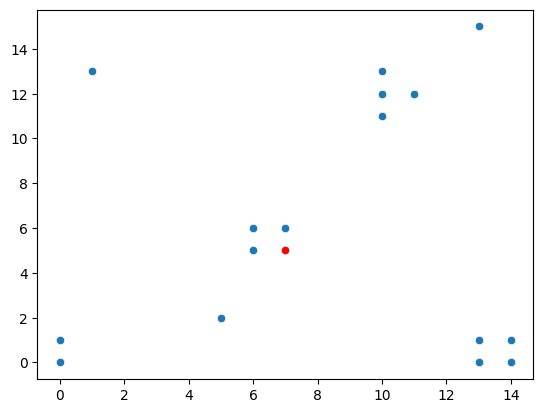

In [121]:

CLUSTER=3
PATH= '../../datasets/l_o8_c4_d2_p200_1.npy'
data = import_dataset(PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)

training_data, training_labels = split_dataset_labels(training_dataset)
testing_data,testing_labels=split_dataset_labels(testing_dataset)

print(testing_labels)
import seaborn as sns
import numpy
#sns.histplot(testing_data[:,0])
plt.figure()
#training_labels
lab=11
#sns.scatterplot(x=training_data[:,0],y=training_data[:,1])
#sns.scatterplot(c='r',x=training_data[:,0][training_labels==lab],y=training_data[:,1][training_labels==lab])

sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
sns.scatterplot(c='r',x=testing_data[:,0][testing_labels==lab],y=testing_data[:,1][testing_labels==lab])

array([False, False, False, False,  True, False,  True, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False, False, False,
        True,  True, False, False,  True, False,  True, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True, False,
       False, False, False, False, False,  True,  True, False,  True,
       False, False, False, False,  True, False, False,  True, False,
       False, False,

(<Figure size 6400x2300 with 1 Axes>, <Axes: >)

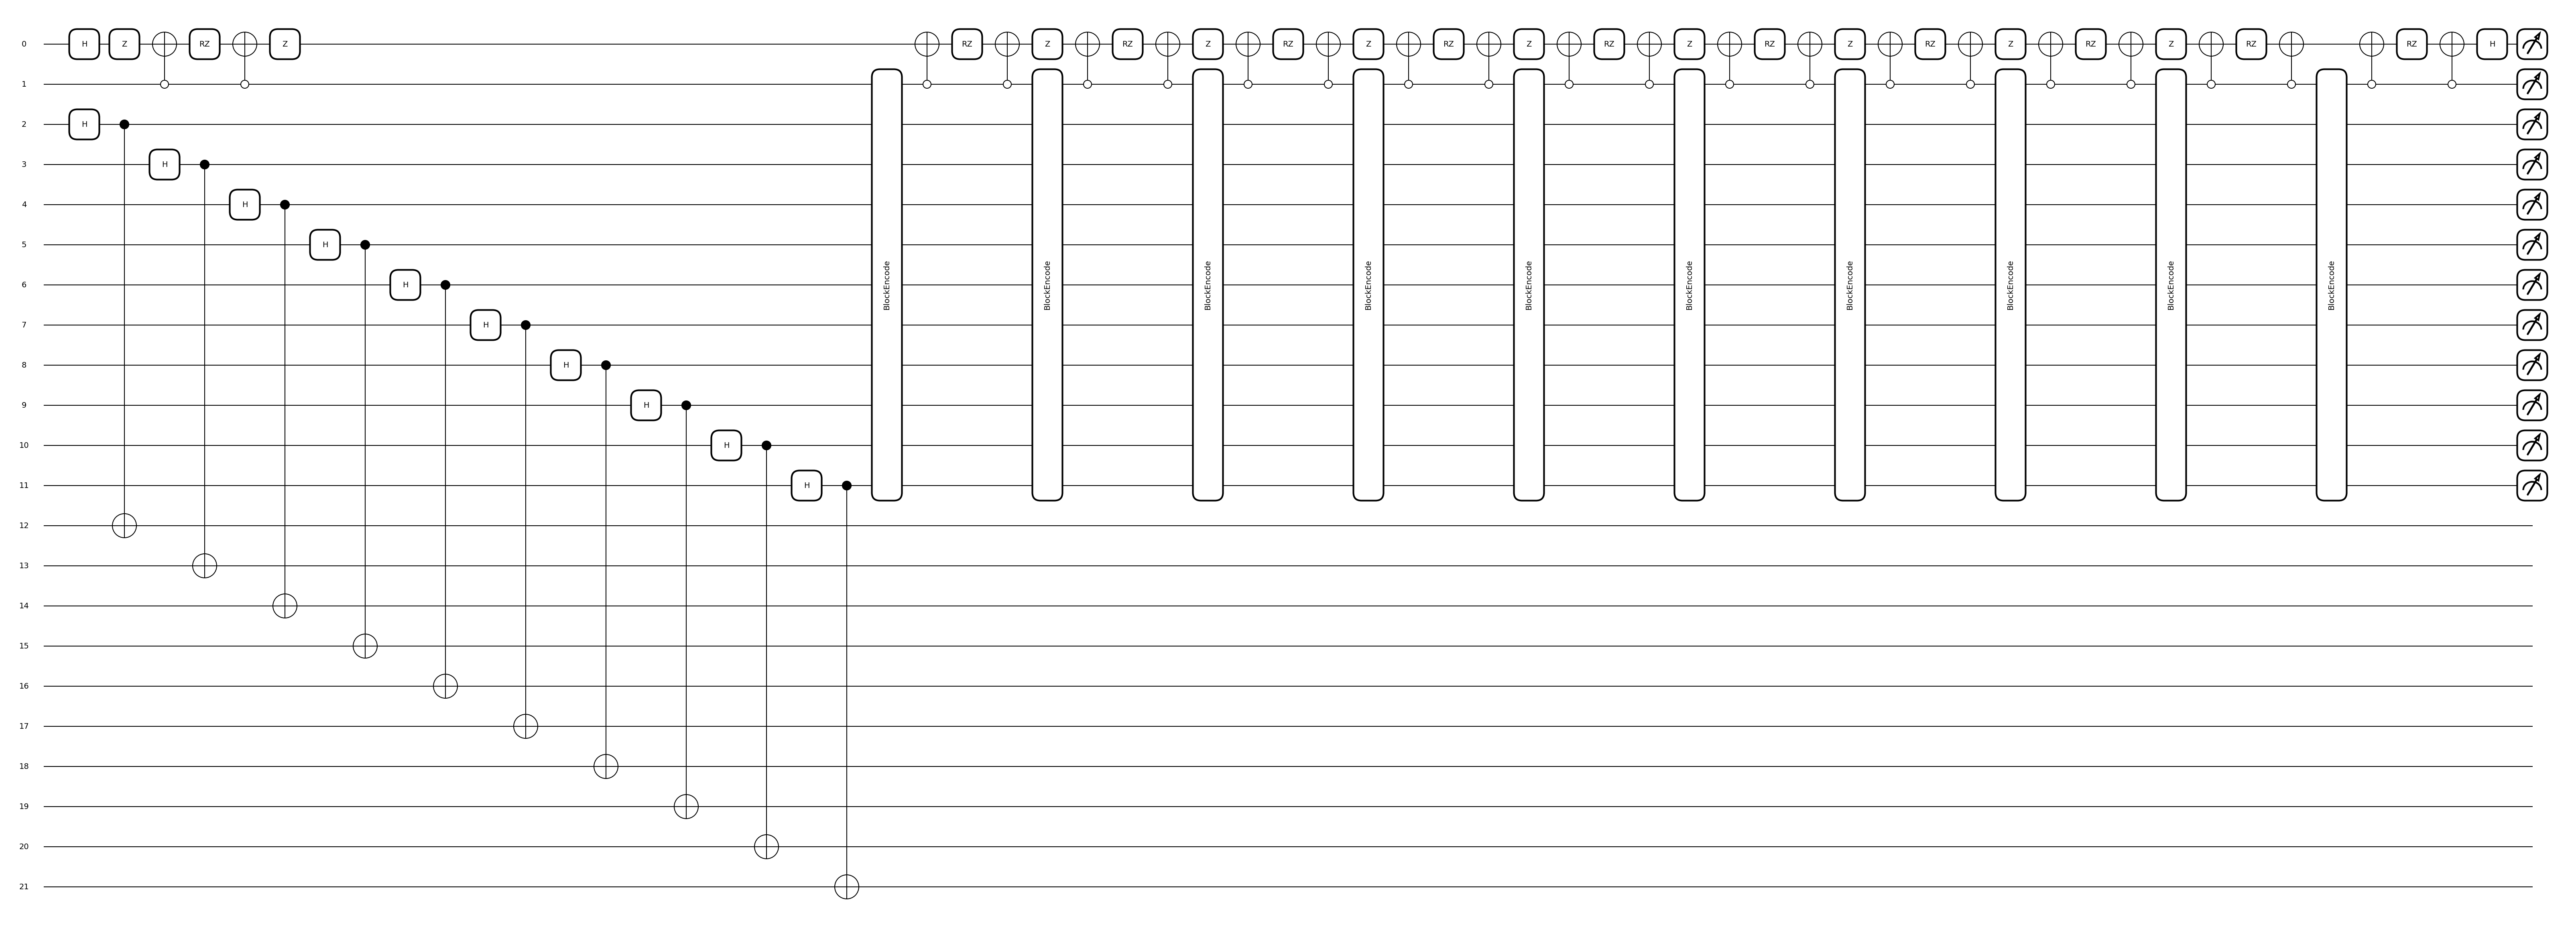

In [114]:
dev = qml.device(dev_name, wires=qbm.n_qubits({'aux','enc','sys'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
@qml.qnode(dev)
def quantum_circuit():
    qbm._prepare()
    return qbm._measure()

qml.draw_mpl(quantum_circuit)()

In [90]:
bit_strings=[]
for i in range(2**(qbm.n_hidden_nodes+qbm.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(qbm.n_hidden_nodes+qbm.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
sample = random.choices(bit_strings, k=1)

sample[0]

tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0], requires_grad=True)

tensor([[1., 1., 0., 1.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 1., 1.]], dtype=float32, requires_grad=True)

[[[1. 1. 0. 1.]
  [1. 1. 1. 1.]]

 [[0. 1. 0. 1.]
  [0. 0. 1. 0.]]

 [[1. 0. 1. 0.]
  [1. 1. 0. 1.]]

 [[0. 0. 0. 1.]
  [1. 1. 0. 1.]]

 [[0. 1. 1. 1.]
  [0. 1. 0. 1.]]]
[-1.42916038]
[-1.10425837]
[-1.42916038]
[-1.10425837]
[-3.77741756]
[0.9062684]
[-1.05642846]
[0.9062684]
[-2.08247181]
[-3.77741756]
[-1.05642846]
[-1.42916038]
[-3.83625577]
[-2.08247181]
[0.067896]
[-2.08247181]
[-1.05642846]
[-1.16309659]
[0.53353648]
[-1.42916038]
[-1.42916038]
[-1.42916038]
[-3.83625577]
[-1.05642846]
[-1.16309659]
[-1.05642846]
[0.53353648]
[-1.05642846]
[-3.77741756]
[-1.10425837]
[-1.05642846]
[-1.16309659]
[-1.42916038]
[-3.83625577]
[-1.10425837]
[-2.08247181]
[-1.05642846]
[-3.83625577]
[-1.05642846]
[-3.77741756]
[-2.08247181]
[-3.83625577]
[-1.05642846]
[0.53353648]
[-1.16309659]
[0.067896]
[-1.05642846]
[-3.77741756]
[-3.83625577]
[-1.05642846]
[-1.42916038]
[-1.05642846]
[-2.08247181]
[0.9062684]
[-3.83625577]
[-1.42916038]
[-1.10425837]
[-1.42916038]
[-1.05642846]
[-1.05642846]
[-1.4

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1155.46it/s]


[1.60755012]
[-0.07011734]
[-1.11526668]
[-0.54113038]
[0.53353648]
Calculate cluster energy


 56%|███████████████████████████████████████████▉                                  | 225/399 [00:00<00:00, 1124.28it/s]

[-1.05642846]
[-1.05642846]
[-3.83625577]
[-3.77741756]
[-1.10425837]
[-1.10425837]
[0.53353648]
[-3.83625577]
[-1.05642846]
[0.9062684]
[-1.16309659]
[0.9062684]
[-1.05642846]
[-1.05642846]
[-1.05642846]
[0.067896]
[-3.83625577]
[-1.05642846]
[-1.05642846]
[-2.08247181]
[-2.08247181]
[-1.42916038]
[-1.05642846]
[-3.83625577]
[-2.08247181]
[-1.42916038]
[-1.42916038]
[-1.10425837]
[-2.14131002]
[-2.08247181]
[-1.42916038]
[-1.10425837]
[0.067896]
[0.53353648]
[-3.77741756]
[-1.42916038]
[2.03059287]
[-1.16309659]
[-1.05642846]
[-1.05642846]
[2.03059287]
[-2.14131002]
[-1.05642846]
[-2.08247181]
[-1.16309659]
[-2.08247181]
[-1.05642846]
[-3.77741756]
[-1.16309659]
[-1.05642846]
[-1.42916038]
[-1.05642846]
[-1.10425837]
[-3.77741756]
[-3.77741756]
[-1.16309659]
[-2.08247181]
[-3.77741756]
[-1.05642846]
[-3.83625577]
[-3.77741756]
[0.067896]
[0.9062684]
[0.9062684]
[0.9062684]
[-1.42916038]
[-1.05642846]
[-3.77741756]
[-3.77741756]
[-1.05642846]
[-1.42916038]
[-1.05642846]
[-1.05642846]
[

100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1058.21it/s]


[-3.83625577]
[-1.05642846]
[-3.77741756]
[-1.05642846]
[0.067896]
[-3.77741756]
[-1.05642846]
[-3.77741756]
[-3.83625577]
[-1.42916038]
[-1.16309659]
[-2.08247181]
[0.9062684]
[-1.05642846]
[-1.05642846]
[-3.77741756]
[-3.83625577]
[-1.16309659]
[-3.77741756]
[-2.14131002]
[-1.05642846]
[-1.42916038]
[-3.77741756]
[-1.16309659]
[-1.10425837]
[-1.05642846]
[-3.83625577]
[-1.42916038]
[-1.16309659]
[-3.83625577]
[0.53353648]
[-3.77741756]
[-3.83625577]
[-1.05642846]
[-1.16309659]
[-1.05642846]
[-1.16309659]
[-1.05642846]
[-1.10425837]
[0.9062684]
[-1.16309659]
[-3.77741756]
[-1.05642846]
[0.067896]
[-3.83625577]
[-1.05642846]
[-1.42916038]
[-3.77741756]
[-1.05642846]
[-1.05642846]
[-1.16309659]
[0.53353648]
[-1.42916038]
[-2.14131002]
[0.067896]
[-2.08247181]
[-3.77741756]
[-1.05642846]
[-2.14131002]
[0.53353648]
[-3.77741756]
[-1.42916038]
[0.53353648]
[-1.42916038]
[-3.83625577]
[-1.16309659]
[-1.05642846]
[-1.10425837]
[-3.77741756]
[-1.10425837]
[-2.08247181]
[-1.42916038]
[-3.77741

<Figure size 640x480 with 0 Axes>

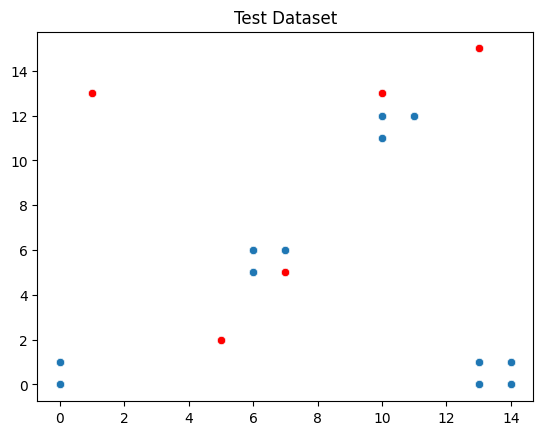

<Figure size 640x480 with 0 Axes>

In [136]:
#weights=qbm.H.θ
import seaborn as sns

#training_data=numpy.expand_dims(training_data[:,0],axis=1)
outliers = qbm.get_binary_outliers(
dataset=testing_dataset, outlier_index=CLUSTER+1)

#outliers=numpy.expand_dims(outliers[:,0],axis=1)
print(outliers)

points = qbm.get_binary_cluster_points(
dataset=testing_dataset, cluster_index=CLUSTER )

#points=numpy.expand_dims(points[:,0],axis=1)
#print(points)
predict_points_cluster = np.zeros(len(points), dtype=int)
predict_points_outliers = np.zeros(len(outliers), dtype=int)
qbm.calculate_outlier_threshold(.95)
print("Outlier threshold: ", qbm.outlier_threshold)
print("Calculate outlier Energy")

testing_data, testing_labels = split_dataset_labels(testing_dataset)
#testing_data=numpy.expand_dims(testing_data[:,0],axis=1)

outlier_energy = []
for index, outlier in enumerate(tqdm(outliers), 0):
    outlier = np.reshape(outlier, (qbm.dim_input))
    predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
        outlier)
    outlier_energy.append(this_outlier_energy)
outlier_energy = np.array(outlier_energy)

o = outlier_energy.reshape((outlier_energy.shape[0]))

print("Calculate cluster energy")
cluster_point_energy = []

for index, point in enumerate(tqdm(points), 0):
    point = np.reshape(point, (qbm.dim_input))
    predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point)
    cluster_point_energy.append(this_cluster_point_energy)
cluster_point_energy = np.array(cluster_point_energy)

c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
print('Outlier classification: Results...')
predict_points = np.concatenate(
    (predict_points_cluster, predict_points_outliers))

print("Predicted points test: ", predict_points)

true_points = np.concatenate(
    (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
    true_points, predict_points), recall_score(true_points, predict_points)
f1 = f1_score(true_points, predict_points)
tn, fp, fn, tp = confusion_matrix(
    true_points, predict_points, labels=[0, 1]).ravel()

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

#print(f'Wallclock time: {(end-start):.2f} seconds')

print("Outlier threshold: ", qbm.outlier_threshold)
print("Average clusterpoint energy: ", np.average(cluster_point_energy))
print("Outlier energy: ", outlier_energy)
plt.figure()
plt.title('Test Dataset')
lab=3
sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
sns.scatterplot(c='r',x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab])
plt.figure()



<Axes: >

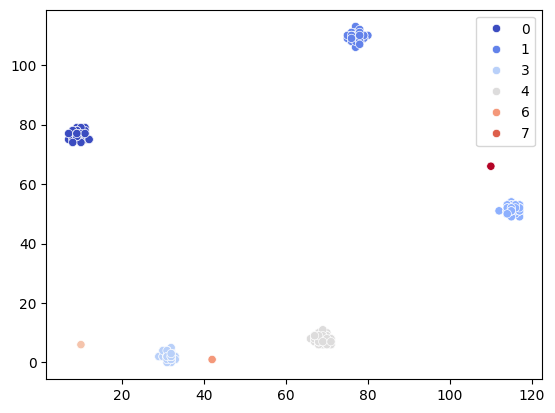

In [269]:
np.random.seed(seed=1)
#dev_name='qiskit.ibmq'
DATASET_PATH='../../datasets/o7_c5_d3_p200_1.npy'
data = import_dataset(DATASET_PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)


sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1], hue=testing_labels,palette='coolwarm')

In [266]:

import seaborn as sns

In [ ]:
a=generate_bit_strings_as_lists(3)

In [4]:


len(generate_pauli_strings_tfim(10,7))

31

In [26]:
pos_neg=[1,0,2,1]


[0, 2, 1, 0, 0, 2]

In [32]:
h=generate_pauli_strings_tfim(10,7,False)

In [52]:
q=h[10:]
for i in range(1,8):
    for j in range(i):
        q.insert(10*(i-1)+j,0)

In [66]:
a=np.array(q)
x,y=a.reshape(7,10)[:,0:7],a.reshape(7,10)[:,7:]

tensor([[tensor('ZIIIIIIZII', dtype='<U10', requires_grad=True),
         tensor('ZIIIIIIIZI', dtype='<U10', requires_grad=True),
         tensor('ZIIIIIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('IZIIIIIZII', dtype='<U10', requires_grad=True),
         tensor('IZIIIIIIZI', dtype='<U10', requires_grad=True),
         tensor('IZIIIIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('IIZIIIIZII', dtype='<U10', requires_grad=True),
         tensor('IIZIIIIIZI', dtype='<U10', requires_grad=True),
         tensor('IIZIIIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('IIIZIIIZII', dtype='<U10', requires_grad=True),
         tensor('IIIZIIIIZI', dtype='<U10', requires_grad=True),
         tensor('IIIZIIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('IIIIZIIZII', dtype='<U10', requires_grad=True),
         tensor('IIIIZIIIZI', dtype='<U10', requires_grad=True),
         tensor('IIIIZIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('III

In [92]:
a=np.array([[1,0,1]])

In [93]:
1-2*a

tensor([[-1,  1, -1]], requires_grad=True)

In [238]:
len(true_points)

503

In [249]:
predict_points

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [255]:
outliers

tensor([[[1., 1., 0., 1., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0.]]], dtype=float32, requires_grad=True)

In [260]:
predict_points_outliers

tensor([0, 0, 1], requires_grad=True)

In [264]:
outlier_energy

tensor([[-0.06369873],
        [-0.03634982],
        [ 0.52896354]], requires_grad=True)

In [261]:
o

tensor([-0.16945875, -0.31900266,  0.57782359], requires_grad=True)